## ARIMA model for NYC electricity price & temperature

In [49]:
import pandas as pd
#from fbprophet import Prophet
from sklearn import metrics
from sklearn import preprocessing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import StandardScaler
from datetime import timedelta 
from datetime import datetime
from numpy.linalg import LinAlgError

## Data Preprocessing

In [50]:
def daily_diff(df, name):
    df.loc[:, name + '_24hr_ago'] = df.loc[:, name].shift(periods = 24)
    df.loc[:, name + '_deseason'] = df.loc[:, name] - df.loc[:, name + '_24hr_ago']
    return df.dropna()

In [51]:
df_price = pd.read_csv('nyiso_NYC_price.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_load = pd.read_csv('nyiso_NYC_load.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_temp = pd.read_csv('la_guardia_airport_2017_local_time.csv', parse_dates=['time_stamp', 'time_stamp_local'])

In [52]:
df_price.head(1), df_load.head(1), df_temp.head(1)

(           time_stamp  price time_stamp_local
 0 2016-01-01 05:00:00  61.48       2016-01-01,
            time_stamp    load time_stamp_local
 0 2016-01-01 05:00:00  4894.5       2016-01-01,
   time_stamp  temp    time_stamp_local
 0 2016-01-01  46.0 2015-12-31 19:00:00)

In [55]:
start_date = pd.datetime(2016, 1, 1)
end_date = start_date + timedelta(days = 731)
may1st_index_price = (df_price.time_stamp_local >= start_date) & \
                     (df_price.time_stamp_local < end_date)
may1st_index_temp = (df_temp.time_stamp_local >= start_date) & \
                     (df_temp.time_stamp_local < end_date)

may1st_index_load = (df_load.time_stamp_local >= start_date) & \
                    (df_load.time_stamp_local < end_date)

df_price = df_price.loc[may1st_index_price, :].reset_index(drop = True)
df_temp = df_temp.loc[may1st_index_temp, :].reset_index(drop = True)
df_load = df_load.loc[may1st_index_load, :].reset_index(drop = True)

df_price.shape, df_temp.shape, df_load.shape

((17544, 3), (17544, 3), (17544, 3))

In [ ]:
fig, ax = plt.subplots(figsize = (24, 9))
ax.plot(df_price.iloc[:,2], preprocessing.scale(df_price.iloc[:,1]), linewidth = 4
        , color = 'black', label = 'Electricity Price')
ax.plot(df_load.iloc[:,2], preprocessing.scale(df_load.iloc[:,1]), linewidth = 4
        , color = 'red', label = 'Electricity Load')
ax.plot(df_temp.iloc[:,2], preprocessing.scale(df_temp.iloc[:,1]), linewidth = 4
        , color = 'green', label = 'Temperature')
ax.legend(fontsize = 32)
ax.set_ylabel('Standardized Value', fontsize = 32)
ax.set_xlim(start_date + timedelta(days = 1), end_date)
# ax.set_ylim(-2, 11)
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
#plt.savefig('price_load_temp_2018.pdf', format = 'pdf')

In [56]:
X_price = daily_diff(df_price, 'price')
X_load = daily_diff(df_load, 'load')
X_temp = daily_diff(df_temp, 'temp')

In [57]:
X_price.columns, X_load.columns, X_temp.columns

(Index(['time_stamp', 'price', 'time_stamp_local', 'price_24hr_ago',
        'price_deseason'],
       dtype='object'),
 Index(['time_stamp', 'load', 'time_stamp_local', 'load_24hr_ago',
        'load_deseason'],
       dtype='object'),
 Index(['time_stamp', 'temp', 'time_stamp_local', 'temp_24hr_ago',
        'temp_deseason'],
       dtype='object'))

In [58]:
X_full = pd.concat([X_price[['time_stamp', 'time_stamp_local', 'price', 'price_24hr_ago', 'price_deseason']], 
                    X_load[['load', 'load_24hr_ago', 'load_deseason']], 
                    X_temp[['temp', 'temp_24hr_ago', 'temp_deseason']]], axis = 1).reset_index(drop = True)

X_full.columns = ['time_stamp', 'time_stamp_local', 'price', 'price_24hr_ago', 'price_diff', 
                  'load', 'load_24hr_ago', 'load_diff',
                  'temp', 'temp_24hr_ago', 'temp_diff']

X_full.to_csv('full_diff_data_2016_2017.csv', index = False)

test = pd.read_csv('full_diff_data_2016_2017.csv')

test.tail()

,time_stamp,time_stamp_local,price,price_24hr_ago,price_diff,load,load_24hr_ago,load_diff,temp,temp_24hr_ago,temp_diff
17515,2018-01-01 00:00:00,2017-12-31 19:00:00,152.78,127.90,24.88,7001.2,6731.1,270.1,13.0,23.0,-10.0
17516,2018-01-01 01:00:00,2017-12-31 20:00:00,149.36,132.07,17.29,6865.7,6635.8,229.9,12.0,23.0,-11.0
17517,2018-01-01 02:00:00,2017-12-31 21:00:00,131.16,112.99,18.17,6672.1,6502.4,169.7,11.0,23.0,-12.0
17518,2018-01-01 03:00:00,2017-12-31 22:00:00,135.27,109.81,25.46,6467.6,6304.0,163.6,11.0,22.5,-11.5
17519,2018-01-01 04:00:00,2017-12-31 23:00:00,143.23,98.40,44.83,6263.7,6014.8,248.9,10.0,22.0,-12.0


In [ ]:
plt.hist(df_price.price_deseason, range = (-50, 50), bins = 60, log = True);

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (16, 12))
ax[0].plot(df_price.price, label = 'before')
ax[0].plot(df_price.price_24hr_ago, label = 'after')
ax[0].set_xlim(0, 100)
ax[0].set_ylim(-50, 200)
ax[0].legend()
ax[1].plot(df_price.price_deseason, label = 'diff')
ax[1].set_xlim(0, 100)
ax[1].set_ylim(-50, 200)
ax[1].legend()

In [17]:
df_data = pd.read_csv('full_diff_data.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_data.set_index('time_stamp', inplace = True)

In [18]:
df_data.shape

(8760, 10)

In [19]:
df_data.columns

Index(['time_stamp_local', 'price', 'price_24hr_ago', 'price_diff', 'load',
       'load_24hr_ago', 'load_diff', 'temp', 'temp_24hr_ago', 'temp_diff'],
      dtype='object')

## Statistical test

Test for a period of 1 week (7 * 24 = 168) data. 

### Seasonality: Autocorrelation Plots

In [ ]:
def plot_acf(df, name):
    fig, axes = plt.subplots(2, 2, figsize=(16,9))

    fig = sm.graphics.tsa.plot_acf(df.loc[:,name], lags=60, ax=axes[0, 0])
    fig = sm.graphics.tsa.plot_pacf(df.loc[:,name], lags=60, ax=axes[0, 1])

    fig = sm.graphics.tsa.plot_acf(df.loc[:, name + '_diff'], lags=60, ax=axes[1, 0])
    fig = sm.graphics.tsa.plot_pacf(df.loc[:, name + '_diff'], lags=60, ax=axes[1, 1])

In [ ]:
plot_acf(df_data, 'price')

In [ ]:
plot_acf(df_data, 'load')

In [ ]:
plot_acf(df_data, 'temp')

## Stationarity: Augmented Dickey-Fuller Test

Time Series models are described in terms of autoregressive (AR) lags. So an AR(1) model states that the value at Y<sub>t</sub> depends on the value at Y<sub>t-1</sub>. So we can represent the time series as a model:

Y<sub>t</sub> = Alpha + Rho\*Y<sub>t-1</sub> + Error<sub>t</sub>

It turns out, a time series is perfectly stationary when Rho = 0. This makes intuitive sense: The time series will not depend on its previous value when Rho is 0, so it depends entirely on error and is equivalent to a random walk. A time series is perfectly non-stationary if Rho = 1. Alpha is a coeffecient that we want to estimate such that the Error term is minimized, but let's worry about that later.

The Dickey-Fuller Test asks if Rho in an AR(1) model is equal to 0 (H<sub>0</sub>: Rho=1, H<sub>1</sub>: Rho<1)

The augmented Dickey-Fuller Test just expands this to work for AR(n) models

**A p-value < 0.05 indicates that your time series IS STATIONARY.**

In [ ]:
# the statsmodels output is ugly and unlabeled, lets use a function to format it nicely
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
dftest_price = adfuller(df_data.price_diff.values, autolag='AIC')
adf_output(dftest_price)

In [ ]:
dftest_load = adfuller(df_data.load_diff.values, autolag='AIC')
adf_output(dftest_load)

In [ ]:
dftest_temp = adfuller(df_data.temp_diff.values, autolag='AIC')
adf_output(dftest_temp)

<a id='granger'></a>
### Granger Causality
Granger Causality is a statistical method for testing the relationship between two time series. This can be a great way to supplement an analysis and move beyond simply plotting the decomposed time series.

At it's heart, this method asks whether values from a second time series provide more information about the future values of your first time series than just considering past values of the first time series:

"X is said to Granger-cause Y if Y can be better predicted using the histories of both X and Y than it can by using the history of Y alone." A good explanation of Granger Causality can be found [here](https://www.r-bloggers.com/chicken-or-the-egg-granger-causality-for-the-masses/) and [here](http://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html) (the first is much simpler, the second is for a real deep dive!).


An important caveat of Granger Causality is that it is very possible to find that X significantly Granger-causes Y, and simultaneously see that Y Granger-causes X. With well selected variables, you can curb this issue to some degree. For example, while maybe possible, it is much more likely that changes in temperature cause ice melting than ice melting causing changes in temperature. It may also be easier to get unidirectional causality in trend components rather than seasonal components.



In [ ]:
granger_load = pd.DataFrame({'price': df_data.price_diff.values, 'load': df_data.load_diff.values})
granger_load = granger.dropna()
granger_load = grangercausalitytests(granger, maxlag=5)

In [ ]:
granger_temp = pd.DataFrame({'price': df_data.price_diff.values, 'temp': df_data.temp_diff.values})
granger_temp = granger.dropna()
granger_temp = grangercausalitytests(granger, maxlag=5)

## Train ARIMA model

- Data: 1 week (24 * 7 = 168) data
- Train: 167
- Valid: 1 (the last day)

#### Train/ test split

In [ ]:
#start_time = df_data.index[0]
start_time = pd.datetime(2017,1,12,23)
window_dt = timedelta(days = 7)
time_index = pd.date_range(start_time, start_time + window_dt, freq = 'H', closed = 'left')
df_data_byweek = df_data.loc[time_index,:]
X_train = df_data_byweek.price_diff.values[:time_index.shape[0] - 1]
X_test = df_data_byweek.price_diff.values[-1:]

#df_data_byweek = df_data.loc[time_index,:].shift()
X_train_exog = df_data_byweek.temp_diff.values[:time_index.shape[0] - 1]
X_test_exog = df_data_byweek.temp_diff.values[-1:]
X_train.shape, X_test.shape, X_train_exog.shape, X_test_exog.shape

#### Univariate ARIMA model with sliding window 

In [20]:
def uni_arima(train_arr, order = (3,0,3)):
    try:
        model = ARIMA(X_train, order = order)
        #model = sm.tsa.statespace.SARIMAX(X_train, order = order, seasonal_order = (0,0,1,12))
        model_fit = model.fit(disp=0)
        forecast = model_fit.forecast(steps=1)[0]
    except (ValueError, LinAlgError):
        try:
            model = ARIMA(X_train, order = (1, 0, 1))
            #model = sm.tsa.statespace.SARIMAX(X_train, order = order, seasonal_order = (0,0,1,12))
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=1)[0]
        except(ValueError, LinAlgError):
            forecast = np.nan
    return forecast

In [ ]:
# conceptually one needs to input the exog_arr value in the future to make prediction
def multi_arima(train_arr, exog_arr, order = (3,0,3)):
    try:
        model = ARIMA(endog = X_train, exog = exog_arr, order = order)
        model_fit = model.fit(disp=0)
        forecast = model_fit.forecast(exog = [exog_arr[-1]], steps=1)[0]
    except (ValueError, LinAlgError):
        try:
            model = ARIMA(endog = X_train, exog = exog_arr, order = (1, 0, 1))
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(exog = [exog_arr[-1]], steps=1)[0]
        except(ValueError, LinAlgError):
            forecast = np.nan
    return forecast

In [ ]:
multi_arima(X_train, X_train_exog), X_test

In [ ]:
uni_arima(X_train), X_test

In [21]:
start_time = df_data.index[0]
window_dt = timedelta(days = 7)
df_data['uni_pred'] = np.nan
for start_time in df_data.index:
    if start_time + window_dt <= df_data.index[-1] + timedelta(hours = 1):
        time_index = pd.date_range(start_time, start_time + window_dt, freq = 'H', closed = 'left')
        print(time_index[0], time_index[-1])
        df_data_byweek = df_data.loc[time_index,:]
        X_train = df_data_byweek.price_diff.values[:time_index.shape[0] - 1]
        #X_test = df_data_byweek.price_diff.values[-1:]
        time_stamp_pred = df_data_byweek.index[-1]
        print(time_stamp_pred)
        prediction = uni_arima(X_train)
        df_data.loc[time_stamp_pred, 'uni_pred'] = prediction

2017-01-01 05:00:00 2017-01-08 04:00:00
2017-01-08 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-01 06:00:00 2017-01-08 05:00:00
2017-01-08 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-01-01 07:00:00 2017-01-08 06:00:00
2017-01-08 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-01 08:00:00 2017-01-08 07:00:00
2017-01-08 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-01 09:00:00 2017-01-08 08:00:00
2017-01-08 08:00:00
2017-01-01 10:00:00 2017-01-08 09:00:00
2017-01-08 09:00:00
2017-01-01 11:00:00 2017-01-08 10:00:00
2017-01-08 10:00:00
2017-01-01 12:00:00 2017-01-08 11:00:00
2017-01-08 11:00:00
2017-01-01 13:00:00 2017-01-08 12:00:00
2017-01-08 12:00:00
2017-01-01 14:00:00 2017-01-08 13:00:00
2017-01-08 13:00:00
2017-01-01 15:00:00 2017-01-08 14:00:00
2017-01-08 14:00:00
2017-01-01 16:00:00 2017-01-08 15:00:00
2017-01-08 15:00:00
2017-01-01 17:00:00 2017-01-08 16:00:00
2017-01-08 16:00:00
2017-01-01 18:00:00 2017-01-08 17:00:00
2017-01-08 17:00:00
2017-01-01 19:00:00 2017-01-08 18:00:00
2017-01-08 18:00:00
2017-01-01 20:00:00 2017-01-08 19:00:00
2017-01-08 19:00:00
2017-01-01 21:00:00 2017-01-08 20:00:00
2017-01-08 20:00:00
2017-01-01 22:00:00 2017-01-08 21:00:00
2017-01-08 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-01 23:00:00 2017-01-08 22:00:00
2017-01-08 22:00:00
2017-01-02 00:00:00 2017-01-08 23:00:00
2017-01-08 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:652: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:654: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]


2017-01-02 01:00:00 2017-01-09 00:00:00
2017-01-09 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


2017-01-02 02:00:00 2017-01-09 01:00:00
2017-01-09 01:00:00
2017-01-02 03:00:00 2017-01-09 02:00:00
2017-01-09 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 04:00:00 2017-01-09 03:00:00
2017-01-09 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 05:00:00 2017-01-09 04:00:00
2017-01-09 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 06:00:00 2017-01-09 05:00:00
2017-01-09 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:654: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


2017-01-02 07:00:00 2017-01-09 06:00:00
2017-01-09 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 08:00:00 2017-01-09 07:00:00
2017-01-09 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 09:00:00 2017-01-09 08:00:00
2017-01-09 08:00:00
2017-01-02 10:00:00 2017-01-09 09:00:00
2017-01-09 09:00:00
2017-01-02 11:00:00 2017-01-09 10:00:00
2017-01-09 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 12:00:00 2017-01-09 11:00:00
2017-01-09 11:00:00
2017-01-02 13:00:00 2017-01-09 12:00:00
2017-01-09 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 14:00:00 2017-01-09 13:00:00
2017-01-09 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 15:00:00 2017-01-09 14:00:00
2017-01-09 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 16:00:00 2017-01-09 15:00:00
2017-01-09 15:00:00
2017-01-02 17:00:00 2017-01-09 16:00:00
2017-01-09 16:00:00
2017-01-02 18:00:00 2017-01-09 17:00:00
2017-01-09 17:00:00
2017-01-02 19:00:00 2017-01-09 18:00:00
2017-01-09 18:00:00
2017-01-02 20:00:00 2017-01-09 19:00:00
2017-01-09 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 21:00:00 2017-01-09 20:00:00
2017-01-09 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-02 22:00:00 2017-01-09 21:00:00
2017-01-09 21:00:00
2017-01-02 23:00:00 2017-01-09 22:00:00
2017-01-09 22:00:00
2017-01-03 00:00:00 2017-01-09 23:00:00
2017-01-09 23:00:00
2017-01-03 01:00:00 2017-01-10 00:00:00
2017-01-10 00:00:00
2017-01-03 02:00:00 2017-01-10 01:00:00
2017-01-10 01:00:00
2017-01-03 03:00:00 2017-01-10 02:00:00
2017-01-10 02:00:00
2017-01-03 04:00:00 2017-01-10 03:00:00
2017-01-10 03:00:00
2017-01-03 05:00:00 2017-01-10 04:00:00
2017-01-10 04:00:00
2017-01-03 06:00:00 2017-01-10 05:00:00
2017-01-10 05:00:00
2017-01-03 07:00:00 2017-01-10 06:00:00
2017-01-10 06:00:00
2017-01-03 08:00:00 2017-01-10 07:00:00
2017-01-10 07:00:00
2017-01-03 09:00:00 2017-01-10 08:00:00
2017-01-10 08:00:00
2017-01-03 10:00:00 2017-01-10 09:00:00
2017-01-10 09:00:00
2017-01-03 11:00:00 2017-01-10 10:00:00
2017-01-10 10:00:00
2017-01-03 12:00:00 2017-01-10 11:00:00
2017-01-10 11:00:00
2017-01-03 13:00:00 2017-01-10 12:00:00
2017-01-10 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-03 14:00:00 2017-01-10 13:00:00
2017-01-10 13:00:00
2017-01-03 15:00:00 2017-01-10 14:00:00
2017-01-10 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-03 16:00:00 2017-01-10 15:00:00
2017-01-10 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-03 17:00:00 2017-01-10 16:00:00
2017-01-10 16:00:00
2017-01-03 18:00:00 2017-01-10 17:00:00
2017-01-10 17:00:00
2017-01-03 19:00:00 2017-01-10 18:00:00
2017-01-10 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1500: RuntimeWarning: invalid value encountered in sqrt
  fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep**2))


2017-01-03 20:00:00 2017-01-10 19:00:00
2017-01-10 19:00:00
2017-01-03 21:00:00 2017-01-10 20:00:00
2017-01-10 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-03 22:00:00 2017-01-10 21:00:00
2017-01-10 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-03 23:00:00 2017-01-10 22:00:00
2017-01-10 22:00:00
2017-01-04 00:00:00 2017-01-10 23:00:00
2017-01-10 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-04 01:00:00 2017-01-11 00:00:00
2017-01-11 00:00:00
2017-01-04 02:00:00 2017-01-11 01:00:00
2017-01-11 01:00:00
2017-01-04 03:00:00 2017-01-11 02:00:00
2017-01-11 02:00:00
2017-01-04 04:00:00 2017-01-11 03:00:00
2017-01-11 03:00:00
2017-01-04 05:00:00 2017-01-11 04:00:00
2017-01-11 04:00:00
2017-01-04 06:00:00 2017-01-11 05:00:00
2017-01-11 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


2017-01-04 07:00:00 2017-01-11 06:00:00
2017-01-11 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-04 08:00:00 2017-01-11 07:00:00
2017-01-11 07:00:00
2017-01-04 09:00:00 2017-01-11 08:00:00
2017-01-11 08:00:00
2017-01-04 10:00:00 2017-01-11 09:00:00
2017-01-11 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-04 11:00:00 2017-01-11 10:00:00
2017-01-11 10:00:00
2017-01-04 12:00:00 2017-01-11 11:00:00
2017-01-11 11:00:00
2017-01-04 13:00:00 2017-01-11 12:00:00
2017-01-11 12:00:00
2017-01-04 14:00:00 2017-01-11 13:00:00
2017-01-11 13:00:00
2017-01-04 15:00:00 2017-01-11 14:00:00
2017-01-11 14:00:00
2017-01-04 16:00:00 2017-01-11 15:00:00
2017-01-11 15:00:00
2017-01-04 17:00:00 2017-01-11 16:00:00
2017-01-11 16:00:00
2017-01-04 18:00:00 2017-01-11 17:00:00
2017-01-11 17:00:00
2017-01-04 19:00:00 2017-01-11 18:00:00
2017-01-11 18:00:00
2017-01-04 20:00:00 2017-01-11 19:00:00
2017-01-11 19:00:00
2017-01-04 21:00:00 2017-01-11 20:00:00
2017-01-11 20:00:00
2017-01-04 22:00:00 2017-01-11 21:00:00
2017-01-11 21:00:00
2017-01-04 23:00:00 2017-01-11 22:00:00
2017-01-11 22:00:00
2017-01-05 00:00:00 2017-01-11 23:00:00
2017-01-11 23:00:00
2017-01-05 01:00:00 2017-01-12 00:00:00
2017-01-12 00:00:00
2017-01-05 02:00:00 2017-01-12 01:00:00
2017-01-12 01:00:00
2017-01-05 03:00:00 2017-01-12 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-07 23:00:00 2017-01-14 22:00:00
2017-01-14 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-08 00:00:00 2017-01-14 23:00:00
2017-01-14 23:00:00
2017-01-08 01:00:00 2017-01-15 00:00:00
2017-01-15 00:00:00
2017-01-08 02:00:00 2017-01-15 01:00:00
2017-01-15 01:00:00
2017-01-08 03:00:00 2017-01-15 02:00:00
2017-01-15 02:00:00
2017-01-08 04:00:00 2017-01-15 03:00:00
2017-01-15 03:00:00
2017-01-08 05:00:00 2017-01-15 04:00:00
2017-01-15 04:00:00
2017-01-08 06:00:00 2017-01-15 05:00:00
2017-01-15 05:00:00
2017-01-08 07:00:00 2017-01-15 06:00:00
2017-01-15 06:00:00
2017-01-08 08:00:00 2017-01-15 07:00:00
2017-01-15 07:00:00
2017-01-08 09:00:00 2017-01-15 08:00:00
2017-01-15 08:00:00
2017-01-08 10:00:00 2017-01-15 09:00:00
2017-01-15 09:00:00
2017-01-08 11:00:00 2017-01-15 10:00:00
2017-01-15 10:00:00
2017-01-08 12:00:00 2017-01-15 11:00:00
2017-01-15 11:00:00
2017-01-08 13:00:00 2017-01-15 12:00:00
2017-01-15 12:00:00
2017-01-08 14:00:00 2017-01-15 13:00:00
2017-01-15 13:00:00
2017-01-08 15:00:00 2017-01-15 14:00:00
2017-01-15 14:00:00
2017-01-08 16:00:00 2017-01-15 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-08 19:00:00 2017-01-15 18:00:00
2017-01-15 18:00:00
2017-01-08 20:00:00 2017-01-15 19:00:00
2017-01-15 19:00:00
2017-01-08 21:00:00 2017-01-15 20:00:00
2017-01-15 20:00:00
2017-01-08 22:00:00 2017-01-15 21:00:00
2017-01-15 21:00:00
2017-01-08 23:00:00 2017-01-15 22:00:00
2017-01-15 22:00:00
2017-01-09 00:00:00 2017-01-15 23:00:00
2017-01-15 23:00:00
2017-01-09 01:00:00 2017-01-16 00:00:00
2017-01-16 00:00:00
2017-01-09 02:00:00 2017-01-16 01:00:00
2017-01-16 01:00:00
2017-01-09 03:00:00 2017-01-16 02:00:00
2017-01-16 02:00:00
2017-01-09 04:00:00 2017-01-16 03:00:00
2017-01-16 03:00:00
2017-01-09 05:00:00 2017-01-16 04:00:00
2017-01-16 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-09 06:00:00 2017-01-16 05:00:00
2017-01-16 05:00:00
2017-01-09 07:00:00 2017-01-16 06:00:00
2017-01-16 06:00:00
2017-01-09 08:00:00 2017-01-16 07:00:00
2017-01-16 07:00:00
2017-01-09 09:00:00 2017-01-16 08:00:00
2017-01-16 08:00:00
2017-01-09 10:00:00 2017-01-16 09:00:00
2017-01-16 09:00:00
2017-01-09 11:00:00 2017-01-16 10:00:00
2017-01-16 10:00:00
2017-01-09 12:00:00 2017-01-16 11:00:00
2017-01-16 11:00:00
2017-01-09 13:00:00 2017-01-16 12:00:00
2017-01-16 12:00:00
2017-01-09 14:00:00 2017-01-16 13:00:00
2017-01-16 13:00:00
2017-01-09 15:00:00 2017-01-16 14:00:00
2017-01-16 14:00:00
2017-01-09 16:00:00 2017-01-16 15:00:00
2017-01-16 15:00:00
2017-01-09 17:00:00 2017-01-16 16:00:00
2017-01-16 16:00:00
2017-01-09 18:00:00 2017-01-16 17:00:00
2017-01-16 17:00:00
2017-01-09 19:00:00 2017-01-16 18:00:00
2017-01-16 18:00:00
2017-01-09 20:00:00 2017-01-16 19:00:00
2017-01-16 19:00:00
2017-01-09 21:00:00 2017-01-16 20:00:00
2017-01-16 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-09 22:00:00 2017-01-16 21:00:00
2017-01-16 21:00:00
2017-01-09 23:00:00 2017-01-16 22:00:00
2017-01-16 22:00:00
2017-01-10 00:00:00 2017-01-16 23:00:00
2017-01-16 23:00:00
2017-01-10 01:00:00 2017-01-17 00:00:00
2017-01-17 00:00:00
2017-01-10 02:00:00 2017-01-17 01:00:00
2017-01-17 01:00:00
2017-01-10 03:00:00 2017-01-17 02:00:00
2017-01-17 02:00:00
2017-01-10 04:00:00 2017-01-17 03:00:00
2017-01-17 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-10 05:00:00 2017-01-17 04:00:00
2017-01-17 04:00:00
2017-01-10 06:00:00 2017-01-17 05:00:00
2017-01-17 05:00:00
2017-01-10 07:00:00 2017-01-17 06:00:00
2017-01-17 06:00:00
2017-01-10 08:00:00 2017-01-17 07:00:00
2017-01-17 07:00:00
2017-01-10 09:00:00 2017-01-17 08:00:00
2017-01-17 08:00:00
2017-01-10 10:00:00 2017-01-17 09:00:00
2017-01-17 09:00:00
2017-01-10 11:00:00 2017-01-17 10:00:00
2017-01-17 10:00:00
2017-01-10 12:00:00 2017-01-17 11:00:00
2017-01-17 11:00:00
2017-01-10 13:00:00 2017-01-17 12:00:00
2017-01-17 12:00:00
2017-01-10 14:00:00 2017-01-17 13:00:00
2017-01-17 13:00:00
2017-01-10 15:00:00 2017-01-17 14:00:00
2017-01-17 14:00:00
2017-01-10 16:00:00 2017-01-17 15:00:00
2017-01-17 15:00:00
2017-01-10 17:00:00 2017-01-17 16:00:00
2017-01-17 16:00:00
2017-01-10 18:00:00 2017-01-17 17:00:00
2017-01-17 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:654: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]


2017-01-10 19:00:00 2017-01-17 18:00:00
2017-01-17 18:00:00
2017-01-10 20:00:00 2017-01-17 19:00:00
2017-01-17 19:00:00
2017-01-10 21:00:00 2017-01-17 20:00:00
2017-01-17 20:00:00
2017-01-10 22:00:00 2017-01-17 21:00:00
2017-01-17 21:00:00
2017-01-10 23:00:00 2017-01-17 22:00:00
2017-01-17 22:00:00
2017-01-11 00:00:00 2017-01-17 23:00:00
2017-01-17 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-11 01:00:00 2017-01-18 00:00:00
2017-01-18 00:00:00
2017-01-11 02:00:00 2017-01-18 01:00:00
2017-01-18 01:00:00
2017-01-11 03:00:00 2017-01-18 02:00:00
2017-01-18 02:00:00
2017-01-11 04:00:00 2017-01-18 03:00:00
2017-01-18 03:00:00
2017-01-11 05:00:00 2017-01-18 04:00:00
2017-01-18 04:00:00
2017-01-11 06:00:00 2017-01-18 05:00:00
2017-01-18 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-11 07:00:00 2017-01-18 06:00:00
2017-01-18 06:00:00
2017-01-11 08:00:00 2017-01-18 07:00:00
2017-01-18 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-11 09:00:00 2017-01-18 08:00:00
2017-01-18 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-11 10:00:00 2017-01-18 09:00:00
2017-01-18 09:00:00
2017-01-11 11:00:00 2017-01-18 10:00:00
2017-01-18 10:00:00
2017-01-11 12:00:00 2017-01-18 11:00:00
2017-01-18 11:00:00
2017-01-11 13:00:00 2017-01-18 12:00:00
2017-01-18 12:00:00
2017-01-11 14:00:00 2017-01-18 13:00:00
2017-01-18 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-11 15:00:00 2017-01-18 14:00:00
2017-01-18 14:00:00
2017-01-11 16:00:00 2017-01-18 15:00:00
2017-01-18 15:00:00
2017-01-11 17:00:00 2017-01-18 16:00:00
2017-01-18 16:00:00
2017-01-11 18:00:00 2017-01-18 17:00:00
2017-01-18 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-11 19:00:00 2017-01-18 18:00:00
2017-01-18 18:00:00
2017-01-11 20:00:00 2017-01-18 19:00:00
2017-01-18 19:00:00
2017-01-11 21:00:00 2017-01-18 20:00:00
2017-01-18 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-11 22:00:00 2017-01-18 21:00:00
2017-01-18 21:00:00
2017-01-11 23:00:00 2017-01-18 22:00:00
2017-01-18 22:00:00
2017-01-12 00:00:00 2017-01-18 23:00:00
2017-01-18 23:00:00
2017-01-12 01:00:00 2017-01-19 00:00:00
2017-01-19 00:00:00
2017-01-12 02:00:00 2017-01-19 01:00:00
2017-01-19 01:00:00
2017-01-12 03:00:00 2017-01-19 02:00:00
2017-01-19 02:00:00
2017-01-12 04:00:00 2017-01-19 03:00:00
2017-01-19 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-12 05:00:00 2017-01-19 04:00:00
2017-01-19 04:00:00
2017-01-12 06:00:00 2017-01-19 05:00:00
2017-01-19 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-12 07:00:00 2017-01-19 06:00:00
2017-01-19 06:00:00
2017-01-12 08:00:00 2017-01-19 07:00:00
2017-01-19 07:00:00
2017-01-12 09:00:00 2017-01-19 08:00:00
2017-01-19 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-12 10:00:00 2017-01-19 09:00:00
2017-01-19 09:00:00
2017-01-12 11:00:00 2017-01-19 10:00:00
2017-01-19 10:00:00
2017-01-12 12:00:00 2017-01-19 11:00:00
2017-01-19 11:00:00
2017-01-12 13:00:00 2017-01-19 12:00:00
2017-01-19 12:00:00
2017-01-12 14:00:00 2017-01-19 13:00:00
2017-01-19 13:00:00
2017-01-12 15:00:00 2017-01-19 14:00:00
2017-01-19 14:00:00
2017-01-12 16:00:00 2017-01-19 15:00:00
2017-01-19 15:00:00
2017-01-12 17:00:00 2017-01-19 16:00:00
2017-01-19 16:00:00
2017-01-12 18:00:00 2017-01-19 17:00:00
2017-01-19 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-12 19:00:00 2017-01-19 18:00:00
2017-01-19 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-12 20:00:00 2017-01-19 19:00:00
2017-01-19 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-12 21:00:00 2017-01-19 20:00:00
2017-01-19 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-12 22:00:00 2017-01-19 21:00:00
2017-01-19 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-12 23:00:00 2017-01-19 22:00:00
2017-01-19 22:00:00
2017-01-13 00:00:00 2017-01-19 23:00:00
2017-01-19 23:00:00
2017-01-13 01:00:00 2017-01-20 00:00:00
2017-01-20 00:00:00
2017-01-13 02:00:00 2017-01-20 01:00:00
2017-01-20 01:00:00
2017-01-13 03:00:00 2017-01-20 02:00:00
2017-01-20 02:00:00
2017-01-13 04:00:00 2017-01-20 03:00:00
2017-01-20 03:00:00
2017-01-13 05:00:00 2017-01-20 04:00:00
2017-01-20 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-13 06:00:00 2017-01-20 05:00:00
2017-01-20 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-13 07:00:00 2017-01-20 06:00:00
2017-01-20 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-13 08:00:00 2017-01-20 07:00:00
2017-01-20 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-13 09:00:00 2017-01-20 08:00:00
2017-01-20 08:00:00
2017-01-13 10:00:00 2017-01-20 09:00:00
2017-01-20 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-13 11:00:00 2017-01-20 10:00:00
2017-01-20 10:00:00
2017-01-13 12:00:00 2017-01-20 11:00:00
2017-01-20 11:00:00
2017-01-13 13:00:00 2017-01-20 12:00:00
2017-01-20 12:00:00
2017-01-13 14:00:00 2017-01-20 13:00:00
2017-01-20 13:00:00
2017-01-13 15:00:00 2017-01-20 14:00:00
2017-01-20 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-13 16:00:00 2017-01-20 15:00:00
2017-01-20 15:00:00
2017-01-13 17:00:00 2017-01-20 16:00:00
2017-01-20 16:00:00
2017-01-13 18:00:00 2017-01-20 17:00:00
2017-01-20 17:00:00
2017-01-13 19:00:00 2017-01-20 18:00:00
2017-01-20 18:00:00
2017-01-13 20:00:00 2017-01-20 19:00:00
2017-01-20 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-13 21:00:00 2017-01-20 20:00:00
2017-01-20 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-13 22:00:00 2017-01-20 21:00:00
2017-01-20 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-13 23:00:00 2017-01-20 22:00:00
2017-01-20 22:00:00
2017-01-14 00:00:00 2017-01-20 23:00:00
2017-01-20 23:00:00
2017-01-14 01:00:00 2017-01-21 00:00:00
2017-01-21 00:00:00
2017-01-14 02:00:00 2017-01-21 01:00:00
2017-01-21 01:00:00
2017-01-14 03:00:00 2017-01-21 02:00:00
2017-01-21 02:00:00
2017-01-14 04:00:00 2017-01-21 03:00:00
2017-01-21 03:00:00
2017-01-14 05:00:00 2017-01-21 04:00:00
2017-01-21 04:00:00
2017-01-14 06:00:00 2017-01-21 05:00:00
2017-01-21 05:00:00
2017-01-14 07:00:00 2017-01-21 06:00:00
2017-01-21 06:00:00
2017-01-14 08:00:00 2017-01-21 07:00:00
2017-01-21 07:00:00
2017-01-14 09:00:00 2017-01-21 08:00:00
2017-01-21 08:00:00
2017-01-14 10:00:00 2017-01-21 09:00:00
2017-01-21 09:00:00
2017-01-14 11:00:00 2017-01-21 10:00:00
2017-01-21 10:00:00
2017-01-14 12:00:00 2017-01-21 11:00:00
2017-01-21 11:00:00
2017-01-14 13:00:00 2017-01-21 12:00:00
2017-01-21 12:00:00
2017-01-14 14:00:00 2017-01-21 13:00:00
2017-01-21 13:00:00
2017-01-14 15:00:00 2017-01-21 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-17 18:00:00 2017-01-24 17:00:00
2017-01-24 17:00:00
2017-01-17 19:00:00 2017-01-24 18:00:00
2017-01-24 18:00:00
2017-01-17 20:00:00 2017-01-24 19:00:00
2017-01-24 19:00:00
2017-01-17 21:00:00 2017-01-24 20:00:00
2017-01-24 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-17 22:00:00 2017-01-24 21:00:00
2017-01-24 21:00:00
2017-01-17 23:00:00 2017-01-24 22:00:00
2017-01-24 22:00:00
2017-01-18 00:00:00 2017-01-24 23:00:00
2017-01-24 23:00:00
2017-01-18 01:00:00 2017-01-25 00:00:00
2017-01-25 00:00:00
2017-01-18 02:00:00 2017-01-25 01:00:00
2017-01-25 01:00:00
2017-01-18 03:00:00 2017-01-25 02:00:00
2017-01-25 02:00:00
2017-01-18 04:00:00 2017-01-25 03:00:00
2017-01-25 03:00:00
2017-01-18 05:00:00 2017-01-25 04:00:00
2017-01-25 04:00:00
2017-01-18 06:00:00 2017-01-25 05:00:00
2017-01-25 05:00:00
2017-01-18 07:00:00 2017-01-25 06:00:00
2017-01-25 06:00:00
2017-01-18 08:00:00 2017-01-25 07:00:00
2017-01-25 07:00:00
2017-01-18 09:00:00 2017-01-25 08:00:00
2017-01-25 08:00:00
2017-01-18 10:00:00 2017-01-25 09:00:00
2017-01-25 09:00:00
2017-01-18 11:00:00 2017-01-25 10:00:00
2017-01-25 10:00:00
2017-01-18 12:00:00 2017-01-25 11:00:00
2017-01-25 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-18 13:00:00 2017-01-25 12:00:00
2017-01-25 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-18 14:00:00 2017-01-25 13:00:00
2017-01-25 13:00:00
2017-01-18 15:00:00 2017-01-25 14:00:00
2017-01-25 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-18 16:00:00 2017-01-25 15:00:00
2017-01-25 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-18 17:00:00 2017-01-25 16:00:00
2017-01-25 16:00:00
2017-01-18 18:00:00 2017-01-25 17:00:00
2017-01-25 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-18 19:00:00 2017-01-25 18:00:00
2017-01-25 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-18 20:00:00 2017-01-25 19:00:00
2017-01-25 19:00:00
2017-01-18 21:00:00 2017-01-25 20:00:00
2017-01-25 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-18 22:00:00 2017-01-25 21:00:00
2017-01-25 21:00:00
2017-01-18 23:00:00 2017-01-25 22:00:00
2017-01-25 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 00:00:00 2017-01-25 23:00:00
2017-01-25 23:00:00
2017-01-19 01:00:00 2017-01-26 00:00:00
2017-01-26 00:00:00
2017-01-19 02:00:00 2017-01-26 01:00:00
2017-01-26 01:00:00
2017-01-19 03:00:00 2017-01-26 02:00:00
2017-01-26 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 04:00:00 2017-01-26 03:00:00
2017-01-26 03:00:00
2017-01-19 05:00:00 2017-01-26 04:00:00
2017-01-26 04:00:00
2017-01-19 06:00:00 2017-01-26 05:00:00
2017-01-26 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 07:00:00 2017-01-26 06:00:00
2017-01-26 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 08:00:00 2017-01-26 07:00:00
2017-01-26 07:00:00
2017-01-19 09:00:00 2017-01-26 08:00:00
2017-01-26 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 10:00:00 2017-01-26 09:00:00
2017-01-26 09:00:00
2017-01-19 11:00:00 2017-01-26 10:00:00
2017-01-26 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 12:00:00 2017-01-26 11:00:00
2017-01-26 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 13:00:00 2017-01-26 12:00:00
2017-01-26 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 14:00:00 2017-01-26 13:00:00
2017-01-26 13:00:00
2017-01-19 15:00:00 2017-01-26 14:00:00
2017-01-26 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 16:00:00 2017-01-26 15:00:00
2017-01-26 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 17:00:00 2017-01-26 16:00:00
2017-01-26 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 18:00:00 2017-01-26 17:00:00
2017-01-26 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 19:00:00 2017-01-26 18:00:00
2017-01-26 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 20:00:00 2017-01-26 19:00:00
2017-01-26 19:00:00
2017-01-19 21:00:00 2017-01-26 20:00:00
2017-01-26 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 22:00:00 2017-01-26 21:00:00
2017-01-26 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-19 23:00:00 2017-01-26 22:00:00
2017-01-26 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-20 00:00:00 2017-01-26 23:00:00
2017-01-26 23:00:00
2017-01-20 01:00:00 2017-01-27 00:00:00
2017-01-27 00:00:00
2017-01-20 02:00:00 2017-01-27 01:00:00
2017-01-27 01:00:00
2017-01-20 03:00:00 2017-01-27 02:00:00
2017-01-27 02:00:00
2017-01-20 04:00:00 2017-01-27 03:00:00
2017-01-27 03:00:00
2017-01-20 05:00:00 2017-01-27 04:00:00
2017-01-27 04:00:00
2017-01-20 06:00:00 2017-01-27 05:00:00
2017-01-27 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-20 07:00:00 2017-01-27 06:00:00
2017-01-27 06:00:00
2017-01-20 08:00:00 2017-01-27 07:00:00
2017-01-27 07:00:00
2017-01-20 09:00:00 2017-01-27 08:00:00
2017-01-27 08:00:00
2017-01-20 10:00:00 2017-01-27 09:00:00
2017-01-27 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-20 11:00:00 2017-01-27 10:00:00
2017-01-27 10:00:00
2017-01-20 12:00:00 2017-01-27 11:00:00
2017-01-27 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-20 13:00:00 2017-01-27 12:00:00
2017-01-27 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-20 14:00:00 2017-01-27 13:00:00
2017-01-27 13:00:00
2017-01-20 15:00:00 2017-01-27 14:00:00
2017-01-27 14:00:00
2017-01-20 16:00:00 2017-01-27 15:00:00
2017-01-27 15:00:00
2017-01-20 17:00:00 2017-01-27 16:00:00
2017-01-27 16:00:00
2017-01-20 18:00:00 2017-01-27 17:00:00
2017-01-27 17:00:00
2017-01-20 19:00:00 2017-01-27 18:00:00
2017-01-27 18:00:00
2017-01-20 20:00:00 2017-01-27 19:00:00
2017-01-27 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-20 21:00:00 2017-01-27 20:00:00
2017-01-27 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-20 22:00:00 2017-01-27 21:00:00
2017-01-27 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-20 23:00:00 2017-01-27 22:00:00
2017-01-27 22:00:00
2017-01-21 00:00:00 2017-01-27 23:00:00
2017-01-27 23:00:00
2017-01-21 01:00:00 2017-01-28 00:00:00
2017-01-28 00:00:00
2017-01-21 02:00:00 2017-01-28 01:00:00
2017-01-28 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-21 03:00:00 2017-01-28 02:00:00
2017-01-28 02:00:00
2017-01-21 04:00:00 2017-01-28 03:00:00
2017-01-28 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-21 05:00:00 2017-01-28 04:00:00
2017-01-28 04:00:00
2017-01-21 06:00:00 2017-01-28 05:00:00
2017-01-28 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-21 07:00:00 2017-01-28 06:00:00
2017-01-28 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-21 08:00:00 2017-01-28 07:00:00
2017-01-28 07:00:00
2017-01-21 09:00:00 2017-01-28 08:00:00
2017-01-28 08:00:00
2017-01-21 10:00:00 2017-01-28 09:00:00
2017-01-28 09:00:00
2017-01-21 11:00:00 2017-01-28 10:00:00
2017-01-28 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-21 12:00:00 2017-01-28 11:00:00
2017-01-28 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-21 13:00:00 2017-01-28 12:00:00
2017-01-28 12:00:00
2017-01-21 14:00:00 2017-01-28 13:00:00
2017-01-28 13:00:00
2017-01-21 15:00:00 2017-01-28 14:00:00
2017-01-28 14:00:00
2017-01-21 16:00:00 2017-01-28 15:00:00
2017-01-28 15:00:00
2017-01-21 17:00:00 2017-01-28 16:00:00
2017-01-28 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-21 18:00:00 2017-01-28 17:00:00
2017-01-28 17:00:00
2017-01-21 19:00:00 2017-01-28 18:00:00
2017-01-28 18:00:00
2017-01-21 20:00:00 2017-01-28 19:00:00
2017-01-28 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-21 21:00:00 2017-01-28 20:00:00
2017-01-28 20:00:00
2017-01-21 22:00:00 2017-01-28 21:00:00
2017-01-28 21:00:00
2017-01-21 23:00:00 2017-01-28 22:00:00
2017-01-28 22:00:00
2017-01-22 00:00:00 2017-01-28 23:00:00
2017-01-28 23:00:00
2017-01-22 01:00:00 2017-01-29 00:00:00
2017-01-29 00:00:00
2017-01-22 02:00:00 2017-01-29 01:00:00
2017-01-29 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-22 03:00:00 2017-01-29 02:00:00
2017-01-29 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-22 04:00:00 2017-01-29 03:00:00
2017-01-29 03:00:00
2017-01-22 05:00:00 2017-01-29 04:00:00
2017-01-29 04:00:00
2017-01-22 06:00:00 2017-01-29 05:00:00
2017-01-29 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-22 07:00:00 2017-01-29 06:00:00
2017-01-29 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-22 08:00:00 2017-01-29 07:00:00
2017-01-29 07:00:00
2017-01-22 09:00:00 2017-01-29 08:00:00
2017-01-29 08:00:00
2017-01-22 10:00:00 2017-01-29 09:00:00
2017-01-29 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-22 11:00:00 2017-01-29 10:00:00
2017-01-29 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-22 12:00:00 2017-01-29 11:00:00
2017-01-29 11:00:00
2017-01-22 13:00:00 2017-01-29 12:00:00
2017-01-29 12:00:00
2017-01-22 14:00:00 2017-01-29 13:00:00
2017-01-29 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-22 15:00:00 2017-01-29 14:00:00
2017-01-29 14:00:00
2017-01-22 16:00:00 2017-01-29 15:00:00
2017-01-29 15:00:00
2017-01-22 17:00:00 2017-01-29 16:00:00
2017-01-29 16:00:00
2017-01-22 18:00:00 2017-01-29 17:00:00
2017-01-29 17:00:00
2017-01-22 19:00:00 2017-01-29 18:00:00
2017-01-29 18:00:00
2017-01-22 20:00:00 2017-01-29 19:00:00
2017-01-29 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-22 21:00:00 2017-01-29 20:00:00
2017-01-29 20:00:00
2017-01-22 22:00:00 2017-01-29 21:00:00
2017-01-29 21:00:00
2017-01-22 23:00:00 2017-01-29 22:00:00
2017-01-29 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-23 00:00:00 2017-01-29 23:00:00
2017-01-29 23:00:00
2017-01-23 01:00:00 2017-01-30 00:00:00
2017-01-30 00:00:00
2017-01-23 02:00:00 2017-01-30 01:00:00
2017-01-30 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-23 03:00:00 2017-01-30 02:00:00
2017-01-30 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-23 04:00:00 2017-01-30 03:00:00
2017-01-30 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-23 05:00:00 2017-01-30 04:00:00
2017-01-30 04:00:00
2017-01-23 06:00:00 2017-01-30 05:00:00
2017-01-30 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-23 07:00:00 2017-01-30 06:00:00
2017-01-30 06:00:00
2017-01-23 08:00:00 2017-01-30 07:00:00
2017-01-30 07:00:00
2017-01-23 09:00:00 2017-01-30 08:00:00
2017-01-30 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-23 10:00:00 2017-01-30 09:00:00
2017-01-30 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-23 11:00:00 2017-01-30 10:00:00
2017-01-30 10:00:00
2017-01-23 12:00:00 2017-01-30 11:00:00
2017-01-30 11:00:00
2017-01-23 13:00:00 2017-01-30 12:00:00
2017-01-30 12:00:00
2017-01-23 14:00:00 2017-01-30 13:00:00
2017-01-30 13:00:00
2017-01-23 15:00:00 2017-01-30 14:00:00
2017-01-30 14:00:00
2017-01-23 16:00:00 2017-01-30 15:00:00
2017-01-30 15:00:00
2017-01-23 17:00:00 2017-01-30 16:00:00
2017-01-30 16:00:00
2017-01-23 18:00:00 2017-01-30 17:00:00
2017-01-30 17:00:00
2017-01-23 19:00:00 2017-01-30 18:00:00
2017-01-30 18:00:00
2017-01-23 20:00:00 2017-01-30 19:00:00
2017-01-30 19:00:00
2017-01-23 21:00:00 2017-01-30 20:00:00
2017-01-30 20:00:00
2017-01-23 22:00:00 2017-01-30 21:00:00
2017-01-30 21:00:00
2017-01-23 23:00:00 2017-01-30 22:00:00
2017-01-30 22:00:00
2017-01-24 00:00:00 2017-01-30 23:00:00
2017-01-30 23:00:00
2017-01-24 01:00:00 2017-01-31 00:00:00
2017-01-31 00:00:00
2017-01-24 02:00:00 2017-01-31 01:00:00
2017-01-31 01:00:00
2017-01-24 03:00:00 2017-01-31 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-24 07:00:00 2017-01-31 06:00:00
2017-01-31 06:00:00
2017-01-24 08:00:00 2017-01-31 07:00:00
2017-01-31 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-24 09:00:00 2017-01-31 08:00:00
2017-01-31 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-24 10:00:00 2017-01-31 09:00:00
2017-01-31 09:00:00
2017-01-24 11:00:00 2017-01-31 10:00:00
2017-01-31 10:00:00
2017-01-24 12:00:00 2017-01-31 11:00:00
2017-01-31 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-24 13:00:00 2017-01-31 12:00:00
2017-01-31 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-24 14:00:00 2017-01-31 13:00:00
2017-01-31 13:00:00
2017-01-24 15:00:00 2017-01-31 14:00:00
2017-01-31 14:00:00
2017-01-24 16:00:00 2017-01-31 15:00:00
2017-01-31 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-24 17:00:00 2017-01-31 16:00:00
2017-01-31 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-24 18:00:00 2017-01-31 17:00:00
2017-01-31 17:00:00
2017-01-24 19:00:00 2017-01-31 18:00:00
2017-01-31 18:00:00
2017-01-24 20:00:00 2017-01-31 19:00:00
2017-01-31 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-24 21:00:00 2017-01-31 20:00:00
2017-01-31 20:00:00
2017-01-24 22:00:00 2017-01-31 21:00:00
2017-01-31 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-24 23:00:00 2017-01-31 22:00:00
2017-01-31 22:00:00
2017-01-25 00:00:00 2017-01-31 23:00:00
2017-01-31 23:00:00
2017-01-25 01:00:00 2017-02-01 00:00:00
2017-02-01 00:00:00
2017-01-25 02:00:00 2017-02-01 01:00:00
2017-02-01 01:00:00
2017-01-25 03:00:00 2017-02-01 02:00:00
2017-02-01 02:00:00
2017-01-25 04:00:00 2017-02-01 03:00:00
2017-02-01 03:00:00
2017-01-25 05:00:00 2017-02-01 04:00:00
2017-02-01 04:00:00
2017-01-25 06:00:00 2017-02-01 05:00:00
2017-02-01 05:00:00
2017-01-25 07:00:00 2017-02-01 06:00:00
2017-02-01 06:00:00
2017-01-25 08:00:00 2017-02-01 07:00:00
2017-02-01 07:00:00
2017-01-25 09:00:00 2017-02-01 08:00:00
2017-02-01 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-25 10:00:00 2017-02-01 09:00:00
2017-02-01 09:00:00
2017-01-25 11:00:00 2017-02-01 10:00:00
2017-02-01 10:00:00
2017-01-25 12:00:00 2017-02-01 11:00:00
2017-02-01 11:00:00
2017-01-25 13:00:00 2017-02-01 12:00:00
2017-02-01 12:00:00
2017-01-25 14:00:00 2017-02-01 13:00:00
2017-02-01 13:00:00
2017-01-25 15:00:00 2017-02-01 14:00:00
2017-02-01 14:00:00
2017-01-25 16:00:00 2017-02-01 15:00:00
2017-02-01 15:00:00
2017-01-25 17:00:00 2017-02-01 16:00:00
2017-02-01 16:00:00
2017-01-25 18:00:00 2017-02-01 17:00:00
2017-02-01 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-25 19:00:00 2017-02-01 18:00:00
2017-02-01 18:00:00
2017-01-25 20:00:00 2017-02-01 19:00:00
2017-02-01 19:00:00
2017-01-25 21:00:00 2017-02-01 20:00:00
2017-02-01 20:00:00
2017-01-25 22:00:00 2017-02-01 21:00:00
2017-02-01 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-25 23:00:00 2017-02-01 22:00:00
2017-02-01 22:00:00
2017-01-26 00:00:00 2017-02-01 23:00:00
2017-02-01 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-26 01:00:00 2017-02-02 00:00:00
2017-02-02 00:00:00
2017-01-26 02:00:00 2017-02-02 01:00:00
2017-02-02 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-26 03:00:00 2017-02-02 02:00:00
2017-02-02 02:00:00
2017-01-26 04:00:00 2017-02-02 03:00:00
2017-02-02 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-26 05:00:00 2017-02-02 04:00:00
2017-02-02 04:00:00
2017-01-26 06:00:00 2017-02-02 05:00:00
2017-02-02 05:00:00
2017-01-26 07:00:00 2017-02-02 06:00:00
2017-02-02 06:00:00
2017-01-26 08:00:00 2017-02-02 07:00:00
2017-02-02 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-26 09:00:00 2017-02-02 08:00:00
2017-02-02 08:00:00
2017-01-26 10:00:00 2017-02-02 09:00:00
2017-02-02 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-26 11:00:00 2017-02-02 10:00:00
2017-02-02 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-26 12:00:00 2017-02-02 11:00:00
2017-02-02 11:00:00
2017-01-26 13:00:00 2017-02-02 12:00:00
2017-02-02 12:00:00
2017-01-26 14:00:00 2017-02-02 13:00:00
2017-02-02 13:00:00
2017-01-26 15:00:00 2017-02-02 14:00:00
2017-02-02 14:00:00
2017-01-26 16:00:00 2017-02-02 15:00:00
2017-02-02 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-26 17:00:00 2017-02-02 16:00:00
2017-02-02 16:00:00
2017-01-26 18:00:00 2017-02-02 17:00:00
2017-02-02 17:00:00
2017-01-26 19:00:00 2017-02-02 18:00:00
2017-02-02 18:00:00
2017-01-26 20:00:00 2017-02-02 19:00:00
2017-02-02 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-26 21:00:00 2017-02-02 20:00:00
2017-02-02 20:00:00
2017-01-26 22:00:00 2017-02-02 21:00:00
2017-02-02 21:00:00
2017-01-26 23:00:00 2017-02-02 22:00:00
2017-02-02 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 00:00:00 2017-02-02 23:00:00
2017-02-02 23:00:00
2017-01-27 01:00:00 2017-02-03 00:00:00
2017-02-03 00:00:00
2017-01-27 02:00:00 2017-02-03 01:00:00
2017-02-03 01:00:00
2017-01-27 03:00:00 2017-02-03 02:00:00
2017-02-03 02:00:00
2017-01-27 04:00:00 2017-02-03 03:00:00
2017-02-03 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 05:00:00 2017-02-03 04:00:00
2017-02-03 04:00:00
2017-01-27 06:00:00 2017-02-03 05:00:00
2017-02-03 05:00:00
2017-01-27 07:00:00 2017-02-03 06:00:00
2017-02-03 06:00:00
2017-01-27 08:00:00 2017-02-03 07:00:00
2017-02-03 07:00:00
2017-01-27 09:00:00 2017-02-03 08:00:00
2017-02-03 08:00:00
2017-01-27 10:00:00 2017-02-03 09:00:00
2017-02-03 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 11:00:00 2017-02-03 10:00:00
2017-02-03 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 12:00:00 2017-02-03 11:00:00
2017-02-03 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 13:00:00 2017-02-03 12:00:00
2017-02-03 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 14:00:00 2017-02-03 13:00:00
2017-02-03 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 15:00:00 2017-02-03 14:00:00
2017-02-03 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 16:00:00 2017-02-03 15:00:00
2017-02-03 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 17:00:00 2017-02-03 16:00:00
2017-02-03 16:00:00
2017-01-27 18:00:00 2017-02-03 17:00:00
2017-02-03 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 19:00:00 2017-02-03 18:00:00
2017-02-03 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 20:00:00 2017-02-03 19:00:00
2017-02-03 19:00:00
2017-01-27 21:00:00 2017-02-03 20:00:00
2017-02-03 20:00:00
2017-01-27 22:00:00 2017-02-03 21:00:00
2017-02-03 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-27 23:00:00 2017-02-03 22:00:00
2017-02-03 22:00:00
2017-01-28 00:00:00 2017-02-03 23:00:00
2017-02-03 23:00:00
2017-01-28 01:00:00 2017-02-04 00:00:00
2017-02-04 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 02:00:00 2017-02-04 01:00:00
2017-02-04 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 03:00:00 2017-02-04 02:00:00
2017-02-04 02:00:00
2017-01-28 04:00:00 2017-02-04 03:00:00
2017-02-04 03:00:00
2017-01-28 05:00:00 2017-02-04 04:00:00
2017-02-04 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 06:00:00 2017-02-04 05:00:00
2017-02-04 05:00:00
2017-01-28 07:00:00 2017-02-04 06:00:00
2017-02-04 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 08:00:00 2017-02-04 07:00:00
2017-02-04 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:610: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:612: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))


2017-01-28 09:00:00 2017-02-04 08:00:00
2017-02-04 08:00:00
2017-01-28 10:00:00 2017-02-04 09:00:00
2017-02-04 09:00:00
2017-01-28 11:00:00 2017-02-04 10:00:00
2017-02-04 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 12:00:00 2017-02-04 11:00:00
2017-02-04 11:00:00
2017-01-28 13:00:00 2017-02-04 12:00:00
2017-02-04 12:00:00
2017-01-28 14:00:00 2017-02-04 13:00:00
2017-02-04 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 15:00:00 2017-02-04 14:00:00
2017-02-04 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 16:00:00 2017-02-04 15:00:00
2017-02-04 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 17:00:00 2017-02-04 16:00:00
2017-02-04 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 18:00:00 2017-02-04 17:00:00
2017-02-04 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-28 19:00:00 2017-02-04 18:00:00
2017-02-04 18:00:00
2017-01-28 20:00:00 2017-02-04 19:00:00
2017-02-04 19:00:00
2017-01-28 21:00:00 2017-02-04 20:00:00
2017-02-04 20:00:00
2017-01-28 22:00:00 2017-02-04 21:00:00
2017-02-04 21:00:00
2017-01-28 23:00:00 2017-02-04 22:00:00
2017-02-04 22:00:00
2017-01-29 00:00:00 2017-02-04 23:00:00
2017-02-04 23:00:00
2017-01-29 01:00:00 2017-02-05 00:00:00
2017-02-05 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-29 02:00:00 2017-02-05 01:00:00
2017-02-05 01:00:00
2017-01-29 03:00:00 2017-02-05 02:00:00
2017-02-05 02:00:00
2017-01-29 04:00:00 2017-02-05 03:00:00
2017-02-05 03:00:00
2017-01-29 05:00:00 2017-02-05 04:00:00
2017-02-05 04:00:00
2017-01-29 06:00:00 2017-02-05 05:00:00
2017-02-05 05:00:00
2017-01-29 07:00:00 2017-02-05 06:00:00
2017-02-05 06:00:00
2017-01-29 08:00:00 2017-02-05 07:00:00
2017-02-05 07:00:00
2017-01-29 09:00:00 2017-02-05 08:00:00
2017-02-05 08:00:00
2017-01-29 10:00:00 2017-02-05 09:00:00
2017-02-05 09:00:00
2017-01-29 11:00:00 2017-02-05 10:00:00
2017-02-05 10:00:00
2017-01-29 12:00:00 2017-02-05 11:00:00
2017-02-05 11:00:00
2017-01-29 13:00:00 2017-02-05 12:00:00
2017-02-05 12:00:00
2017-01-29 14:00:00 2017-02-05 13:00:00
2017-02-05 13:00:00
2017-01-29 15:00:00 2017-02-05 14:00:00
2017-02-05 14:00:00
2017-01-29 16:00:00 2017-02-05 15:00:00
2017-02-05 15:00:00
2017-01-29 17:00:00 2017-02-05 16:00:00
2017-02-05 16:00:00
2017-01-29 18:00:00 2017-02-05 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-30 14:00:00 2017-02-06 13:00:00
2017-02-06 13:00:00
2017-01-30 15:00:00 2017-02-06 14:00:00
2017-02-06 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-30 16:00:00 2017-02-06 15:00:00
2017-02-06 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-30 17:00:00 2017-02-06 16:00:00
2017-02-06 16:00:00
2017-01-30 18:00:00 2017-02-06 17:00:00
2017-02-06 17:00:00
2017-01-30 19:00:00 2017-02-06 18:00:00
2017-02-06 18:00:00
2017-01-30 20:00:00 2017-02-06 19:00:00
2017-02-06 19:00:00
2017-01-30 21:00:00 2017-02-06 20:00:00
2017-02-06 20:00:00
2017-01-30 22:00:00 2017-02-06 21:00:00
2017-02-06 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-30 23:00:00 2017-02-06 22:00:00
2017-02-06 22:00:00
2017-01-31 00:00:00 2017-02-06 23:00:00
2017-02-06 23:00:00
2017-01-31 01:00:00 2017-02-07 00:00:00
2017-02-07 00:00:00
2017-01-31 02:00:00 2017-02-07 01:00:00
2017-02-07 01:00:00
2017-01-31 03:00:00 2017-02-07 02:00:00
2017-02-07 02:00:00
2017-01-31 04:00:00 2017-02-07 03:00:00
2017-02-07 03:00:00
2017-01-31 05:00:00 2017-02-07 04:00:00
2017-02-07 04:00:00
2017-01-31 06:00:00 2017-02-07 05:00:00
2017-02-07 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-31 07:00:00 2017-02-07 06:00:00
2017-02-07 06:00:00
2017-01-31 08:00:00 2017-02-07 07:00:00
2017-02-07 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-31 09:00:00 2017-02-07 08:00:00
2017-02-07 08:00:00
2017-01-31 10:00:00 2017-02-07 09:00:00
2017-02-07 09:00:00
2017-01-31 11:00:00 2017-02-07 10:00:00
2017-02-07 10:00:00
2017-01-31 12:00:00 2017-02-07 11:00:00
2017-02-07 11:00:00
2017-01-31 13:00:00 2017-02-07 12:00:00
2017-02-07 12:00:00
2017-01-31 14:00:00 2017-02-07 13:00:00
2017-02-07 13:00:00
2017-01-31 15:00:00 2017-02-07 14:00:00
2017-02-07 14:00:00
2017-01-31 16:00:00 2017-02-07 15:00:00
2017-02-07 15:00:00
2017-01-31 17:00:00 2017-02-07 16:00:00
2017-02-07 16:00:00
2017-01-31 18:00:00 2017-02-07 17:00:00
2017-02-07 17:00:00
2017-01-31 19:00:00 2017-02-07 18:00:00
2017-02-07 18:00:00
2017-01-31 20:00:00 2017-02-07 19:00:00
2017-02-07 19:00:00
2017-01-31 21:00:00 2017-02-07 20:00:00
2017-02-07 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-31 22:00:00 2017-02-07 21:00:00
2017-02-07 21:00:00
2017-01-31 23:00:00 2017-02-07 22:00:00
2017-02-07 22:00:00
2017-02-01 00:00:00 2017-02-07 23:00:00
2017-02-07 23:00:00
2017-02-01 01:00:00 2017-02-08 00:00:00
2017-02-08 00:00:00
2017-02-01 02:00:00 2017-02-08 01:00:00
2017-02-08 01:00:00
2017-02-01 03:00:00 2017-02-08 02:00:00
2017-02-08 02:00:00
2017-02-01 04:00:00 2017-02-08 03:00:00
2017-02-08 03:00:00
2017-02-01 05:00:00 2017-02-08 04:00:00
2017-02-08 04:00:00
2017-02-01 06:00:00 2017-02-08 05:00:00
2017-02-08 05:00:00
2017-02-01 07:00:00 2017-02-08 06:00:00
2017-02-08 06:00:00
2017-02-01 08:00:00 2017-02-08 07:00:00
2017-02-08 07:00:00
2017-02-01 09:00:00 2017-02-08 08:00:00
2017-02-08 08:00:00
2017-02-01 10:00:00 2017-02-08 09:00:00
2017-02-08 09:00:00
2017-02-01 11:00:00 2017-02-08 10:00:00
2017-02-08 10:00:00
2017-02-01 12:00:00 2017-02-08 11:00:00
2017-02-08 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-01 13:00:00 2017-02-08 12:00:00
2017-02-08 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-01 14:00:00 2017-02-08 13:00:00
2017-02-08 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-01 15:00:00 2017-02-08 14:00:00
2017-02-08 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-01 16:00:00 2017-02-08 15:00:00
2017-02-08 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-01 17:00:00 2017-02-08 16:00:00
2017-02-08 16:00:00
2017-02-01 18:00:00 2017-02-08 17:00:00
2017-02-08 17:00:00
2017-02-01 19:00:00 2017-02-08 18:00:00
2017-02-08 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-01 20:00:00 2017-02-08 19:00:00
2017-02-08 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-01 21:00:00 2017-02-08 20:00:00
2017-02-08 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-01 22:00:00 2017-02-08 21:00:00
2017-02-08 21:00:00
2017-02-01 23:00:00 2017-02-08 22:00:00
2017-02-08 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-02 00:00:00 2017-02-08 23:00:00
2017-02-08 23:00:00
2017-02-02 01:00:00 2017-02-09 00:00:00
2017-02-09 00:00:00
2017-02-02 02:00:00 2017-02-09 01:00:00
2017-02-09 01:00:00
2017-02-02 03:00:00 2017-02-09 02:00:00
2017-02-09 02:00:00
2017-02-02 04:00:00 2017-02-09 03:00:00
2017-02-09 03:00:00
2017-02-02 05:00:00 2017-02-09 04:00:00
2017-02-09 04:00:00
2017-02-02 06:00:00 2017-02-09 05:00:00
2017-02-09 05:00:00
2017-02-02 07:00:00 2017-02-09 06:00:00
2017-02-09 06:00:00
2017-02-02 08:00:00 2017-02-09 07:00:00
2017-02-09 07:00:00
2017-02-02 09:00:00 2017-02-09 08:00:00
2017-02-09 08:00:00
2017-02-02 10:00:00 2017-02-09 09:00:00
2017-02-09 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:612: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


2017-02-02 11:00:00 2017-02-09 10:00:00
2017-02-09 10:00:00
2017-02-02 12:00:00 2017-02-09 11:00:00
2017-02-09 11:00:00
2017-02-02 13:00:00 2017-02-09 12:00:00
2017-02-09 12:00:00
2017-02-02 14:00:00 2017-02-09 13:00:00
2017-02-09 13:00:00
2017-02-02 15:00:00 2017-02-09 14:00:00
2017-02-09 14:00:00
2017-02-02 16:00:00 2017-02-09 15:00:00
2017-02-09 15:00:00
2017-02-02 17:00:00 2017-02-09 16:00:00
2017-02-09 16:00:00
2017-02-02 18:00:00 2017-02-09 17:00:00
2017-02-09 17:00:00
2017-02-02 19:00:00 2017-02-09 18:00:00
2017-02-09 18:00:00
2017-02-02 20:00:00 2017-02-09 19:00:00
2017-02-09 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-02 21:00:00 2017-02-09 20:00:00
2017-02-09 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-02 22:00:00 2017-02-09 21:00:00
2017-02-09 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-02 23:00:00 2017-02-09 22:00:00
2017-02-09 22:00:00
2017-02-03 00:00:00 2017-02-09 23:00:00
2017-02-09 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-03 01:00:00 2017-02-10 00:00:00
2017-02-10 00:00:00
2017-02-03 02:00:00 2017-02-10 01:00:00
2017-02-10 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-03 03:00:00 2017-02-10 02:00:00
2017-02-10 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-03 04:00:00 2017-02-10 03:00:00
2017-02-10 03:00:00
2017-02-03 05:00:00 2017-02-10 04:00:00
2017-02-10 04:00:00
2017-02-03 06:00:00 2017-02-10 05:00:00
2017-02-10 05:00:00
2017-02-03 07:00:00 2017-02-10 06:00:00
2017-02-10 06:00:00
2017-02-03 08:00:00 2017-02-10 07:00:00
2017-02-10 07:00:00
2017-02-03 09:00:00 2017-02-10 08:00:00
2017-02-10 08:00:00
2017-02-03 10:00:00 2017-02-10 09:00:00
2017-02-10 09:00:00
2017-02-03 11:00:00 2017-02-10 10:00:00
2017-02-10 10:00:00
2017-02-03 12:00:00 2017-02-10 11:00:00
2017-02-10 11:00:00
2017-02-03 13:00:00 2017-02-10 12:00:00
2017-02-10 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-03 14:00:00 2017-02-10 13:00:00
2017-02-10 13:00:00
2017-02-03 15:00:00 2017-02-10 14:00:00
2017-02-10 14:00:00
2017-02-03 16:00:00 2017-02-10 15:00:00
2017-02-10 15:00:00
2017-02-03 17:00:00 2017-02-10 16:00:00
2017-02-10 16:00:00
2017-02-03 18:00:00 2017-02-10 17:00:00
2017-02-10 17:00:00
2017-02-03 19:00:00 2017-02-10 18:00:00
2017-02-10 18:00:00
2017-02-03 20:00:00 2017-02-10 19:00:00
2017-02-10 19:00:00
2017-02-03 21:00:00 2017-02-10 20:00:00
2017-02-10 20:00:00
2017-02-03 22:00:00 2017-02-10 21:00:00
2017-02-10 21:00:00
2017-02-03 23:00:00 2017-02-10 22:00:00
2017-02-10 22:00:00
2017-02-04 00:00:00 2017-02-10 23:00:00
2017-02-10 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-04 01:00:00 2017-02-11 00:00:00
2017-02-11 00:00:00
2017-02-04 02:00:00 2017-02-11 01:00:00
2017-02-11 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-04 03:00:00 2017-02-11 02:00:00
2017-02-11 02:00:00
2017-02-04 04:00:00 2017-02-11 03:00:00
2017-02-11 03:00:00
2017-02-04 05:00:00 2017-02-11 04:00:00
2017-02-11 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-04 06:00:00 2017-02-11 05:00:00
2017-02-11 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-04 07:00:00 2017-02-11 06:00:00
2017-02-11 06:00:00
2017-02-04 08:00:00 2017-02-11 07:00:00
2017-02-11 07:00:00
2017-02-04 09:00:00 2017-02-11 08:00:00
2017-02-11 08:00:00
2017-02-04 10:00:00 2017-02-11 09:00:00
2017-02-11 09:00:00
2017-02-04 11:00:00 2017-02-11 10:00:00
2017-02-11 10:00:00
2017-02-04 12:00:00 2017-02-11 11:00:00
2017-02-11 11:00:00
2017-02-04 13:00:00 2017-02-11 12:00:00
2017-02-11 12:00:00
2017-02-04 14:00:00 2017-02-11 13:00:00
2017-02-11 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-04 15:00:00 2017-02-11 14:00:00
2017-02-11 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-04 16:00:00 2017-02-11 15:00:00
2017-02-11 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-04 17:00:00 2017-02-11 16:00:00
2017-02-11 16:00:00
2017-02-04 18:00:00 2017-02-11 17:00:00
2017-02-11 17:00:00
2017-02-04 19:00:00 2017-02-11 18:00:00
2017-02-11 18:00:00
2017-02-04 20:00:00 2017-02-11 19:00:00
2017-02-11 19:00:00
2017-02-04 21:00:00 2017-02-11 20:00:00
2017-02-11 20:00:00
2017-02-04 22:00:00 2017-02-11 21:00:00
2017-02-11 21:00:00
2017-02-04 23:00:00 2017-02-11 22:00:00
2017-02-11 22:00:00
2017-02-05 00:00:00 2017-02-11 23:00:00
2017-02-11 23:00:00
2017-02-05 01:00:00 2017-02-12 00:00:00
2017-02-12 00:00:00
2017-02-05 02:00:00 2017-02-12 01:00:00
2017-02-12 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-05 03:00:00 2017-02-12 02:00:00
2017-02-12 02:00:00
2017-02-05 04:00:00 2017-02-12 03:00:00
2017-02-12 03:00:00
2017-02-05 05:00:00 2017-02-12 04:00:00
2017-02-12 04:00:00
2017-02-05 06:00:00 2017-02-12 05:00:00
2017-02-12 05:00:00
2017-02-05 07:00:00 2017-02-12 06:00:00
2017-02-12 06:00:00
2017-02-05 08:00:00 2017-02-12 07:00:00
2017-02-12 07:00:00
2017-02-05 09:00:00 2017-02-12 08:00:00
2017-02-12 08:00:00
2017-02-05 10:00:00 2017-02-12 09:00:00
2017-02-12 09:00:00
2017-02-05 11:00:00 2017-02-12 10:00:00
2017-02-12 10:00:00
2017-02-05 12:00:00 2017-02-12 11:00:00
2017-02-12 11:00:00
2017-02-05 13:00:00 2017-02-12 12:00:00
2017-02-12 12:00:00
2017-02-05 14:00:00 2017-02-12 13:00:00
2017-02-12 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-05 15:00:00 2017-02-12 14:00:00
2017-02-12 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-05 16:00:00 2017-02-12 15:00:00
2017-02-12 15:00:00
2017-02-05 17:00:00 2017-02-12 16:00:00
2017-02-12 16:00:00
2017-02-05 18:00:00 2017-02-12 17:00:00
2017-02-12 17:00:00
2017-02-05 19:00:00 2017-02-12 18:00:00
2017-02-12 18:00:00
2017-02-05 20:00:00 2017-02-12 19:00:00
2017-02-12 19:00:00
2017-02-05 21:00:00 2017-02-12 20:00:00
2017-02-12 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-05 22:00:00 2017-02-12 21:00:00
2017-02-12 21:00:00
2017-02-05 23:00:00 2017-02-12 22:00:00
2017-02-12 22:00:00
2017-02-06 00:00:00 2017-02-12 23:00:00
2017-02-12 23:00:00
2017-02-06 01:00:00 2017-02-13 00:00:00
2017-02-13 00:00:00
2017-02-06 02:00:00 2017-02-13 01:00:00
2017-02-13 01:00:00
2017-02-06 03:00:00 2017-02-13 02:00:00
2017-02-13 02:00:00
2017-02-06 04:00:00 2017-02-13 03:00:00
2017-02-13 03:00:00
2017-02-06 05:00:00 2017-02-13 04:00:00
2017-02-13 04:00:00
2017-02-06 06:00:00 2017-02-13 05:00:00
2017-02-13 05:00:00
2017-02-06 07:00:00 2017-02-13 06:00:00
2017-02-13 06:00:00
2017-02-06 08:00:00 2017-02-13 07:00:00
2017-02-13 07:00:00
2017-02-06 09:00:00 2017-02-13 08:00:00
2017-02-13 08:00:00
2017-02-06 10:00:00 2017-02-13 09:00:00
2017-02-13 09:00:00
2017-02-06 11:00:00 2017-02-13 10:00:00
2017-02-13 10:00:00
2017-02-06 12:00:00 2017-02-13 11:00:00
2017-02-13 11:00:00
2017-02-06 13:00:00 2017-02-13 12:00:00
2017-02-13 12:00:00
2017-02-06 14:00:00 2017-02-13 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-06 15:00:00 2017-02-13 14:00:00
2017-02-13 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-06 16:00:00 2017-02-13 15:00:00
2017-02-13 15:00:00
2017-02-06 17:00:00 2017-02-13 16:00:00
2017-02-13 16:00:00
2017-02-06 18:00:00 2017-02-13 17:00:00
2017-02-13 17:00:00
2017-02-06 19:00:00 2017-02-13 18:00:00
2017-02-13 18:00:00
2017-02-06 20:00:00 2017-02-13 19:00:00
2017-02-13 19:00:00
2017-02-06 21:00:00 2017-02-13 20:00:00
2017-02-13 20:00:00
2017-02-06 22:00:00 2017-02-13 21:00:00
2017-02-13 21:00:00
2017-02-06 23:00:00 2017-02-13 22:00:00
2017-02-13 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-07 00:00:00 2017-02-13 23:00:00
2017-02-13 23:00:00
2017-02-07 01:00:00 2017-02-14 00:00:00
2017-02-14 00:00:00
2017-02-07 02:00:00 2017-02-14 01:00:00
2017-02-14 01:00:00
2017-02-07 03:00:00 2017-02-14 02:00:00
2017-02-14 02:00:00
2017-02-07 04:00:00 2017-02-14 03:00:00
2017-02-14 03:00:00
2017-02-07 05:00:00 2017-02-14 04:00:00
2017-02-14 04:00:00
2017-02-07 06:00:00 2017-02-14 05:00:00
2017-02-14 05:00:00
2017-02-07 07:00:00 2017-02-14 06:00:00
2017-02-14 06:00:00
2017-02-07 08:00:00 2017-02-14 07:00:00
2017-02-14 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-07 09:00:00 2017-02-14 08:00:00
2017-02-14 08:00:00
2017-02-07 10:00:00 2017-02-14 09:00:00
2017-02-14 09:00:00
2017-02-07 11:00:00 2017-02-14 10:00:00
2017-02-14 10:00:00
2017-02-07 12:00:00 2017-02-14 11:00:00
2017-02-14 11:00:00
2017-02-07 13:00:00 2017-02-14 12:00:00
2017-02-14 12:00:00
2017-02-07 14:00:00 2017-02-14 13:00:00
2017-02-14 13:00:00
2017-02-07 15:00:00 2017-02-14 14:00:00
2017-02-14 14:00:00
2017-02-07 16:00:00 2017-02-14 15:00:00
2017-02-14 15:00:00
2017-02-07 17:00:00 2017-02-14 16:00:00
2017-02-14 16:00:00
2017-02-07 18:00:00 2017-02-14 17:00:00
2017-02-14 17:00:00
2017-02-07 19:00:00 2017-02-14 18:00:00
2017-02-14 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-07 20:00:00 2017-02-14 19:00:00
2017-02-14 19:00:00
2017-02-07 21:00:00 2017-02-14 20:00:00
2017-02-14 20:00:00
2017-02-07 22:00:00 2017-02-14 21:00:00
2017-02-14 21:00:00
2017-02-07 23:00:00 2017-02-14 22:00:00
2017-02-14 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 00:00:00 2017-02-14 23:00:00
2017-02-14 23:00:00
2017-02-08 01:00:00 2017-02-15 00:00:00
2017-02-15 00:00:00
2017-02-08 02:00:00 2017-02-15 01:00:00
2017-02-15 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 03:00:00 2017-02-15 02:00:00
2017-02-15 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 04:00:00 2017-02-15 03:00:00
2017-02-15 03:00:00
2017-02-08 05:00:00 2017-02-15 04:00:00
2017-02-15 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 06:00:00 2017-02-15 05:00:00
2017-02-15 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 07:00:00 2017-02-15 06:00:00
2017-02-15 06:00:00
2017-02-08 08:00:00 2017-02-15 07:00:00
2017-02-15 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 09:00:00 2017-02-15 08:00:00
2017-02-15 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 10:00:00 2017-02-15 09:00:00
2017-02-15 09:00:00
2017-02-08 11:00:00 2017-02-15 10:00:00
2017-02-15 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 12:00:00 2017-02-15 11:00:00
2017-02-15 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 13:00:00 2017-02-15 12:00:00
2017-02-15 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 14:00:00 2017-02-15 13:00:00
2017-02-15 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 15:00:00 2017-02-15 14:00:00
2017-02-15 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 16:00:00 2017-02-15 15:00:00
2017-02-15 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 17:00:00 2017-02-15 16:00:00
2017-02-15 16:00:00
2017-02-08 18:00:00 2017-02-15 17:00:00
2017-02-15 17:00:00
2017-02-08 19:00:00 2017-02-15 18:00:00
2017-02-15 18:00:00
2017-02-08 20:00:00 2017-02-15 19:00:00
2017-02-15 19:00:00
2017-02-08 21:00:00 2017-02-15 20:00:00
2017-02-15 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-08 22:00:00 2017-02-15 21:00:00
2017-02-15 21:00:00
2017-02-08 23:00:00 2017-02-15 22:00:00
2017-02-15 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 00:00:00 2017-02-15 23:00:00
2017-02-15 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 01:00:00 2017-02-16 00:00:00
2017-02-16 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 02:00:00 2017-02-16 01:00:00
2017-02-16 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 03:00:00 2017-02-16 02:00:00
2017-02-16 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 04:00:00 2017-02-16 03:00:00
2017-02-16 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 05:00:00 2017-02-16 04:00:00
2017-02-16 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 06:00:00 2017-02-16 05:00:00
2017-02-16 05:00:00
2017-02-09 07:00:00 2017-02-16 06:00:00
2017-02-16 06:00:00
2017-02-09 08:00:00 2017-02-16 07:00:00
2017-02-16 07:00:00
2017-02-09 09:00:00 2017-02-16 08:00:00
2017-02-16 08:00:00
2017-02-09 10:00:00 2017-02-16 09:00:00
2017-02-16 09:00:00
2017-02-09 11:00:00 2017-02-16 10:00:00
2017-02-16 10:00:00
2017-02-09 12:00:00 2017-02-16 11:00:00
2017-02-16 11:00:00
2017-02-09 13:00:00 2017-02-16 12:00:00
2017-02-16 12:00:00
2017-02-09 14:00:00 2017-02-16 13:00:00
2017-02-16 13:00:00
2017-02-09 15:00:00 2017-02-16 14:00:00
2017-02-16 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 16:00:00 2017-02-16 15:00:00
2017-02-16 15:00:00
2017-02-09 17:00:00 2017-02-16 16:00:00
2017-02-16 16:00:00
2017-02-09 18:00:00 2017-02-16 17:00:00
2017-02-16 17:00:00
2017-02-09 19:00:00 2017-02-16 18:00:00
2017-02-16 18:00:00
2017-02-09 20:00:00 2017-02-16 19:00:00
2017-02-16 19:00:00
2017-02-09 21:00:00 2017-02-16 20:00:00
2017-02-16 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 22:00:00 2017-02-16 21:00:00
2017-02-16 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-09 23:00:00 2017-02-16 22:00:00
2017-02-16 22:00:00
2017-02-10 00:00:00 2017-02-16 23:00:00
2017-02-16 23:00:00
2017-02-10 01:00:00 2017-02-17 00:00:00
2017-02-17 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-10 02:00:00 2017-02-17 01:00:00
2017-02-17 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-10 03:00:00 2017-02-17 02:00:00
2017-02-17 02:00:00
2017-02-10 04:00:00 2017-02-17 03:00:00
2017-02-17 03:00:00
2017-02-10 05:00:00 2017-02-17 04:00:00
2017-02-17 04:00:00
2017-02-10 06:00:00 2017-02-17 05:00:00
2017-02-17 05:00:00
2017-02-10 07:00:00 2017-02-17 06:00:00
2017-02-17 06:00:00
2017-02-10 08:00:00 2017-02-17 07:00:00
2017-02-17 07:00:00
2017-02-10 09:00:00 2017-02-17 08:00:00
2017-02-17 08:00:00
2017-02-10 10:00:00 2017-02-17 09:00:00
2017-02-17 09:00:00
2017-02-10 11:00:00 2017-02-17 10:00:00
2017-02-17 10:00:00
2017-02-10 12:00:00 2017-02-17 11:00:00
2017-02-17 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-10 13:00:00 2017-02-17 12:00:00
2017-02-17 12:00:00
2017-02-10 14:00:00 2017-02-17 13:00:00
2017-02-17 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-10 15:00:00 2017-02-17 14:00:00
2017-02-17 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-10 16:00:00 2017-02-17 15:00:00
2017-02-17 15:00:00
2017-02-10 17:00:00 2017-02-17 16:00:00
2017-02-17 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-10 18:00:00 2017-02-17 17:00:00
2017-02-17 17:00:00
2017-02-10 19:00:00 2017-02-17 18:00:00
2017-02-17 18:00:00
2017-02-10 20:00:00 2017-02-17 19:00:00
2017-02-17 19:00:00
2017-02-10 21:00:00 2017-02-17 20:00:00
2017-02-17 20:00:00
2017-02-10 22:00:00 2017-02-17 21:00:00
2017-02-17 21:00:00
2017-02-10 23:00:00 2017-02-17 22:00:00
2017-02-17 22:00:00
2017-02-11 00:00:00 2017-02-17 23:00:00
2017-02-17 23:00:00
2017-02-11 01:00:00 2017-02-18 00:00:00
2017-02-18 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-11 02:00:00 2017-02-18 01:00:00
2017-02-18 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-11 03:00:00 2017-02-18 02:00:00
2017-02-18 02:00:00
2017-02-11 04:00:00 2017-02-18 03:00:00
2017-02-18 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-11 05:00:00 2017-02-18 04:00:00
2017-02-18 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-11 06:00:00 2017-02-18 05:00:00
2017-02-18 05:00:00
2017-02-11 07:00:00 2017-02-18 06:00:00
2017-02-18 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-11 08:00:00 2017-02-18 07:00:00
2017-02-18 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-11 09:00:00 2017-02-18 08:00:00
2017-02-18 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-11 10:00:00 2017-02-18 09:00:00
2017-02-18 09:00:00
2017-02-11 11:00:00 2017-02-18 10:00:00
2017-02-18 10:00:00
2017-02-11 12:00:00 2017-02-18 11:00:00
2017-02-18 11:00:00
2017-02-11 13:00:00 2017-02-18 12:00:00
2017-02-18 12:00:00
2017-02-11 14:00:00 2017-02-18 13:00:00
2017-02-18 13:00:00
2017-02-11 15:00:00 2017-02-18 14:00:00
2017-02-18 14:00:00
2017-02-11 16:00:00 2017-02-18 15:00:00
2017-02-18 15:00:00
2017-02-11 17:00:00 2017-02-18 16:00:00
2017-02-18 16:00:00
2017-02-11 18:00:00 2017-02-18 17:00:00
2017-02-18 17:00:00
2017-02-11 19:00:00 2017-02-18 18:00:00
2017-02-18 18:00:00
2017-02-11 20:00:00 2017-02-18 19:00:00
2017-02-18 19:00:00
2017-02-11 21:00:00 2017-02-18 20:00:00
2017-02-18 20:00:00
2017-02-11 22:00:00 2017-02-18 21:00:00
2017-02-18 21:00:00
2017-02-11 23:00:00 2017-02-18 22:00:00
2017-02-18 22:00:00
2017-02-12 00:00:00 2017-02-18 23:00:00
2017-02-18 23:00:00
2017-02-12 01:00:00 2017-02-19 00:00:00
2017-02-19 00:00:00
2017-02-12 02:00:00 2017-02-19 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-12 13:00:00 2017-02-19 12:00:00
2017-02-19 12:00:00
2017-02-12 14:00:00 2017-02-19 13:00:00
2017-02-19 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-12 15:00:00 2017-02-19 14:00:00
2017-02-19 14:00:00
2017-02-12 16:00:00 2017-02-19 15:00:00
2017-02-19 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-12 17:00:00 2017-02-19 16:00:00
2017-02-19 16:00:00
2017-02-12 18:00:00 2017-02-19 17:00:00
2017-02-19 17:00:00
2017-02-12 19:00:00 2017-02-19 18:00:00
2017-02-19 18:00:00
2017-02-12 20:00:00 2017-02-19 19:00:00
2017-02-19 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-12 21:00:00 2017-02-19 20:00:00
2017-02-19 20:00:00
2017-02-12 22:00:00 2017-02-19 21:00:00
2017-02-19 21:00:00
2017-02-12 23:00:00 2017-02-19 22:00:00
2017-02-19 22:00:00
2017-02-13 00:00:00 2017-02-19 23:00:00
2017-02-19 23:00:00
2017-02-13 01:00:00 2017-02-20 00:00:00
2017-02-20 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-13 02:00:00 2017-02-20 01:00:00
2017-02-20 01:00:00
2017-02-13 03:00:00 2017-02-20 02:00:00
2017-02-20 02:00:00
2017-02-13 04:00:00 2017-02-20 03:00:00
2017-02-20 03:00:00
2017-02-13 05:00:00 2017-02-20 04:00:00
2017-02-20 04:00:00
2017-02-13 06:00:00 2017-02-20 05:00:00
2017-02-20 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-13 07:00:00 2017-02-20 06:00:00
2017-02-20 06:00:00
2017-02-13 08:00:00 2017-02-20 07:00:00
2017-02-20 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-13 09:00:00 2017-02-20 08:00:00
2017-02-20 08:00:00
2017-02-13 10:00:00 2017-02-20 09:00:00
2017-02-20 09:00:00
2017-02-13 11:00:00 2017-02-20 10:00:00
2017-02-20 10:00:00
2017-02-13 12:00:00 2017-02-20 11:00:00
2017-02-20 11:00:00
2017-02-13 13:00:00 2017-02-20 12:00:00
2017-02-20 12:00:00
2017-02-13 14:00:00 2017-02-20 13:00:00
2017-02-20 13:00:00
2017-02-13 15:00:00 2017-02-20 14:00:00
2017-02-20 14:00:00
2017-02-13 16:00:00 2017-02-20 15:00:00
2017-02-20 15:00:00
2017-02-13 17:00:00 2017-02-20 16:00:00
2017-02-20 16:00:00
2017-02-13 18:00:00 2017-02-20 17:00:00
2017-02-20 17:00:00
2017-02-13 19:00:00 2017-02-20 18:00:00
2017-02-20 18:00:00
2017-02-13 20:00:00 2017-02-20 19:00:00
2017-02-20 19:00:00
2017-02-13 21:00:00 2017-02-20 20:00:00
2017-02-20 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-13 22:00:00 2017-02-20 21:00:00
2017-02-20 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-13 23:00:00 2017-02-20 22:00:00
2017-02-20 22:00:00
2017-02-14 00:00:00 2017-02-20 23:00:00
2017-02-20 23:00:00
2017-02-14 01:00:00 2017-02-21 00:00:00
2017-02-21 00:00:00
2017-02-14 02:00:00 2017-02-21 01:00:00
2017-02-21 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-14 03:00:00 2017-02-21 02:00:00
2017-02-21 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-14 04:00:00 2017-02-21 03:00:00
2017-02-21 03:00:00
2017-02-14 05:00:00 2017-02-21 04:00:00
2017-02-21 04:00:00
2017-02-14 06:00:00 2017-02-21 05:00:00
2017-02-21 05:00:00
2017-02-14 07:00:00 2017-02-21 06:00:00
2017-02-21 06:00:00
2017-02-14 08:00:00 2017-02-21 07:00:00
2017-02-21 07:00:00
2017-02-14 09:00:00 2017-02-21 08:00:00
2017-02-21 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-14 10:00:00 2017-02-21 09:00:00
2017-02-21 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-14 11:00:00 2017-02-21 10:00:00
2017-02-21 10:00:00
2017-02-14 12:00:00 2017-02-21 11:00:00
2017-02-21 11:00:00
2017-02-14 13:00:00 2017-02-21 12:00:00
2017-02-21 12:00:00
2017-02-14 14:00:00 2017-02-21 13:00:00
2017-02-21 13:00:00
2017-02-14 15:00:00 2017-02-21 14:00:00
2017-02-21 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-14 16:00:00 2017-02-21 15:00:00
2017-02-21 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-14 17:00:00 2017-02-21 16:00:00
2017-02-21 16:00:00
2017-02-14 18:00:00 2017-02-21 17:00:00
2017-02-21 17:00:00
2017-02-14 19:00:00 2017-02-21 18:00:00
2017-02-21 18:00:00
2017-02-14 20:00:00 2017-02-21 19:00:00
2017-02-21 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-14 21:00:00 2017-02-21 20:00:00
2017-02-21 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-14 22:00:00 2017-02-21 21:00:00
2017-02-21 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-14 23:00:00 2017-02-21 22:00:00
2017-02-21 22:00:00
2017-02-15 00:00:00 2017-02-21 23:00:00
2017-02-21 23:00:00
2017-02-15 01:00:00 2017-02-22 00:00:00
2017-02-22 00:00:00
2017-02-15 02:00:00 2017-02-22 01:00:00
2017-02-22 01:00:00
2017-02-15 03:00:00 2017-02-22 02:00:00
2017-02-22 02:00:00
2017-02-15 04:00:00 2017-02-22 03:00:00
2017-02-22 03:00:00
2017-02-15 05:00:00 2017-02-22 04:00:00
2017-02-22 04:00:00
2017-02-15 06:00:00 2017-02-22 05:00:00
2017-02-22 05:00:00
2017-02-15 07:00:00 2017-02-22 06:00:00
2017-02-22 06:00:00
2017-02-15 08:00:00 2017-02-22 07:00:00
2017-02-22 07:00:00
2017-02-15 09:00:00 2017-02-22 08:00:00
2017-02-22 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-15 10:00:00 2017-02-22 09:00:00
2017-02-22 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-15 11:00:00 2017-02-22 10:00:00
2017-02-22 10:00:00
2017-02-15 12:00:00 2017-02-22 11:00:00
2017-02-22 11:00:00
2017-02-15 13:00:00 2017-02-22 12:00:00
2017-02-22 12:00:00
2017-02-15 14:00:00 2017-02-22 13:00:00
2017-02-22 13:00:00
2017-02-15 15:00:00 2017-02-22 14:00:00
2017-02-22 14:00:00
2017-02-15 16:00:00 2017-02-22 15:00:00
2017-02-22 15:00:00
2017-02-15 17:00:00 2017-02-22 16:00:00
2017-02-22 16:00:00
2017-02-15 18:00:00 2017-02-22 17:00:00
2017-02-22 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-15 19:00:00 2017-02-22 18:00:00
2017-02-22 18:00:00
2017-02-15 20:00:00 2017-02-22 19:00:00
2017-02-22 19:00:00
2017-02-15 21:00:00 2017-02-22 20:00:00
2017-02-22 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-15 22:00:00 2017-02-22 21:00:00
2017-02-22 21:00:00
2017-02-15 23:00:00 2017-02-22 22:00:00
2017-02-22 22:00:00
2017-02-16 00:00:00 2017-02-22 23:00:00
2017-02-22 23:00:00
2017-02-16 01:00:00 2017-02-23 00:00:00
2017-02-23 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-16 02:00:00 2017-02-23 01:00:00
2017-02-23 01:00:00
2017-02-16 03:00:00 2017-02-23 02:00:00
2017-02-23 02:00:00
2017-02-16 04:00:00 2017-02-23 03:00:00
2017-02-23 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-16 05:00:00 2017-02-23 04:00:00
2017-02-23 04:00:00
2017-02-16 06:00:00 2017-02-23 05:00:00
2017-02-23 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-16 07:00:00 2017-02-23 06:00:00
2017-02-23 06:00:00
2017-02-16 08:00:00 2017-02-23 07:00:00
2017-02-23 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-16 09:00:00 2017-02-23 08:00:00
2017-02-23 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-16 10:00:00 2017-02-23 09:00:00
2017-02-23 09:00:00
2017-02-16 11:00:00 2017-02-23 10:00:00
2017-02-23 10:00:00
2017-02-16 12:00:00 2017-02-23 11:00:00
2017-02-23 11:00:00
2017-02-16 13:00:00 2017-02-23 12:00:00
2017-02-23 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-16 14:00:00 2017-02-23 13:00:00
2017-02-23 13:00:00
2017-02-16 15:00:00 2017-02-23 14:00:00
2017-02-23 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-16 16:00:00 2017-02-23 15:00:00
2017-02-23 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-16 17:00:00 2017-02-23 16:00:00
2017-02-23 16:00:00
2017-02-16 18:00:00 2017-02-23 17:00:00
2017-02-23 17:00:00
2017-02-16 19:00:00 2017-02-23 18:00:00
2017-02-23 18:00:00
2017-02-16 20:00:00 2017-02-23 19:00:00
2017-02-23 19:00:00
2017-02-16 21:00:00 2017-02-23 20:00:00
2017-02-23 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-16 22:00:00 2017-02-23 21:00:00
2017-02-23 21:00:00
2017-02-16 23:00:00 2017-02-23 22:00:00
2017-02-23 22:00:00
2017-02-17 00:00:00 2017-02-23 23:00:00
2017-02-23 23:00:00
2017-02-17 01:00:00 2017-02-24 00:00:00
2017-02-24 00:00:00
2017-02-17 02:00:00 2017-02-24 01:00:00
2017-02-24 01:00:00
2017-02-17 03:00:00 2017-02-24 02:00:00
2017-02-24 02:00:00
2017-02-17 04:00:00 2017-02-24 03:00:00
2017-02-24 03:00:00
2017-02-17 05:00:00 2017-02-24 04:00:00
2017-02-24 04:00:00
2017-02-17 06:00:00 2017-02-24 05:00:00
2017-02-24 05:00:00
2017-02-17 07:00:00 2017-02-24 06:00:00
2017-02-24 06:00:00
2017-02-17 08:00:00 2017-02-24 07:00:00
2017-02-24 07:00:00
2017-02-17 09:00:00 2017-02-24 08:00:00
2017-02-24 08:00:00
2017-02-17 10:00:00 2017-02-24 09:00:00
2017-02-24 09:00:00
2017-02-17 11:00:00 2017-02-24 10:00:00
2017-02-24 10:00:00
2017-02-17 12:00:00 2017-02-24 11:00:00
2017-02-24 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-17 13:00:00 2017-02-24 12:00:00
2017-02-24 12:00:00
2017-02-17 14:00:00 2017-02-24 13:00:00
2017-02-24 13:00:00
2017-02-17 15:00:00 2017-02-24 14:00:00
2017-02-24 14:00:00
2017-02-17 16:00:00 2017-02-24 15:00:00
2017-02-24 15:00:00
2017-02-17 17:00:00 2017-02-24 16:00:00
2017-02-24 16:00:00
2017-02-17 18:00:00 2017-02-24 17:00:00
2017-02-24 17:00:00
2017-02-17 19:00:00 2017-02-24 18:00:00
2017-02-24 18:00:00
2017-02-17 20:00:00 2017-02-24 19:00:00
2017-02-24 19:00:00
2017-02-17 21:00:00 2017-02-24 20:00:00
2017-02-24 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-17 22:00:00 2017-02-24 21:00:00
2017-02-24 21:00:00
2017-02-17 23:00:00 2017-02-24 22:00:00
2017-02-24 22:00:00
2017-02-18 00:00:00 2017-02-24 23:00:00
2017-02-24 23:00:00
2017-02-18 01:00:00 2017-02-25 00:00:00
2017-02-25 00:00:00
2017-02-18 02:00:00 2017-02-25 01:00:00
2017-02-25 01:00:00
2017-02-18 03:00:00 2017-02-25 02:00:00
2017-02-25 02:00:00
2017-02-18 04:00:00 2017-02-25 03:00:00
2017-02-25 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-18 05:00:00 2017-02-25 04:00:00
2017-02-25 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-18 06:00:00 2017-02-25 05:00:00
2017-02-25 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-18 07:00:00 2017-02-25 06:00:00
2017-02-25 06:00:00
2017-02-18 08:00:00 2017-02-25 07:00:00
2017-02-25 07:00:00
2017-02-18 09:00:00 2017-02-25 08:00:00
2017-02-25 08:00:00
2017-02-18 10:00:00 2017-02-25 09:00:00
2017-02-25 09:00:00
2017-02-18 11:00:00 2017-02-25 10:00:00
2017-02-25 10:00:00
2017-02-18 12:00:00 2017-02-25 11:00:00
2017-02-25 11:00:00
2017-02-18 13:00:00 2017-02-25 12:00:00
2017-02-25 12:00:00
2017-02-18 14:00:00 2017-02-25 13:00:00
2017-02-25 13:00:00
2017-02-18 15:00:00 2017-02-25 14:00:00
2017-02-25 14:00:00
2017-02-18 16:00:00 2017-02-25 15:00:00
2017-02-25 15:00:00
2017-02-18 17:00:00 2017-02-25 16:00:00
2017-02-25 16:00:00
2017-02-18 18:00:00 2017-02-25 17:00:00
2017-02-25 17:00:00
2017-02-18 19:00:00 2017-02-25 18:00:00
2017-02-25 18:00:00
2017-02-18 20:00:00 2017-02-25 19:00:00
2017-02-25 19:00:00
2017-02-18 21:00:00 2017-02-25 20:00:00
2017-02-25 20:00:00
2017-02-18 22:00:00 2017-02-25 21:00:00
2017-02-25 21:00:00
2017-02-18 23:00:00 2017-02-25 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 00:00:00 2017-02-25 23:00:00
2017-02-25 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 01:00:00 2017-02-26 00:00:00
2017-02-26 00:00:00
2017-02-19 02:00:00 2017-02-26 01:00:00
2017-02-26 01:00:00
2017-02-19 03:00:00 2017-02-26 02:00:00
2017-02-26 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 04:00:00 2017-02-26 03:00:00
2017-02-26 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 05:00:00 2017-02-26 04:00:00
2017-02-26 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 06:00:00 2017-02-26 05:00:00
2017-02-26 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 07:00:00 2017-02-26 06:00:00
2017-02-26 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 08:00:00 2017-02-26 07:00:00
2017-02-26 07:00:00
2017-02-19 09:00:00 2017-02-26 08:00:00
2017-02-26 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 10:00:00 2017-02-26 09:00:00
2017-02-26 09:00:00
2017-02-19 11:00:00 2017-02-26 10:00:00
2017-02-26 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 12:00:00 2017-02-26 11:00:00
2017-02-26 11:00:00
2017-02-19 13:00:00 2017-02-26 12:00:00
2017-02-26 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 14:00:00 2017-02-26 13:00:00
2017-02-26 13:00:00
2017-02-19 15:00:00 2017-02-26 14:00:00
2017-02-26 14:00:00
2017-02-19 16:00:00 2017-02-26 15:00:00
2017-02-26 15:00:00
2017-02-19 17:00:00 2017-02-26 16:00:00
2017-02-26 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 18:00:00 2017-02-26 17:00:00
2017-02-26 17:00:00
2017-02-19 19:00:00 2017-02-26 18:00:00
2017-02-26 18:00:00
2017-02-19 20:00:00 2017-02-26 19:00:00
2017-02-26 19:00:00
2017-02-19 21:00:00 2017-02-26 20:00:00
2017-02-26 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 22:00:00 2017-02-26 21:00:00
2017-02-26 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-19 23:00:00 2017-02-26 22:00:00
2017-02-26 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-20 00:00:00 2017-02-26 23:00:00
2017-02-26 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-20 01:00:00 2017-02-27 00:00:00
2017-02-27 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-20 02:00:00 2017-02-27 01:00:00
2017-02-27 01:00:00
2017-02-20 03:00:00 2017-02-27 02:00:00
2017-02-27 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-20 04:00:00 2017-02-27 03:00:00
2017-02-27 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-20 05:00:00 2017-02-27 04:00:00
2017-02-27 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-20 06:00:00 2017-02-27 05:00:00
2017-02-27 05:00:00
2017-02-20 07:00:00 2017-02-27 06:00:00
2017-02-27 06:00:00
2017-02-20 08:00:00 2017-02-27 07:00:00
2017-02-27 07:00:00
2017-02-20 09:00:00 2017-02-27 08:00:00
2017-02-27 08:00:00
2017-02-20 10:00:00 2017-02-27 09:00:00
2017-02-27 09:00:00
2017-02-20 11:00:00 2017-02-27 10:00:00
2017-02-27 10:00:00
2017-02-20 12:00:00 2017-02-27 11:00:00
2017-02-27 11:00:00
2017-02-20 13:00:00 2017-02-27 12:00:00
2017-02-27 12:00:00
2017-02-20 14:00:00 2017-02-27 13:00:00
2017-02-27 13:00:00
2017-02-20 15:00:00 2017-02-27 14:00:00
2017-02-27 14:00:00
2017-02-20 16:00:00 2017-02-27 15:00:00
2017-02-27 15:00:00
2017-02-20 17:00:00 2017-02-27 16:00:00
2017-02-27 16:00:00
2017-02-20 18:00:00 2017-02-27 17:00:00
2017-02-27 17:00:00
2017-02-20 19:00:00 2017-02-27 18:00:00
2017-02-27 18:00:00
2017-02-20 20:00:00 2017-02-27 19:00:00
2017-02-27 19:00:00
2017-02-20 21:00:00 2017-02-27 20:00:00
2017-02-27 20:00:00
2017-02-20 22:00:00 2017-02-27 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-20 23:00:00 2017-02-27 22:00:00
2017-02-27 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-21 00:00:00 2017-02-27 23:00:00
2017-02-27 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-21 01:00:00 2017-02-28 00:00:00
2017-02-28 00:00:00
2017-02-21 02:00:00 2017-02-28 01:00:00
2017-02-28 01:00:00
2017-02-21 03:00:00 2017-02-28 02:00:00
2017-02-28 02:00:00
2017-02-21 04:00:00 2017-02-28 03:00:00
2017-02-28 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-21 05:00:00 2017-02-28 04:00:00
2017-02-28 04:00:00
2017-02-21 06:00:00 2017-02-28 05:00:00
2017-02-28 05:00:00
2017-02-21 07:00:00 2017-02-28 06:00:00
2017-02-28 06:00:00
2017-02-21 08:00:00 2017-02-28 07:00:00
2017-02-28 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-21 09:00:00 2017-02-28 08:00:00
2017-02-28 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-21 10:00:00 2017-02-28 09:00:00
2017-02-28 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-21 11:00:00 2017-02-28 10:00:00
2017-02-28 10:00:00
2017-02-21 12:00:00 2017-02-28 11:00:00
2017-02-28 11:00:00
2017-02-21 13:00:00 2017-02-28 12:00:00
2017-02-28 12:00:00
2017-02-21 14:00:00 2017-02-28 13:00:00
2017-02-28 13:00:00
2017-02-21 15:00:00 2017-02-28 14:00:00
2017-02-28 14:00:00
2017-02-21 16:00:00 2017-02-28 15:00:00
2017-02-28 15:00:00
2017-02-21 17:00:00 2017-02-28 16:00:00
2017-02-28 16:00:00
2017-02-21 18:00:00 2017-02-28 17:00:00
2017-02-28 17:00:00
2017-02-21 19:00:00 2017-02-28 18:00:00
2017-02-28 18:00:00
2017-02-21 20:00:00 2017-02-28 19:00:00
2017-02-28 19:00:00
2017-02-21 21:00:00 2017-02-28 20:00:00
2017-02-28 20:00:00
2017-02-21 22:00:00 2017-02-28 21:00:00
2017-02-28 21:00:00
2017-02-21 23:00:00 2017-02-28 22:00:00
2017-02-28 22:00:00
2017-02-22 00:00:00 2017-02-28 23:00:00
2017-02-28 23:00:00
2017-02-22 01:00:00 2017-03-01 00:00:00
2017-03-01 00:00:00
2017-02-22 02:00:00 2017-03-01 01:00:00
2017-03-01 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-22 03:00:00 2017-03-01 02:00:00
2017-03-01 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-22 04:00:00 2017-03-01 03:00:00
2017-03-01 03:00:00
2017-02-22 05:00:00 2017-03-01 04:00:00
2017-03-01 04:00:00
2017-02-22 06:00:00 2017-03-01 05:00:00
2017-03-01 05:00:00
2017-02-22 07:00:00 2017-03-01 06:00:00
2017-03-01 06:00:00
2017-02-22 08:00:00 2017-03-01 07:00:00
2017-03-01 07:00:00
2017-02-22 09:00:00 2017-03-01 08:00:00
2017-03-01 08:00:00
2017-02-22 10:00:00 2017-03-01 09:00:00
2017-03-01 09:00:00
2017-02-22 11:00:00 2017-03-01 10:00:00
2017-03-01 10:00:00
2017-02-22 12:00:00 2017-03-01 11:00:00
2017-03-01 11:00:00
2017-02-22 13:00:00 2017-03-01 12:00:00
2017-03-01 12:00:00
2017-02-22 14:00:00 2017-03-01 13:00:00
2017-03-01 13:00:00
2017-02-22 15:00:00 2017-03-01 14:00:00
2017-03-01 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-22 16:00:00 2017-03-01 15:00:00
2017-03-01 15:00:00
2017-02-22 17:00:00 2017-03-01 16:00:00
2017-03-01 16:00:00
2017-02-22 18:00:00 2017-03-01 17:00:00
2017-03-01 17:00:00
2017-02-22 19:00:00 2017-03-01 18:00:00
2017-03-01 18:00:00
2017-02-22 20:00:00 2017-03-01 19:00:00
2017-03-01 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-22 21:00:00 2017-03-01 20:00:00
2017-03-01 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-22 22:00:00 2017-03-01 21:00:00
2017-03-01 21:00:00
2017-02-22 23:00:00 2017-03-01 22:00:00
2017-03-01 22:00:00
2017-02-23 00:00:00 2017-03-01 23:00:00
2017-03-01 23:00:00
2017-02-23 01:00:00 2017-03-02 00:00:00
2017-03-02 00:00:00
2017-02-23 02:00:00 2017-03-02 01:00:00
2017-03-02 01:00:00
2017-02-23 03:00:00 2017-03-02 02:00:00
2017-03-02 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-23 04:00:00 2017-03-02 03:00:00
2017-03-02 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-23 05:00:00 2017-03-02 04:00:00
2017-03-02 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-23 06:00:00 2017-03-02 05:00:00
2017-03-02 05:00:00
2017-02-23 07:00:00 2017-03-02 06:00:00
2017-03-02 06:00:00
2017-02-23 08:00:00 2017-03-02 07:00:00
2017-03-02 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-23 09:00:00 2017-03-02 08:00:00
2017-03-02 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-23 10:00:00 2017-03-02 09:00:00
2017-03-02 09:00:00
2017-02-23 11:00:00 2017-03-02 10:00:00
2017-03-02 10:00:00
2017-02-23 12:00:00 2017-03-02 11:00:00
2017-03-02 11:00:00
2017-02-23 13:00:00 2017-03-02 12:00:00
2017-03-02 12:00:00
2017-02-23 14:00:00 2017-03-02 13:00:00
2017-03-02 13:00:00
2017-02-23 15:00:00 2017-03-02 14:00:00
2017-03-02 14:00:00
2017-02-23 16:00:00 2017-03-02 15:00:00
2017-03-02 15:00:00
2017-02-23 17:00:00 2017-03-02 16:00:00
2017-03-02 16:00:00
2017-02-23 18:00:00 2017-03-02 17:00:00
2017-03-02 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-23 19:00:00 2017-03-02 18:00:00
2017-03-02 18:00:00
2017-02-23 20:00:00 2017-03-02 19:00:00
2017-03-02 19:00:00
2017-02-23 21:00:00 2017-03-02 20:00:00
2017-03-02 20:00:00
2017-02-23 22:00:00 2017-03-02 21:00:00
2017-03-02 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-23 23:00:00 2017-03-02 22:00:00
2017-03-02 22:00:00
2017-02-24 00:00:00 2017-03-02 23:00:00
2017-03-02 23:00:00
2017-02-24 01:00:00 2017-03-03 00:00:00
2017-03-03 00:00:00
2017-02-24 02:00:00 2017-03-03 01:00:00
2017-03-03 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-24 03:00:00 2017-03-03 02:00:00
2017-03-03 02:00:00
2017-02-24 04:00:00 2017-03-03 03:00:00
2017-03-03 03:00:00
2017-02-24 05:00:00 2017-03-03 04:00:00
2017-03-03 04:00:00
2017-02-24 06:00:00 2017-03-03 05:00:00
2017-03-03 05:00:00
2017-02-24 07:00:00 2017-03-03 06:00:00
2017-03-03 06:00:00
2017-02-24 08:00:00 2017-03-03 07:00:00
2017-03-03 07:00:00
2017-02-24 09:00:00 2017-03-03 08:00:00
2017-03-03 08:00:00
2017-02-24 10:00:00 2017-03-03 09:00:00
2017-03-03 09:00:00
2017-02-24 11:00:00 2017-03-03 10:00:00
2017-03-03 10:00:00
2017-02-24 12:00:00 2017-03-03 11:00:00
2017-03-03 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-24 13:00:00 2017-03-03 12:00:00
2017-03-03 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-24 14:00:00 2017-03-03 13:00:00
2017-03-03 13:00:00
2017-02-24 15:00:00 2017-03-03 14:00:00
2017-03-03 14:00:00
2017-02-24 16:00:00 2017-03-03 15:00:00
2017-03-03 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-24 17:00:00 2017-03-03 16:00:00
2017-03-03 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-24 18:00:00 2017-03-03 17:00:00
2017-03-03 17:00:00
2017-02-24 19:00:00 2017-03-03 18:00:00
2017-03-03 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-24 20:00:00 2017-03-03 19:00:00
2017-03-03 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-24 21:00:00 2017-03-03 20:00:00
2017-03-03 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-24 22:00:00 2017-03-03 21:00:00
2017-03-03 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-24 23:00:00 2017-03-03 22:00:00
2017-03-03 22:00:00
2017-02-25 00:00:00 2017-03-03 23:00:00
2017-03-03 23:00:00
2017-02-25 01:00:00 2017-03-04 00:00:00
2017-03-04 00:00:00
2017-02-25 02:00:00 2017-03-04 01:00:00
2017-03-04 01:00:00
2017-02-25 03:00:00 2017-03-04 02:00:00
2017-03-04 02:00:00
2017-02-25 04:00:00 2017-03-04 03:00:00
2017-03-04 03:00:00
2017-02-25 05:00:00 2017-03-04 04:00:00
2017-03-04 04:00:00
2017-02-25 06:00:00 2017-03-04 05:00:00
2017-03-04 05:00:00
2017-02-25 07:00:00 2017-03-04 06:00:00
2017-03-04 06:00:00
2017-02-25 08:00:00 2017-03-04 07:00:00
2017-03-04 07:00:00
2017-02-25 09:00:00 2017-03-04 08:00:00
2017-03-04 08:00:00
2017-02-25 10:00:00 2017-03-04 09:00:00
2017-03-04 09:00:00
2017-02-25 11:00:00 2017-03-04 10:00:00
2017-03-04 10:00:00
2017-02-25 12:00:00 2017-03-04 11:00:00
2017-03-04 11:00:00
2017-02-25 13:00:00 2017-03-04 12:00:00
2017-03-04 12:00:00
2017-02-25 14:00:00 2017-03-04 13:00:00
2017-03-04 13:00:00
2017-02-25 15:00:00 2017-03-04 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-25 17:00:00 2017-03-04 16:00:00
2017-03-04 16:00:00
2017-02-25 18:00:00 2017-03-04 17:00:00
2017-03-04 17:00:00
2017-02-25 19:00:00 2017-03-04 18:00:00
2017-03-04 18:00:00
2017-02-25 20:00:00 2017-03-04 19:00:00
2017-03-04 19:00:00
2017-02-25 21:00:00 2017-03-04 20:00:00
2017-03-04 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-25 22:00:00 2017-03-04 21:00:00
2017-03-04 21:00:00
2017-02-25 23:00:00 2017-03-04 22:00:00
2017-03-04 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 00:00:00 2017-03-04 23:00:00
2017-03-04 23:00:00
2017-02-26 01:00:00 2017-03-05 00:00:00
2017-03-05 00:00:00
2017-02-26 02:00:00 2017-03-05 01:00:00
2017-03-05 01:00:00
2017-02-26 03:00:00 2017-03-05 02:00:00
2017-03-05 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 04:00:00 2017-03-05 03:00:00
2017-03-05 03:00:00
2017-02-26 05:00:00 2017-03-05 04:00:00
2017-03-05 04:00:00
2017-02-26 06:00:00 2017-03-05 05:00:00
2017-03-05 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 07:00:00 2017-03-05 06:00:00
2017-03-05 06:00:00
2017-02-26 08:00:00 2017-03-05 07:00:00
2017-03-05 07:00:00
2017-02-26 09:00:00 2017-03-05 08:00:00
2017-03-05 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 10:00:00 2017-03-05 09:00:00
2017-03-05 09:00:00
2017-02-26 11:00:00 2017-03-05 10:00:00
2017-03-05 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 12:00:00 2017-03-05 11:00:00
2017-03-05 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 13:00:00 2017-03-05 12:00:00
2017-03-05 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 14:00:00 2017-03-05 13:00:00
2017-03-05 13:00:00
2017-02-26 15:00:00 2017-03-05 14:00:00
2017-03-05 14:00:00
2017-02-26 16:00:00 2017-03-05 15:00:00
2017-03-05 15:00:00
2017-02-26 17:00:00 2017-03-05 16:00:00
2017-03-05 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 18:00:00 2017-03-05 17:00:00
2017-03-05 17:00:00
2017-02-26 19:00:00 2017-03-05 18:00:00
2017-03-05 18:00:00
2017-02-26 20:00:00 2017-03-05 19:00:00
2017-03-05 19:00:00
2017-02-26 21:00:00 2017-03-05 20:00:00
2017-03-05 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 22:00:00 2017-03-05 21:00:00
2017-03-05 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-26 23:00:00 2017-03-05 22:00:00
2017-03-05 22:00:00
2017-02-27 00:00:00 2017-03-05 23:00:00
2017-03-05 23:00:00
2017-02-27 01:00:00 2017-03-06 00:00:00
2017-03-06 00:00:00
2017-02-27 02:00:00 2017-03-06 01:00:00
2017-03-06 01:00:00
2017-02-27 03:00:00 2017-03-06 02:00:00
2017-03-06 02:00:00
2017-02-27 04:00:00 2017-03-06 03:00:00
2017-03-06 03:00:00
2017-02-27 05:00:00 2017-03-06 04:00:00
2017-03-06 04:00:00
2017-02-27 06:00:00 2017-03-06 05:00:00
2017-03-06 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-27 07:00:00 2017-03-06 06:00:00
2017-03-06 06:00:00
2017-02-27 08:00:00 2017-03-06 07:00:00
2017-03-06 07:00:00
2017-02-27 09:00:00 2017-03-06 08:00:00
2017-03-06 08:00:00
2017-02-27 10:00:00 2017-03-06 09:00:00
2017-03-06 09:00:00
2017-02-27 11:00:00 2017-03-06 10:00:00
2017-03-06 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-27 12:00:00 2017-03-06 11:00:00
2017-03-06 11:00:00
2017-02-27 13:00:00 2017-03-06 12:00:00
2017-03-06 12:00:00
2017-02-27 14:00:00 2017-03-06 13:00:00
2017-03-06 13:00:00
2017-02-27 15:00:00 2017-03-06 14:00:00
2017-03-06 14:00:00
2017-02-27 16:00:00 2017-03-06 15:00:00
2017-03-06 15:00:00
2017-02-27 17:00:00 2017-03-06 16:00:00
2017-03-06 16:00:00
2017-02-27 18:00:00 2017-03-06 17:00:00
2017-03-06 17:00:00
2017-02-27 19:00:00 2017-03-06 18:00:00
2017-03-06 18:00:00
2017-02-27 20:00:00 2017-03-06 19:00:00
2017-03-06 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-27 21:00:00 2017-03-06 20:00:00
2017-03-06 20:00:00
2017-02-27 22:00:00 2017-03-06 21:00:00
2017-03-06 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-27 23:00:00 2017-03-06 22:00:00
2017-03-06 22:00:00
2017-02-28 00:00:00 2017-03-06 23:00:00
2017-03-06 23:00:00
2017-02-28 01:00:00 2017-03-07 00:00:00
2017-03-07 00:00:00
2017-02-28 02:00:00 2017-03-07 01:00:00
2017-03-07 01:00:00
2017-02-28 03:00:00 2017-03-07 02:00:00
2017-03-07 02:00:00
2017-02-28 04:00:00 2017-03-07 03:00:00
2017-03-07 03:00:00
2017-02-28 05:00:00 2017-03-07 04:00:00
2017-03-07 04:00:00
2017-02-28 06:00:00 2017-03-07 05:00:00
2017-03-07 05:00:00
2017-02-28 07:00:00 2017-03-07 06:00:00
2017-03-07 06:00:00
2017-02-28 08:00:00 2017-03-07 07:00:00
2017-03-07 07:00:00
2017-02-28 09:00:00 2017-03-07 08:00:00
2017-03-07 08:00:00
2017-02-28 10:00:00 2017-03-07 09:00:00
2017-03-07 09:00:00
2017-02-28 11:00:00 2017-03-07 10:00:00
2017-03-07 10:00:00
2017-02-28 12:00:00 2017-03-07 11:00:00
2017-03-07 11:00:00
2017-02-28 13:00:00 2017-03-07 12:00:00
2017-03-07 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-02-28 14:00:00 2017-03-07 13:00:00
2017-03-07 13:00:00
2017-02-28 15:00:00 2017-03-07 14:00:00
2017-03-07 14:00:00
2017-02-28 16:00:00 2017-03-07 15:00:00
2017-03-07 15:00:00
2017-02-28 17:00:00 2017-03-07 16:00:00
2017-03-07 16:00:00
2017-02-28 18:00:00 2017-03-07 17:00:00
2017-03-07 17:00:00
2017-02-28 19:00:00 2017-03-07 18:00:00
2017-03-07 18:00:00
2017-02-28 20:00:00 2017-03-07 19:00:00
2017-03-07 19:00:00
2017-02-28 21:00:00 2017-03-07 20:00:00
2017-03-07 20:00:00
2017-02-28 22:00:00 2017-03-07 21:00:00
2017-03-07 21:00:00
2017-02-28 23:00:00 2017-03-07 22:00:00
2017-03-07 22:00:00
2017-03-01 00:00:00 2017-03-07 23:00:00
2017-03-07 23:00:00
2017-03-01 01:00:00 2017-03-08 00:00:00
2017-03-08 00:00:00
2017-03-01 02:00:00 2017-03-08 01:00:00
2017-03-08 01:00:00
2017-03-01 03:00:00 2017-03-08 02:00:00
2017-03-08 02:00:00
2017-03-01 04:00:00 2017-03-08 03:00:00
2017-03-08 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-01 05:00:00 2017-03-08 04:00:00
2017-03-08 04:00:00
2017-03-01 06:00:00 2017-03-08 05:00:00
2017-03-08 05:00:00
2017-03-01 07:00:00 2017-03-08 06:00:00
2017-03-08 06:00:00
2017-03-01 08:00:00 2017-03-08 07:00:00
2017-03-08 07:00:00
2017-03-01 09:00:00 2017-03-08 08:00:00
2017-03-08 08:00:00
2017-03-01 10:00:00 2017-03-08 09:00:00
2017-03-08 09:00:00
2017-03-01 11:00:00 2017-03-08 10:00:00
2017-03-08 10:00:00
2017-03-01 12:00:00 2017-03-08 11:00:00
2017-03-08 11:00:00
2017-03-01 13:00:00 2017-03-08 12:00:00
2017-03-08 12:00:00
2017-03-01 14:00:00 2017-03-08 13:00:00
2017-03-08 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-01 15:00:00 2017-03-08 14:00:00
2017-03-08 14:00:00
2017-03-01 16:00:00 2017-03-08 15:00:00
2017-03-08 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-01 17:00:00 2017-03-08 16:00:00
2017-03-08 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-01 18:00:00 2017-03-08 17:00:00
2017-03-08 17:00:00
2017-03-01 19:00:00 2017-03-08 18:00:00
2017-03-08 18:00:00
2017-03-01 20:00:00 2017-03-08 19:00:00
2017-03-08 19:00:00
2017-03-01 21:00:00 2017-03-08 20:00:00
2017-03-08 20:00:00
2017-03-01 22:00:00 2017-03-08 21:00:00
2017-03-08 21:00:00
2017-03-01 23:00:00 2017-03-08 22:00:00
2017-03-08 22:00:00
2017-03-02 00:00:00 2017-03-08 23:00:00
2017-03-08 23:00:00
2017-03-02 01:00:00 2017-03-09 00:00:00
2017-03-09 00:00:00
2017-03-02 02:00:00 2017-03-09 01:00:00
2017-03-09 01:00:00
2017-03-02 03:00:00 2017-03-09 02:00:00
2017-03-09 02:00:00
2017-03-02 04:00:00 2017-03-09 03:00:00
2017-03-09 03:00:00
2017-03-02 05:00:00 2017-03-09 04:00:00
2017-03-09 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-02 06:00:00 2017-03-09 05:00:00
2017-03-09 05:00:00
2017-03-02 07:00:00 2017-03-09 06:00:00
2017-03-09 06:00:00
2017-03-02 08:00:00 2017-03-09 07:00:00
2017-03-09 07:00:00
2017-03-02 09:00:00 2017-03-09 08:00:00
2017-03-09 08:00:00
2017-03-02 10:00:00 2017-03-09 09:00:00
2017-03-09 09:00:00
2017-03-02 11:00:00 2017-03-09 10:00:00
2017-03-09 10:00:00
2017-03-02 12:00:00 2017-03-09 11:00:00
2017-03-09 11:00:00
2017-03-02 13:00:00 2017-03-09 12:00:00
2017-03-09 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-02 14:00:00 2017-03-09 13:00:00
2017-03-09 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-02 15:00:00 2017-03-09 14:00:00
2017-03-09 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-02 16:00:00 2017-03-09 15:00:00
2017-03-09 15:00:00
2017-03-02 17:00:00 2017-03-09 16:00:00
2017-03-09 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-02 18:00:00 2017-03-09 17:00:00
2017-03-09 17:00:00
2017-03-02 19:00:00 2017-03-09 18:00:00
2017-03-09 18:00:00
2017-03-02 20:00:00 2017-03-09 19:00:00
2017-03-09 19:00:00
2017-03-02 21:00:00 2017-03-09 20:00:00
2017-03-09 20:00:00
2017-03-02 22:00:00 2017-03-09 21:00:00
2017-03-09 21:00:00
2017-03-02 23:00:00 2017-03-09 22:00:00
2017-03-09 22:00:00
2017-03-03 00:00:00 2017-03-09 23:00:00
2017-03-09 23:00:00
2017-03-03 01:00:00 2017-03-10 00:00:00
2017-03-10 00:00:00
2017-03-03 02:00:00 2017-03-10 01:00:00
2017-03-10 01:00:00
2017-03-03 03:00:00 2017-03-10 02:00:00
2017-03-10 02:00:00
2017-03-03 04:00:00 2017-03-10 03:00:00
2017-03-10 03:00:00
2017-03-03 05:00:00 2017-03-10 04:00:00
2017-03-10 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-03 06:00:00 2017-03-10 05:00:00
2017-03-10 05:00:00
2017-03-03 07:00:00 2017-03-10 06:00:00
2017-03-10 06:00:00
2017-03-03 08:00:00 2017-03-10 07:00:00
2017-03-10 07:00:00
2017-03-03 09:00:00 2017-03-10 08:00:00
2017-03-10 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-03 10:00:00 2017-03-10 09:00:00
2017-03-10 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-03 11:00:00 2017-03-10 10:00:00
2017-03-10 10:00:00
2017-03-03 12:00:00 2017-03-10 11:00:00
2017-03-10 11:00:00
2017-03-03 13:00:00 2017-03-10 12:00:00
2017-03-10 12:00:00
2017-03-03 14:00:00 2017-03-10 13:00:00
2017-03-10 13:00:00
2017-03-03 15:00:00 2017-03-10 14:00:00
2017-03-10 14:00:00
2017-03-03 16:00:00 2017-03-10 15:00:00
2017-03-10 15:00:00
2017-03-03 17:00:00 2017-03-10 16:00:00
2017-03-10 16:00:00
2017-03-03 18:00:00 2017-03-10 17:00:00
2017-03-10 17:00:00
2017-03-03 19:00:00 2017-03-10 18:00:00
2017-03-10 18:00:00
2017-03-03 20:00:00 2017-03-10 19:00:00
2017-03-10 19:00:00
2017-03-03 21:00:00 2017-03-10 20:00:00
2017-03-10 20:00:00
2017-03-03 22:00:00 2017-03-10 21:00:00
2017-03-10 21:00:00
2017-03-03 23:00:00 2017-03-10 22:00:00
2017-03-10 22:00:00
2017-03-04 00:00:00 2017-03-10 23:00:00
2017-03-10 23:00:00
2017-03-04 01:00:00 2017-03-11 00:00:00
2017-03-11 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-04 02:00:00 2017-03-11 01:00:00
2017-03-11 01:00:00
2017-03-04 03:00:00 2017-03-11 02:00:00
2017-03-11 02:00:00
2017-03-04 04:00:00 2017-03-11 03:00:00
2017-03-11 03:00:00
2017-03-04 05:00:00 2017-03-11 04:00:00
2017-03-11 04:00:00
2017-03-04 06:00:00 2017-03-11 05:00:00
2017-03-11 05:00:00
2017-03-04 07:00:00 2017-03-11 06:00:00
2017-03-11 06:00:00
2017-03-04 08:00:00 2017-03-11 07:00:00
2017-03-11 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-04 09:00:00 2017-03-11 08:00:00
2017-03-11 08:00:00
2017-03-04 10:00:00 2017-03-11 09:00:00
2017-03-11 09:00:00
2017-03-04 11:00:00 2017-03-11 10:00:00
2017-03-11 10:00:00
2017-03-04 12:00:00 2017-03-11 11:00:00
2017-03-11 11:00:00
2017-03-04 13:00:00 2017-03-11 12:00:00
2017-03-11 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-04 14:00:00 2017-03-11 13:00:00
2017-03-11 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-04 15:00:00 2017-03-11 14:00:00
2017-03-11 14:00:00
2017-03-04 16:00:00 2017-03-11 15:00:00
2017-03-11 15:00:00
2017-03-04 17:00:00 2017-03-11 16:00:00
2017-03-11 16:00:00
2017-03-04 18:00:00 2017-03-11 17:00:00
2017-03-11 17:00:00
2017-03-04 19:00:00 2017-03-11 18:00:00
2017-03-11 18:00:00
2017-03-04 20:00:00 2017-03-11 19:00:00
2017-03-11 19:00:00
2017-03-04 21:00:00 2017-03-11 20:00:00
2017-03-11 20:00:00
2017-03-04 22:00:00 2017-03-11 21:00:00
2017-03-11 21:00:00
2017-03-04 23:00:00 2017-03-11 22:00:00
2017-03-11 22:00:00
2017-03-05 00:00:00 2017-03-11 23:00:00
2017-03-11 23:00:00
2017-03-05 01:00:00 2017-03-12 00:00:00
2017-03-12 00:00:00
2017-03-05 02:00:00 2017-03-12 01:00:00
2017-03-12 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-05 03:00:00 2017-03-12 02:00:00
2017-03-12 02:00:00
2017-03-05 04:00:00 2017-03-12 03:00:00
2017-03-12 03:00:00
2017-03-05 05:00:00 2017-03-12 04:00:00
2017-03-12 04:00:00
2017-03-05 06:00:00 2017-03-12 05:00:00
2017-03-12 05:00:00
2017-03-05 07:00:00 2017-03-12 06:00:00
2017-03-12 06:00:00
2017-03-05 08:00:00 2017-03-12 07:00:00
2017-03-12 07:00:00
2017-03-05 09:00:00 2017-03-12 08:00:00
2017-03-12 08:00:00
2017-03-05 10:00:00 2017-03-12 09:00:00
2017-03-12 09:00:00
2017-03-05 11:00:00 2017-03-12 10:00:00
2017-03-12 10:00:00
2017-03-05 12:00:00 2017-03-12 11:00:00
2017-03-12 11:00:00
2017-03-05 13:00:00 2017-03-12 12:00:00
2017-03-12 12:00:00

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2017-03-05 14:00:00 2017-03-12 13:00:00
2017-03-12 13:00:00
2017-03-05 15:00:00 2017-03-12 14:00:00
2017-03-12 14:00:00
2017-03-05 16:00:00 2017-03-12 15:00:00
2017-03-12 15:00:00
2017-03-05 17:00:00 2017-03-12 16:00:00
2017-03-12 16:00:00
2017-03-05 18:00:00 2017-03-12 17:00:00
2017-03-12 17:00:00
2017-03-05 19:00:00 2017-03-12 18:00:00
2017-03-12 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-05 20:00:00 2017-03-12 19:00:00
2017-03-12 19:00:00
2017-03-05 21:00:00 2017-03-12 20:00:00
2017-03-12 20:00:00
2017-03-05 22:00:00 2017-03-12 21:00:00
2017-03-12 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-05 23:00:00 2017-03-12 22:00:00
2017-03-12 22:00:00
2017-03-06 00:00:00 2017-03-12 23:00:00
2017-03-12 23:00:00
2017-03-06 01:00:00 2017-03-13 00:00:00
2017-03-13 00:00:00
2017-03-06 02:00:00 2017-03-13 01:00:00
2017-03-13 01:00:00
2017-03-06 03:00:00 2017-03-13 02:00:00
2017-03-13 02:00:00
2017-03-06 04:00:00 2017-03-13 03:00:00
2017-03-13 03:00:00
2017-03-06 05:00:00 2017-03-13 04:00:00
2017-03-13 04:00:00
2017-03-06 06:00:00 2017-03-13 05:00:00
2017-03-13 05:00:00
2017-03-06 07:00:00 2017-03-13 06:00:00
2017-03-13 06:00:00
2017-03-06 08:00:00 2017-03-13 07:00:00
2017-03-13 07:00:00
2017-03-06 09:00:00 2017-03-13 08:00:00
2017-03-13 08:00:00
2017-03-06 10:00:00 2017-03-13 09:00:00
2017-03-13 09:00:00
2017-03-06 11:00:00 2017-03-13 10:00:00
2017-03-13 10:00:00
2017-03-06 12:00:00 2017-03-13 11:00:00
2017-03-13 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-06 13:00:00 2017-03-13 12:00:00
2017-03-13 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-06 14:00:00 2017-03-13 13:00:00
2017-03-13 13:00:00
2017-03-06 15:00:00 2017-03-13 14:00:00
2017-03-13 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-06 16:00:00 2017-03-13 15:00:00
2017-03-13 15:00:00
2017-03-06 17:00:00 2017-03-13 16:00:00
2017-03-13 16:00:00
2017-03-06 18:00:00 2017-03-13 17:00:00
2017-03-13 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-06 19:00:00 2017-03-13 18:00:00
2017-03-13 18:00:00
2017-03-06 20:00:00 2017-03-13 19:00:00
2017-03-13 19:00:00
2017-03-06 21:00:00 2017-03-13 20:00:00
2017-03-13 20:00:00
2017-03-06 22:00:00 2017-03-13 21:00:00
2017-03-13 21:00:00
2017-03-06 23:00:00 2017-03-13 22:00:00
2017-03-13 22:00:00
2017-03-07 00:00:00 2017-03-13 23:00:00
2017-03-13 23:00:00
2017-03-07 01:00:00 2017-03-14 00:00:00
2017-03-14 00:00:00
2017-03-07 02:00:00 2017-03-14 01:00:00
2017-03-14 01:00:00
2017-03-07 03:00:00 2017-03-14 02:00:00
2017-03-14 02:00:00
2017-03-07 04:00:00 2017-03-14 03:00:00
2017-03-14 03:00:00
2017-03-07 05:00:00 2017-03-14 04:00:00
2017-03-14 04:00:00
2017-03-07 06:00:00 2017-03-14 05:00:00
2017-03-14 05:00:00
2017-03-07 07:00:00 2017-03-14 06:00:00
2017-03-14 06:00:00
2017-03-07 08:00:00 2017-03-14 07:00:00
2017-03-14 07:00:00
2017-03-07 09:00:00 2017-03-14 08:00:00
2017-03-14 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-07 10:00:00 2017-03-14 09:00:00
2017-03-14 09:00:00
2017-03-07 11:00:00 2017-03-14 10:00:00
2017-03-14 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-07 12:00:00 2017-03-14 11:00:00
2017-03-14 11:00:00
2017-03-07 13:00:00 2017-03-14 12:00:00
2017-03-14 12:00:00
2017-03-07 14:00:00 2017-03-14 13:00:00
2017-03-14 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-07 15:00:00 2017-03-14 14:00:00
2017-03-14 14:00:00
2017-03-07 16:00:00 2017-03-14 15:00:00
2017-03-14 15:00:00
2017-03-07 17:00:00 2017-03-14 16:00:00
2017-03-14 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-07 18:00:00 2017-03-14 17:00:00
2017-03-14 17:00:00
2017-03-07 19:00:00 2017-03-14 18:00:00
2017-03-14 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-07 20:00:00 2017-03-14 19:00:00
2017-03-14 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-07 21:00:00 2017-03-14 20:00:00
2017-03-14 20:00:00
2017-03-07 22:00:00 2017-03-14 21:00:00
2017-03-14 21:00:00
2017-03-07 23:00:00 2017-03-14 22:00:00
2017-03-14 22:00:00
2017-03-08 00:00:00 2017-03-14 23:00:00
2017-03-14 23:00:00
2017-03-08 01:00:00 2017-03-15 00:00:00
2017-03-15 00:00:00
2017-03-08 02:00:00 2017-03-15 01:00:00
2017-03-15 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-08 03:00:00 2017-03-15 02:00:00
2017-03-15 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-08 04:00:00 2017-03-15 03:00:00
2017-03-15 03:00:00
2017-03-08 05:00:00 2017-03-15 04:00:00
2017-03-15 04:00:00
2017-03-08 06:00:00 2017-03-15 05:00:00
2017-03-15 05:00:00
2017-03-08 07:00:00 2017-03-15 06:00:00
2017-03-15 06:00:00
2017-03-08 08:00:00 2017-03-15 07:00:00
2017-03-15 07:00:00
2017-03-08 09:00:00 2017-03-15 08:00:00
2017-03-15 08:00:00
2017-03-08 10:00:00 2017-03-15 09:00:00
2017-03-15 09:00:00
2017-03-08 11:00:00 2017-03-15 10:00:00
2017-03-15 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-08 12:00:00 2017-03-15 11:00:00
2017-03-15 11:00:00
2017-03-08 13:00:00 2017-03-15 12:00:00
2017-03-15 12:00:00
2017-03-08 14:00:00 2017-03-15 13:00:00
2017-03-15 13:00:00
2017-03-08 15:00:00 2017-03-15 14:00:00
2017-03-15 14:00:00
2017-03-08 16:00:00 2017-03-15 15:00:00
2017-03-15 15:00:00
2017-03-08 17:00:00 2017-03-15 16:00:00
2017-03-15 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-08 18:00:00 2017-03-15 17:00:00
2017-03-15 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-08 19:00:00 2017-03-15 18:00:00
2017-03-15 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-08 20:00:00 2017-03-15 19:00:00
2017-03-15 19:00:00
2017-03-08 21:00:00 2017-03-15 20:00:00
2017-03-15 20:00:00
2017-03-08 22:00:00 2017-03-15 21:00:00
2017-03-15 21:00:00
2017-03-08 23:00:00 2017-03-15 22:00:00
2017-03-15 22:00:00
2017-03-09 00:00:00 2017-03-15 23:00:00
2017-03-15 23:00:00
2017-03-09 01:00:00 2017-03-16 00:00:00
2017-03-16 00:00:00
2017-03-09 02:00:00 2017-03-16 01:00:00
2017-03-16 01:00:00
2017-03-09 03:00:00 2017-03-16 02:00:00
2017-03-16 02:00:00
2017-03-09 04:00:00 2017-03-16 03:00:00
2017-03-16 03:00:00
2017-03-09 05:00:00 2017-03-16 04:00:00
2017-03-16 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-09 06:00:00 2017-03-16 05:00:00
2017-03-16 05:00:00
2017-03-09 07:00:00 2017-03-16 06:00:00
2017-03-16 06:00:00
2017-03-09 08:00:00 2017-03-16 07:00:00
2017-03-16 07:00:00
2017-03-09 09:00:00 2017-03-16 08:00:00
2017-03-16 08:00:00
2017-03-09 10:00:00 2017-03-16 09:00:00
2017-03-16 09:00:00
2017-03-09 11:00:00 2017-03-16 10:00:00
2017-03-16 10:00:00
2017-03-09 12:00:00 2017-03-16 11:00:00
2017-03-16 11:00:00
2017-03-09 13:00:00 2017-03-16 12:00:00
2017-03-16 12:00:00
2017-03-09 14:00:00 2017-03-16 13:00:00
2017-03-16 13:00:00
2017-03-09 15:00:00 2017-03-16 14:00:00
2017-03-16 14:00:00
2017-03-09 16:00:00 2017-03-16 15:00:00
2017-03-16 15:00:00
2017-03-09 17:00:00 2017-03-16 16:00:00
2017-03-16 16:00:00
2017-03-09 18:00:00 2017-03-16 17:00:00
2017-03-16 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-09 19:00:00 2017-03-16 18:00:00
2017-03-16 18:00:00
2017-03-09 20:00:00 2017-03-16 19:00:00
2017-03-16 19:00:00
2017-03-09 21:00:00 2017-03-16 20:00:00
2017-03-16 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-09 22:00:00 2017-03-16 21:00:00
2017-03-16 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-09 23:00:00 2017-03-16 22:00:00
2017-03-16 22:00:00
2017-03-10 00:00:00 2017-03-16 23:00:00
2017-03-16 23:00:00
2017-03-10 01:00:00 2017-03-17 00:00:00
2017-03-17 00:00:00
2017-03-10 02:00:00 2017-03-17 01:00:00
2017-03-17 01:00:00
2017-03-10 03:00:00 2017-03-17 02:00:00
2017-03-17 02:00:00
2017-03-10 04:00:00 2017-03-17 03:00:00
2017-03-17 03:00:00
2017-03-10 05:00:00 2017-03-17 04:00:00
2017-03-17 04:00:00
2017-03-10 06:00:00 2017-03-17 05:00:00
2017-03-17 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-10 07:00:00 2017-03-17 06:00:00
2017-03-17 06:00:00
2017-03-10 08:00:00 2017-03-17 07:00:00
2017-03-17 07:00:00
2017-03-10 09:00:00 2017-03-17 08:00:00
2017-03-17 08:00:00
2017-03-10 10:00:00 2017-03-17 09:00:00
2017-03-17 09:00:00
2017-03-10 11:00:00 2017-03-17 10:00:00
2017-03-17 10:00:00
2017-03-10 12:00:00 2017-03-17 11:00:00
2017-03-17 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-10 13:00:00 2017-03-17 12:00:00
2017-03-17 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-10 14:00:00 2017-03-17 13:00:00
2017-03-17 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-10 15:00:00 2017-03-17 14:00:00
2017-03-17 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-10 16:00:00 2017-03-17 15:00:00
2017-03-17 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-10 17:00:00 2017-03-17 16:00:00
2017-03-17 16:00:00
2017-03-10 18:00:00 2017-03-17 17:00:00
2017-03-17 17:00:00
2017-03-10 19:00:00 2017-03-17 18:00:00
2017-03-17 18:00:00
2017-03-10 20:00:00 2017-03-17 19:00:00
2017-03-17 19:00:00
2017-03-10 21:00:00 2017-03-17 20:00:00
2017-03-17 20:00:00
2017-03-10 22:00:00 2017-03-17 21:00:00
2017-03-17 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-10 23:00:00 2017-03-17 22:00:00
2017-03-17 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-11 00:00:00 2017-03-17 23:00:00
2017-03-17 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-11 01:00:00 2017-03-18 00:00:00
2017-03-18 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-11 02:00:00 2017-03-18 01:00:00
2017-03-18 01:00:00
2017-03-11 03:00:00 2017-03-18 02:00:00
2017-03-18 02:00:00
2017-03-11 04:00:00 2017-03-18 03:00:00
2017-03-18 03:00:00
2017-03-11 05:00:00 2017-03-18 04:00:00
2017-03-18 04:00:00
2017-03-11 06:00:00 2017-03-18 05:00:00
2017-03-18 05:00:00
2017-03-11 07:00:00 2017-03-18 06:00:00
2017-03-18 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-11 08:00:00 2017-03-18 07:00:00
2017-03-18 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-11 09:00:00 2017-03-18 08:00:00
2017-03-18 08:00:00
2017-03-11 10:00:00 2017-03-18 09:00:00
2017-03-18 09:00:00
2017-03-11 11:00:00 2017-03-18 10:00:00
2017-03-18 10:00:00
2017-03-11 12:00:00 2017-03-18 11:00:00
2017-03-18 11:00:00
2017-03-11 13:00:00 2017-03-18 12:00:00
2017-03-18 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-11 14:00:00 2017-03-18 13:00:00
2017-03-18 13:00:00
2017-03-11 15:00:00 2017-03-18 14:00:00
2017-03-18 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-11 16:00:00 2017-03-18 15:00:00
2017-03-18 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-11 17:00:00 2017-03-18 16:00:00
2017-03-18 16:00:00
2017-03-11 18:00:00 2017-03-18 17:00:00
2017-03-18 17:00:00
2017-03-11 19:00:00 2017-03-18 18:00:00
2017-03-18 18:00:00
2017-03-11 20:00:00 2017-03-18 19:00:00
2017-03-18 19:00:00
2017-03-11 21:00:00 2017-03-18 20:00:00
2017-03-18 20:00:00
2017-03-11 22:00:00 2017-03-18 21:00:00
2017-03-18 21:00:00
2017-03-11 23:00:00 2017-03-18 22:00:00
2017-03-18 22:00:00
2017-03-12 00:00:00 2017-03-18 23:00:00
2017-03-18 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-12 01:00:00 2017-03-19 00:00:00
2017-03-19 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-12 02:00:00 2017-03-19 01:00:00
2017-03-19 01:00:00
2017-03-12 03:00:00 2017-03-19 02:00:00
2017-03-19 02:00:00
2017-03-12 04:00:00 2017-03-19 03:00:00
2017-03-19 03:00:00
2017-03-12 05:00:00 2017-03-19 04:00:00
2017-03-19 04:00:00
2017-03-12 06:00:00 2017-03-19 05:00:00
2017-03-19 05:00:00
2017-03-12 07:00:00 2017-03-19 06:00:00
2017-03-19 06:00:00
2017-03-12 08:00:00 2017-03-19 07:00:00
2017-03-19 07:00:00
2017-03-12 09:00:00 2017-03-19 08:00:00
2017-03-19 08:00:00
2017-03-12 10:00:00 2017-03-19 09:00:00
2017-03-19 09:00:00
2017-03-12 11:00:00 2017-03-19 10:00:00
2017-03-19 10:00:00
2017-03-12 12:00:00 2017-03-19 11:00:00
2017-03-19 11:00:00
2017-03-12 13:00:00 2017-03-19 12:00:00
2017-03-19 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-12 14:00:00 2017-03-19 13:00:00
2017-03-19 13:00:00
2017-03-12 15:00:00 2017-03-19 14:00:00
2017-03-19 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-12 16:00:00 2017-03-19 15:00:00
2017-03-19 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-12 17:00:00 2017-03-19 16:00:00
2017-03-19 16:00:00
2017-03-12 18:00:00 2017-03-19 17:00:00
2017-03-19 17:00:00
2017-03-12 19:00:00 2017-03-19 18:00:00
2017-03-19 18:00:00
2017-03-12 20:00:00 2017-03-19 19:00:00
2017-03-19 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-12 21:00:00 2017-03-19 20:00:00
2017-03-19 20:00:00
2017-03-12 22:00:00 2017-03-19 21:00:00
2017-03-19 21:00:00
2017-03-12 23:00:00 2017-03-19 22:00:00
2017-03-19 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 00:00:00 2017-03-19 23:00:00
2017-03-19 23:00:00
2017-03-13 01:00:00 2017-03-20 00:00:00
2017-03-20 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 02:00:00 2017-03-20 01:00:00
2017-03-20 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 03:00:00 2017-03-20 02:00:00
2017-03-20 02:00:00
2017-03-13 04:00:00 2017-03-20 03:00:00
2017-03-20 03:00:00
2017-03-13 05:00:00 2017-03-20 04:00:00
2017-03-20 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 06:00:00 2017-03-20 05:00:00
2017-03-20 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 07:00:00 2017-03-20 06:00:00
2017-03-20 06:00:00
2017-03-13 08:00:00 2017-03-20 07:00:00
2017-03-20 07:00:00
2017-03-13 09:00:00 2017-03-20 08:00:00
2017-03-20 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 10:00:00 2017-03-20 09:00:00
2017-03-20 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 11:00:00 2017-03-20 10:00:00
2017-03-20 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 12:00:00 2017-03-20 11:00:00
2017-03-20 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 13:00:00 2017-03-20 12:00:00
2017-03-20 12:00:00
2017-03-13 14:00:00 2017-03-20 13:00:00
2017-03-20 13:00:00
2017-03-13 15:00:00 2017-03-20 14:00:00
2017-03-20 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 16:00:00 2017-03-20 15:00:00
2017-03-20 15:00:00
2017-03-13 17:00:00 2017-03-20 16:00:00
2017-03-20 16:00:00
2017-03-13 18:00:00 2017-03-20 17:00:00
2017-03-20 17:00:00
2017-03-13 19:00:00 2017-03-20 18:00:00
2017-03-20 18:00:00
2017-03-13 20:00:00 2017-03-20 19:00:00
2017-03-20 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-13 21:00:00 2017-03-20 20:00:00
2017-03-20 20:00:00
2017-03-13 22:00:00 2017-03-20 21:00:00
2017-03-20 21:00:00
2017-03-13 23:00:00 2017-03-20 22:00:00
2017-03-20 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-14 00:00:00 2017-03-20 23:00:00
2017-03-20 23:00:00
2017-03-14 01:00:00 2017-03-21 00:00:00
2017-03-21 00:00:00
2017-03-14 02:00:00 2017-03-21 01:00:00
2017-03-21 01:00:00
2017-03-14 03:00:00 2017-03-21 02:00:00
2017-03-21 02:00:00
2017-03-14 04:00:00 2017-03-21 03:00:00
2017-03-21 03:00:00
2017-03-14 05:00:00 2017-03-21 04:00:00
2017-03-21 04:00:00
2017-03-14 06:00:00 2017-03-21 05:00:00
2017-03-21 05:00:00
2017-03-14 07:00:00 2017-03-21 06:00:00
2017-03-21 06:00:00
2017-03-14 08:00:00 2017-03-21 07:00:00
2017-03-21 07:00:00
2017-03-14 09:00:00 2017-03-21 08:00:00
2017-03-21 08:00:00
2017-03-14 10:00:00 2017-03-21 09:00:00
2017-03-21 09:00:00
2017-03-14 11:00:00 2017-03-21 10:00:00
2017-03-21 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-14 12:00:00 2017-03-21 11:00:00
2017-03-21 11:00:00
2017-03-14 13:00:00 2017-03-21 12:00:00
2017-03-21 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-14 14:00:00 2017-03-21 13:00:00
2017-03-21 13:00:00
2017-03-14 15:00:00 2017-03-21 14:00:00
2017-03-21 14:00:00
2017-03-14 16:00:00 2017-03-21 15:00:00
2017-03-21 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-14 17:00:00 2017-03-21 16:00:00
2017-03-21 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-14 18:00:00 2017-03-21 17:00:00
2017-03-21 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-14 19:00:00 2017-03-21 18:00:00
2017-03-21 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-14 20:00:00 2017-03-21 19:00:00
2017-03-21 19:00:00
2017-03-14 21:00:00 2017-03-21 20:00:00
2017-03-21 20:00:00
2017-03-14 22:00:00 2017-03-21 21:00:00
2017-03-21 21:00:00
2017-03-14 23:00:00 2017-03-21 22:00:00
2017-03-21 22:00:00
2017-03-15 00:00:00 2017-03-21 23:00:00
2017-03-21 23:00:00
2017-03-15 01:00:00 2017-03-22 00:00:00
2017-03-22 00:00:00
2017-03-15 02:00:00 2017-03-22 01:00:00
2017-03-22 01:00:00
2017-03-15 03:00:00 2017-03-22 02:00:00
2017-03-22 02:00:00
2017-03-15 04:00:00 2017-03-22 03:00:00
2017-03-22 03:00:00
2017-03-15 05:00:00 2017-03-22 04:00:00
2017-03-22 04:00:00
2017-03-15 06:00:00 2017-03-22 05:00:00
2017-03-22 05:00:00
2017-03-15 07:00:00 2017-03-22 06:00:00
2017-03-22 06:00:00
2017-03-15 08:00:00 2017-03-22 07:00:00
2017-03-22 07:00:00
2017-03-15 09:00:00 2017-03-22 08:00:00
2017-03-22 08:00:00
2017-03-15 10:00:00 2017-03-22 09:00:00
2017-03-22 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-15 11:00:00 2017-03-22 10:00:00
2017-03-22 10:00:00
2017-03-15 12:00:00 2017-03-22 11:00:00
2017-03-22 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-15 13:00:00 2017-03-22 12:00:00
2017-03-22 12:00:00
2017-03-15 14:00:00 2017-03-22 13:00:00
2017-03-22 13:00:00
2017-03-15 15:00:00 2017-03-22 14:00:00
2017-03-22 14:00:00
2017-03-15 16:00:00 2017-03-22 15:00:00
2017-03-22 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-15 17:00:00 2017-03-22 16:00:00
2017-03-22 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-15 18:00:00 2017-03-22 17:00:00
2017-03-22 17:00:00
2017-03-15 19:00:00 2017-03-22 18:00:00
2017-03-22 18:00:00
2017-03-15 20:00:00 2017-03-22 19:00:00
2017-03-22 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-15 21:00:00 2017-03-22 20:00:00
2017-03-22 20:00:00
2017-03-15 22:00:00 2017-03-22 21:00:00
2017-03-22 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-15 23:00:00 2017-03-22 22:00:00
2017-03-22 22:00:00
2017-03-16 00:00:00 2017-03-22 23:00:00
2017-03-22 23:00:00
2017-03-16 01:00:00 2017-03-23 00:00:00
2017-03-23 00:00:00
2017-03-16 02:00:00 2017-03-23 01:00:00
2017-03-23 01:00:00
2017-03-16 03:00:00 2017-03-23 02:00:00
2017-03-23 02:00:00
2017-03-16 04:00:00 2017-03-23 03:00:00
2017-03-23 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 05:00:00 2017-03-23 04:00:00
2017-03-23 04:00:00
2017-03-16 06:00:00 2017-03-23 05:00:00
2017-03-23 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 07:00:00 2017-03-23 06:00:00
2017-03-23 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 08:00:00 2017-03-23 07:00:00
2017-03-23 07:00:00
2017-03-16 09:00:00 2017-03-23 08:00:00
2017-03-23 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 10:00:00 2017-03-23 09:00:00
2017-03-23 09:00:00
2017-03-16 11:00:00 2017-03-23 10:00:00
2017-03-23 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 12:00:00 2017-03-23 11:00:00
2017-03-23 11:00:00
2017-03-16 13:00:00 2017-03-23 12:00:00
2017-03-23 12:00:00
2017-03-16 14:00:00 2017-03-23 13:00:00
2017-03-23 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 15:00:00 2017-03-23 14:00:00
2017-03-23 14:00:00
2017-03-16 16:00:00 2017-03-23 15:00:00
2017-03-23 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 17:00:00 2017-03-23 16:00:00
2017-03-23 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 18:00:00 2017-03-23 17:00:00
2017-03-23 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 19:00:00 2017-03-23 18:00:00
2017-03-23 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 20:00:00 2017-03-23 19:00:00
2017-03-23 19:00:00
2017-03-16 21:00:00 2017-03-23 20:00:00
2017-03-23 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-16 22:00:00 2017-03-23 21:00:00
2017-03-23 21:00:00
2017-03-16 23:00:00 2017-03-23 22:00:00
2017-03-23 22:00:00
2017-03-17 00:00:00 2017-03-23 23:00:00
2017-03-23 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-17 01:00:00 2017-03-24 00:00:00
2017-03-24 00:00:00
2017-03-17 02:00:00 2017-03-24 01:00:00
2017-03-24 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-17 03:00:00 2017-03-24 02:00:00
2017-03-24 02:00:00
2017-03-17 04:00:00 2017-03-24 03:00:00
2017-03-24 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-17 05:00:00 2017-03-24 04:00:00
2017-03-24 04:00:00
2017-03-17 06:00:00 2017-03-24 05:00:00
2017-03-24 05:00:00
2017-03-17 07:00:00 2017-03-24 06:00:00
2017-03-24 06:00:00
2017-03-17 08:00:00 2017-03-24 07:00:00
2017-03-24 07:00:00
2017-03-17 09:00:00 2017-03-24 08:00:00
2017-03-24 08:00:00
2017-03-17 10:00:00 2017-03-24 09:00:00
2017-03-24 09:00:00
2017-03-17 11:00:00 2017-03-24 10:00:00
2017-03-24 10:00:00
2017-03-17 12:00:00 2017-03-24 11:00:00
2017-03-24 11:00:00
2017-03-17 13:00:00 2017-03-24 12:00:00
2017-03-24 12:00:00
2017-03-17 14:00:00 2017-03-24 13:00:00
2017-03-24 13:00:00
2017-03-17 15:00:00 2017-03-24 14:00:00
2017-03-24 14:00:00
2017-03-17 16:00:00 2017-03-24 15:00:00
2017-03-24 15:00:00
2017-03-17 17:00:00 2017-03-24 16:00:00
2017-03-24 16:00:00
2017-03-17 18:00:00 2017-03-24 17:00:00
2017-03-24 17:00:00
2017-03-17 19:00:00 2017-03-24 18:00:00
2017-03-24 18:00:00
2017-03-17 20:00:00 2017-03-24 19:00:00
2017-03-24 19:00:00
2017-03-17 21:00:00 2017-03-24 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-17 22:00:00 2017-03-24 21:00:00
2017-03-24 21:00:00
2017-03-17 23:00:00 2017-03-24 22:00:00
2017-03-24 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-18 00:00:00 2017-03-24 23:00:00
2017-03-24 23:00:00
2017-03-18 01:00:00 2017-03-25 00:00:00
2017-03-25 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-18 02:00:00 2017-03-25 01:00:00
2017-03-25 01:00:00
2017-03-18 03:00:00 2017-03-25 02:00:00
2017-03-25 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-18 04:00:00 2017-03-25 03:00:00
2017-03-25 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-18 05:00:00 2017-03-25 04:00:00
2017-03-25 04:00:00
2017-03-18 06:00:00 2017-03-25 05:00:00
2017-03-25 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-18 07:00:00 2017-03-25 06:00:00
2017-03-25 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-18 08:00:00 2017-03-25 07:00:00
2017-03-25 07:00:00
2017-03-18 09:00:00 2017-03-25 08:00:00
2017-03-25 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-18 10:00:00 2017-03-25 09:00:00
2017-03-25 09:00:00
2017-03-18 11:00:00 2017-03-25 10:00:00
2017-03-25 10:00:00
2017-03-18 12:00:00 2017-03-25 11:00:00
2017-03-25 11:00:00
2017-03-18 13:00:00 2017-03-25 12:00:00
2017-03-25 12:00:00
2017-03-18 14:00:00 2017-03-25 13:00:00
2017-03-25 13:00:00
2017-03-18 15:00:00 2017-03-25 14:00:00
2017-03-25 14:00:00
2017-03-18 16:00:00 2017-03-25 15:00:00
2017-03-25 15:00:00
2017-03-18 17:00:00 2017-03-25 16:00:00
2017-03-25 16:00:00
2017-03-18 18:00:00 2017-03-25 17:00:00
2017-03-25 17:00:00
2017-03-18 19:00:00 2017-03-25 18:00:00
2017-03-25 18:00:00
2017-03-18 20:00:00 2017-03-25 19:00:00
2017-03-25 19:00:00
2017-03-18 21:00:00 2017-03-25 20:00:00
2017-03-25 20:00:00
2017-03-18 22:00:00 2017-03-25 21:00:00
2017-03-25 21:00:00
2017-03-18 23:00:00 2017-03-25 22:00:00
2017-03-25 22:00:00
2017-03-19 00:00:00 2017-03-25 23:00:00
2017-03-25 23:00:00
2017-03-19 01:00:00 2017-03-26 00:00:00
2017-03-26 00:00:00
2017-03-19 02:00:00 2017-03-26 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-20 11:00:00 2017-03-27 10:00:00
2017-03-27 10:00:00
2017-03-20 12:00:00 2017-03-27 11:00:00
2017-03-27 11:00:00
2017-03-20 13:00:00 2017-03-27 12:00:00
2017-03-27 12:00:00
2017-03-20 14:00:00 2017-03-27 13:00:00
2017-03-27 13:00:00
2017-03-20 15:00:00 2017-03-27 14:00:00
2017-03-27 14:00:00
2017-03-20 16:00:00 2017-03-27 15:00:00
2017-03-27 15:00:00
2017-03-20 17:00:00 2017-03-27 16:00:00
2017-03-27 16:00:00
2017-03-20 18:00:00 2017-03-27 17:00:00
2017-03-27 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-20 19:00:00 2017-03-27 18:00:00
2017-03-27 18:00:00
2017-03-20 20:00:00 2017-03-27 19:00:00
2017-03-27 19:00:00
2017-03-20 21:00:00 2017-03-27 20:00:00
2017-03-27 20:00:00
2017-03-20 22:00:00 2017-03-27 21:00:00
2017-03-27 21:00:00
2017-03-20 23:00:00 2017-03-27 22:00:00
2017-03-27 22:00:00
2017-03-21 00:00:00 2017-03-27 23:00:00
2017-03-27 23:00:00
2017-03-21 01:00:00 2017-03-28 00:00:00
2017-03-28 00:00:00
2017-03-21 02:00:00 2017-03-28 01:00:00
2017-03-28 01:00:00
2017-03-21 03:00:00 2017-03-28 02:00:00
2017-03-28 02:00:00
2017-03-21 04:00:00 2017-03-28 03:00:00
2017-03-28 03:00:00
2017-03-21 05:00:00 2017-03-28 04:00:00
2017-03-28 04:00:00
2017-03-21 06:00:00 2017-03-28 05:00:00
2017-03-28 05:00:00
2017-03-21 07:00:00 2017-03-28 06:00:00
2017-03-28 06:00:00
2017-03-21 08:00:00 2017-03-28 07:00:00
2017-03-28 07:00:00
2017-03-21 09:00:00 2017-03-28 08:00:00
2017-03-28 08:00:00
2017-03-21 10:00:00 2017-03-28 09:00:00
2017-03-28 09:00:00
2017-03-21 11:00:00 2017-03-28 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-23 10:00:00 2017-03-30 09:00:00
2017-03-30 09:00:00
2017-03-23 11:00:00 2017-03-30 10:00:00
2017-03-30 10:00:00
2017-03-23 12:00:00 2017-03-30 11:00:00
2017-03-30 11:00:00
2017-03-23 13:00:00 2017-03-30 12:00:00
2017-03-30 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-23 14:00:00 2017-03-30 13:00:00
2017-03-30 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-23 15:00:00 2017-03-30 14:00:00
2017-03-30 14:00:00
2017-03-23 16:00:00 2017-03-30 15:00:00
2017-03-30 15:00:00
2017-03-23 17:00:00 2017-03-30 16:00:00
2017-03-30 16:00:00
2017-03-23 18:00:00 2017-03-30 17:00:00
2017-03-30 17:00:00
2017-03-23 19:00:00 2017-03-30 18:00:00
2017-03-30 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-23 20:00:00 2017-03-30 19:00:00
2017-03-30 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-23 21:00:00 2017-03-30 20:00:00
2017-03-30 20:00:00
2017-03-23 22:00:00 2017-03-30 21:00:00
2017-03-30 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-23 23:00:00 2017-03-30 22:00:00
2017-03-30 22:00:00
2017-03-24 00:00:00 2017-03-30 23:00:00
2017-03-30 23:00:00
2017-03-24 01:00:00 2017-03-31 00:00:00
2017-03-31 00:00:00
2017-03-24 02:00:00 2017-03-31 01:00:00
2017-03-31 01:00:00
2017-03-24 03:00:00 2017-03-31 02:00:00
2017-03-31 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-24 04:00:00 2017-03-31 03:00:00
2017-03-31 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-24 05:00:00 2017-03-31 04:00:00
2017-03-31 04:00:00
2017-03-24 06:00:00 2017-03-31 05:00:00
2017-03-31 05:00:00
2017-03-24 07:00:00 2017-03-31 06:00:00
2017-03-31 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-24 08:00:00 2017-03-31 07:00:00
2017-03-31 07:00:00
2017-03-24 09:00:00 2017-03-31 08:00:00
2017-03-31 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-24 10:00:00 2017-03-31 09:00:00
2017-03-31 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-24 11:00:00 2017-03-31 10:00:00
2017-03-31 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-24 12:00:00 2017-03-31 11:00:00
2017-03-31 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-24 13:00:00 2017-03-31 12:00:00
2017-03-31 12:00:00
2017-03-24 14:00:00 2017-03-31 13:00:00
2017-03-31 13:00:00
2017-03-24 15:00:00 2017-03-31 14:00:00
2017-03-31 14:00:00
2017-03-24 16:00:00 2017-03-31 15:00:00
2017-03-31 15:00:00
2017-03-24 17:00:00 2017-03-31 16:00:00
2017-03-31 16:00:00
2017-03-24 18:00:00 2017-03-31 17:00:00
2017-03-31 17:00:00
2017-03-24 19:00:00 2017-03-31 18:00:00
2017-03-31 18:00:00
2017-03-24 20:00:00 2017-03-31 19:00:00
2017-03-31 19:00:00
2017-03-24 21:00:00 2017-03-31 20:00:00
2017-03-31 20:00:00
2017-03-24 22:00:00 2017-03-31 21:00:00
2017-03-31 21:00:00
2017-03-24 23:00:00 2017-03-31 22:00:00
2017-03-31 22:00:00
2017-03-25 00:00:00 2017-03-31 23:00:00
2017-03-31 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-25 01:00:00 2017-04-01 00:00:00
2017-04-01 00:00:00
2017-03-25 02:00:00 2017-04-01 01:00:00
2017-04-01 01:00:00
2017-03-25 03:00:00 2017-04-01 02:00:00
2017-04-01 02:00:00
2017-03-25 04:00:00 2017-04-01 03:00:00
2017-04-01 03:00:00
2017-03-25 05:00:00 2017-04-01 04:00:00
2017-04-01 04:00:00
2017-03-25 06:00:00 2017-04-01 05:00:00
2017-04-01 05:00:00
2017-03-25 07:00:00 2017-04-01 06:00:00
2017-04-01 06:00:00
2017-03-25 08:00:00 2017-04-01 07:00:00
2017-04-01 07:00:00
2017-03-25 09:00:00 2017-04-01 08:00:00
2017-04-01 08:00:00
2017-03-25 10:00:00 2017-04-01 09:00:00
2017-04-01 09:00:00
2017-03-25 11:00:00 2017-04-01 10:00:00
2017-04-01 10:00:00
2017-03-25 12:00:00 2017-04-01 11:00:00
2017-04-01 11:00:00
2017-03-25 13:00:00 2017-04-01 12:00:00
2017-04-01 12:00:00
2017-03-25 14:00:00 2017-04-01 13:00:00
2017-04-01 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-25 15:00:00 2017-04-01 14:00:00
2017-04-01 14:00:00
2017-03-25 16:00:00 2017-04-01 15:00:00
2017-04-01 15:00:00
2017-03-25 17:00:00 2017-04-01 16:00:00
2017-04-01 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-25 18:00:00 2017-04-01 17:00:00
2017-04-01 17:00:00
2017-03-25 19:00:00 2017-04-01 18:00:00
2017-04-01 18:00:00
2017-03-25 20:00:00 2017-04-01 19:00:00
2017-04-01 19:00:00
2017-03-25 21:00:00 2017-04-01 20:00:00
2017-04-01 20:00:00
2017-03-25 22:00:00 2017-04-01 21:00:00
2017-04-01 21:00:00
2017-03-25 23:00:00 2017-04-01 22:00:00
2017-04-01 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 00:00:00 2017-04-01 23:00:00
2017-04-01 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 01:00:00 2017-04-02 00:00:00
2017-04-02 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 02:00:00 2017-04-02 01:00:00
2017-04-02 01:00:00
2017-03-26 03:00:00 2017-04-02 02:00:00
2017-04-02 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 04:00:00 2017-04-02 03:00:00
2017-04-02 03:00:00
2017-03-26 05:00:00 2017-04-02 04:00:00
2017-04-02 04:00:00
2017-03-26 06:00:00 2017-04-02 05:00:00
2017-04-02 05:00:00
2017-03-26 07:00:00 2017-04-02 06:00:00
2017-04-02 06:00:00
2017-03-26 08:00:00 2017-04-02 07:00:00
2017-04-02 07:00:00
2017-03-26 09:00:00 2017-04-02 08:00:00
2017-04-02 08:00:00
2017-03-26 10:00:00 2017-04-02 09:00:00
2017-04-02 09:00:00
2017-03-26 11:00:00 2017-04-02 10:00:00
2017-04-02 10:00:00
2017-03-26 12:00:00 2017-04-02 11:00:00
2017-04-02 11:00:00
2017-03-26 13:00:00 2017-04-02 12:00:00
2017-04-02 12:00:00
2017-03-26 14:00:00 2017-04-02 13:00:00
2017-04-02 13:00:00
2017-03-26 15:00:00 2017-04-02 14:00:00
2017-04-02 14:00:00
2017-03-26 16:00:00 2017-04-02 15:00:00
2017-04-02 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 17:00:00 2017-04-02 16:00:00
2017-04-02 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 18:00:00 2017-04-02 17:00:00
2017-04-02 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 19:00:00 2017-04-02 18:00:00
2017-04-02 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 20:00:00 2017-04-02 19:00:00
2017-04-02 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 21:00:00 2017-04-02 20:00:00
2017-04-02 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-26 22:00:00 2017-04-02 21:00:00
2017-04-02 21:00:00
2017-03-26 23:00:00 2017-04-02 22:00:00
2017-04-02 22:00:00
2017-03-27 00:00:00 2017-04-02 23:00:00
2017-04-02 23:00:00
2017-03-27 01:00:00 2017-04-03 00:00:00
2017-04-03 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-27 02:00:00 2017-04-03 01:00:00
2017-04-03 01:00:00
2017-03-27 03:00:00 2017-04-03 02:00:00
2017-04-03 02:00:00
2017-03-27 04:00:00 2017-04-03 03:00:00
2017-04-03 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-27 05:00:00 2017-04-03 04:00:00
2017-04-03 04:00:00
2017-03-27 06:00:00 2017-04-03 05:00:00
2017-04-03 05:00:00
2017-03-27 07:00:00 2017-04-03 06:00:00
2017-04-03 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-27 08:00:00 2017-04-03 07:00:00
2017-04-03 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-27 09:00:00 2017-04-03 08:00:00
2017-04-03 08:00:00
2017-03-27 10:00:00 2017-04-03 09:00:00
2017-04-03 09:00:00
2017-03-27 11:00:00 2017-04-03 10:00:00
2017-04-03 10:00:00
2017-03-27 12:00:00 2017-04-03 11:00:00
2017-04-03 11:00:00
2017-03-27 13:00:00 2017-04-03 12:00:00
2017-04-03 12:00:00
2017-03-27 14:00:00 2017-04-03 13:00:00
2017-04-03 13:00:00
2017-03-27 15:00:00 2017-04-03 14:00:00
2017-04-03 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-27 16:00:00 2017-04-03 15:00:00
2017-04-03 15:00:00
2017-03-27 17:00:00 2017-04-03 16:00:00
2017-04-03 16:00:00
2017-03-27 18:00:00 2017-04-03 17:00:00
2017-04-03 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-27 19:00:00 2017-04-03 18:00:00
2017-04-03 18:00:00
2017-03-27 20:00:00 2017-04-03 19:00:00
2017-04-03 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-27 21:00:00 2017-04-03 20:00:00
2017-04-03 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-27 22:00:00 2017-04-03 21:00:00
2017-04-03 21:00:00
2017-03-27 23:00:00 2017-04-03 22:00:00
2017-04-03 22:00:00
2017-03-28 00:00:00 2017-04-03 23:00:00
2017-04-03 23:00:00
2017-03-28 01:00:00 2017-04-04 00:00:00
2017-04-04 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-28 02:00:00 2017-04-04 01:00:00
2017-04-04 01:00:00
2017-03-28 03:00:00 2017-04-04 02:00:00
2017-04-04 02:00:00
2017-03-28 04:00:00 2017-04-04 03:00:00
2017-04-04 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-28 05:00:00 2017-04-04 04:00:00
2017-04-04 04:00:00
2017-03-28 06:00:00 2017-04-04 05:00:00
2017-04-04 05:00:00
2017-03-28 07:00:00 2017-04-04 06:00:00
2017-04-04 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-28 08:00:00 2017-04-04 07:00:00
2017-04-04 07:00:00
2017-03-28 09:00:00 2017-04-04 08:00:00
2017-04-04 08:00:00
2017-03-28 10:00:00 2017-04-04 09:00:00
2017-04-04 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-28 11:00:00 2017-04-04 10:00:00
2017-04-04 10:00:00
2017-03-28 12:00:00 2017-04-04 11:00:00
2017-04-04 11:00:00
2017-03-28 13:00:00 2017-04-04 12:00:00
2017-04-04 12:00:00
2017-03-28 14:00:00 2017-04-04 13:00:00
2017-04-04 13:00:00
2017-03-28 15:00:00 2017-04-04 14:00:00
2017-04-04 14:00:00
2017-03-28 16:00:00 2017-04-04 15:00:00
2017-04-04 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-28 17:00:00 2017-04-04 16:00:00
2017-04-04 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-28 18:00:00 2017-04-04 17:00:00
2017-04-04 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-28 19:00:00 2017-04-04 18:00:00
2017-04-04 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-28 20:00:00 2017-04-04 19:00:00
2017-04-04 19:00:00
2017-03-28 21:00:00 2017-04-04 20:00:00
2017-04-04 20:00:00
2017-03-28 22:00:00 2017-04-04 21:00:00
2017-04-04 21:00:00
2017-03-28 23:00:00 2017-04-04 22:00:00
2017-04-04 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-29 00:00:00 2017-04-04 23:00:00
2017-04-04 23:00:00
2017-03-29 01:00:00 2017-04-05 00:00:00
2017-04-05 00:00:00
2017-03-29 02:00:00 2017-04-05 01:00:00
2017-04-05 01:00:00
2017-03-29 03:00:00 2017-04-05 02:00:00
2017-04-05 02:00:00
2017-03-29 04:00:00 2017-04-05 03:00:00
2017-04-05 03:00:00
2017-03-29 05:00:00 2017-04-05 04:00:00
2017-04-05 04:00:00
2017-03-29 06:00:00 2017-04-05 05:00:00
2017-04-05 05:00:00
2017-03-29 07:00:00 2017-04-05 06:00:00
2017-04-05 06:00:00
2017-03-29 08:00:00 2017-04-05 07:00:00
2017-04-05 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-29 09:00:00 2017-04-05 08:00:00
2017-04-05 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-29 10:00:00 2017-04-05 09:00:00
2017-04-05 09:00:00
2017-03-29 11:00:00 2017-04-05 10:00:00
2017-04-05 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-29 12:00:00 2017-04-05 11:00:00
2017-04-05 11:00:00
2017-03-29 13:00:00 2017-04-05 12:00:00
2017-04-05 12:00:00
2017-03-29 14:00:00 2017-04-05 13:00:00
2017-04-05 13:00:00
2017-03-29 15:00:00 2017-04-05 14:00:00
2017-04-05 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-29 16:00:00 2017-04-05 15:00:00
2017-04-05 15:00:00
2017-03-29 17:00:00 2017-04-05 16:00:00
2017-04-05 16:00:00
2017-03-29 18:00:00 2017-04-05 17:00:00
2017-04-05 17:00:00
2017-03-29 19:00:00 2017-04-05 18:00:00
2017-04-05 18:00:00
2017-03-29 20:00:00 2017-04-05 19:00:00
2017-04-05 19:00:00
2017-03-29 21:00:00 2017-04-05 20:00:00
2017-04-05 20:00:00
2017-03-29 22:00:00 2017-04-05 21:00:00
2017-04-05 21:00:00
2017-03-29 23:00:00 2017-04-05 22:00:00
2017-04-05 22:00:00
2017-03-30 00:00:00 2017-04-05 23:00:00
2017-04-05 23:00:00
2017-03-30 01:00:00 2017-04-06 00:00:00
2017-04-06 00:00:00
2017-03-30 02:00:00 2017-04-06 01:00:00
2017-04-06 01:00:00
2017-03-30 03:00:00 2017-04-06 02:00:00
2017-04-06 02:00:00
2017-03-30 04:00:00 2017-04-06 03:00:00
2017-04-06 03:00:00
2017-03-30 05:00:00 2017-04-06 04:00:00
2017-04-06 04:00:00
2017-03-30 06:00:00 2017-04-06 05:00:00
2017-04-06 05:00:00
2017-03-30 07:00:00 2017-04-06 06:00:00
2017-04-06 06:00:00
2017-03-30 08:00:00 2017-04-06 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-31 00:00:00 2017-04-06 23:00:00
2017-04-06 23:00:00
2017-03-31 01:00:00 2017-04-07 00:00:00
2017-04-07 00:00:00
2017-03-31 02:00:00 2017-04-07 01:00:00
2017-04-07 01:00:00
2017-03-31 03:00:00 2017-04-07 02:00:00
2017-04-07 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-31 04:00:00 2017-04-07 03:00:00
2017-04-07 03:00:00
2017-03-31 05:00:00 2017-04-07 04:00:00
2017-04-07 04:00:00
2017-03-31 06:00:00 2017-04-07 05:00:00
2017-04-07 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-31 07:00:00 2017-04-07 06:00:00
2017-04-07 06:00:00
2017-03-31 08:00:00 2017-04-07 07:00:00
2017-04-07 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-31 09:00:00 2017-04-07 08:00:00
2017-04-07 08:00:00
2017-03-31 10:00:00 2017-04-07 09:00:00
2017-04-07 09:00:00
2017-03-31 11:00:00 2017-04-07 10:00:00
2017-04-07 10:00:00
2017-03-31 12:00:00 2017-04-07 11:00:00
2017-04-07 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-31 13:00:00 2017-04-07 12:00:00
2017-04-07 12:00:00
2017-03-31 14:00:00 2017-04-07 13:00:00
2017-04-07 13:00:00
2017-03-31 15:00:00 2017-04-07 14:00:00
2017-04-07 14:00:00
2017-03-31 16:00:00 2017-04-07 15:00:00
2017-04-07 15:00:00
2017-03-31 17:00:00 2017-04-07 16:00:00
2017-04-07 16:00:00
2017-03-31 18:00:00 2017-04-07 17:00:00
2017-04-07 17:00:00
2017-03-31 19:00:00 2017-04-07 18:00:00
2017-04-07 18:00:00
2017-03-31 20:00:00 2017-04-07 19:00:00
2017-04-07 19:00:00
2017-03-31 21:00:00 2017-04-07 20:00:00
2017-04-07 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-03-31 22:00:00 2017-04-07 21:00:00
2017-04-07 21:00:00
2017-03-31 23:00:00 2017-04-07 22:00:00
2017-04-07 22:00:00
2017-04-01 00:00:00 2017-04-07 23:00:00
2017-04-07 23:00:00
2017-04-01 01:00:00 2017-04-08 00:00:00
2017-04-08 00:00:00
2017-04-01 02:00:00 2017-04-08 01:00:00
2017-04-08 01:00:00
2017-04-01 03:00:00 2017-04-08 02:00:00
2017-04-08 02:00:00
2017-04-01 04:00:00 2017-04-08 03:00:00
2017-04-08 03:00:00
2017-04-01 05:00:00 2017-04-08 04:00:00
2017-04-08 04:00:00
2017-04-01 06:00:00 2017-04-08 05:00:00
2017-04-08 05:00:00
2017-04-01 07:00:00 2017-04-08 06:00:00
2017-04-08 06:00:00
2017-04-01 08:00:00 2017-04-08 07:00:00
2017-04-08 07:00:00
2017-04-01 09:00:00 2017-04-08 08:00:00
2017-04-08 08:00:00
2017-04-01 10:00:00 2017-04-08 09:00:00
2017-04-08 09:00:00
2017-04-01 11:00:00 2017-04-08 10:00:00
2017-04-08 10:00:00
2017-04-01 12:00:00 2017-04-08 11:00:00
2017-04-08 11:00:00
2017-04-01 13:00:00 2017-04-08 12:00:00
2017-04-08 12:00:00
2017-04-01 14:00:00 2017-04-08 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-01 20:00:00 2017-04-08 19:00:00
2017-04-08 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-01 21:00:00 2017-04-08 20:00:00
2017-04-08 20:00:00
2017-04-01 22:00:00 2017-04-08 21:00:00
2017-04-08 21:00:00
2017-04-01 23:00:00 2017-04-08 22:00:00
2017-04-08 22:00:00
2017-04-02 00:00:00 2017-04-08 23:00:00
2017-04-08 23:00:00
2017-04-02 01:00:00 2017-04-09 00:00:00
2017-04-09 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-02 02:00:00 2017-04-09 01:00:00
2017-04-09 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-02 03:00:00 2017-04-09 02:00:00
2017-04-09 02:00:00
2017-04-02 04:00:00 2017-04-09 03:00:00
2017-04-09 03:00:00
2017-04-02 05:00:00 2017-04-09 04:00:00
2017-04-09 04:00:00
2017-04-02 06:00:00 2017-04-09 05:00:00
2017-04-09 05:00:00
2017-04-02 07:00:00 2017-04-09 06:00:00
2017-04-09 06:00:00
2017-04-02 08:00:00 2017-04-09 07:00:00
2017-04-09 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-02 09:00:00 2017-04-09 08:00:00
2017-04-09 08:00:00
2017-04-02 10:00:00 2017-04-09 09:00:00
2017-04-09 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:612: RuntimeWarning: divide by zero encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


2017-04-02 11:00:00 2017-04-09 10:00:00
2017-04-09 10:00:00
2017-04-02 12:00:00 2017-04-09 11:00:00
2017-04-09 11:00:00
2017-04-02 13:00:00 2017-04-09 12:00:00
2017-04-09 12:00:00
2017-04-02 14:00:00 2017-04-09 13:00:00
2017-04-09 13:00:00
2017-04-02 15:00:00 2017-04-09 14:00:00
2017-04-09 14:00:00
2017-04-02 16:00:00 2017-04-09 15:00:00
2017-04-09 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-02 17:00:00 2017-04-09 16:00:00
2017-04-09 16:00:00
2017-04-02 18:00:00 2017-04-09 17:00:00
2017-04-09 17:00:00
2017-04-02 19:00:00 2017-04-09 18:00:00
2017-04-09 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-02 20:00:00 2017-04-09 19:00:00
2017-04-09 19:00:00
2017-04-02 21:00:00 2017-04-09 20:00:00
2017-04-09 20:00:00
2017-04-02 22:00:00 2017-04-09 21:00:00
2017-04-09 21:00:00
2017-04-02 23:00:00 2017-04-09 22:00:00
2017-04-09 22:00:00
2017-04-03 00:00:00 2017-04-09 23:00:00
2017-04-09 23:00:00
2017-04-03 01:00:00 2017-04-10 00:00:00
2017-04-10 00:00:00
2017-04-03 02:00:00 2017-04-10 01:00:00
2017-04-10 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-03 03:00:00 2017-04-10 02:00:00
2017-04-10 02:00:00
2017-04-03 04:00:00 2017-04-10 03:00:00
2017-04-10 03:00:00
2017-04-03 05:00:00 2017-04-10 04:00:00
2017-04-10 04:00:00
2017-04-03 06:00:00 2017-04-10 05:00:00
2017-04-10 05:00:00
2017-04-03 07:00:00 2017-04-10 06:00:00
2017-04-10 06:00:00
2017-04-03 08:00:00 2017-04-10 07:00:00
2017-04-10 07:00:00
2017-04-03 09:00:00 2017-04-10 08:00:00
2017-04-10 08:00:00
2017-04-03 10:00:00 2017-04-10 09:00:00
2017-04-10 09:00:00
2017-04-03 11:00:00 2017-04-10 10:00:00
2017-04-10 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-03 12:00:00 2017-04-10 11:00:00
2017-04-10 11:00:00
2017-04-03 13:00:00 2017-04-10 12:00:00
2017-04-10 12:00:00
2017-04-03 14:00:00 2017-04-10 13:00:00
2017-04-10 13:00:00
2017-04-03 15:00:00 2017-04-10 14:00:00
2017-04-10 14:00:00
2017-04-03 16:00:00 2017-04-10 15:00:00
2017-04-10 15:00:00
2017-04-03 17:00:00 2017-04-10 16:00:00
2017-04-10 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-03 18:00:00 2017-04-10 17:00:00
2017-04-10 17:00:00
2017-04-03 19:00:00 2017-04-10 18:00:00
2017-04-10 18:00:00
2017-04-03 20:00:00 2017-04-10 19:00:00
2017-04-10 19:00:00
2017-04-03 21:00:00 2017-04-10 20:00:00
2017-04-10 20:00:00
2017-04-03 22:00:00 2017-04-10 21:00:00
2017-04-10 21:00:00
2017-04-03 23:00:00 2017-04-10 22:00:00
2017-04-10 22:00:00
2017-04-04 00:00:00 2017-04-10 23:00:00
2017-04-10 23:00:00
2017-04-04 01:00:00 2017-04-11 00:00:00
2017-04-11 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-04 02:00:00 2017-04-11 01:00:00
2017-04-11 01:00:00
2017-04-04 03:00:00 2017-04-11 02:00:00
2017-04-11 02:00:00
2017-04-04 04:00:00 2017-04-11 03:00:00
2017-04-11 03:00:00
2017-04-04 05:00:00 2017-04-11 04:00:00
2017-04-11 04:00:00
2017-04-04 06:00:00 2017-04-11 05:00:00
2017-04-11 05:00:00
2017-04-04 07:00:00 2017-04-11 06:00:00
2017-04-11 06:00:00
2017-04-04 08:00:00 2017-04-11 07:00:00
2017-04-11 07:00:00
2017-04-04 09:00:00 2017-04-11 08:00:00
2017-04-11 08:00:00
2017-04-04 10:00:00 2017-04-11 09:00:00
2017-04-11 09:00:00
2017-04-04 11:00:00 2017-04-11 10:00:00
2017-04-11 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-04 12:00:00 2017-04-11 11:00:00
2017-04-11 11:00:00
2017-04-04 13:00:00 2017-04-11 12:00:00
2017-04-11 12:00:00
2017-04-04 14:00:00 2017-04-11 13:00:00
2017-04-11 13:00:00
2017-04-04 15:00:00 2017-04-11 14:00:00
2017-04-11 14:00:00
2017-04-04 16:00:00 2017-04-11 15:00:00
2017-04-11 15:00:00
2017-04-04 17:00:00 2017-04-11 16:00:00
2017-04-11 16:00:00
2017-04-04 18:00:00 2017-04-11 17:00:00
2017-04-11 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-04 19:00:00 2017-04-11 18:00:00
2017-04-11 18:00:00
2017-04-04 20:00:00 2017-04-11 19:00:00
2017-04-11 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-04 21:00:00 2017-04-11 20:00:00
2017-04-11 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-04 22:00:00 2017-04-11 21:00:00
2017-04-11 21:00:00
2017-04-04 23:00:00 2017-04-11 22:00:00
2017-04-11 22:00:00
2017-04-05 00:00:00 2017-04-11 23:00:00
2017-04-11 23:00:00
2017-04-05 01:00:00 2017-04-12 00:00:00
2017-04-12 00:00:00
2017-04-05 02:00:00 2017-04-12 01:00:00
2017-04-12 01:00:00
2017-04-05 03:00:00 2017-04-12 02:00:00
2017-04-12 02:00:00
2017-04-05 04:00:00 2017-04-12 03:00:00
2017-04-12 03:00:00
2017-04-05 05:00:00 2017-04-12 04:00:00
2017-04-12 04:00:00
2017-04-05 06:00:00 2017-04-12 05:00:00
2017-04-12 05:00:00
2017-04-05 07:00:00 2017-04-12 06:00:00
2017-04-12 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-05 08:00:00 2017-04-12 07:00:00
2017-04-12 07:00:00
2017-04-05 09:00:00 2017-04-12 08:00:00
2017-04-12 08:00:00
2017-04-05 10:00:00 2017-04-12 09:00:00
2017-04-12 09:00:00
2017-04-05 11:00:00 2017-04-12 10:00:00
2017-04-12 10:00:00
2017-04-05 12:00:00 2017-04-12 11:00:00
2017-04-12 11:00:00
2017-04-05 13:00:00 2017-04-12 12:00:00
2017-04-12 12:00:00
2017-04-05 14:00:00 2017-04-12 13:00:00
2017-04-12 13:00:00
2017-04-05 15:00:00 2017-04-12 14:00:00
2017-04-12 14:00:00
2017-04-05 16:00:00 2017-04-12 15:00:00
2017-04-12 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-05 17:00:00 2017-04-12 16:00:00
2017-04-12 16:00:00
2017-04-05 18:00:00 2017-04-12 17:00:00
2017-04-12 17:00:00
2017-04-05 19:00:00 2017-04-12 18:00:00
2017-04-12 18:00:00
2017-04-05 20:00:00 2017-04-12 19:00:00
2017-04-12 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-05 21:00:00 2017-04-12 20:00:00
2017-04-12 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-05 22:00:00 2017-04-12 21:00:00
2017-04-12 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-05 23:00:00 2017-04-12 22:00:00
2017-04-12 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-06 00:00:00 2017-04-12 23:00:00
2017-04-12 23:00:00
2017-04-06 01:00:00 2017-04-13 00:00:00
2017-04-13 00:00:00
2017-04-06 02:00:00 2017-04-13 01:00:00
2017-04-13 01:00:00
2017-04-06 03:00:00 2017-04-13 02:00:00
2017-04-13 02:00:00
2017-04-06 04:00:00 2017-04-13 03:00:00
2017-04-13 03:00:00
2017-04-06 05:00:00 2017-04-13 04:00:00
2017-04-13 04:00:00
2017-04-06 06:00:00 2017-04-13 05:00:00
2017-04-13 05:00:00
2017-04-06 07:00:00 2017-04-13 06:00:00
2017-04-13 06:00:00
2017-04-06 08:00:00 2017-04-13 07:00:00
2017-04-13 07:00:00
2017-04-06 09:00:00 2017-04-13 08:00:00
2017-04-13 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-06 10:00:00 2017-04-13 09:00:00
2017-04-13 09:00:00
2017-04-06 11:00:00 2017-04-13 10:00:00
2017-04-13 10:00:00
2017-04-06 12:00:00 2017-04-13 11:00:00
2017-04-13 11:00:00
2017-04-06 13:00:00 2017-04-13 12:00:00
2017-04-13 12:00:00
2017-04-06 14:00:00 2017-04-13 13:00:00
2017-04-13 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-06 15:00:00 2017-04-13 14:00:00
2017-04-13 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-06 16:00:00 2017-04-13 15:00:00
2017-04-13 15:00:00
2017-04-06 17:00:00 2017-04-13 16:00:00
2017-04-13 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-06 18:00:00 2017-04-13 17:00:00
2017-04-13 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-06 19:00:00 2017-04-13 18:00:00
2017-04-13 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-06 20:00:00 2017-04-13 19:00:00
2017-04-13 19:00:00
2017-04-06 21:00:00 2017-04-13 20:00:00
2017-04-13 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-06 22:00:00 2017-04-13 21:00:00
2017-04-13 21:00:00
2017-04-06 23:00:00 2017-04-13 22:00:00
2017-04-13 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-07 00:00:00 2017-04-13 23:00:00
2017-04-13 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-07 01:00:00 2017-04-14 00:00:00
2017-04-14 00:00:00
2017-04-07 02:00:00 2017-04-14 01:00:00
2017-04-14 01:00:00
2017-04-07 03:00:00 2017-04-14 02:00:00
2017-04-14 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-07 04:00:00 2017-04-14 03:00:00
2017-04-14 03:00:00
2017-04-07 05:00:00 2017-04-14 04:00:00
2017-04-14 04:00:00
2017-04-07 06:00:00 2017-04-14 05:00:00
2017-04-14 05:00:00
2017-04-07 07:00:00 2017-04-14 06:00:00
2017-04-14 06:00:00
2017-04-07 08:00:00 2017-04-14 07:00:00
2017-04-14 07:00:00
2017-04-07 09:00:00 2017-04-14 08:00:00
2017-04-14 08:00:00
2017-04-07 10:00:00 2017-04-14 09:00:00
2017-04-14 09:00:00
2017-04-07 11:00:00 2017-04-14 10:00:00
2017-04-14 10:00:00
2017-04-07 12:00:00 2017-04-14 11:00:00
2017-04-14 11:00:00
2017-04-07 13:00:00 2017-04-14 12:00:00
2017-04-14 12:00:00
2017-04-07 14:00:00 2017-04-14 13:00:00
2017-04-14 13:00:00
2017-04-07 15:00:00 2017-04-14 14:00:00
2017-04-14 14:00:00
2017-04-07 16:00:00 2017-04-14 15:00:00
2017-04-14 15:00:00
2017-04-07 17:00:00 2017-04-14 16:00:00
2017-04-14 16:00:00
2017-04-07 18:00:00 2017-04-14 17:00:00
2017-04-14 17:00:00
2017-04-07 19:00:00 2017-04-14 18:00:00
2017-04-14 18:00:00
2017-04-07 20:00:00 2017-04-14 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-08 16:00:00 2017-04-15 15:00:00
2017-04-15 15:00:00
2017-04-08 17:00:00 2017-04-15 16:00:00
2017-04-15 16:00:00
2017-04-08 18:00:00 2017-04-15 17:00:00
2017-04-15 17:00:00
2017-04-08 19:00:00 2017-04-15 18:00:00
2017-04-15 18:00:00
2017-04-08 20:00:00 2017-04-15 19:00:00
2017-04-15 19:00:00
2017-04-08 21:00:00 2017-04-15 20:00:00
2017-04-15 20:00:00
2017-04-08 22:00:00 2017-04-15 21:00:00
2017-04-15 21:00:00
2017-04-08 23:00:00 2017-04-15 22:00:00
2017-04-15 22:00:00
2017-04-09 00:00:00 2017-04-15 23:00:00
2017-04-15 23:00:00
2017-04-09 01:00:00 2017-04-16 00:00:00
2017-04-16 00:00:00
2017-04-09 02:00:00 2017-04-16 01:00:00
2017-04-16 01:00:00
2017-04-09 03:00:00 2017-04-16 02:00:00
2017-04-16 02:00:00
2017-04-09 04:00:00 2017-04-16 03:00:00
2017-04-16 03:00:00
2017-04-09 05:00:00 2017-04-16 04:00:00
2017-04-16 04:00:00
2017-04-09 06:00:00 2017-04-16 05:00:00
2017-04-16 05:00:00
2017-04-09 07:00:00 2017-04-16 06:00:00
2017-04-16 06:00:00
2017-04-09 08:00:00 2017-04-16 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-09 16:00:00 2017-04-16 15:00:00
2017-04-16 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-09 17:00:00 2017-04-16 16:00:00
2017-04-16 16:00:00
2017-04-09 18:00:00 2017-04-16 17:00:00
2017-04-16 17:00:00
2017-04-09 19:00:00 2017-04-16 18:00:00
2017-04-16 18:00:00
2017-04-09 20:00:00 2017-04-16 19:00:00
2017-04-16 19:00:00
2017-04-09 21:00:00 2017-04-16 20:00:00
2017-04-16 20:00:00
2017-04-09 22:00:00 2017-04-16 21:00:00
2017-04-16 21:00:00
2017-04-09 23:00:00 2017-04-16 22:00:00
2017-04-16 22:00:00
2017-04-10 00:00:00 2017-04-16 23:00:00
2017-04-16 23:00:00
2017-04-10 01:00:00 2017-04-17 00:00:00
2017-04-17 00:00:00
2017-04-10 02:00:00 2017-04-17 01:00:00
2017-04-17 01:00:00
2017-04-10 03:00:00 2017-04-17 02:00:00
2017-04-17 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-10 04:00:00 2017-04-17 03:00:00
2017-04-17 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-10 05:00:00 2017-04-17 04:00:00
2017-04-17 04:00:00
2017-04-10 06:00:00 2017-04-17 05:00:00
2017-04-17 05:00:00
2017-04-10 07:00:00 2017-04-17 06:00:00
2017-04-17 06:00:00
2017-04-10 08:00:00 2017-04-17 07:00:00
2017-04-17 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-10 09:00:00 2017-04-17 08:00:00
2017-04-17 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-10 10:00:00 2017-04-17 09:00:00
2017-04-17 09:00:00
2017-04-10 11:00:00 2017-04-17 10:00:00
2017-04-17 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-10 12:00:00 2017-04-17 11:00:00
2017-04-17 11:00:00
2017-04-10 13:00:00 2017-04-17 12:00:00
2017-04-17 12:00:00
2017-04-10 14:00:00 2017-04-17 13:00:00
2017-04-17 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-10 15:00:00 2017-04-17 14:00:00
2017-04-17 14:00:00
2017-04-10 16:00:00 2017-04-17 15:00:00
2017-04-17 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-10 17:00:00 2017-04-17 16:00:00
2017-04-17 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-10 18:00:00 2017-04-17 17:00:00
2017-04-17 17:00:00
2017-04-10 19:00:00 2017-04-17 18:00:00
2017-04-17 18:00:00
2017-04-10 20:00:00 2017-04-17 19:00:00
2017-04-17 19:00:00
2017-04-10 21:00:00 2017-04-17 20:00:00
2017-04-17 20:00:00
2017-04-10 22:00:00 2017-04-17 21:00:00
2017-04-17 21:00:00
2017-04-10 23:00:00 2017-04-17 22:00:00
2017-04-17 22:00:00
2017-04-11 00:00:00 2017-04-17 23:00:00
2017-04-17 23:00:00
2017-04-11 01:00:00 2017-04-18 00:00:00
2017-04-18 00:00:00
2017-04-11 02:00:00 2017-04-18 01:00:00
2017-04-18 01:00:00
2017-04-11 03:00:00 2017-04-18 02:00:00
2017-04-18 02:00:00
2017-04-11 04:00:00 2017-04-18 03:00:00
2017-04-18 03:00:00
2017-04-11 05:00:00 2017-04-18 04:00:00
2017-04-18 04:00:00
2017-04-11 06:00:00 2017-04-18 05:00:00
2017-04-18 05:00:00
2017-04-11 07:00:00 2017-04-18 06:00:00
2017-04-18 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 08:00:00 2017-04-18 07:00:00
2017-04-18 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 09:00:00 2017-04-18 08:00:00
2017-04-18 08:00:00
2017-04-11 10:00:00 2017-04-18 09:00:00
2017-04-18 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 11:00:00 2017-04-18 10:00:00
2017-04-18 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 12:00:00 2017-04-18 11:00:00
2017-04-18 11:00:00
2017-04-11 13:00:00 2017-04-18 12:00:00
2017-04-18 12:00:00
2017-04-11 14:00:00 2017-04-18 13:00:00
2017-04-18 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 15:00:00 2017-04-18 14:00:00
2017-04-18 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 16:00:00 2017-04-18 15:00:00
2017-04-18 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 17:00:00 2017-04-18 16:00:00
2017-04-18 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 18:00:00 2017-04-18 17:00:00
2017-04-18 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 19:00:00 2017-04-18 18:00:00
2017-04-18 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 20:00:00 2017-04-18 19:00:00
2017-04-18 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 21:00:00 2017-04-18 20:00:00
2017-04-18 20:00:00
2017-04-11 22:00:00 2017-04-18 21:00:00
2017-04-18 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-11 23:00:00 2017-04-18 22:00:00
2017-04-18 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 00:00:00 2017-04-18 23:00:00
2017-04-18 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 01:00:00 2017-04-19 00:00:00
2017-04-19 00:00:00
2017-04-12 02:00:00 2017-04-19 01:00:00
2017-04-19 01:00:00
2017-04-12 03:00:00 2017-04-19 02:00:00
2017-04-19 02:00:00
2017-04-12 04:00:00 2017-04-19 03:00:00
2017-04-19 03:00:00
2017-04-12 05:00:00 2017-04-19 04:00:00
2017-04-19 04:00:00
2017-04-12 06:00:00 2017-04-19 05:00:00
2017-04-19 05:00:00
2017-04-12 07:00:00 2017-04-19 06:00:00
2017-04-19 06:00:00
2017-04-12 08:00:00 2017-04-19 07:00:00
2017-04-19 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 09:00:00 2017-04-19 08:00:00
2017-04-19 08:00:00
2017-04-12 10:00:00 2017-04-19 09:00:00
2017-04-19 09:00:00
2017-04-12 11:00:00 2017-04-19 10:00:00
2017-04-19 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 12:00:00 2017-04-19 11:00:00
2017-04-19 11:00:00
2017-04-12 13:00:00 2017-04-19 12:00:00
2017-04-19 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 14:00:00 2017-04-19 13:00:00
2017-04-19 13:00:00
2017-04-12 15:00:00 2017-04-19 14:00:00
2017-04-19 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 16:00:00 2017-04-19 15:00:00
2017-04-19 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 17:00:00 2017-04-19 16:00:00
2017-04-19 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 18:00:00 2017-04-19 17:00:00
2017-04-19 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 19:00:00 2017-04-19 18:00:00
2017-04-19 18:00:00
2017-04-12 20:00:00 2017-04-19 19:00:00
2017-04-19 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 21:00:00 2017-04-19 20:00:00
2017-04-19 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-12 22:00:00 2017-04-19 21:00:00
2017-04-19 21:00:00
2017-04-12 23:00:00 2017-04-19 22:00:00
2017-04-19 22:00:00
2017-04-13 00:00:00 2017-04-19 23:00:00
2017-04-19 23:00:00
2017-04-13 01:00:00 2017-04-20 00:00:00
2017-04-20 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-13 02:00:00 2017-04-20 01:00:00
2017-04-20 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-13 03:00:00 2017-04-20 02:00:00
2017-04-20 02:00:00
2017-04-13 04:00:00 2017-04-20 03:00:00
2017-04-20 03:00:00
2017-04-13 05:00:00 2017-04-20 04:00:00
2017-04-20 04:00:00
2017-04-13 06:00:00 2017-04-20 05:00:00
2017-04-20 05:00:00
2017-04-13 07:00:00 2017-04-20 06:00:00
2017-04-20 06:00:00
2017-04-13 08:00:00 2017-04-20 07:00:00
2017-04-20 07:00:00
2017-04-13 09:00:00 2017-04-20 08:00:00
2017-04-20 08:00:00
2017-04-13 10:00:00 2017-04-20 09:00:00
2017-04-20 09:00:00
2017-04-13 11:00:00 2017-04-20 10:00:00
2017-04-20 10:00:00
2017-04-13 12:00:00 2017-04-20 11:00:00
2017-04-20 11:00:00
2017-04-13 13:00:00 2017-04-20 12:00:00
2017-04-20 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-13 14:00:00 2017-04-20 13:00:00
2017-04-20 13:00:00
2017-04-13 15:00:00 2017-04-20 14:00:00
2017-04-20 14:00:00
2017-04-13 16:00:00 2017-04-20 15:00:00
2017-04-20 15:00:00
2017-04-13 17:00:00 2017-04-20 16:00:00
2017-04-20 16:00:00
2017-04-13 18:00:00 2017-04-20 17:00:00
2017-04-20 17:00:00
2017-04-13 19:00:00 2017-04-20 18:00:00
2017-04-20 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-13 20:00:00 2017-04-20 19:00:00
2017-04-20 19:00:00
2017-04-13 21:00:00 2017-04-20 20:00:00
2017-04-20 20:00:00
2017-04-13 22:00:00 2017-04-20 21:00:00
2017-04-20 21:00:00
2017-04-13 23:00:00 2017-04-20 22:00:00
2017-04-20 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-14 00:00:00 2017-04-20 23:00:00
2017-04-20 23:00:00
2017-04-14 01:00:00 2017-04-21 00:00:00
2017-04-21 00:00:00
2017-04-14 02:00:00 2017-04-21 01:00:00
2017-04-21 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-14 03:00:00 2017-04-21 02:00:00
2017-04-21 02:00:00
2017-04-14 04:00:00 2017-04-21 03:00:00
2017-04-21 03:00:00
2017-04-14 05:00:00 2017-04-21 04:00:00
2017-04-21 04:00:00
2017-04-14 06:00:00 2017-04-21 05:00:00
2017-04-21 05:00:00
2017-04-14 07:00:00 2017-04-21 06:00:00
2017-04-21 06:00:00
2017-04-14 08:00:00 2017-04-21 07:00:00
2017-04-21 07:00:00
2017-04-14 09:00:00 2017-04-21 08:00:00
2017-04-21 08:00:00
2017-04-14 10:00:00 2017-04-21 09:00:00
2017-04-21 09:00:00
2017-04-14 11:00:00 2017-04-21 10:00:00
2017-04-21 10:00:00
2017-04-14 12:00:00 2017-04-21 11:00:00
2017-04-21 11:00:00
2017-04-14 13:00:00 2017-04-21 12:00:00
2017-04-21 12:00:00
2017-04-14 14:00:00 2017-04-21 13:00:00
2017-04-21 13:00:00
2017-04-14 15:00:00 2017-04-21 14:00:00
2017-04-21 14:00:00
2017-04-14 16:00:00 2017-04-21 15:00:00
2017-04-21 15:00:00
2017-04-14 17:00:00 2017-04-21 16:00:00
2017-04-21 16:00:00
2017-04-14 18:00:00 2017-04-21 17:00:00
2017-04-21 17:00:00
2017-04-14 19:00:00 2017-04-21 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-15 00:00:00 2017-04-21 23:00:00
2017-04-21 23:00:00
2017-04-15 01:00:00 2017-04-22 00:00:00
2017-04-22 00:00:00
2017-04-15 02:00:00 2017-04-22 01:00:00
2017-04-22 01:00:00
2017-04-15 03:00:00 2017-04-22 02:00:00
2017-04-22 02:00:00
2017-04-15 04:00:00 2017-04-22 03:00:00
2017-04-22 03:00:00
2017-04-15 05:00:00 2017-04-22 04:00:00
2017-04-22 04:00:00
2017-04-15 06:00:00 2017-04-22 05:00:00
2017-04-22 05:00:00
2017-04-15 07:00:00 2017-04-22 06:00:00
2017-04-22 06:00:00
2017-04-15 08:00:00 2017-04-22 07:00:00
2017-04-22 07:00:00
2017-04-15 09:00:00 2017-04-22 08:00:00
2017-04-22 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-15 10:00:00 2017-04-22 09:00:00
2017-04-22 09:00:00
2017-04-15 11:00:00 2017-04-22 10:00:00
2017-04-22 10:00:00
2017-04-15 12:00:00 2017-04-22 11:00:00
2017-04-22 11:00:00
2017-04-15 13:00:00 2017-04-22 12:00:00
2017-04-22 12:00:00
2017-04-15 14:00:00 2017-04-22 13:00:00
2017-04-22 13:00:00
2017-04-15 15:00:00 2017-04-22 14:00:00
2017-04-22 14:00:00
2017-04-15 16:00:00 2017-04-22 15:00:00
2017-04-22 15:00:00
2017-04-15 17:00:00 2017-04-22 16:00:00
2017-04-22 16:00:00
2017-04-15 18:00:00 2017-04-22 17:00:00
2017-04-22 17:00:00
2017-04-15 19:00:00 2017-04-22 18:00:00
2017-04-22 18:00:00
2017-04-15 20:00:00 2017-04-22 19:00:00
2017-04-22 19:00:00
2017-04-15 21:00:00 2017-04-22 20:00:00
2017-04-22 20:00:00
2017-04-15 22:00:00 2017-04-22 21:00:00
2017-04-22 21:00:00
2017-04-15 23:00:00 2017-04-22 22:00:00
2017-04-22 22:00:00
2017-04-16 00:00:00 2017-04-22 23:00:00
2017-04-22 23:00:00
2017-04-16 01:00:00 2017-04-23 00:00:00
2017-04-23 00:00:00
2017-04-16 02:00:00 2017-04-23 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-16 12:00:00 2017-04-23 11:00:00
2017-04-23 11:00:00
2017-04-16 13:00:00 2017-04-23 12:00:00
2017-04-23 12:00:00
2017-04-16 14:00:00 2017-04-23 13:00:00
2017-04-23 13:00:00
2017-04-16 15:00:00 2017-04-23 14:00:00
2017-04-23 14:00:00
2017-04-16 16:00:00 2017-04-23 15:00:00
2017-04-23 15:00:00
2017-04-16 17:00:00 2017-04-23 16:00:00
2017-04-23 16:00:00
2017-04-16 18:00:00 2017-04-23 17:00:00
2017-04-23 17:00:00
2017-04-16 19:00:00 2017-04-23 18:00:00
2017-04-23 18:00:00
2017-04-16 20:00:00 2017-04-23 19:00:00
2017-04-23 19:00:00
2017-04-16 21:00:00 2017-04-23 20:00:00
2017-04-23 20:00:00
2017-04-16 22:00:00 2017-04-23 21:00:00
2017-04-23 21:00:00
2017-04-16 23:00:00 2017-04-23 22:00:00
2017-04-23 22:00:00
2017-04-17 00:00:00 2017-04-23 23:00:00
2017-04-23 23:00:00
2017-04-17 01:00:00 2017-04-24 00:00:00
2017-04-24 00:00:00
2017-04-17 02:00:00 2017-04-24 01:00:00
2017-04-24 01:00:00
2017-04-17 03:00:00 2017-04-24 02:00:00
2017-04-24 02:00:00
2017-04-17 04:00:00 2017-04-24 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-17 10:00:00 2017-04-24 09:00:00
2017-04-24 09:00:00
2017-04-17 11:00:00 2017-04-24 10:00:00
2017-04-24 10:00:00
2017-04-17 12:00:00 2017-04-24 11:00:00
2017-04-24 11:00:00
2017-04-17 13:00:00 2017-04-24 12:00:00
2017-04-24 12:00:00
2017-04-17 14:00:00 2017-04-24 13:00:00
2017-04-24 13:00:00
2017-04-17 15:00:00 2017-04-24 14:00:00
2017-04-24 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-17 16:00:00 2017-04-24 15:00:00
2017-04-24 15:00:00
2017-04-17 17:00:00 2017-04-24 16:00:00
2017-04-24 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-17 18:00:00 2017-04-24 17:00:00
2017-04-24 17:00:00
2017-04-17 19:00:00 2017-04-24 18:00:00
2017-04-24 18:00:00
2017-04-17 20:00:00 2017-04-24 19:00:00
2017-04-24 19:00:00
2017-04-17 21:00:00 2017-04-24 20:00:00
2017-04-24 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-17 22:00:00 2017-04-24 21:00:00
2017-04-24 21:00:00
2017-04-17 23:00:00 2017-04-24 22:00:00
2017-04-24 22:00:00
2017-04-18 00:00:00 2017-04-24 23:00:00
2017-04-24 23:00:00
2017-04-18 01:00:00 2017-04-25 00:00:00
2017-04-25 00:00:00
2017-04-18 02:00:00 2017-04-25 01:00:00
2017-04-25 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-18 03:00:00 2017-04-25 02:00:00
2017-04-25 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-18 04:00:00 2017-04-25 03:00:00
2017-04-25 03:00:00
2017-04-18 05:00:00 2017-04-25 04:00:00
2017-04-25 04:00:00
2017-04-18 06:00:00 2017-04-25 05:00:00
2017-04-25 05:00:00
2017-04-18 07:00:00 2017-04-25 06:00:00
2017-04-25 06:00:00
2017-04-18 08:00:00 2017-04-25 07:00:00
2017-04-25 07:00:00
2017-04-18 09:00:00 2017-04-25 08:00:00
2017-04-25 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-18 10:00:00 2017-04-25 09:00:00
2017-04-25 09:00:00
2017-04-18 11:00:00 2017-04-25 10:00:00
2017-04-25 10:00:00
2017-04-18 12:00:00 2017-04-25 11:00:00
2017-04-25 11:00:00
2017-04-18 13:00:00 2017-04-25 12:00:00
2017-04-25 12:00:00
2017-04-18 14:00:00 2017-04-25 13:00:00
2017-04-25 13:00:00
2017-04-18 15:00:00 2017-04-25 14:00:00
2017-04-25 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-18 16:00:00 2017-04-25 15:00:00
2017-04-25 15:00:00
2017-04-18 17:00:00 2017-04-25 16:00:00
2017-04-25 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-18 18:00:00 2017-04-25 17:00:00
2017-04-25 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-18 19:00:00 2017-04-25 18:00:00
2017-04-25 18:00:00
2017-04-18 20:00:00 2017-04-25 19:00:00
2017-04-25 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-18 21:00:00 2017-04-25 20:00:00
2017-04-25 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-18 22:00:00 2017-04-25 21:00:00
2017-04-25 21:00:00
2017-04-18 23:00:00 2017-04-25 22:00:00
2017-04-25 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-19 00:00:00 2017-04-25 23:00:00
2017-04-25 23:00:00
2017-04-19 01:00:00 2017-04-26 00:00:00
2017-04-26 00:00:00
2017-04-19 02:00:00 2017-04-26 01:00:00
2017-04-26 01:00:00
2017-04-19 03:00:00 2017-04-26 02:00:00
2017-04-26 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-19 04:00:00 2017-04-26 03:00:00
2017-04-26 03:00:00
2017-04-19 05:00:00 2017-04-26 04:00:00
2017-04-26 04:00:00
2017-04-19 06:00:00 2017-04-26 05:00:00
2017-04-26 05:00:00
2017-04-19 07:00:00 2017-04-26 06:00:00
2017-04-26 06:00:00
2017-04-19 08:00:00 2017-04-26 07:00:00
2017-04-26 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-19 09:00:00 2017-04-26 08:00:00
2017-04-26 08:00:00
2017-04-19 10:00:00 2017-04-26 09:00:00
2017-04-26 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-19 11:00:00 2017-04-26 10:00:00
2017-04-26 10:00:00
2017-04-19 12:00:00 2017-04-26 11:00:00
2017-04-26 11:00:00
2017-04-19 13:00:00 2017-04-26 12:00:00
2017-04-26 12:00:00
2017-04-19 14:00:00 2017-04-26 13:00:00
2017-04-26 13:00:00
2017-04-19 15:00:00 2017-04-26 14:00:00
2017-04-26 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-19 16:00:00 2017-04-26 15:00:00
2017-04-26 15:00:00
2017-04-19 17:00:00 2017-04-26 16:00:00
2017-04-26 16:00:00
2017-04-19 18:00:00 2017-04-26 17:00:00
2017-04-26 17:00:00
2017-04-19 19:00:00 2017-04-26 18:00:00
2017-04-26 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-19 20:00:00 2017-04-26 19:00:00
2017-04-26 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-19 21:00:00 2017-04-26 20:00:00
2017-04-26 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-19 22:00:00 2017-04-26 21:00:00
2017-04-26 21:00:00
2017-04-19 23:00:00 2017-04-26 22:00:00
2017-04-26 22:00:00
2017-04-20 00:00:00 2017-04-26 23:00:00
2017-04-26 23:00:00
2017-04-20 01:00:00 2017-04-27 00:00:00
2017-04-27 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-20 02:00:00 2017-04-27 01:00:00
2017-04-27 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-20 03:00:00 2017-04-27 02:00:00
2017-04-27 02:00:00
2017-04-20 04:00:00 2017-04-27 03:00:00
2017-04-27 03:00:00
2017-04-20 05:00:00 2017-04-27 04:00:00
2017-04-27 04:00:00
2017-04-20 06:00:00 2017-04-27 05:00:00
2017-04-27 05:00:00
2017-04-20 07:00:00 2017-04-27 06:00:00
2017-04-27 06:00:00
2017-04-20 08:00:00 2017-04-27 07:00:00
2017-04-27 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-20 09:00:00 2017-04-27 08:00:00
2017-04-27 08:00:00
2017-04-20 10:00:00 2017-04-27 09:00:00
2017-04-27 09:00:00
2017-04-20 11:00:00 2017-04-27 10:00:00
2017-04-27 10:00:00
2017-04-20 12:00:00 2017-04-27 11:00:00
2017-04-27 11:00:00
2017-04-20 13:00:00 2017-04-27 12:00:00
2017-04-27 12:00:00
2017-04-20 14:00:00 2017-04-27 13:00:00
2017-04-27 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-20 15:00:00 2017-04-27 14:00:00
2017-04-27 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-20 16:00:00 2017-04-27 15:00:00
2017-04-27 15:00:00
2017-04-20 17:00:00 2017-04-27 16:00:00
2017-04-27 16:00:00
2017-04-20 18:00:00 2017-04-27 17:00:00
2017-04-27 17:00:00
2017-04-20 19:00:00 2017-04-27 18:00:00
2017-04-27 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-20 20:00:00 2017-04-27 19:00:00
2017-04-27 19:00:00
2017-04-20 21:00:00 2017-04-27 20:00:00
2017-04-27 20:00:00
2017-04-20 22:00:00 2017-04-27 21:00:00
2017-04-27 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-20 23:00:00 2017-04-27 22:00:00
2017-04-27 22:00:00
2017-04-21 00:00:00 2017-04-27 23:00:00
2017-04-27 23:00:00
2017-04-21 01:00:00 2017-04-28 00:00:00
2017-04-28 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-21 02:00:00 2017-04-28 01:00:00
2017-04-28 01:00:00
2017-04-21 03:00:00 2017-04-28 02:00:00
2017-04-28 02:00:00
2017-04-21 04:00:00 2017-04-28 03:00:00
2017-04-28 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-21 05:00:00 2017-04-28 04:00:00
2017-04-28 04:00:00
2017-04-21 06:00:00 2017-04-28 05:00:00
2017-04-28 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-21 07:00:00 2017-04-28 06:00:00
2017-04-28 06:00:00
2017-04-21 08:00:00 2017-04-28 07:00:00
2017-04-28 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-21 09:00:00 2017-04-28 08:00:00
2017-04-28 08:00:00
2017-04-21 10:00:00 2017-04-28 09:00:00
2017-04-28 09:00:00
2017-04-21 11:00:00 2017-04-28 10:00:00
2017-04-28 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-21 12:00:00 2017-04-28 11:00:00
2017-04-28 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-21 13:00:00 2017-04-28 12:00:00
2017-04-28 12:00:00
2017-04-21 14:00:00 2017-04-28 13:00:00
2017-04-28 13:00:00
2017-04-21 15:00:00 2017-04-28 14:00:00
2017-04-28 14:00:00
2017-04-21 16:00:00 2017-04-28 15:00:00
2017-04-28 15:00:00
2017-04-21 17:00:00 2017-04-28 16:00:00
2017-04-28 16:00:00
2017-04-21 18:00:00 2017-04-28 17:00:00
2017-04-28 17:00:00
2017-04-21 19:00:00 2017-04-28 18:00:00
2017-04-28 18:00:00
2017-04-21 20:00:00 2017-04-28 19:00:00
2017-04-28 19:00:00
2017-04-21 21:00:00 2017-04-28 20:00:00
2017-04-28 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-21 22:00:00 2017-04-28 21:00:00
2017-04-28 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-21 23:00:00 2017-04-28 22:00:00
2017-04-28 22:00:00
2017-04-22 00:00:00 2017-04-28 23:00:00
2017-04-28 23:00:00
2017-04-22 01:00:00 2017-04-29 00:00:00
2017-04-29 00:00:00
2017-04-22 02:00:00 2017-04-29 01:00:00
2017-04-29 01:00:00
2017-04-22 03:00:00 2017-04-29 02:00:00
2017-04-29 02:00:00
2017-04-22 04:00:00 2017-04-29 03:00:00
2017-04-29 03:00:00
2017-04-22 05:00:00 2017-04-29 04:00:00
2017-04-29 04:00:00
2017-04-22 06:00:00 2017-04-29 05:00:00
2017-04-29 05:00:00
2017-04-22 07:00:00 2017-04-29 06:00:00
2017-04-29 06:00:00
2017-04-22 08:00:00 2017-04-29 07:00:00
2017-04-29 07:00:00
2017-04-22 09:00:00 2017-04-29 08:00:00
2017-04-29 08:00:00
2017-04-22 10:00:00 2017-04-29 09:00:00
2017-04-29 09:00:00
2017-04-22 11:00:00 2017-04-29 10:00:00
2017-04-29 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-22 12:00:00 2017-04-29 11:00:00
2017-04-29 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-22 13:00:00 2017-04-29 12:00:00
2017-04-29 12:00:00
2017-04-22 14:00:00 2017-04-29 13:00:00
2017-04-29 13:00:00
2017-04-22 15:00:00 2017-04-29 14:00:00
2017-04-29 14:00:00
2017-04-22 16:00:00 2017-04-29 15:00:00
2017-04-29 15:00:00
2017-04-22 17:00:00 2017-04-29 16:00:00
2017-04-29 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-22 18:00:00 2017-04-29 17:00:00
2017-04-29 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-22 19:00:00 2017-04-29 18:00:00
2017-04-29 18:00:00
2017-04-22 20:00:00 2017-04-29 19:00:00
2017-04-29 19:00:00
2017-04-22 21:00:00 2017-04-29 20:00:00
2017-04-29 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-22 22:00:00 2017-04-29 21:00:00
2017-04-29 21:00:00
2017-04-22 23:00:00 2017-04-29 22:00:00
2017-04-29 22:00:00
2017-04-23 00:00:00 2017-04-29 23:00:00
2017-04-29 23:00:00
2017-04-23 01:00:00 2017-04-30 00:00:00
2017-04-30 00:00:00
2017-04-23 02:00:00 2017-04-30 01:00:00
2017-04-30 01:00:00
2017-04-23 03:00:00 2017-04-30 02:00:00
2017-04-30 02:00:00
2017-04-23 04:00:00 2017-04-30 03:00:00
2017-04-30 03:00:00
2017-04-23 05:00:00 2017-04-30 04:00:00
2017-04-30 04:00:00
2017-04-23 06:00:00 2017-04-30 05:00:00
2017-04-30 05:00:00
2017-04-23 07:00:00 2017-04-30 06:00:00
2017-04-30 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-23 08:00:00 2017-04-30 07:00:00
2017-04-30 07:00:00
2017-04-23 09:00:00 2017-04-30 08:00:00
2017-04-30 08:00:00
2017-04-23 10:00:00 2017-04-30 09:00:00
2017-04-30 09:00:00
2017-04-23 11:00:00 2017-04-30 10:00:00
2017-04-30 10:00:00
2017-04-23 12:00:00 2017-04-30 11:00:00
2017-04-30 11:00:00
2017-04-23 13:00:00 2017-04-30 12:00:00
2017-04-30 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-23 14:00:00 2017-04-30 13:00:00
2017-04-30 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-23 15:00:00 2017-04-30 14:00:00
2017-04-30 14:00:00
2017-04-23 16:00:00 2017-04-30 15:00:00
2017-04-30 15:00:00
2017-04-23 17:00:00 2017-04-30 16:00:00
2017-04-30 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-23 18:00:00 2017-04-30 17:00:00
2017-04-30 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-23 19:00:00 2017-04-30 18:00:00
2017-04-30 18:00:00
2017-04-23 20:00:00 2017-04-30 19:00:00
2017-04-30 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-23 21:00:00 2017-04-30 20:00:00
2017-04-30 20:00:00
2017-04-23 22:00:00 2017-04-30 21:00:00
2017-04-30 21:00:00
2017-04-23 23:00:00 2017-04-30 22:00:00
2017-04-30 22:00:00
2017-04-24 00:00:00 2017-04-30 23:00:00
2017-04-30 23:00:00
2017-04-24 01:00:00 2017-05-01 00:00:00
2017-05-01 00:00:00
2017-04-24 02:00:00 2017-05-01 01:00:00
2017-05-01 01:00:00
2017-04-24 03:00:00 2017-05-01 02:00:00
2017-05-01 02:00:00
2017-04-24 04:00:00 2017-05-01 03:00:00
2017-05-01 03:00:00
2017-04-24 05:00:00 2017-05-01 04:00:00
2017-05-01 04:00:00
2017-04-24 06:00:00 2017-05-01 05:00:00
2017-05-01 05:00:00
2017-04-24 07:00:00 2017-05-01 06:00:00
2017-05-01 06:00:00
2017-04-24 08:00:00 2017-05-01 07:00:00
2017-05-01 07:00:00
2017-04-24 09:00:00 2017-05-01 08:00:00
2017-05-01 08:00:00
2017-04-24 10:00:00 2017-05-01 09:00:00
2017-05-01 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-24 11:00:00 2017-05-01 10:00:00
2017-05-01 10:00:00
2017-04-24 12:00:00 2017-05-01 11:00:00
2017-05-01 11:00:00
2017-04-24 13:00:00 2017-05-01 12:00:00
2017-05-01 12:00:00
2017-04-24 14:00:00 2017-05-01 13:00:00
2017-05-01 13:00:00
2017-04-24 15:00:00 2017-05-01 14:00:00
2017-05-01 14:00:00
2017-04-24 16:00:00 2017-05-01 15:00:00
2017-05-01 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-24 17:00:00 2017-05-01 16:00:00
2017-05-01 16:00:00
2017-04-24 18:00:00 2017-05-01 17:00:00
2017-05-01 17:00:00
2017-04-24 19:00:00 2017-05-01 18:00:00
2017-05-01 18:00:00
2017-04-24 20:00:00 2017-05-01 19:00:00
2017-05-01 19:00:00
2017-04-24 21:00:00 2017-05-01 20:00:00
2017-05-01 20:00:00
2017-04-24 22:00:00 2017-05-01 21:00:00
2017-05-01 21:00:00
2017-04-24 23:00:00 2017-05-01 22:00:00
2017-05-01 22:00:00
2017-04-25 00:00:00 2017-05-01 23:00:00
2017-05-01 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 01:00:00 2017-05-02 00:00:00
2017-05-02 00:00:00
2017-04-25 02:00:00 2017-05-02 01:00:00
2017-05-02 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 03:00:00 2017-05-02 02:00:00
2017-05-02 02:00:00
2017-04-25 04:00:00 2017-05-02 03:00:00
2017-05-02 03:00:00
2017-04-25 05:00:00 2017-05-02 04:00:00
2017-05-02 04:00:00
2017-04-25 06:00:00 2017-05-02 05:00:00
2017-05-02 05:00:00
2017-04-25 07:00:00 2017-05-02 06:00:00
2017-05-02 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 08:00:00 2017-05-02 07:00:00
2017-05-02 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 09:00:00 2017-05-02 08:00:00
2017-05-02 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 10:00:00 2017-05-02 09:00:00
2017-05-02 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 11:00:00 2017-05-02 10:00:00
2017-05-02 10:00:00
2017-04-25 12:00:00 2017-05-02 11:00:00
2017-05-02 11:00:00
2017-04-25 13:00:00 2017-05-02 12:00:00
2017-05-02 12:00:00
2017-04-25 14:00:00 2017-05-02 13:00:00
2017-05-02 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 15:00:00 2017-05-02 14:00:00
2017-05-02 14:00:00
2017-04-25 16:00:00 2017-05-02 15:00:00
2017-05-02 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 17:00:00 2017-05-02 16:00:00
2017-05-02 16:00:00
2017-04-25 18:00:00 2017-05-02 17:00:00
2017-05-02 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 19:00:00 2017-05-02 18:00:00
2017-05-02 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-25 20:00:00 2017-05-02 19:00:00
2017-05-02 19:00:00
2017-04-25 21:00:00 2017-05-02 20:00:00
2017-05-02 20:00:00
2017-04-25 22:00:00 2017-05-02 21:00:00
2017-05-02 21:00:00
2017-04-25 23:00:00 2017-05-02 22:00:00
2017-05-02 22:00:00
2017-04-26 00:00:00 2017-05-02 23:00:00
2017-05-02 23:00:00
2017-04-26 01:00:00 2017-05-03 00:00:00
2017-05-03 00:00:00
2017-04-26 02:00:00 2017-05-03 01:00:00
2017-05-03 01:00:00
2017-04-26 03:00:00 2017-05-03 02:00:00
2017-05-03 02:00:00
2017-04-26 04:00:00 2017-05-03 03:00:00
2017-05-03 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-26 05:00:00 2017-05-03 04:00:00
2017-05-03 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-26 06:00:00 2017-05-03 05:00:00
2017-05-03 05:00:00
2017-04-26 07:00:00 2017-05-03 06:00:00
2017-05-03 06:00:00
2017-04-26 08:00:00 2017-05-03 07:00:00
2017-05-03 07:00:00
2017-04-26 09:00:00 2017-05-03 08:00:00
2017-05-03 08:00:00
2017-04-26 10:00:00 2017-05-03 09:00:00
2017-05-03 09:00:00
2017-04-26 11:00:00 2017-05-03 10:00:00
2017-05-03 10:00:00
2017-04-26 12:00:00 2017-05-03 11:00:00
2017-05-03 11:00:00
2017-04-26 13:00:00 2017-05-03 12:00:00
2017-05-03 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-26 14:00:00 2017-05-03 13:00:00
2017-05-03 13:00:00
2017-04-26 15:00:00 2017-05-03 14:00:00
2017-05-03 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-26 16:00:00 2017-05-03 15:00:00
2017-05-03 15:00:00
2017-04-26 17:00:00 2017-05-03 16:00:00
2017-05-03 16:00:00
2017-04-26 18:00:00 2017-05-03 17:00:00
2017-05-03 17:00:00
2017-04-26 19:00:00 2017-05-03 18:00:00
2017-05-03 18:00:00
2017-04-26 20:00:00 2017-05-03 19:00:00
2017-05-03 19:00:00
2017-04-26 21:00:00 2017-05-03 20:00:00
2017-05-03 20:00:00
2017-04-26 22:00:00 2017-05-03 21:00:00
2017-05-03 21:00:00
2017-04-26 23:00:00 2017-05-03 22:00:00
2017-05-03 22:00:00
2017-04-27 00:00:00 2017-05-03 23:00:00
2017-05-03 23:00:00
2017-04-27 01:00:00 2017-05-04 00:00:00
2017-05-04 00:00:00
2017-04-27 02:00:00 2017-05-04 01:00:00
2017-05-04 01:00:00
2017-04-27 03:00:00 2017-05-04 02:00:00
2017-05-04 02:00:00
2017-04-27 04:00:00 2017-05-04 03:00:00
2017-05-04 03:00:00
2017-04-27 05:00:00 2017-05-04 04:00:00
2017-05-04 04:00:00
2017-04-27 06:00:00 2017-05-04 05:00:00
2017-05-04 05:00:00
2017-04-27 07:00:00 2017-05-04 06:00:00
2017-05-04 06:00:00
2017-04-27 08:00:00 2017-05-04 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-29 17:00:00 2017-05-06 16:00:00
2017-05-06 16:00:00
2017-04-29 18:00:00 2017-05-06 17:00:00
2017-05-06 17:00:00
2017-04-29 19:00:00 2017-05-06 18:00:00
2017-05-06 18:00:00
2017-04-29 20:00:00 2017-05-06 19:00:00
2017-05-06 19:00:00
2017-04-29 21:00:00 2017-05-06 20:00:00
2017-05-06 20:00:00
2017-04-29 22:00:00 2017-05-06 21:00:00
2017-05-06 21:00:00
2017-04-29 23:00:00 2017-05-06 22:00:00
2017-05-06 22:00:00
2017-04-30 00:00:00 2017-05-06 23:00:00
2017-05-06 23:00:00
2017-04-30 01:00:00 2017-05-07 00:00:00
2017-05-07 00:00:00
2017-04-30 02:00:00 2017-05-07 01:00:00
2017-05-07 01:00:00
2017-04-30 03:00:00 2017-05-07 02:00:00
2017-05-07 02:00:00
2017-04-30 04:00:00 2017-05-07 03:00:00
2017-05-07 03:00:00
2017-04-30 05:00:00 2017-05-07 04:00:00
2017-05-07 04:00:00
2017-04-30 06:00:00 2017-05-07 05:00:00
2017-05-07 05:00:00
2017-04-30 07:00:00 2017-05-07 06:00:00
2017-05-07 06:00:00
2017-04-30 08:00:00 2017-05-07 07:00:00
2017-05-07 07:00:00
2017-04-30 09:00:00 2017-05-07 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-30 19:00:00 2017-05-07 18:00:00
2017-05-07 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-30 20:00:00 2017-05-07 19:00:00
2017-05-07 19:00:00
2017-04-30 21:00:00 2017-05-07 20:00:00
2017-05-07 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-30 22:00:00 2017-05-07 21:00:00
2017-05-07 21:00:00
2017-04-30 23:00:00 2017-05-07 22:00:00
2017-05-07 22:00:00
2017-05-01 00:00:00 2017-05-07 23:00:00
2017-05-07 23:00:00
2017-05-01 01:00:00 2017-05-08 00:00:00
2017-05-08 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 02:00:00 2017-05-08 01:00:00
2017-05-08 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 03:00:00 2017-05-08 02:00:00
2017-05-08 02:00:00
2017-05-01 04:00:00 2017-05-08 03:00:00
2017-05-08 03:00:00
2017-05-01 05:00:00 2017-05-08 04:00:00
2017-05-08 04:00:00
2017-05-01 06:00:00 2017-05-08 05:00:00
2017-05-08 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 07:00:00 2017-05-08 06:00:00
2017-05-08 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 08:00:00 2017-05-08 07:00:00
2017-05-08 07:00:00
2017-05-01 09:00:00 2017-05-08 08:00:00
2017-05-08 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 10:00:00 2017-05-08 09:00:00
2017-05-08 09:00:00
2017-05-01 11:00:00 2017-05-08 10:00:00
2017-05-08 10:00:00
2017-05-01 12:00:00 2017-05-08 11:00:00
2017-05-08 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 13:00:00 2017-05-08 12:00:00
2017-05-08 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 14:00:00 2017-05-08 13:00:00
2017-05-08 13:00:00
2017-05-01 15:00:00 2017-05-08 14:00:00
2017-05-08 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 16:00:00 2017-05-08 15:00:00
2017-05-08 15:00:00
2017-05-01 17:00:00 2017-05-08 16:00:00
2017-05-08 16:00:00
2017-05-01 18:00:00 2017-05-08 17:00:00
2017-05-08 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 19:00:00 2017-05-08 18:00:00
2017-05-08 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 20:00:00 2017-05-08 19:00:00
2017-05-08 19:00:00
2017-05-01 21:00:00 2017-05-08 20:00:00
2017-05-08 20:00:00
2017-05-01 22:00:00 2017-05-08 21:00:00
2017-05-08 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-01 23:00:00 2017-05-08 22:00:00
2017-05-08 22:00:00
2017-05-02 00:00:00 2017-05-08 23:00:00
2017-05-08 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-02 01:00:00 2017-05-09 00:00:00
2017-05-09 00:00:00
2017-05-02 02:00:00 2017-05-09 01:00:00
2017-05-09 01:00:00
2017-05-02 03:00:00 2017-05-09 02:00:00
2017-05-09 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-02 04:00:00 2017-05-09 03:00:00
2017-05-09 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-02 05:00:00 2017-05-09 04:00:00
2017-05-09 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-02 06:00:00 2017-05-09 05:00:00
2017-05-09 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-02 07:00:00 2017-05-09 06:00:00
2017-05-09 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-02 08:00:00 2017-05-09 07:00:00
2017-05-09 07:00:00
2017-05-02 09:00:00 2017-05-09 08:00:00
2017-05-09 08:00:00
2017-05-02 10:00:00 2017-05-09 09:00:00
2017-05-09 09:00:00
2017-05-02 11:00:00 2017-05-09 10:00:00
2017-05-09 10:00:00
2017-05-02 12:00:00 2017-05-09 11:00:00
2017-05-09 11:00:00
2017-05-02 13:00:00 2017-05-09 12:00:00
2017-05-09 12:00:00
2017-05-02 14:00:00 2017-05-09 13:00:00
2017-05-09 13:00:00
2017-05-02 15:00:00 2017-05-09 14:00:00
2017-05-09 14:00:00
2017-05-02 16:00:00 2017-05-09 15:00:00
2017-05-09 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-02 17:00:00 2017-05-09 16:00:00
2017-05-09 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-02 18:00:00 2017-05-09 17:00:00
2017-05-09 17:00:00
2017-05-02 19:00:00 2017-05-09 18:00:00
2017-05-09 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-02 20:00:00 2017-05-09 19:00:00
2017-05-09 19:00:00
2017-05-02 21:00:00 2017-05-09 20:00:00
2017-05-09 20:00:00
2017-05-02 22:00:00 2017-05-09 21:00:00
2017-05-09 21:00:00
2017-05-02 23:00:00 2017-05-09 22:00:00
2017-05-09 22:00:00
2017-05-03 00:00:00 2017-05-09 23:00:00
2017-05-09 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-03 01:00:00 2017-05-10 00:00:00
2017-05-10 00:00:00
2017-05-03 02:00:00 2017-05-10 01:00:00
2017-05-10 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-03 03:00:00 2017-05-10 02:00:00
2017-05-10 02:00:00
2017-05-03 04:00:00 2017-05-10 03:00:00
2017-05-10 03:00:00
2017-05-03 05:00:00 2017-05-10 04:00:00
2017-05-10 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-03 06:00:00 2017-05-10 05:00:00
2017-05-10 05:00:00
2017-05-03 07:00:00 2017-05-10 06:00:00
2017-05-10 06:00:00
2017-05-03 08:00:00 2017-05-10 07:00:00
2017-05-10 07:00:00
2017-05-03 09:00:00 2017-05-10 08:00:00
2017-05-10 08:00:00
2017-05-03 10:00:00 2017-05-10 09:00:00
2017-05-10 09:00:00
2017-05-03 11:00:00 2017-05-10 10:00:00
2017-05-10 10:00:00
2017-05-03 12:00:00 2017-05-10 11:00:00
2017-05-10 11:00:00
2017-05-03 13:00:00 2017-05-10 12:00:00
2017-05-10 12:00:00
2017-05-03 14:00:00 2017-05-10 13:00:00
2017-05-10 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-03 15:00:00 2017-05-10 14:00:00
2017-05-10 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-03 16:00:00 2017-05-10 15:00:00
2017-05-10 15:00:00
2017-05-03 17:00:00 2017-05-10 16:00:00
2017-05-10 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-03 18:00:00 2017-05-10 17:00:00
2017-05-10 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-03 19:00:00 2017-05-10 18:00:00
2017-05-10 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-03 20:00:00 2017-05-10 19:00:00
2017-05-10 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-03 21:00:00 2017-05-10 20:00:00
2017-05-10 20:00:00
2017-05-03 22:00:00 2017-05-10 21:00:00
2017-05-10 21:00:00
2017-05-03 23:00:00 2017-05-10 22:00:00
2017-05-10 22:00:00
2017-05-04 00:00:00 2017-05-10 23:00:00
2017-05-10 23:00:00
2017-05-04 01:00:00 2017-05-11 00:00:00
2017-05-11 00:00:00
2017-05-04 02:00:00 2017-05-11 01:00:00
2017-05-11 01:00:00
2017-05-04 03:00:00 2017-05-11 02:00:00
2017-05-11 02:00:00
2017-05-04 04:00:00 2017-05-11 03:00:00
2017-05-11 03:00:00
2017-05-04 05:00:00 2017-05-11 04:00:00
2017-05-11 04:00:00
2017-05-04 06:00:00 2017-05-11 05:00:00
2017-05-11 05:00:00
2017-05-04 07:00:00 2017-05-11 06:00:00
2017-05-11 06:00:00
2017-05-04 08:00:00 2017-05-11 07:00:00
2017-05-11 07:00:00
2017-05-04 09:00:00 2017-05-11 08:00:00
2017-05-11 08:00:00
2017-05-04 10:00:00 2017-05-11 09:00:00
2017-05-11 09:00:00
2017-05-04 11:00:00 2017-05-11 10:00:00
2017-05-11 10:00:00
2017-05-04 12:00:00 2017-05-11 11:00:00
2017-05-11 11:00:00
2017-05-04 13:00:00 2017-05-11 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-05 11:00:00 2017-05-12 10:00:00
2017-05-12 10:00:00
2017-05-05 12:00:00 2017-05-12 11:00:00
2017-05-12 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-05 13:00:00 2017-05-12 12:00:00
2017-05-12 12:00:00
2017-05-05 14:00:00 2017-05-12 13:00:00
2017-05-12 13:00:00
2017-05-05 15:00:00 2017-05-12 14:00:00
2017-05-12 14:00:00
2017-05-05 16:00:00 2017-05-12 15:00:00
2017-05-12 15:00:00
2017-05-05 17:00:00 2017-05-12 16:00:00
2017-05-12 16:00:00
2017-05-05 18:00:00 2017-05-12 17:00:00
2017-05-12 17:00:00
2017-05-05 19:00:00 2017-05-12 18:00:00
2017-05-12 18:00:00
2017-05-05 20:00:00 2017-05-12 19:00:00
2017-05-12 19:00:00
2017-05-05 21:00:00 2017-05-12 20:00:00
2017-05-12 20:00:00
2017-05-05 22:00:00 2017-05-12 21:00:00
2017-05-12 21:00:00
2017-05-05 23:00:00 2017-05-12 22:00:00
2017-05-12 22:00:00
2017-05-06 00:00:00 2017-05-12 23:00:00
2017-05-12 23:00:00
2017-05-06 01:00:00 2017-05-13 00:00:00
2017-05-13 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-06 02:00:00 2017-05-13 01:00:00
2017-05-13 01:00:00
2017-05-06 03:00:00 2017-05-13 02:00:00
2017-05-13 02:00:00
2017-05-06 04:00:00 2017-05-13 03:00:00
2017-05-13 03:00:00
2017-05-06 05:00:00 2017-05-13 04:00:00
2017-05-13 04:00:00
2017-05-06 06:00:00 2017-05-13 05:00:00
2017-05-13 05:00:00
2017-05-06 07:00:00 2017-05-13 06:00:00
2017-05-13 06:00:00
2017-05-06 08:00:00 2017-05-13 07:00:00
2017-05-13 07:00:00
2017-05-06 09:00:00 2017-05-13 08:00:00
2017-05-13 08:00:00
2017-05-06 10:00:00 2017-05-13 09:00:00
2017-05-13 09:00:00
2017-05-06 11:00:00 2017-05-13 10:00:00
2017-05-13 10:00:00
2017-05-06 12:00:00 2017-05-13 11:00:00
2017-05-13 11:00:00
2017-05-06 13:00:00 2017-05-13 12:00:00
2017-05-13 12:00:00
2017-05-06 14:00:00 2017-05-13 13:00:00
2017-05-13 13:00:00
2017-05-06 15:00:00 2017-05-13 14:00:00
2017-05-13 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-06 16:00:00 2017-05-13 15:00:00
2017-05-13 15:00:00
2017-05-06 17:00:00 2017-05-13 16:00:00
2017-05-13 16:00:00
2017-05-06 18:00:00 2017-05-13 17:00:00
2017-05-13 17:00:00
2017-05-06 19:00:00 2017-05-13 18:00:00
2017-05-13 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-06 20:00:00 2017-05-13 19:00:00
2017-05-13 19:00:00
2017-05-06 21:00:00 2017-05-13 20:00:00
2017-05-13 20:00:00
2017-05-06 22:00:00 2017-05-13 21:00:00
2017-05-13 21:00:00
2017-05-06 23:00:00 2017-05-13 22:00:00
2017-05-13 22:00:00
2017-05-07 00:00:00 2017-05-13 23:00:00
2017-05-13 23:00:00
2017-05-07 01:00:00 2017-05-14 00:00:00
2017-05-14 00:00:00
2017-05-07 02:00:00 2017-05-14 01:00:00
2017-05-14 01:00:00
2017-05-07 03:00:00 2017-05-14 02:00:00
2017-05-14 02:00:00
2017-05-07 04:00:00 2017-05-14 03:00:00
2017-05-14 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-07 05:00:00 2017-05-14 04:00:00
2017-05-14 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-07 06:00:00 2017-05-14 05:00:00
2017-05-14 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-07 07:00:00 2017-05-14 06:00:00
2017-05-14 06:00:00
2017-05-07 08:00:00 2017-05-14 07:00:00
2017-05-14 07:00:00
2017-05-07 09:00:00 2017-05-14 08:00:00
2017-05-14 08:00:00
2017-05-07 10:00:00 2017-05-14 09:00:00
2017-05-14 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-07 11:00:00 2017-05-14 10:00:00
2017-05-14 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-07 12:00:00 2017-05-14 11:00:00
2017-05-14 11:00:00
2017-05-07 13:00:00 2017-05-14 12:00:00
2017-05-14 12:00:00
2017-05-07 14:00:00 2017-05-14 13:00:00
2017-05-14 13:00:00
2017-05-07 15:00:00 2017-05-14 14:00:00
2017-05-14 14:00:00
2017-05-07 16:00:00 2017-05-14 15:00:00
2017-05-14 15:00:00
2017-05-07 17:00:00 2017-05-14 16:00:00
2017-05-14 16:00:00
2017-05-07 18:00:00 2017-05-14 17:00:00
2017-05-14 17:00:00
2017-05-07 19:00:00 2017-05-14 18:00:00
2017-05-14 18:00:00
2017-05-07 20:00:00 2017-05-14 19:00:00
2017-05-14 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-07 21:00:00 2017-05-14 20:00:00
2017-05-14 20:00:00
2017-05-07 22:00:00 2017-05-14 21:00:00
2017-05-14 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-07 23:00:00 2017-05-14 22:00:00
2017-05-14 22:00:00
2017-05-08 00:00:00 2017-05-14 23:00:00
2017-05-14 23:00:00
2017-05-08 01:00:00 2017-05-15 00:00:00
2017-05-15 00:00:00
2017-05-08 02:00:00 2017-05-15 01:00:00
2017-05-15 01:00:00
2017-05-08 03:00:00 2017-05-15 02:00:00
2017-05-15 02:00:00
2017-05-08 04:00:00 2017-05-15 03:00:00
2017-05-15 03:00:00
2017-05-08 05:00:00 2017-05-15 04:00:00
2017-05-15 04:00:00
2017-05-08 06:00:00 2017-05-15 05:00:00
2017-05-15 05:00:00
2017-05-08 07:00:00 2017-05-15 06:00:00
2017-05-15 06:00:00
2017-05-08 08:00:00 2017-05-15 07:00:00
2017-05-15 07:00:00
2017-05-08 09:00:00 2017-05-15 08:00:00
2017-05-15 08:00:00
2017-05-08 10:00:00 2017-05-15 09:00:00
2017-05-15 09:00:00
2017-05-08 11:00:00 2017-05-15 10:00:00
2017-05-15 10:00:00
2017-05-08 12:00:00 2017-05-15 11:00:00
2017-05-15 11:00:00
2017-05-08 13:00:00 2017-05-15 12:00:00
2017-05-15 12:00:00
2017-05-08 14:00:00 2017-05-15 13:00:00
2017-05-15 13:00:00
2017-05-08 15:00:00 2017-05-15 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-09 02:00:00 2017-05-16 01:00:00
2017-05-16 01:00:00
2017-05-09 03:00:00 2017-05-16 02:00:00
2017-05-16 02:00:00
2017-05-09 04:00:00 2017-05-16 03:00:00
2017-05-16 03:00:00
2017-05-09 05:00:00 2017-05-16 04:00:00
2017-05-16 04:00:00
2017-05-09 06:00:00 2017-05-16 05:00:00
2017-05-16 05:00:00
2017-05-09 07:00:00 2017-05-16 06:00:00
2017-05-16 06:00:00
2017-05-09 08:00:00 2017-05-16 07:00:00
2017-05-16 07:00:00
2017-05-09 09:00:00 2017-05-16 08:00:00
2017-05-16 08:00:00
2017-05-09 10:00:00 2017-05-16 09:00:00
2017-05-16 09:00:00
2017-05-09 11:00:00 2017-05-16 10:00:00
2017-05-16 10:00:00
2017-05-09 12:00:00 2017-05-16 11:00:00
2017-05-16 11:00:00
2017-05-09 13:00:00 2017-05-16 12:00:00
2017-05-16 12:00:00
2017-05-09 14:00:00 2017-05-16 13:00:00
2017-05-16 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-09 15:00:00 2017-05-16 14:00:00
2017-05-16 14:00:00
2017-05-09 16:00:00 2017-05-16 15:00:00
2017-05-16 15:00:00
2017-05-09 17:00:00 2017-05-16 16:00:00
2017-05-16 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-09 18:00:00 2017-05-16 17:00:00
2017-05-16 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-09 19:00:00 2017-05-16 18:00:00
2017-05-16 18:00:00
2017-05-09 20:00:00 2017-05-16 19:00:00
2017-05-16 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-09 21:00:00 2017-05-16 20:00:00
2017-05-16 20:00:00
2017-05-09 22:00:00 2017-05-16 21:00:00
2017-05-16 21:00:00
2017-05-09 23:00:00 2017-05-16 22:00:00
2017-05-16 22:00:00
2017-05-10 00:00:00 2017-05-16 23:00:00
2017-05-16 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-10 01:00:00 2017-05-17 00:00:00
2017-05-17 00:00:00
2017-05-10 02:00:00 2017-05-17 01:00:00
2017-05-17 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-10 03:00:00 2017-05-17 02:00:00
2017-05-17 02:00:00
2017-05-10 04:00:00 2017-05-17 03:00:00
2017-05-17 03:00:00
2017-05-10 05:00:00 2017-05-17 04:00:00
2017-05-17 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-10 06:00:00 2017-05-17 05:00:00
2017-05-17 05:00:00
2017-05-10 07:00:00 2017-05-17 06:00:00
2017-05-17 06:00:00
2017-05-10 08:00:00 2017-05-17 07:00:00
2017-05-17 07:00:00
2017-05-10 09:00:00 2017-05-17 08:00:00
2017-05-17 08:00:00
2017-05-10 10:00:00 2017-05-17 09:00:00
2017-05-17 09:00:00
2017-05-10 11:00:00 2017-05-17 10:00:00
2017-05-17 10:00:00
2017-05-10 12:00:00 2017-05-17 11:00:00
2017-05-17 11:00:00
2017-05-10 13:00:00 2017-05-17 12:00:00
2017-05-17 12:00:00
2017-05-10 14:00:00 2017-05-17 13:00:00
2017-05-17 13:00:00
2017-05-10 15:00:00 2017-05-17 14:00:00
2017-05-17 14:00:00
2017-05-10 16:00:00 2017-05-17 15:00:00
2017-05-17 15:00:00
2017-05-10 17:00:00 2017-05-17 16:00:00
2017-05-17 16:00:00
2017-05-10 18:00:00 2017-05-17 17:00:00
2017-05-17 17:00:00
2017-05-10 19:00:00 2017-05-17 18:00:00
2017-05-17 18:00:00
2017-05-10 20:00:00 2017-05-17 19:00:00
2017-05-17 19:00:00
2017-05-10 21:00:00 2017-05-17 20:00:00
2017-05-17 20:00:00
2017-05-10 22:00:00 2017-05-17 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-12 19:00:00 2017-05-19 18:00:00
2017-05-19 18:00:00
2017-05-12 20:00:00 2017-05-19 19:00:00
2017-05-19 19:00:00
2017-05-12 21:00:00 2017-05-19 20:00:00
2017-05-19 20:00:00
2017-05-12 22:00:00 2017-05-19 21:00:00
2017-05-19 21:00:00
2017-05-12 23:00:00 2017-05-19 22:00:00
2017-05-19 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)


2017-05-13 00:00:00 2017-05-19 23:00:00
2017-05-19 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-13 01:00:00 2017-05-20 00:00:00
2017-05-20 00:00:00
2017-05-13 02:00:00 2017-05-20 01:00:00
2017-05-20 01:00:00
2017-05-13 03:00:00 2017-05-20 02:00:00
2017-05-20 02:00:00
2017-05-13 04:00:00 2017-05-20 03:00:00
2017-05-20 03:00:00
2017-05-13 05:00:00 2017-05-20 04:00:00
2017-05-20 04:00:00
2017-05-13 06:00:00 2017-05-20 05:00:00
2017-05-20 05:00:00
2017-05-13 07:00:00 2017-05-20 06:00:00
2017-05-20 06:00:00
2017-05-13 08:00:00 2017-05-20 07:00:00
2017-05-20 07:00:00
2017-05-13 09:00:00 2017-05-20 08:00:00
2017-05-20 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-13 10:00:00 2017-05-20 09:00:00
2017-05-20 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-13 11:00:00 2017-05-20 10:00:00
2017-05-20 10:00:00
2017-05-13 12:00:00 2017-05-20 11:00:00
2017-05-20 11:00:00
2017-05-13 13:00:00 2017-05-20 12:00:00
2017-05-20 12:00:00
2017-05-13 14:00:00 2017-05-20 13:00:00
2017-05-20 13:00:00
2017-05-13 15:00:00 2017-05-20 14:00:00
2017-05-20 14:00:00
2017-05-13 16:00:00 2017-05-20 15:00:00
2017-05-20 15:00:00
2017-05-13 17:00:00 2017-05-20 16:00:00
2017-05-20 16:00:00
2017-05-13 18:00:00 2017-05-20 17:00:00
2017-05-20 17:00:00
2017-05-13 19:00:00 2017-05-20 18:00:00
2017-05-20 18:00:00
2017-05-13 20:00:00 2017-05-20 19:00:00
2017-05-20 19:00:00
2017-05-13 21:00:00 2017-05-20 20:00:00
2017-05-20 20:00:00
2017-05-13 22:00:00 2017-05-20 21:00:00
2017-05-20 21:00:00
2017-05-13 23:00:00 2017-05-20 22:00:00
2017-05-20 22:00:00
2017-05-14 00:00:00 2017-05-20 23:00:00
2017-05-20 23:00:00
2017-05-14 01:00:00 2017-05-21 00:00:00
2017-05-21 00:00:00
2017-05-14 02:00:00 2017-05-21 01:00:00
2017-05-21 01:00:00
2017-05-14 03:00:00 2017-05-21 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-14 09:00:00 2017-05-21 08:00:00
2017-05-21 08:00:00
2017-05-14 10:00:00 2017-05-21 09:00:00
2017-05-21 09:00:00
2017-05-14 11:00:00 2017-05-21 10:00:00
2017-05-21 10:00:00
2017-05-14 12:00:00 2017-05-21 11:00:00
2017-05-21 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-14 13:00:00 2017-05-21 12:00:00
2017-05-21 12:00:00
2017-05-14 14:00:00 2017-05-21 13:00:00
2017-05-21 13:00:00
2017-05-14 15:00:00 2017-05-21 14:00:00
2017-05-21 14:00:00
2017-05-14 16:00:00 2017-05-21 15:00:00
2017-05-21 15:00:00
2017-05-14 17:00:00 2017-05-21 16:00:00
2017-05-21 16:00:00
2017-05-14 18:00:00 2017-05-21 17:00:00
2017-05-21 17:00:00
2017-05-14 19:00:00 2017-05-21 18:00:00
2017-05-21 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-14 20:00:00 2017-05-21 19:00:00
2017-05-21 19:00:00
2017-05-14 21:00:00 2017-05-21 20:00:00
2017-05-21 20:00:00
2017-05-14 22:00:00 2017-05-21 21:00:00
2017-05-21 21:00:00
2017-05-14 23:00:00 2017-05-21 22:00:00
2017-05-21 22:00:00
2017-05-15 00:00:00 2017-05-21 23:00:00
2017-05-21 23:00:00
2017-05-15 01:00:00 2017-05-22 00:00:00
2017-05-22 00:00:00
2017-05-15 02:00:00 2017-05-22 01:00:00
2017-05-22 01:00:00
2017-05-15 03:00:00 2017-05-22 02:00:00
2017-05-22 02:00:00
2017-05-15 04:00:00 2017-05-22 03:00:00
2017-05-22 03:00:00
2017-05-15 05:00:00 2017-05-22 04:00:00
2017-05-22 04:00:00
2017-05-15 06:00:00 2017-05-22 05:00:00
2017-05-22 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-15 07:00:00 2017-05-22 06:00:00
2017-05-22 06:00:00
2017-05-15 08:00:00 2017-05-22 07:00:00
2017-05-22 07:00:00
2017-05-15 09:00:00 2017-05-22 08:00:00
2017-05-22 08:00:00
2017-05-15 10:00:00 2017-05-22 09:00:00
2017-05-22 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-15 11:00:00 2017-05-22 10:00:00
2017-05-22 10:00:00
2017-05-15 12:00:00 2017-05-22 11:00:00
2017-05-22 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-15 13:00:00 2017-05-22 12:00:00
2017-05-22 12:00:00
2017-05-15 14:00:00 2017-05-22 13:00:00
2017-05-22 13:00:00
2017-05-15 15:00:00 2017-05-22 14:00:00
2017-05-22 14:00:00
2017-05-15 16:00:00 2017-05-22 15:00:00
2017-05-22 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-15 17:00:00 2017-05-22 16:00:00
2017-05-22 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-15 18:00:00 2017-05-22 17:00:00
2017-05-22 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-15 19:00:00 2017-05-22 18:00:00
2017-05-22 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-15 20:00:00 2017-05-22 19:00:00
2017-05-22 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-15 21:00:00 2017-05-22 20:00:00
2017-05-22 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-15 22:00:00 2017-05-22 21:00:00
2017-05-22 21:00:00
2017-05-15 23:00:00 2017-05-22 22:00:00
2017-05-22 22:00:00
2017-05-16 00:00:00 2017-05-22 23:00:00
2017-05-22 23:00:00
2017-05-16 01:00:00 2017-05-23 00:00:00
2017-05-23 00:00:00
2017-05-16 02:00:00 2017-05-23 01:00:00
2017-05-23 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 03:00:00 2017-05-23 02:00:00
2017-05-23 02:00:00
2017-05-16 04:00:00 2017-05-23 03:00:00
2017-05-23 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 05:00:00 2017-05-23 04:00:00
2017-05-23 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 06:00:00 2017-05-23 05:00:00
2017-05-23 05:00:00
2017-05-16 07:00:00 2017-05-23 06:00:00
2017-05-23 06:00:00
2017-05-16 08:00:00 2017-05-23 07:00:00
2017-05-23 07:00:00
2017-05-16 09:00:00 2017-05-23 08:00:00
2017-05-23 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 10:00:00 2017-05-23 09:00:00
2017-05-23 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 11:00:00 2017-05-23 10:00:00
2017-05-23 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 12:00:00 2017-05-23 11:00:00
2017-05-23 11:00:00
2017-05-16 13:00:00 2017-05-23 12:00:00
2017-05-23 12:00:00
2017-05-16 14:00:00 2017-05-23 13:00:00
2017-05-23 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 15:00:00 2017-05-23 14:00:00
2017-05-23 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 16:00:00 2017-05-23 15:00:00
2017-05-23 15:00:00
2017-05-16 17:00:00 2017-05-23 16:00:00
2017-05-23 16:00:00
2017-05-16 18:00:00 2017-05-23 17:00:00
2017-05-23 17:00:00
2017-05-16 19:00:00 2017-05-23 18:00:00
2017-05-23 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 20:00:00 2017-05-23 19:00:00
2017-05-23 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 21:00:00 2017-05-23 20:00:00
2017-05-23 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 22:00:00 2017-05-23 21:00:00
2017-05-23 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-16 23:00:00 2017-05-23 22:00:00
2017-05-23 22:00:00
2017-05-17 00:00:00 2017-05-23 23:00:00
2017-05-23 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 01:00:00 2017-05-24 00:00:00
2017-05-24 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 02:00:00 2017-05-24 01:00:00
2017-05-24 01:00:00
2017-05-17 03:00:00 2017-05-24 02:00:00
2017-05-24 02:00:00
2017-05-17 04:00:00 2017-05-24 03:00:00
2017-05-24 03:00:00
2017-05-17 05:00:00 2017-05-24 04:00:00
2017-05-24 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 06:00:00 2017-05-24 05:00:00
2017-05-24 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 07:00:00 2017-05-24 06:00:00
2017-05-24 06:00:00
2017-05-17 08:00:00 2017-05-24 07:00:00
2017-05-24 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 09:00:00 2017-05-24 08:00:00
2017-05-24 08:00:00
2017-05-17 10:00:00 2017-05-24 09:00:00
2017-05-24 09:00:00
2017-05-17 11:00:00 2017-05-24 10:00:00
2017-05-24 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 12:00:00 2017-05-24 11:00:00
2017-05-24 11:00:00
2017-05-17 13:00:00 2017-05-24 12:00:00
2017-05-24 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 14:00:00 2017-05-24 13:00:00
2017-05-24 13:00:00
2017-05-17 15:00:00 2017-05-24 14:00:00
2017-05-24 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 16:00:00 2017-05-24 15:00:00
2017-05-24 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 17:00:00 2017-05-24 16:00:00
2017-05-24 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 18:00:00 2017-05-24 17:00:00
2017-05-24 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-17 19:00:00 2017-05-24 18:00:00
2017-05-24 18:00:00
2017-05-17 20:00:00 2017-05-24 19:00:00
2017-05-24 19:00:00
2017-05-17 21:00:00 2017-05-24 20:00:00
2017-05-24 20:00:00
2017-05-17 22:00:00 2017-05-24 21:00:00
2017-05-24 21:00:00
2017-05-17 23:00:00 2017-05-24 22:00:00
2017-05-24 22:00:00
2017-05-18 00:00:00 2017-05-24 23:00:00
2017-05-24 23:00:00
2017-05-18 01:00:00 2017-05-25 00:00:00
2017-05-25 00:00:00
2017-05-18 02:00:00 2017-05-25 01:00:00
2017-05-25 01:00:00
2017-05-18 03:00:00 2017-05-25 02:00:00
2017-05-25 02:00:00
2017-05-18 04:00:00 2017-05-25 03:00:00
2017-05-25 03:00:00
2017-05-18 05:00:00 2017-05-25 04:00:00
2017-05-25 04:00:00
2017-05-18 06:00:00 2017-05-25 05:00:00
2017-05-25 05:00:00
2017-05-18 07:00:00 2017-05-25 06:00:00
2017-05-25 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-18 08:00:00 2017-05-25 07:00:00
2017-05-25 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-18 09:00:00 2017-05-25 08:00:00
2017-05-25 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-18 10:00:00 2017-05-25 09:00:00
2017-05-25 09:00:00
2017-05-18 11:00:00 2017-05-25 10:00:00
2017-05-25 10:00:00
2017-05-18 12:00:00 2017-05-25 11:00:00
2017-05-25 11:00:00
2017-05-18 13:00:00 2017-05-25 12:00:00
2017-05-25 12:00:00
2017-05-18 14:00:00 2017-05-25 13:00:00
2017-05-25 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-18 15:00:00 2017-05-25 14:00:00
2017-05-25 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-18 16:00:00 2017-05-25 15:00:00
2017-05-25 15:00:00
2017-05-18 17:00:00 2017-05-25 16:00:00
2017-05-25 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-18 18:00:00 2017-05-25 17:00:00
2017-05-25 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-18 19:00:00 2017-05-25 18:00:00
2017-05-25 18:00:00
2017-05-18 20:00:00 2017-05-25 19:00:00
2017-05-25 19:00:00
2017-05-18 21:00:00 2017-05-25 20:00:00
2017-05-25 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-18 22:00:00 2017-05-25 21:00:00
2017-05-25 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-18 23:00:00 2017-05-25 22:00:00
2017-05-25 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-19 00:00:00 2017-05-25 23:00:00
2017-05-25 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-19 01:00:00 2017-05-26 00:00:00
2017-05-26 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-19 02:00:00 2017-05-26 01:00:00
2017-05-26 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-19 03:00:00 2017-05-26 02:00:00
2017-05-26 02:00:00
2017-05-19 04:00:00 2017-05-26 03:00:00
2017-05-26 03:00:00
2017-05-19 05:00:00 2017-05-26 04:00:00
2017-05-26 04:00:00
2017-05-19 06:00:00 2017-05-26 05:00:00
2017-05-26 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-19 07:00:00 2017-05-26 06:00:00
2017-05-26 06:00:00
2017-05-19 08:00:00 2017-05-26 07:00:00
2017-05-26 07:00:00
2017-05-19 09:00:00 2017-05-26 08:00:00
2017-05-26 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-19 10:00:00 2017-05-26 09:00:00
2017-05-26 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-19 11:00:00 2017-05-26 10:00:00
2017-05-26 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-19 12:00:00 2017-05-26 11:00:00
2017-05-26 11:00:00
2017-05-19 13:00:00 2017-05-26 12:00:00

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2017-05-26 12:00:00
2017-05-19 14:00:00 2017-05-26 13:00:00
2017-05-26 13:00:00
2017-05-19 15:00:00 2017-05-26 14:00:00
2017-05-26 14:00:00
2017-05-19 16:00:00 2017-05-26 15:00:00
2017-05-26 15:00:00
2017-05-19 17:00:00 2017-05-26 16:00:00
2017-05-26 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-19 18:00:00 2017-05-26 17:00:00
2017-05-26 17:00:00
2017-05-19 19:00:00 2017-05-26 18:00:00
2017-05-26 18:00:00
2017-05-19 20:00:00 2017-05-26 19:00:00
2017-05-26 19:00:00
2017-05-19 21:00:00 2017-05-26 20:00:00
2017-05-26 20:00:00
2017-05-19 22:00:00 2017-05-26 21:00:00
2017-05-26 21:00:00
2017-05-19 23:00:00 2017-05-26 22:00:00
2017-05-26 22:00:00
2017-05-20 00:00:00 2017-05-26 23:00:00
2017-05-26 23:00:00
2017-05-20 01:00:00 2017-05-27 00:00:00
2017-05-27 00:00:00
2017-05-20 02:00:00 2017-05-27 01:00:00
2017-05-27 01:00:00
2017-05-20 03:00:00 2017-05-27 02:00:00
2017-05-27 02:00:00
2017-05-20 04:00:00 2017-05-27 03:00:00
2017-05-27 03:00:00
2017-05-20 05:00:00 2017-05-27 04:00:00
2017-05-27 04:00:00
2017-05-20 06:00:00 2017-05-27 05:00:00
2017-05-27 05:00:00
2017-05-20 07:00:00 2017-05-27 06:00:00
2017-05-27 06:00:00
2017-05-20 08:00:00 2017-05-27 07:00:00
2017-05-27 07:00:00
2017-05-20 09:00:00 2017-05-27 08:00:00
2017-05-27 08:00:00
2017-05-20 10:00:00 2017-05-27 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-20 11:00:00 2017-05-27 10:00:00
2017-05-27 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-20 12:00:00 2017-05-27 11:00:00
2017-05-27 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-20 13:00:00 2017-05-27 12:00:00
2017-05-27 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-20 14:00:00 2017-05-27 13:00:00
2017-05-27 13:00:00
2017-05-20 15:00:00 2017-05-27 14:00:00
2017-05-27 14:00:00
2017-05-20 16:00:00 2017-05-27 15:00:00
2017-05-27 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-20 17:00:00 2017-05-27 16:00:00
2017-05-27 16:00:00
2017-05-20 18:00:00 2017-05-27 17:00:00
2017-05-27 17:00:00
2017-05-20 19:00:00 2017-05-27 18:00:00
2017-05-27 18:00:00
2017-05-20 20:00:00 2017-05-27 19:00:00
2017-05-27 19:00:00
2017-05-20 21:00:00 2017-05-27 20:00:00
2017-05-27 20:00:00
2017-05-20 22:00:00 2017-05-27 21:00:00
2017-05-27 21:00:00
2017-05-20 23:00:00 2017-05-27 22:00:00
2017-05-27 22:00:00
2017-05-21 00:00:00 2017-05-27 23:00:00
2017-05-27 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-21 01:00:00 2017-05-28 00:00:00
2017-05-28 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-21 02:00:00 2017-05-28 01:00:00
2017-05-28 01:00:00
2017-05-21 03:00:00 2017-05-28 02:00:00
2017-05-28 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-21 04:00:00 2017-05-28 03:00:00
2017-05-28 03:00:00
2017-05-21 05:00:00 2017-05-28 04:00:00
2017-05-28 04:00:00
2017-05-21 06:00:00 2017-05-28 05:00:00
2017-05-28 05:00:00
2017-05-21 07:00:00 2017-05-28 06:00:00
2017-05-28 06:00:00
2017-05-21 08:00:00 2017-05-28 07:00:00
2017-05-28 07:00:00
2017-05-21 09:00:00 2017-05-28 08:00:00
2017-05-28 08:00:00
2017-05-21 10:00:00 2017-05-28 09:00:00
2017-05-28 09:00:00
2017-05-21 11:00:00 2017-05-28 10:00:00
2017-05-28 10:00:00
2017-05-21 12:00:00 2017-05-28 11:00:00
2017-05-28 11:00:00
2017-05-21 13:00:00 2017-05-28 12:00:00
2017-05-28 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-21 14:00:00 2017-05-28 13:00:00
2017-05-28 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-21 15:00:00 2017-05-28 14:00:00
2017-05-28 14:00:00
2017-05-21 16:00:00 2017-05-28 15:00:00
2017-05-28 15:00:00
2017-05-21 17:00:00 2017-05-28 16:00:00
2017-05-28 16:00:00
2017-05-21 18:00:00 2017-05-28 17:00:00
2017-05-28 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-21 19:00:00 2017-05-28 18:00:00
2017-05-28 18:00:00
2017-05-21 20:00:00 2017-05-28 19:00:00
2017-05-28 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-21 21:00:00 2017-05-28 20:00:00
2017-05-28 20:00:00
2017-05-21 22:00:00 2017-05-28 21:00:00
2017-05-28 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-21 23:00:00 2017-05-28 22:00:00
2017-05-28 22:00:00
2017-05-22 00:00:00 2017-05-28 23:00:00
2017-05-28 23:00:00
2017-05-22 01:00:00 2017-05-29 00:00:00
2017-05-29 00:00:00
2017-05-22 02:00:00 2017-05-29 01:00:00
2017-05-29 01:00:00
2017-05-22 03:00:00 2017-05-29 02:00:00
2017-05-29 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-22 04:00:00 2017-05-29 03:00:00
2017-05-29 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-22 05:00:00 2017-05-29 04:00:00
2017-05-29 04:00:00
2017-05-22 06:00:00 2017-05-29 05:00:00
2017-05-29 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-22 07:00:00 2017-05-29 06:00:00
2017-05-29 06:00:00
2017-05-22 08:00:00 2017-05-29 07:00:00
2017-05-29 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-22 09:00:00 2017-05-29 08:00:00
2017-05-29 08:00:00
2017-05-22 10:00:00 2017-05-29 09:00:00
2017-05-29 09:00:00
2017-05-22 11:00:00 2017-05-29 10:00:00
2017-05-29 10:00:00
2017-05-22 12:00:00 2017-05-29 11:00:00
2017-05-29 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-22 13:00:00 2017-05-29 12:00:00
2017-05-29 12:00:00
2017-05-22 14:00:00 2017-05-29 13:00:00
2017-05-29 13:00:00
2017-05-22 15:00:00 2017-05-29 14:00:00
2017-05-29 14:00:00
2017-05-22 16:00:00 2017-05-29 15:00:00
2017-05-29 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-22 17:00:00 2017-05-29 16:00:00
2017-05-29 16:00:00
2017-05-22 18:00:00 2017-05-29 17:00:00
2017-05-29 17:00:00
2017-05-22 19:00:00 2017-05-29 18:00:00
2017-05-29 18:00:00
2017-05-22 20:00:00 2017-05-29 19:00:00
2017-05-29 19:00:00
2017-05-22 21:00:00 2017-05-29 20:00:00
2017-05-29 20:00:00
2017-05-22 22:00:00 2017-05-29 21:00:00
2017-05-29 21:00:00
2017-05-22 23:00:00 2017-05-29 22:00:00
2017-05-29 22:00:00
2017-05-23 00:00:00 2017-05-29 23:00:00
2017-05-29 23:00:00
2017-05-23 01:00:00 2017-05-30 00:00:00
2017-05-30 00:00:00
2017-05-23 02:00:00 2017-05-30 01:00:00
2017-05-30 01:00:00
2017-05-23 03:00:00 2017-05-30 02:00:00
2017-05-30 02:00:00
2017-05-23 04:00:00 2017-05-30 03:00:00
2017-05-30 03:00:00
2017-05-23 05:00:00 2017-05-30 04:00:00
2017-05-30 04:00:00
2017-05-23 06:00:00 2017-05-30 05:00:00
2017-05-30 05:00:00
2017-05-23 07:00:00 2017-05-30 06:00:00
2017-05-30 06:00:00
2017-05-23 08:00:00 2017-05-30 07:00:00
2017-05-30 07:00:00
2017-05-23 09:00:00 2017-05-30 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-23 19:00:00 2017-05-30 18:00:00
2017-05-30 18:00:00
2017-05-23 20:00:00 2017-05-30 19:00:00
2017-05-30 19:00:00
2017-05-23 21:00:00 2017-05-30 20:00:00
2017-05-30 20:00:00
2017-05-23 22:00:00 2017-05-30 21:00:00
2017-05-30 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-23 23:00:00 2017-05-30 22:00:00
2017-05-30 22:00:00
2017-05-24 00:00:00 2017-05-30 23:00:00
2017-05-30 23:00:00
2017-05-24 01:00:00 2017-05-31 00:00:00
2017-05-31 00:00:00
2017-05-24 02:00:00 2017-05-31 01:00:00
2017-05-31 01:00:00
2017-05-24 03:00:00 2017-05-31 02:00:00
2017-05-31 02:00:00
2017-05-24 04:00:00 2017-05-31 03:00:00
2017-05-31 03:00:00
2017-05-24 05:00:00 2017-05-31 04:00:00
2017-05-31 04:00:00
2017-05-24 06:00:00 2017-05-31 05:00:00
2017-05-31 05:00:00
2017-05-24 07:00:00 2017-05-31 06:00:00
2017-05-31 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-24 08:00:00 2017-05-31 07:00:00
2017-05-31 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-24 09:00:00 2017-05-31 08:00:00
2017-05-31 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-24 10:00:00 2017-05-31 09:00:00
2017-05-31 09:00:00
2017-05-24 11:00:00 2017-05-31 10:00:00
2017-05-31 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-24 12:00:00 2017-05-31 11:00:00
2017-05-31 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-24 13:00:00 2017-05-31 12:00:00
2017-05-31 12:00:00
2017-05-24 14:00:00 2017-05-31 13:00:00
2017-05-31 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-24 15:00:00 2017-05-31 14:00:00
2017-05-31 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-24 16:00:00 2017-05-31 15:00:00
2017-05-31 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-24 17:00:00 2017-05-31 16:00:00
2017-05-31 16:00:00
2017-05-24 18:00:00 2017-05-31 17:00:00
2017-05-31 17:00:00
2017-05-24 19:00:00 2017-05-31 18:00:00
2017-05-31 18:00:00
2017-05-24 20:00:00 2017-05-31 19:00:00
2017-05-31 19:00:00
2017-05-24 21:00:00 2017-05-31 20:00:00
2017-05-31 20:00:00
2017-05-24 22:00:00 2017-05-31 21:00:00
2017-05-31 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-24 23:00:00 2017-05-31 22:00:00
2017-05-31 22:00:00
2017-05-25 00:00:00 2017-05-31 23:00:00
2017-05-31 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 01:00:00 2017-06-01 00:00:00
2017-06-01 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 02:00:00 2017-06-01 01:00:00
2017-06-01 01:00:00
2017-05-25 03:00:00 2017-06-01 02:00:00
2017-06-01 02:00:00
2017-05-25 04:00:00 2017-06-01 03:00:00
2017-06-01 03:00:00
2017-05-25 05:00:00 2017-06-01 04:00:00
2017-06-01 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 06:00:00 2017-06-01 05:00:00
2017-06-01 05:00:00
2017-05-25 07:00:00 2017-06-01 06:00:00
2017-06-01 06:00:00
2017-05-25 08:00:00 2017-06-01 07:00:00
2017-06-01 07:00:00
2017-05-25 09:00:00 2017-06-01 08:00:00
2017-06-01 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 10:00:00 2017-06-01 09:00:00
2017-06-01 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 11:00:00 2017-06-01 10:00:00
2017-06-01 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 12:00:00 2017-06-01 11:00:00
2017-06-01 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 13:00:00 2017-06-01 12:00:00
2017-06-01 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 14:00:00 2017-06-01 13:00:00
2017-06-01 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 15:00:00 2017-06-01 14:00:00
2017-06-01 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-25 16:00:00 2017-06-01 15:00:00
2017-06-01 15:00:00
2017-05-25 17:00:00 2017-06-01 16:00:00
2017-06-01 16:00:00
2017-05-25 18:00:00 2017-06-01 17:00:00
2017-06-01 17:00:00
2017-05-25 19:00:00 2017-06-01 18:00:00
2017-06-01 18:00:00
2017-05-25 20:00:00 2017-06-01 19:00:00
2017-06-01 19:00:00
2017-05-25 21:00:00 2017-06-01 20:00:00
2017-06-01 20:00:00
2017-05-25 22:00:00 2017-06-01 21:00:00
2017-06-01 21:00:00
2017-05-25 23:00:00 2017-06-01 22:00:00
2017-06-01 22:00:00
2017-05-26 00:00:00 2017-06-01 23:00:00
2017-06-01 23:00:00
2017-05-26 01:00:00 2017-06-02 00:00:00
2017-06-02 00:00:00
2017-05-26 02:00:00 2017-06-02 01:00:00
2017-06-02 01:00:00
2017-05-26 03:00:00 2017-06-02 02:00:00
2017-06-02 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-26 04:00:00 2017-06-02 03:00:00
2017-06-02 03:00:00
2017-05-26 05:00:00 2017-06-02 04:00:00
2017-06-02 04:00:00
2017-05-26 06:00:00 2017-06-02 05:00:00
2017-06-02 05:00:00
2017-05-26 07:00:00 2017-06-02 06:00:00
2017-06-02 06:00:00
2017-05-26 08:00:00 2017-06-02 07:00:00
2017-06-02 07:00:00
2017-05-26 09:00:00 2017-06-02 08:00:00
2017-06-02 08:00:00
2017-05-26 10:00:00 2017-06-02 09:00:00
2017-06-02 09:00:00
2017-05-26 11:00:00 2017-06-02 10:00:00
2017-06-02 10:00:00
2017-05-26 12:00:00 2017-06-02 11:00:00
2017-06-02 11:00:00
2017-05-26 13:00:00 2017-06-02 12:00:00
2017-06-02 12:00:00
2017-05-26 14:00:00 2017-06-02 13:00:00
2017-06-02 13:00:00
2017-05-26 15:00:00 2017-06-02 14:00:00
2017-06-02 14:00:00
2017-05-26 16:00:00 2017-06-02 15:00:00
2017-06-02 15:00:00
2017-05-26 17:00:00 2017-06-02 16:00:00
2017-06-02 16:00:00
2017-05-26 18:00:00 2017-06-02 17:00:00
2017-06-02 17:00:00
2017-05-26 19:00:00 2017-06-02 18:00:00
2017-06-02 18:00:00
2017-05-26 20:00:00 2017-06-02 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-27 08:00:00 2017-06-03 07:00:00
2017-06-03 07:00:00
2017-05-27 09:00:00 2017-06-03 08:00:00
2017-06-03 08:00:00
2017-05-27 10:00:00 2017-06-03 09:00:00
2017-06-03 09:00:00
2017-05-27 11:00:00 2017-06-03 10:00:00
2017-06-03 10:00:00
2017-05-27 12:00:00 2017-06-03 11:00:00
2017-06-03 11:00:00
2017-05-27 13:00:00 2017-06-03 12:00:00
2017-06-03 12:00:00
2017-05-27 14:00:00 2017-06-03 13:00:00
2017-06-03 13:00:00
2017-05-27 15:00:00 2017-06-03 14:00:00
2017-06-03 14:00:00
2017-05-27 16:00:00 2017-06-03 15:00:00
2017-06-03 15:00:00
2017-05-27 17:00:00 2017-06-03 16:00:00
2017-06-03 16:00:00
2017-05-27 18:00:00 2017-06-03 17:00:00
2017-06-03 17:00:00
2017-05-27 19:00:00 2017-06-03 18:00:00
2017-06-03 18:00:00
2017-05-27 20:00:00 2017-06-03 19:00:00
2017-06-03 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-27 21:00:00 2017-06-03 20:00:00
2017-06-03 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-27 22:00:00 2017-06-03 21:00:00
2017-06-03 21:00:00
2017-05-27 23:00:00 2017-06-03 22:00:00
2017-06-03 22:00:00
2017-05-28 00:00:00 2017-06-03 23:00:00
2017-06-03 23:00:00
2017-05-28 01:00:00 2017-06-04 00:00:00
2017-06-04 00:00:00
2017-05-28 02:00:00 2017-06-04 01:00:00
2017-06-04 01:00:00
2017-05-28 03:00:00 2017-06-04 02:00:00
2017-06-04 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-28 04:00:00 2017-06-04 03:00:00
2017-06-04 03:00:00
2017-05-28 05:00:00 2017-06-04 04:00:00
2017-06-04 04:00:00
2017-05-28 06:00:00 2017-06-04 05:00:00
2017-06-04 05:00:00
2017-05-28 07:00:00 2017-06-04 06:00:00
2017-06-04 06:00:00
2017-05-28 08:00:00 2017-06-04 07:00:00
2017-06-04 07:00:00
2017-05-28 09:00:00 2017-06-04 08:00:00
2017-06-04 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-28 10:00:00 2017-06-04 09:00:00
2017-06-04 09:00:00
2017-05-28 11:00:00 2017-06-04 10:00:00
2017-06-04 10:00:00
2017-05-28 12:00:00 2017-06-04 11:00:00
2017-06-04 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-28 13:00:00 2017-06-04 12:00:00
2017-06-04 12:00:00
2017-05-28 14:00:00 2017-06-04 13:00:00
2017-06-04 13:00:00
2017-05-28 15:00:00 2017-06-04 14:00:00
2017-06-04 14:00:00
2017-05-28 16:00:00 2017-06-04 15:00:00
2017-06-04 15:00:00
2017-05-28 17:00:00 2017-06-04 16:00:00
2017-06-04 16:00:00
2017-05-28 18:00:00 2017-06-04 17:00:00
2017-06-04 17:00:00
2017-05-28 19:00:00 2017-06-04 18:00:00
2017-06-04 18:00:00
2017-05-28 20:00:00 2017-06-04 19:00:00
2017-06-04 19:00:00
2017-05-28 21:00:00 2017-06-04 20:00:00
2017-06-04 20:00:00
2017-05-28 22:00:00 2017-06-04 21:00:00
2017-06-04 21:00:00
2017-05-28 23:00:00 2017-06-04 22:00:00
2017-06-04 22:00:00
2017-05-29 00:00:00 2017-06-04 23:00:00
2017-06-04 23:00:00
2017-05-29 01:00:00 2017-06-05 00:00:00
2017-06-05 00:00:00
2017-05-29 02:00:00 2017-06-05 01:00:00
2017-06-05 01:00:00
2017-05-29 03:00:00 2017-06-05 02:00:00
2017-06-05 02:00:00
2017-05-29 04:00:00 2017-06-05 03:00:00
2017-06-05 03:00:00
2017-05-29 05:00:00 2017-06-05 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-29 08:00:00 2017-06-05 07:00:00
2017-06-05 07:00:00
2017-05-29 09:00:00 2017-06-05 08:00:00
2017-06-05 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-29 10:00:00 2017-06-05 09:00:00
2017-06-05 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-29 11:00:00 2017-06-05 10:00:00
2017-06-05 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-29 12:00:00 2017-06-05 11:00:00
2017-06-05 11:00:00
2017-05-29 13:00:00 2017-06-05 12:00:00
2017-06-05 12:00:00
2017-05-29 14:00:00 2017-06-05 13:00:00
2017-06-05 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-29 15:00:00 2017-06-05 14:00:00
2017-06-05 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-29 16:00:00 2017-06-05 15:00:00
2017-06-05 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-29 17:00:00 2017-06-05 16:00:00
2017-06-05 16:00:00
2017-05-29 18:00:00 2017-06-05 17:00:00
2017-06-05 17:00:00
2017-05-29 19:00:00 2017-06-05 18:00:00
2017-06-05 18:00:00
2017-05-29 20:00:00 2017-06-05 19:00:00
2017-06-05 19:00:00
2017-05-29 21:00:00 2017-06-05 20:00:00
2017-06-05 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-29 22:00:00 2017-06-05 21:00:00
2017-06-05 21:00:00
2017-05-29 23:00:00 2017-06-05 22:00:00
2017-06-05 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-30 00:00:00 2017-06-05 23:00:00
2017-06-05 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-30 01:00:00 2017-06-06 00:00:00
2017-06-06 00:00:00
2017-05-30 02:00:00 2017-06-06 01:00:00
2017-06-06 01:00:00
2017-05-30 03:00:00 2017-06-06 02:00:00
2017-06-06 02:00:00
2017-05-30 04:00:00 2017-06-06 03:00:00
2017-06-06 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-30 05:00:00 2017-06-06 04:00:00
2017-06-06 04:00:00
2017-05-30 06:00:00 2017-06-06 05:00:00
2017-06-06 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-30 07:00:00 2017-06-06 06:00:00
2017-06-06 06:00:00
2017-05-30 08:00:00 2017-06-06 07:00:00
2017-06-06 07:00:00
2017-05-30 09:00:00 2017-06-06 08:00:00
2017-06-06 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-30 10:00:00 2017-06-06 09:00:00
2017-06-06 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-30 11:00:00 2017-06-06 10:00:00
2017-06-06 10:00:00
2017-05-30 12:00:00 2017-06-06 11:00:00
2017-06-06 11:00:00
2017-05-30 13:00:00 2017-06-06 12:00:00
2017-06-06 12:00:00
2017-05-30 14:00:00 2017-06-06 13:00:00
2017-06-06 13:00:00
2017-05-30 15:00:00 2017-06-06 14:00:00
2017-06-06 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-30 16:00:00 2017-06-06 15:00:00
2017-06-06 15:00:00
2017-05-30 17:00:00 2017-06-06 16:00:00
2017-06-06 16:00:00
2017-05-30 18:00:00 2017-06-06 17:00:00
2017-06-06 17:00:00
2017-05-30 19:00:00 2017-06-06 18:00:00
2017-06-06 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-30 20:00:00 2017-06-06 19:00:00
2017-06-06 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-30 21:00:00 2017-06-06 20:00:00
2017-06-06 20:00:00
2017-05-30 22:00:00 2017-06-06 21:00:00
2017-06-06 21:00:00
2017-05-30 23:00:00 2017-06-06 22:00:00
2017-06-06 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 00:00:00 2017-06-06 23:00:00
2017-06-06 23:00:00
2017-05-31 01:00:00 2017-06-07 00:00:00
2017-06-07 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 02:00:00 2017-06-07 01:00:00
2017-06-07 01:00:00
2017-05-31 03:00:00 2017-06-07 02:00:00
2017-06-07 02:00:00
2017-05-31 04:00:00 2017-06-07 03:00:00
2017-06-07 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 05:00:00 2017-06-07 04:00:00
2017-06-07 04:00:00
2017-05-31 06:00:00 2017-06-07 05:00:00
2017-06-07 05:00:00
2017-05-31 07:00:00 2017-06-07 06:00:00
2017-06-07 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 08:00:00 2017-06-07 07:00:00
2017-06-07 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 09:00:00 2017-06-07 08:00:00
2017-06-07 08:00:00
2017-05-31 10:00:00 2017-06-07 09:00:00
2017-06-07 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 11:00:00 2017-06-07 10:00:00
2017-06-07 10:00:00
2017-05-31 12:00:00 2017-06-07 11:00:00
2017-06-07 11:00:00
2017-05-31 13:00:00 2017-06-07 12:00:00
2017-06-07 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 14:00:00 2017-06-07 13:00:00
2017-06-07 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 15:00:00 2017-06-07 14:00:00
2017-06-07 14:00:00
2017-05-31 16:00:00 2017-06-07 15:00:00
2017-06-07 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 17:00:00 2017-06-07 16:00:00
2017-06-07 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 18:00:00 2017-06-07 17:00:00
2017-06-07 17:00:00
2017-05-31 19:00:00 2017-06-07 18:00:00
2017-06-07 18:00:00
2017-05-31 20:00:00 2017-06-07 19:00:00
2017-06-07 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 21:00:00 2017-06-07 20:00:00
2017-06-07 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 22:00:00 2017-06-07 21:00:00
2017-06-07 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-05-31 23:00:00 2017-06-07 22:00:00
2017-06-07 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-01 00:00:00 2017-06-07 23:00:00
2017-06-07 23:00:00
2017-06-01 01:00:00 2017-06-08 00:00:00
2017-06-08 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-01 02:00:00 2017-06-08 01:00:00
2017-06-08 01:00:00
2017-06-01 03:00:00 2017-06-08 02:00:00
2017-06-08 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-01 04:00:00 2017-06-08 03:00:00
2017-06-08 03:00:00
2017-06-01 05:00:00 2017-06-08 04:00:00
2017-06-08 04:00:00
2017-06-01 06:00:00 2017-06-08 05:00:00
2017-06-08 05:00:00
2017-06-01 07:00:00 2017-06-08 06:00:00
2017-06-08 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-01 08:00:00 2017-06-08 07:00:00
2017-06-08 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-01 09:00:00 2017-06-08 08:00:00
2017-06-08 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-01 10:00:00 2017-06-08 09:00:00
2017-06-08 09:00:00
2017-06-01 11:00:00 2017-06-08 10:00:00
2017-06-08 10:00:00
2017-06-01 12:00:00 2017-06-08 11:00:00
2017-06-08 11:00:00
2017-06-01 13:00:00 2017-06-08 12:00:00
2017-06-08 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-01 14:00:00 2017-06-08 13:00:00
2017-06-08 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-01 15:00:00 2017-06-08 14:00:00
2017-06-08 14:00:00
2017-06-01 16:00:00 2017-06-08 15:00:00
2017-06-08 15:00:00
2017-06-01 17:00:00 2017-06-08 16:00:00
2017-06-08 16:00:00
2017-06-01 18:00:00 2017-06-08 17:00:00
2017-06-08 17:00:00
2017-06-01 19:00:00 2017-06-08 18:00:00
2017-06-08 18:00:00
2017-06-01 20:00:00 2017-06-08 19:00:00
2017-06-08 19:00:00
2017-06-01 21:00:00 2017-06-08 20:00:00
2017-06-08 20:00:00
2017-06-01 22:00:00 2017-06-08 21:00:00
2017-06-08 21:00:00
2017-06-01 23:00:00 2017-06-08 22:00:00
2017-06-08 22:00:00
2017-06-02 00:00:00 2017-06-08 23:00:00
2017-06-08 23:00:00
2017-06-02 01:00:00 2017-06-09 00:00:00
2017-06-09 00:00:00
2017-06-02 02:00:00 2017-06-09 01:00:00
2017-06-09 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-02 03:00:00 2017-06-09 02:00:00
2017-06-09 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-02 04:00:00 2017-06-09 03:00:00
2017-06-09 03:00:00
2017-06-02 05:00:00 2017-06-09 04:00:00
2017-06-09 04:00:00
2017-06-02 06:00:00 2017-06-09 05:00:00
2017-06-09 05:00:00
2017-06-02 07:00:00 2017-06-09 06:00:00
2017-06-09 06:00:00
2017-06-02 08:00:00 2017-06-09 07:00:00
2017-06-09 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-02 09:00:00 2017-06-09 08:00:00
2017-06-09 08:00:00
2017-06-02 10:00:00 2017-06-09 09:00:00
2017-06-09 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-02 11:00:00 2017-06-09 10:00:00
2017-06-09 10:00:00
2017-06-02 12:00:00 2017-06-09 11:00:00
2017-06-09 11:00:00
2017-06-02 13:00:00 2017-06-09 12:00:00
2017-06-09 12:00:00
2017-06-02 14:00:00 2017-06-09 13:00:00
2017-06-09 13:00:00
2017-06-02 15:00:00 2017-06-09 14:00:00
2017-06-09 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-02 16:00:00 2017-06-09 15:00:00
2017-06-09 15:00:00
2017-06-02 17:00:00 2017-06-09 16:00:00
2017-06-09 16:00:00
2017-06-02 18:00:00 2017-06-09 17:00:00
2017-06-09 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-02 19:00:00 2017-06-09 18:00:00
2017-06-09 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-02 20:00:00 2017-06-09 19:00:00
2017-06-09 19:00:00
2017-06-02 21:00:00 2017-06-09 20:00:00
2017-06-09 20:00:00
2017-06-02 22:00:00 2017-06-09 21:00:00
2017-06-09 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-02 23:00:00 2017-06-09 22:00:00
2017-06-09 22:00:00
2017-06-03 00:00:00 2017-06-09 23:00:00
2017-06-09 23:00:00
2017-06-03 01:00:00 2017-06-10 00:00:00
2017-06-10 00:00:00
2017-06-03 02:00:00 2017-06-10 01:00:00
2017-06-10 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-03 03:00:00 2017-06-10 02:00:00
2017-06-10 02:00:00
2017-06-03 04:00:00 2017-06-10 03:00:00
2017-06-10 03:00:00
2017-06-03 05:00:00 2017-06-10 04:00:00
2017-06-10 04:00:00
2017-06-03 06:00:00 2017-06-10 05:00:00
2017-06-10 05:00:00
2017-06-03 07:00:00 2017-06-10 06:00:00
2017-06-10 06:00:00
2017-06-03 08:00:00 2017-06-10 07:00:00
2017-06-10 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-03 09:00:00 2017-06-10 08:00:00
2017-06-10 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-03 10:00:00 2017-06-10 09:00:00
2017-06-10 09:00:00
2017-06-03 11:00:00 2017-06-10 10:00:00
2017-06-10 10:00:00
2017-06-03 12:00:00 2017-06-10 11:00:00
2017-06-10 11:00:00
2017-06-03 13:00:00 2017-06-10 12:00:00
2017-06-10 12:00:00
2017-06-03 14:00:00 2017-06-10 13:00:00
2017-06-10 13:00:00
2017-06-03 15:00:00 2017-06-10 14:00:00
2017-06-10 14:00:00
2017-06-03 16:00:00 2017-06-10 15:00:00
2017-06-10 15:00:00
2017-06-03 17:00:00 2017-06-10 16:00:00
2017-06-10 16:00:00
2017-06-03 18:00:00 2017-06-10 17:00:00
2017-06-10 17:00:00
2017-06-03 19:00:00 2017-06-10 18:00:00
2017-06-10 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-03 20:00:00 2017-06-10 19:00:00
2017-06-10 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-03 21:00:00 2017-06-10 20:00:00
2017-06-10 20:00:00
2017-06-03 22:00:00 2017-06-10 21:00:00
2017-06-10 21:00:00
2017-06-03 23:00:00 2017-06-10 22:00:00
2017-06-10 22:00:00
2017-06-04 00:00:00 2017-06-10 23:00:00
2017-06-10 23:00:00
2017-06-04 01:00:00 2017-06-11 00:00:00
2017-06-11 00:00:00
2017-06-04 02:00:00 2017-06-11 01:00:00
2017-06-11 01:00:00
2017-06-04 03:00:00 2017-06-11 02:00:00
2017-06-11 02:00:00
2017-06-04 04:00:00 2017-06-11 03:00:00
2017-06-11 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-04 05:00:00 2017-06-11 04:00:00
2017-06-11 04:00:00
2017-06-04 06:00:00 2017-06-11 05:00:00
2017-06-11 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-04 07:00:00 2017-06-11 06:00:00
2017-06-11 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-04 08:00:00 2017-06-11 07:00:00
2017-06-11 07:00:00
2017-06-04 09:00:00 2017-06-11 08:00:00
2017-06-11 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-04 10:00:00 2017-06-11 09:00:00
2017-06-11 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-04 11:00:00 2017-06-11 10:00:00
2017-06-11 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-04 12:00:00 2017-06-11 11:00:00
2017-06-11 11:00:00
2017-06-04 13:00:00 2017-06-11 12:00:00
2017-06-11 12:00:00
2017-06-04 14:00:00 2017-06-11 13:00:00
2017-06-11 13:00:00
2017-06-04 15:00:00 2017-06-11 14:00:00
2017-06-11 14:00:00
2017-06-04 16:00:00 2017-06-11 15:00:00
2017-06-11 15:00:00
2017-06-04 17:00:00 2017-06-11 16:00:00
2017-06-11 16:00:00
2017-06-04 18:00:00 2017-06-11 17:00:00
2017-06-11 17:00:00
2017-06-04 19:00:00 2017-06-11 18:00:00
2017-06-11 18:00:00
2017-06-04 20:00:00 2017-06-11 19:00:00
2017-06-11 19:00:00
2017-06-04 21:00:00 2017-06-11 20:00:00
2017-06-11 20:00:00
2017-06-04 22:00:00 2017-06-11 21:00:00
2017-06-11 21:00:00
2017-06-04 23:00:00 2017-06-11 22:00:00
2017-06-11 22:00:00
2017-06-05 00:00:00 2017-06-11 23:00:00
2017-06-11 23:00:00
2017-06-05 01:00:00 2017-06-12 00:00:00
2017-06-12 00:00:00
2017-06-05 02:00:00 2017-06-12 01:00:00
2017-06-12 01:00:00
2017-06-05 03:00:00 2017-06-12 02:00:00
2017-06-12 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-05 04:00:00 2017-06-12 03:00:00
2017-06-12 03:00:00
2017-06-05 05:00:00 2017-06-12 04:00:00
2017-06-12 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-05 06:00:00 2017-06-12 05:00:00
2017-06-12 05:00:00
2017-06-05 07:00:00 2017-06-12 06:00:00
2017-06-12 06:00:00
2017-06-05 08:00:00 2017-06-12 07:00:00
2017-06-12 07:00:00
2017-06-05 09:00:00 2017-06-12 08:00:00
2017-06-12 08:00:00
2017-06-05 10:00:00 2017-06-12 09:00:00
2017-06-12 09:00:00
2017-06-05 11:00:00 2017-06-12 10:00:00
2017-06-12 10:00:00
2017-06-05 12:00:00 2017-06-12 11:00:00
2017-06-12 11:00:00
2017-06-05 13:00:00 2017-06-12 12:00:00
2017-06-12 12:00:00
2017-06-05 14:00:00 2017-06-12 13:00:00
2017-06-12 13:00:00
2017-06-05 15:00:00 2017-06-12 14:00:00
2017-06-12 14:00:00
2017-06-05 16:00:00 2017-06-12 15:00:00
2017-06-12 15:00:00
2017-06-05 17:00:00 2017-06-12 16:00:00
2017-06-12 16:00:00
2017-06-05 18:00:00 2017-06-12 17:00:00
2017-06-12 17:00:00
2017-06-05 19:00:00 2017-06-12 18:00:00
2017-06-12 18:00:00
2017-06-05 20:00:00 2017-06-12 19:00:00
2017-06-12 19:00:00
2017-06-05 21:00:00 2017-06-12 20:00:00
2017-06-12 20:00:00
2017-06-05 22:00:00 2017-06-12 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-10 03:00:00 2017-06-17 02:00:00
2017-06-17 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-10 04:00:00 2017-06-17 03:00:00
2017-06-17 03:00:00
2017-06-10 05:00:00 2017-06-17 04:00:00
2017-06-17 04:00:00
2017-06-10 06:00:00 2017-06-17 05:00:00
2017-06-17 05:00:00
2017-06-10 07:00:00 2017-06-17 06:00:00
2017-06-17 06:00:00
2017-06-10 08:00:00 2017-06-17 07:00:00
2017-06-17 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-10 09:00:00 2017-06-17 08:00:00
2017-06-17 08:00:00
2017-06-10 10:00:00 2017-06-17 09:00:00
2017-06-17 09:00:00
2017-06-10 11:00:00 2017-06-17 10:00:00
2017-06-17 10:00:00
2017-06-10 12:00:00 2017-06-17 11:00:00
2017-06-17 11:00:00
2017-06-10 13:00:00 2017-06-17 12:00:00
2017-06-17 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-10 14:00:00 2017-06-17 13:00:00
2017-06-17 13:00:00
2017-06-10 15:00:00 2017-06-17 14:00:00
2017-06-17 14:00:00
2017-06-10 16:00:00 2017-06-17 15:00:00
2017-06-17 15:00:00
2017-06-10 17:00:00 2017-06-17 16:00:00
2017-06-17 16:00:00
2017-06-10 18:00:00 2017-06-17 17:00:00
2017-06-17 17:00:00
2017-06-10 19:00:00 2017-06-17 18:00:00
2017-06-17 18:00:00
2017-06-10 20:00:00 2017-06-17 19:00:00
2017-06-17 19:00:00
2017-06-10 21:00:00 2017-06-17 20:00:00
2017-06-17 20:00:00
2017-06-10 22:00:00 2017-06-17 21:00:00
2017-06-17 21:00:00
2017-06-10 23:00:00 2017-06-17 22:00:00
2017-06-17 22:00:00
2017-06-11 00:00:00 2017-06-17 23:00:00
2017-06-17 23:00:00
2017-06-11 01:00:00 2017-06-18 00:00:00
2017-06-18 00:00:00
2017-06-11 02:00:00 2017-06-18 01:00:00
2017-06-18 01:00:00
2017-06-11 03:00:00 2017-06-18 02:00:00
2017-06-18 02:00:00
2017-06-11 04:00:00 2017-06-18 03:00:00
2017-06-18 03:00:00
2017-06-11 05:00:00 2017-06-18 04:00:00
2017-06-18 04:00:00
2017-06-11 06:00:00 2017-06-18 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-11 08:00:00 2017-06-18 07:00:00
2017-06-18 07:00:00
2017-06-11 09:00:00 2017-06-18 08:00:00
2017-06-18 08:00:00
2017-06-11 10:00:00 2017-06-18 09:00:00
2017-06-18 09:00:00
2017-06-11 11:00:00 2017-06-18 10:00:00
2017-06-18 10:00:00
2017-06-11 12:00:00 2017-06-18 11:00:00
2017-06-18 11:00:00
2017-06-11 13:00:00 2017-06-18 12:00:00
2017-06-18 12:00:00
2017-06-11 14:00:00 2017-06-18 13:00:00
2017-06-18 13:00:00
2017-06-11 15:00:00 2017-06-18 14:00:00
2017-06-18 14:00:00
2017-06-11 16:00:00 2017-06-18 15:00:00
2017-06-18 15:00:00
2017-06-11 17:00:00 2017-06-18 16:00:00
2017-06-18 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-11 18:00:00 2017-06-18 17:00:00
2017-06-18 17:00:00
2017-06-11 19:00:00 2017-06-18 18:00:00
2017-06-18 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-11 20:00:00 2017-06-18 19:00:00
2017-06-18 19:00:00
2017-06-11 21:00:00 2017-06-18 20:00:00
2017-06-18 20:00:00
2017-06-11 22:00:00 2017-06-18 21:00:00
2017-06-18 21:00:00
2017-06-11 23:00:00 2017-06-18 22:00:00
2017-06-18 22:00:00
2017-06-12 00:00:00 2017-06-18 23:00:00
2017-06-18 23:00:00
2017-06-12 01:00:00 2017-06-19 00:00:00
2017-06-19 00:00:00
2017-06-12 02:00:00 2017-06-19 01:00:00
2017-06-19 01:00:00
2017-06-12 03:00:00 2017-06-19 02:00:00
2017-06-19 02:00:00
2017-06-12 04:00:00 2017-06-19 03:00:00
2017-06-19 03:00:00
2017-06-12 05:00:00 2017-06-19 04:00:00
2017-06-19 04:00:00
2017-06-12 06:00:00 2017-06-19 05:00:00
2017-06-19 05:00:00
2017-06-12 07:00:00 2017-06-19 06:00:00
2017-06-19 06:00:00
2017-06-12 08:00:00 2017-06-19 07:00:00
2017-06-19 07:00:00
2017-06-12 09:00:00 2017-06-19 08:00:00
2017-06-19 08:00:00
2017-06-12 10:00:00 2017-06-19 09:00:00
2017-06-19 09:00:00
2017-06-12 11:00:00 2017-06-19 10:00:00
2017-06-19 10:00:00
2017-06-12 12:00:00 2017-06-19 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-12 17:00:00 2017-06-19 16:00:00
2017-06-19 16:00:00
2017-06-12 18:00:00 2017-06-19 17:00:00
2017-06-19 17:00:00
2017-06-12 19:00:00 2017-06-19 18:00:00
2017-06-19 18:00:00
2017-06-12 20:00:00 2017-06-19 19:00:00
2017-06-19 19:00:00
2017-06-12 21:00:00 2017-06-19 20:00:00
2017-06-19 20:00:00
2017-06-12 22:00:00 2017-06-19 21:00:00
2017-06-19 21:00:00
2017-06-12 23:00:00 2017-06-19 22:00:00
2017-06-19 22:00:00
2017-06-13 00:00:00 2017-06-19 23:00:00
2017-06-19 23:00:00
2017-06-13 01:00:00 2017-06-20 00:00:00
2017-06-20 00:00:00
2017-06-13 02:00:00 2017-06-20 01:00:00
2017-06-20 01:00:00
2017-06-13 03:00:00 2017-06-20 02:00:00
2017-06-20 02:00:00
2017-06-13 04:00:00 2017-06-20 03:00:00
2017-06-20 03:00:00
2017-06-13 05:00:00 2017-06-20 04:00:00
2017-06-20 04:00:00
2017-06-13 06:00:00 2017-06-20 05:00:00
2017-06-20 05:00:00
2017-06-13 07:00:00 2017-06-20 06:00:00
2017-06-20 06:00:00
2017-06-13 08:00:00 2017-06-20 07:00:00
2017-06-20 07:00:00
2017-06-13 09:00:00 2017-06-20 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-13 15:00:00 2017-06-20 14:00:00
2017-06-20 14:00:00
2017-06-13 16:00:00 2017-06-20 15:00:00
2017-06-20 15:00:00
2017-06-13 17:00:00 2017-06-20 16:00:00
2017-06-20 16:00:00
2017-06-13 18:00:00 2017-06-20 17:00:00
2017-06-20 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-13 19:00:00 2017-06-20 18:00:00
2017-06-20 18:00:00
2017-06-13 20:00:00 2017-06-20 19:00:00
2017-06-20 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-13 21:00:00 2017-06-20 20:00:00
2017-06-20 20:00:00
2017-06-13 22:00:00 2017-06-20 21:00:00
2017-06-20 21:00:00
2017-06-13 23:00:00 2017-06-20 22:00:00
2017-06-20 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-14 00:00:00 2017-06-20 23:00:00
2017-06-20 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-14 01:00:00 2017-06-21 00:00:00
2017-06-21 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-14 02:00:00 2017-06-21 01:00:00
2017-06-21 01:00:00
2017-06-14 03:00:00 2017-06-21 02:00:00
2017-06-21 02:00:00
2017-06-14 04:00:00 2017-06-21 03:00:00
2017-06-21 03:00:00
2017-06-14 05:00:00 2017-06-21 04:00:00
2017-06-21 04:00:00
2017-06-14 06:00:00 2017-06-21 05:00:00
2017-06-21 05:00:00
2017-06-14 07:00:00 2017-06-21 06:00:00
2017-06-21 06:00:00
2017-06-14 08:00:00 2017-06-21 07:00:00
2017-06-21 07:00:00
2017-06-14 09:00:00 2017-06-21 08:00:00
2017-06-21 08:00:00
2017-06-14 10:00:00 2017-06-21 09:00:00
2017-06-21 09:00:00
2017-06-14 11:00:00 2017-06-21 10:00:00
2017-06-21 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-14 12:00:00 2017-06-21 11:00:00
2017-06-21 11:00:00
2017-06-14 13:00:00 2017-06-21 12:00:00
2017-06-21 12:00:00
2017-06-14 14:00:00 2017-06-21 13:00:00
2017-06-21 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-14 15:00:00 2017-06-21 14:00:00
2017-06-21 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-14 16:00:00 2017-06-21 15:00:00
2017-06-21 15:00:00
2017-06-14 17:00:00 2017-06-21 16:00:00
2017-06-21 16:00:00
2017-06-14 18:00:00 2017-06-21 17:00:00
2017-06-21 17:00:00
2017-06-14 19:00:00 2017-06-21 18:00:00
2017-06-21 18:00:00
2017-06-14 20:00:00 2017-06-21 19:00:00
2017-06-21 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-14 21:00:00 2017-06-21 20:00:00
2017-06-21 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-14 22:00:00 2017-06-21 21:00:00
2017-06-21 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-14 23:00:00 2017-06-21 22:00:00
2017-06-21 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-15 00:00:00 2017-06-21 23:00:00
2017-06-21 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-15 01:00:00 2017-06-22 00:00:00
2017-06-22 00:00:00
2017-06-15 02:00:00 2017-06-22 01:00:00
2017-06-22 01:00:00
2017-06-15 03:00:00 2017-06-22 02:00:00
2017-06-22 02:00:00
2017-06-15 04:00:00 2017-06-22 03:00:00
2017-06-22 03:00:00
2017-06-15 05:00:00 2017-06-22 04:00:00
2017-06-22 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-15 06:00:00 2017-06-22 05:00:00
2017-06-22 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-15 07:00:00 2017-06-22 06:00:00
2017-06-22 06:00:00
2017-06-15 08:00:00 2017-06-22 07:00:00
2017-06-22 07:00:00
2017-06-15 09:00:00 2017-06-22 08:00:00
2017-06-22 08:00:00
2017-06-15 10:00:00 2017-06-22 09:00:00
2017-06-22 09:00:00
2017-06-15 11:00:00 2017-06-22 10:00:00
2017-06-22 10:00:00
2017-06-15 12:00:00 2017-06-22 11:00:00
2017-06-22 11:00:00
2017-06-15 13:00:00 2017-06-22 12:00:00
2017-06-22 12:00:00
2017-06-15 14:00:00 2017-06-22 13:00:00
2017-06-22 13:00:00
2017-06-15 15:00:00 2017-06-22 14:00:00
2017-06-22 14:00:00
2017-06-15 16:00:00 2017-06-22 15:00:00
2017-06-22 15:00:00
2017-06-15 17:00:00 2017-06-22 16:00:00
2017-06-22 16:00:00
2017-06-15 18:00:00 2017-06-22 17:00:00
2017-06-22 17:00:00
2017-06-15 19:00:00 2017-06-22 18:00:00
2017-06-22 18:00:00
2017-06-15 20:00:00 2017-06-22 19:00:00
2017-06-22 19:00:00
2017-06-15 21:00:00 2017-06-22 20:00:00
2017-06-22 20:00:00
2017-06-15 22:00:00 2017-06-22 21:00:00
2017-06-22 21:00:00
2017-06-15 23:00:00 2017-06-22 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-16 03:00:00 2017-06-23 02:00:00
2017-06-23 02:00:00
2017-06-16 04:00:00 2017-06-23 03:00:00
2017-06-23 03:00:00
2017-06-16 05:00:00 2017-06-23 04:00:00
2017-06-23 04:00:00
2017-06-16 06:00:00 2017-06-23 05:00:00
2017-06-23 05:00:00
2017-06-16 07:00:00 2017-06-23 06:00:00
2017-06-23 06:00:00
2017-06-16 08:00:00 2017-06-23 07:00:00
2017-06-23 07:00:00
2017-06-16 09:00:00 2017-06-23 08:00:00
2017-06-23 08:00:00
2017-06-16 10:00:00 2017-06-23 09:00:00
2017-06-23 09:00:00
2017-06-16 11:00:00 2017-06-23 10:00:00
2017-06-23 10:00:00
2017-06-16 12:00:00 2017-06-23 11:00:00
2017-06-23 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-16 13:00:00 2017-06-23 12:00:00
2017-06-23 12:00:00
2017-06-16 14:00:00 2017-06-23 13:00:00
2017-06-23 13:00:00
2017-06-16 15:00:00 2017-06-23 14:00:00
2017-06-23 14:00:00
2017-06-16 16:00:00 2017-06-23 15:00:00
2017-06-23 15:00:00
2017-06-16 17:00:00 2017-06-23 16:00:00
2017-06-23 16:00:00
2017-06-16 18:00:00 2017-06-23 17:00:00
2017-06-23 17:00:00
2017-06-16 19:00:00 2017-06-23 18:00:00
2017-06-23 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-16 20:00:00 2017-06-23 19:00:00
2017-06-23 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-16 21:00:00 2017-06-23 20:00:00
2017-06-23 20:00:00
2017-06-16 22:00:00 2017-06-23 21:00:00
2017-06-23 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-16 23:00:00 2017-06-23 22:00:00
2017-06-23 22:00:00
2017-06-17 00:00:00 2017-06-23 23:00:00
2017-06-23 23:00:00
2017-06-17 01:00:00 2017-06-24 00:00:00
2017-06-24 00:00:00
2017-06-17 02:00:00 2017-06-24 01:00:00
2017-06-24 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 03:00:00 2017-06-24 02:00:00
2017-06-24 02:00:00
2017-06-17 04:00:00 2017-06-24 03:00:00
2017-06-24 03:00:00
2017-06-17 05:00:00 2017-06-24 04:00:00
2017-06-24 04:00:00
2017-06-17 06:00:00 2017-06-24 05:00:00
2017-06-24 05:00:00
2017-06-17 07:00:00 2017-06-24 06:00:00
2017-06-24 06:00:00
2017-06-17 08:00:00 2017-06-24 07:00:00
2017-06-24 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 09:00:00 2017-06-24 08:00:00
2017-06-24 08:00:00
2017-06-17 10:00:00 2017-06-24 09:00:00
2017-06-24 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 11:00:00 2017-06-24 10:00:00
2017-06-24 10:00:00
2017-06-17 12:00:00 2017-06-24 11:00:00
2017-06-24 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 13:00:00 2017-06-24 12:00:00
2017-06-24 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 14:00:00 2017-06-24 13:00:00
2017-06-24 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 15:00:00 2017-06-24 14:00:00
2017-06-24 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 16:00:00 2017-06-24 15:00:00
2017-06-24 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 17:00:00 2017-06-24 16:00:00
2017-06-24 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 18:00:00 2017-06-24 17:00:00
2017-06-24 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 19:00:00 2017-06-24 18:00:00
2017-06-24 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 20:00:00 2017-06-24 19:00:00
2017-06-24 19:00:00
2017-06-17 21:00:00 2017-06-24 20:00:00
2017-06-24 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-17 22:00:00 2017-06-24 21:00:00
2017-06-24 21:00:00
2017-06-17 23:00:00 2017-06-24 22:00:00
2017-06-24 22:00:00
2017-06-18 00:00:00 2017-06-24 23:00:00
2017-06-24 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-18 01:00:00 2017-06-25 00:00:00
2017-06-25 00:00:00
2017-06-18 02:00:00 2017-06-25 01:00:00
2017-06-25 01:00:00
2017-06-18 03:00:00 2017-06-25 02:00:00
2017-06-25 02:00:00
2017-06-18 04:00:00 2017-06-25 03:00:00
2017-06-25 03:00:00
2017-06-18 05:00:00 2017-06-25 04:00:00
2017-06-25 04:00:00
2017-06-18 06:00:00 2017-06-25 05:00:00
2017-06-25 05:00:00
2017-06-18 07:00:00 2017-06-25 06:00:00
2017-06-25 06:00:00
2017-06-18 08:00:00 2017-06-25 07:00:00
2017-06-25 07:00:00
2017-06-18 09:00:00 2017-06-25 08:00:00
2017-06-25 08:00:00
2017-06-18 10:00:00 2017-06-25 09:00:00
2017-06-25 09:00:00
2017-06-18 11:00:00 2017-06-25 10:00:00
2017-06-25 10:00:00
2017-06-18 12:00:00 2017-06-25 11:00:00
2017-06-25 11:00:00
2017-06-18 13:00:00 2017-06-25 12:00:00
2017-06-25 12:00:00
2017-06-18 14:00:00 2017-06-25 13:00:00
2017-06-25 13:00:00
2017-06-18 15:00:00 2017-06-25 14:00:00
2017-06-25 14:00:00
2017-06-18 16:00:00 2017-06-25 15:00:00
2017-06-25 15:00:00
2017-06-18 17:00:00 2017-06-25 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-18 19:00:00 2017-06-25 18:00:00
2017-06-25 18:00:00
2017-06-18 20:00:00 2017-06-25 19:00:00
2017-06-25 19:00:00
2017-06-18 21:00:00 2017-06-25 20:00:00
2017-06-25 20:00:00
2017-06-18 22:00:00 2017-06-25 21:00:00
2017-06-25 21:00:00
2017-06-18 23:00:00 2017-06-25 22:00:00
2017-06-25 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-19 00:00:00 2017-06-25 23:00:00
2017-06-25 23:00:00
2017-06-19 01:00:00 2017-06-26 00:00:00
2017-06-26 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-19 02:00:00 2017-06-26 01:00:00
2017-06-26 01:00:00
2017-06-19 03:00:00 2017-06-26 02:00:00
2017-06-26 02:00:00
2017-06-19 04:00:00 2017-06-26 03:00:00
2017-06-26 03:00:00
2017-06-19 05:00:00 2017-06-26 04:00:00
2017-06-26 04:00:00
2017-06-19 06:00:00 2017-06-26 05:00:00
2017-06-26 05:00:00
2017-06-19 07:00:00 2017-06-26 06:00:00
2017-06-26 06:00:00
2017-06-19 08:00:00 2017-06-26 07:00:00
2017-06-26 07:00:00
2017-06-19 09:00:00 2017-06-26 08:00:00
2017-06-26 08:00:00
2017-06-19 10:00:00 2017-06-26 09:00:00
2017-06-26 09:00:00
2017-06-19 11:00:00 2017-06-26 10:00:00
2017-06-26 10:00:00
2017-06-19 12:00:00 2017-06-26 11:00:00
2017-06-26 11:00:00
2017-06-19 13:00:00 2017-06-26 12:00:00
2017-06-26 12:00:00
2017-06-19 14:00:00 2017-06-26 13:00:00
2017-06-26 13:00:00
2017-06-19 15:00:00 2017-06-26 14:00:00
2017-06-26 14:00:00
2017-06-19 16:00:00 2017-06-26 15:00:00
2017-06-26 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-19 17:00:00 2017-06-26 16:00:00
2017-06-26 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-19 18:00:00 2017-06-26 17:00:00
2017-06-26 17:00:00
2017-06-19 19:00:00 2017-06-26 18:00:00
2017-06-26 18:00:00
2017-06-19 20:00:00 2017-06-26 19:00:00
2017-06-26 19:00:00
2017-06-19 21:00:00 2017-06-26 20:00:00
2017-06-26 20:00:00
2017-06-19 22:00:00 2017-06-26 21:00:00
2017-06-26 21:00:00
2017-06-19 23:00:00 2017-06-26 22:00:00
2017-06-26 22:00:00
2017-06-20 00:00:00 2017-06-26 23:00:00
2017-06-26 23:00:00
2017-06-20 01:00:00 2017-06-27 00:00:00
2017-06-27 00:00:00
2017-06-20 02:00:00 2017-06-27 01:00:00
2017-06-27 01:00:00
2017-06-20 03:00:00 2017-06-27 02:00:00
2017-06-27 02:00:00
2017-06-20 04:00:00 2017-06-27 03:00:00
2017-06-27 03:00:00
2017-06-20 05:00:00 2017-06-27 04:00:00
2017-06-27 04:00:00
2017-06-20 06:00:00 2017-06-27 05:00:00
2017-06-27 05:00:00
2017-06-20 07:00:00 2017-06-27 06:00:00
2017-06-27 06:00:00
2017-06-20 08:00:00 2017-06-27 07:00:00
2017-06-27 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-20 09:00:00 2017-06-27 08:00:00
2017-06-27 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-20 10:00:00 2017-06-27 09:00:00
2017-06-27 09:00:00
2017-06-20 11:00:00 2017-06-27 10:00:00
2017-06-27 10:00:00
2017-06-20 12:00:00 2017-06-27 11:00:00
2017-06-27 11:00:00
2017-06-20 13:00:00 2017-06-27 12:00:00
2017-06-27 12:00:00
2017-06-20 14:00:00 2017-06-27 13:00:00
2017-06-27 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-20 15:00:00 2017-06-27 14:00:00
2017-06-27 14:00:00
2017-06-20 16:00:00 2017-06-27 15:00:00
2017-06-27 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-20 17:00:00 2017-06-27 16:00:00
2017-06-27 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-20 18:00:00 2017-06-27 17:00:00
2017-06-27 17:00:00
2017-06-20 19:00:00 2017-06-27 18:00:00
2017-06-27 18:00:00
2017-06-20 20:00:00 2017-06-27 19:00:00
2017-06-27 19:00:00
2017-06-20 21:00:00 2017-06-27 20:00:00
2017-06-27 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-20 22:00:00 2017-06-27 21:00:00
2017-06-27 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-20 23:00:00 2017-06-27 22:00:00
2017-06-27 22:00:00
2017-06-21 00:00:00 2017-06-27 23:00:00
2017-06-27 23:00:00
2017-06-21 01:00:00 2017-06-28 00:00:00
2017-06-28 00:00:00
2017-06-21 02:00:00 2017-06-28 01:00:00
2017-06-28 01:00:00
2017-06-21 03:00:00 2017-06-28 02:00:00
2017-06-28 02:00:00
2017-06-21 04:00:00 2017-06-28 03:00:00
2017-06-28 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-21 05:00:00 2017-06-28 04:00:00
2017-06-28 04:00:00
2017-06-21 06:00:00 2017-06-28 05:00:00
2017-06-28 05:00:00
2017-06-21 07:00:00 2017-06-28 06:00:00
2017-06-28 06:00:00
2017-06-21 08:00:00 2017-06-28 07:00:00
2017-06-28 07:00:00
2017-06-21 09:00:00 2017-06-28 08:00:00
2017-06-28 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-21 10:00:00 2017-06-28 09:00:00
2017-06-28 09:00:00
2017-06-21 11:00:00 2017-06-28 10:00:00
2017-06-28 10:00:00
2017-06-21 12:00:00 2017-06-28 11:00:00
2017-06-28 11:00:00
2017-06-21 13:00:00 2017-06-28 12:00:00
2017-06-28 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-21 14:00:00 2017-06-28 13:00:00
2017-06-28 13:00:00
2017-06-21 15:00:00 2017-06-28 14:00:00
2017-06-28 14:00:00
2017-06-21 16:00:00 2017-06-28 15:00:00
2017-06-28 15:00:00
2017-06-21 17:00:00 2017-06-28 16:00:00
2017-06-28 16:00:00
2017-06-21 18:00:00 2017-06-28 17:00:00
2017-06-28 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-21 19:00:00 2017-06-28 18:00:00
2017-06-28 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-21 20:00:00 2017-06-28 19:00:00
2017-06-28 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-21 21:00:00 2017-06-28 20:00:00
2017-06-28 20:00:00
2017-06-21 22:00:00 2017-06-28 21:00:00
2017-06-28 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-21 23:00:00 2017-06-28 22:00:00
2017-06-28 22:00:00
2017-06-22 00:00:00 2017-06-28 23:00:00
2017-06-28 23:00:00
2017-06-22 01:00:00 2017-06-29 00:00:00
2017-06-29 00:00:00
2017-06-22 02:00:00 2017-06-29 01:00:00
2017-06-29 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 03:00:00 2017-06-29 02:00:00
2017-06-29 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 04:00:00 2017-06-29 03:00:00
2017-06-29 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 05:00:00 2017-06-29 04:00:00
2017-06-29 04:00:00
2017-06-22 06:00:00 2017-06-29 05:00:00
2017-06-29 05:00:00
2017-06-22 07:00:00 2017-06-29 06:00:00
2017-06-29 06:00:00
2017-06-22 08:00:00 2017-06-29 07:00:00
2017-06-29 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 09:00:00 2017-06-29 08:00:00
2017-06-29 08:00:00
2017-06-22 10:00:00 2017-06-29 09:00:00
2017-06-29 09:00:00
2017-06-22 11:00:00 2017-06-29 10:00:00
2017-06-29 10:00:00
2017-06-22 12:00:00 2017-06-29 11:00:00
2017-06-29 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 13:00:00 2017-06-29 12:00:00
2017-06-29 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 14:00:00 2017-06-29 13:00:00
2017-06-29 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 15:00:00 2017-06-29 14:00:00
2017-06-29 14:00:00
2017-06-22 16:00:00 2017-06-29 15:00:00
2017-06-29 15:00:00
2017-06-22 17:00:00 2017-06-29 16:00:00
2017-06-29 16:00:00
2017-06-22 18:00:00 2017-06-29 17:00:00
2017-06-29 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 19:00:00 2017-06-29 18:00:00
2017-06-29 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 20:00:00 2017-06-29 19:00:00
2017-06-29 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-22 21:00:00 2017-06-29 20:00:00
2017-06-29 20:00:00
2017-06-22 22:00:00 2017-06-29 21:00:00
2017-06-29 21:00:00
2017-06-22 23:00:00 2017-06-29 22:00:00
2017-06-29 22:00:00
2017-06-23 00:00:00 2017-06-29 23:00:00
2017-06-29 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-23 01:00:00 2017-06-30 00:00:00
2017-06-30 00:00:00
2017-06-23 02:00:00 2017-06-30 01:00:00
2017-06-30 01:00:00
2017-06-23 03:00:00 2017-06-30 02:00:00
2017-06-30 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-23 04:00:00 2017-06-30 03:00:00
2017-06-30 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-23 05:00:00 2017-06-30 04:00:00
2017-06-30 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-23 06:00:00 2017-06-30 05:00:00
2017-06-30 05:00:00
2017-06-23 07:00:00 2017-06-30 06:00:00
2017-06-30 06:00:00
2017-06-23 08:00:00 2017-06-30 07:00:00
2017-06-30 07:00:00
2017-06-23 09:00:00 2017-06-30 08:00:00
2017-06-30 08:00:00
2017-06-23 10:00:00 2017-06-30 09:00:00
2017-06-30 09:00:00
2017-06-23 11:00:00 2017-06-30 10:00:00
2017-06-30 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-23 12:00:00 2017-06-30 11:00:00
2017-06-30 11:00:00
2017-06-23 13:00:00 2017-06-30 12:00:00
2017-06-30 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-23 14:00:00 2017-06-30 13:00:00
2017-06-30 13:00:00
2017-06-23 15:00:00 2017-06-30 14:00:00
2017-06-30 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-23 16:00:00 2017-06-30 15:00:00
2017-06-30 15:00:00
2017-06-23 17:00:00 2017-06-30 16:00:00
2017-06-30 16:00:00
2017-06-23 18:00:00 2017-06-30 17:00:00
2017-06-30 17:00:00
2017-06-23 19:00:00 2017-06-30 18:00:00
2017-06-30 18:00:00
2017-06-23 20:00:00 2017-06-30 19:00:00
2017-06-30 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-23 21:00:00 2017-06-30 20:00:00
2017-06-30 20:00:00
2017-06-23 22:00:00 2017-06-30 21:00:00
2017-06-30 21:00:00
2017-06-23 23:00:00 2017-06-30 22:00:00
2017-06-30 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 00:00:00 2017-06-30 23:00:00
2017-06-30 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 01:00:00 2017-07-01 00:00:00
2017-07-01 00:00:00
2017-06-24 02:00:00 2017-07-01 01:00:00
2017-07-01 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 03:00:00 2017-07-01 02:00:00
2017-07-01 02:00:00
2017-06-24 04:00:00 2017-07-01 03:00:00
2017-07-01 03:00:00
2017-06-24 05:00:00 2017-07-01 04:00:00
2017-07-01 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 06:00:00 2017-07-01 05:00:00
2017-07-01 05:00:00
2017-06-24 07:00:00 2017-07-01 06:00:00
2017-07-01 06:00:00
2017-06-24 08:00:00 2017-07-01 07:00:00
2017-07-01 07:00:00
2017-06-24 09:00:00 2017-07-01 08:00:00
2017-07-01 08:00:00
2017-06-24 10:00:00 2017-07-01 09:00:00
2017-07-01 09:00:00
2017-06-24 11:00:00 2017-07-01 10:00:00
2017-07-01 10:00:00
2017-06-24 12:00:00 2017-07-01 11:00:00
2017-07-01 11:00:00
2017-06-24 13:00:00 2017-07-01 12:00:00
2017-07-01 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 14:00:00 2017-07-01 13:00:00
2017-07-01 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 15:00:00 2017-07-01 14:00:00
2017-07-01 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 16:00:00 2017-07-01 15:00:00
2017-07-01 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 17:00:00 2017-07-01 16:00:00
2017-07-01 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 18:00:00 2017-07-01 17:00:00
2017-07-01 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 19:00:00 2017-07-01 18:00:00
2017-07-01 18:00:00
2017-06-24 20:00:00 2017-07-01 19:00:00
2017-07-01 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 21:00:00 2017-07-01 20:00:00
2017-07-01 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-24 22:00:00 2017-07-01 21:00:00
2017-07-01 21:00:00
2017-06-24 23:00:00 2017-07-01 22:00:00
2017-07-01 22:00:00
2017-06-25 00:00:00 2017-07-01 23:00:00
2017-07-01 23:00:00
2017-06-25 01:00:00 2017-07-02 00:00:00
2017-07-02 00:00:00
2017-06-25 02:00:00 2017-07-02 01:00:00
2017-07-02 01:00:00
2017-06-25 03:00:00 2017-07-02 02:00:00
2017-07-02 02:00:00
2017-06-25 04:00:00 2017-07-02 03:00:00
2017-07-02 03:00:00
2017-06-25 05:00:00 2017-07-02 04:00:00
2017-07-02 04:00:00
2017-06-25 06:00:00 2017-07-02 05:00:00
2017-07-02 05:00:00
2017-06-25 07:00:00 2017-07-02 06:00:00
2017-07-02 06:00:00
2017-06-25 08:00:00 2017-07-02 07:00:00
2017-07-02 07:00:00
2017-06-25 09:00:00 2017-07-02 08:00:00
2017-07-02 08:00:00
2017-06-25 10:00:00 2017-07-02 09:00:00
2017-07-02 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-25 11:00:00 2017-07-02 10:00:00
2017-07-02 10:00:00
2017-06-25 12:00:00 2017-07-02 11:00:00
2017-07-02 11:00:00
2017-06-25 13:00:00 2017-07-02 12:00:00
2017-07-02 12:00:00
2017-06-25 14:00:00 2017-07-02 13:00:00
2017-07-02 13:00:00
2017-06-25 15:00:00 2017-07-02 14:00:00
2017-07-02 14:00:00
2017-06-25 16:00:00 2017-07-02 15:00:00
2017-07-02 15:00:00
2017-06-25 17:00:00 2017-07-02 16:00:00
2017-07-02 16:00:00
2017-06-25 18:00:00 2017-07-02 17:00:00
2017-07-02 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-25 19:00:00 2017-07-02 18:00:00
2017-07-02 18:00:00
2017-06-25 20:00:00 2017-07-02 19:00:00
2017-07-02 19:00:00
2017-06-25 21:00:00 2017-07-02 20:00:00
2017-07-02 20:00:00
2017-06-25 22:00:00 2017-07-02 21:00:00
2017-07-02 21:00:00
2017-06-25 23:00:00 2017-07-02 22:00:00
2017-07-02 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 00:00:00 2017-07-02 23:00:00
2017-07-02 23:00:00
2017-06-26 01:00:00 2017-07-03 00:00:00
2017-07-03 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 02:00:00 2017-07-03 01:00:00
2017-07-03 01:00:00
2017-06-26 03:00:00 2017-07-03 02:00:00
2017-07-03 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 04:00:00 2017-07-03 03:00:00
2017-07-03 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 05:00:00 2017-07-03 04:00:00
2017-07-03 04:00:00
2017-06-26 06:00:00 2017-07-03 05:00:00
2017-07-03 05:00:00
2017-06-26 07:00:00 2017-07-03 06:00:00
2017-07-03 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 08:00:00 2017-07-03 07:00:00
2017-07-03 07:00:00
2017-06-26 09:00:00 2017-07-03 08:00:00
2017-07-03 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 10:00:00 2017-07-03 09:00:00
2017-07-03 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 11:00:00 2017-07-03 10:00:00
2017-07-03 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 12:00:00 2017-07-03 11:00:00
2017-07-03 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 13:00:00 2017-07-03 12:00:00
2017-07-03 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 14:00:00 2017-07-03 13:00:00
2017-07-03 13:00:00
2017-06-26 15:00:00 2017-07-03 14:00:00
2017-07-03 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 16:00:00 2017-07-03 15:00:00
2017-07-03 15:00:00
2017-06-26 17:00:00 2017-07-03 16:00:00
2017-07-03 16:00:00
2017-06-26 18:00:00 2017-07-03 17:00:00
2017-07-03 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 19:00:00 2017-07-03 18:00:00
2017-07-03 18:00:00
2017-06-26 20:00:00 2017-07-03 19:00:00
2017-07-03 19:00:00
2017-06-26 21:00:00 2017-07-03 20:00:00
2017-07-03 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-26 22:00:00 2017-07-03 21:00:00
2017-07-03 21:00:00
2017-06-26 23:00:00 2017-07-03 22:00:00
2017-07-03 22:00:00
2017-06-27 00:00:00 2017-07-03 23:00:00
2017-07-03 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-27 01:00:00 2017-07-04 00:00:00
2017-07-04 00:00:00
2017-06-27 02:00:00 2017-07-04 01:00:00
2017-07-04 01:00:00
2017-06-27 03:00:00 2017-07-04 02:00:00
2017-07-04 02:00:00
2017-06-27 04:00:00 2017-07-04 03:00:00
2017-07-04 03:00:00
2017-06-27 05:00:00 2017-07-04 04:00:00
2017-07-04 04:00:00
2017-06-27 06:00:00 2017-07-04 05:00:00
2017-07-04 05:00:00
2017-06-27 07:00:00 2017-07-04 06:00:00
2017-07-04 06:00:00
2017-06-27 08:00:00 2017-07-04 07:00:00
2017-07-04 07:00:00
2017-06-27 09:00:00 2017-07-04 08:00:00
2017-07-04 08:00:00
2017-06-27 10:00:00 2017-07-04 09:00:00
2017-07-04 09:00:00
2017-06-27 11:00:00 2017-07-04 10:00:00
2017-07-04 10:00:00
2017-06-27 12:00:00 2017-07-04 11:00:00
2017-07-04 11:00:00
2017-06-27 13:00:00 2017-07-04 12:00:00
2017-07-04 12:00:00
2017-06-27 14:00:00 2017-07-04 13:00:00
2017-07-04 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-27 15:00:00 2017-07-04 14:00:00
2017-07-04 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-27 16:00:00 2017-07-04 15:00:00
2017-07-04 15:00:00
2017-06-27 17:00:00 2017-07-04 16:00:00
2017-07-04 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-27 18:00:00 2017-07-04 17:00:00
2017-07-04 17:00:00
2017-06-27 19:00:00 2017-07-04 18:00:00
2017-07-04 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-27 20:00:00 2017-07-04 19:00:00
2017-07-04 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-27 21:00:00 2017-07-04 20:00:00
2017-07-04 20:00:00
2017-06-27 22:00:00 2017-07-04 21:00:00
2017-07-04 21:00:00
2017-06-27 23:00:00 2017-07-04 22:00:00
2017-07-04 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-28 00:00:00 2017-07-04 23:00:00
2017-07-04 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-28 01:00:00 2017-07-05 00:00:00
2017-07-05 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-28 02:00:00 2017-07-05 01:00:00
2017-07-05 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-28 03:00:00 2017-07-05 02:00:00
2017-07-05 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-28 04:00:00 2017-07-05 03:00:00
2017-07-05 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-28 05:00:00 2017-07-05 04:00:00
2017-07-05 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-28 06:00:00 2017-07-05 05:00:00
2017-07-05 05:00:00
2017-06-28 07:00:00 2017-07-05 06:00:00
2017-07-05 06:00:00
2017-06-28 08:00:00 2017-07-05 07:00:00
2017-07-05 07:00:00
2017-06-28 09:00:00 2017-07-05 08:00:00
2017-07-05 08:00:00
2017-06-28 10:00:00 2017-07-05 09:00:00
2017-07-05 09:00:00
2017-06-28 11:00:00 2017-07-05 10:00:00
2017-07-05 10:00:00
2017-06-28 12:00:00 2017-07-05 11:00:00
2017-07-05 11:00:00
2017-06-28 13:00:00 2017-07-05 12:00:00
2017-07-05 12:00:00
2017-06-28 14:00:00 2017-07-05 13:00:00
2017-07-05 13:00:00
2017-06-28 15:00:00 2017-07-05 14:00:00
2017-07-05 14:00:00
2017-06-28 16:00:00 2017-07-05 15:00:00
2017-07-05 15:00:00
2017-06-28 17:00:00 2017-07-05 16:00:00
2017-07-05 16:00:00
2017-06-28 18:00:00 2017-07-05 17:00:00
2017-07-05 17:00:00
2017-06-28 19:00:00 2017-07-05 18:00:00
2017-07-05 18:00:00
2017-06-28 20:00:00 2017-07-05 19:00:00
2017-07-05 19:00:00
2017-06-28 21:00:00 2017-07-05 20:00:00
2017-07-05 20:00:00
2017-06-28 22:00:00 2017-07-05 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 02:00:00 2017-07-06 01:00:00
2017-07-06 01:00:00
2017-06-29 03:00:00 2017-07-06 02:00:00
2017-07-06 02:00:00
2017-06-29 04:00:00 2017-07-06 03:00:00
2017-07-06 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 05:00:00 2017-07-06 04:00:00
2017-07-06 04:00:00
2017-06-29 06:00:00 2017-07-06 05:00:00
2017-07-06 05:00:00
2017-06-29 07:00:00 2017-07-06 06:00:00
2017-07-06 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 08:00:00 2017-07-06 07:00:00
2017-07-06 07:00:00
2017-06-29 09:00:00 2017-07-06 08:00:00
2017-07-06 08:00:00
2017-06-29 10:00:00 2017-07-06 09:00:00
2017-07-06 09:00:00
2017-06-29 11:00:00 2017-07-06 10:00:00
2017-07-06 10:00:00
2017-06-29 12:00:00 2017-07-06 11:00:00
2017-07-06 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 13:00:00 2017-07-06 12:00:00
2017-07-06 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 14:00:00 2017-07-06 13:00:00
2017-07-06 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 15:00:00 2017-07-06 14:00:00
2017-07-06 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 16:00:00 2017-07-06 15:00:00
2017-07-06 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 17:00:00 2017-07-06 16:00:00
2017-07-06 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 18:00:00 2017-07-06 17:00:00
2017-07-06 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 19:00:00 2017-07-06 18:00:00
2017-07-06 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 20:00:00 2017-07-06 19:00:00
2017-07-06 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 21:00:00 2017-07-06 20:00:00
2017-07-06 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-29 22:00:00 2017-07-06 21:00:00
2017-07-06 21:00:00
2017-06-29 23:00:00 2017-07-06 22:00:00
2017-07-06 22:00:00
2017-06-30 00:00:00 2017-07-06 23:00:00
2017-07-06 23:00:00
2017-06-30 01:00:00 2017-07-07 00:00:00
2017-07-07 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-30 02:00:00 2017-07-07 01:00:00
2017-07-07 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-30 03:00:00 2017-07-07 02:00:00
2017-07-07 02:00:00
2017-06-30 04:00:00 2017-07-07 03:00:00
2017-07-07 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-06-30 05:00:00 2017-07-07 04:00:00
2017-07-07 04:00:00
2017-06-30 06:00:00 2017-07-07 05:00:00
2017-07-07 05:00:00
2017-06-30 07:00:00 2017-07-07 06:00:00
2017-07-07 06:00:00
2017-06-30 08:00:00 2017-07-07 07:00:00
2017-07-07 07:00:00
2017-06-30 09:00:00 2017-07-07 08:00:00
2017-07-07 08:00:00
2017-06-30 10:00:00 2017-07-07 09:00:00
2017-07-07 09:00:00
2017-06-30 11:00:00 2017-07-07 10:00:00
2017-07-07 10:00:00
2017-06-30 12:00:00 2017-07-07 11:00:00
2017-07-07 11:00:00
2017-06-30 13:00:00 2017-07-07 12:00:00
2017-07-07 12:00:00
2017-06-30 14:00:00 2017-07-07 13:00:00
2017-07-07 13:00:00
2017-06-30 15:00:00 2017-07-07 14:00:00
2017-07-07 14:00:00
2017-06-30 16:00:00 2017-07-07 15:00:00
2017-07-07 15:00:00
2017-06-30 17:00:00 2017-07-07 16:00:00
2017-07-07 16:00:00
2017-06-30 18:00:00 2017-07-07 17:00:00
2017-07-07 17:00:00
2017-06-30 19:00:00 2017-07-07 18:00:00
2017-07-07 18:00:00
2017-06-30 20:00:00 2017-07-07 19:00:00
2017-07-07 19:00:00
2017-06-30 21:00:00 2017-07-07 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-01 20:00:00 2017-07-08 19:00:00
2017-07-08 19:00:00
2017-07-01 21:00:00 2017-07-08 20:00:00
2017-07-08 20:00:00
2017-07-01 22:00:00 2017-07-08 21:00:00
2017-07-08 21:00:00
2017-07-01 23:00:00 2017-07-08 22:00:00
2017-07-08 22:00:00
2017-07-02 00:00:00 2017-07-08 23:00:00
2017-07-08 23:00:00
2017-07-02 01:00:00 2017-07-09 00:00:00
2017-07-09 00:00:00
2017-07-02 02:00:00 2017-07-09 01:00:00
2017-07-09 01:00:00
2017-07-02 03:00:00 2017-07-09 02:00:00
2017-07-09 02:00:00
2017-07-02 04:00:00 2017-07-09 03:00:00
2017-07-09 03:00:00
2017-07-02 05:00:00 2017-07-09 04:00:00
2017-07-09 04:00:00
2017-07-02 06:00:00 2017-07-09 05:00:00
2017-07-09 05:00:00
2017-07-02 07:00:00 2017-07-09 06:00:00
2017-07-09 06:00:00
2017-07-02 08:00:00 2017-07-09 07:00:00
2017-07-09 07:00:00
2017-07-02 09:00:00 2017-07-09 08:00:00
2017-07-09 08:00:00
2017-07-02 10:00:00 2017-07-09 09:00:00
2017-07-09 09:00:00
2017-07-02 11:00:00 2017-07-09 10:00:00
2017-07-09 10:00:00
2017-07-02 12:00:00 2017-07-09 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-03 02:00:00 2017-07-10 01:00:00
2017-07-10 01:00:00
2017-07-03 03:00:00 2017-07-10 02:00:00
2017-07-10 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-03 04:00:00 2017-07-10 03:00:00
2017-07-10 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-03 05:00:00 2017-07-10 04:00:00
2017-07-10 04:00:00
2017-07-03 06:00:00 2017-07-10 05:00:00
2017-07-10 05:00:00
2017-07-03 07:00:00 2017-07-10 06:00:00
2017-07-10 06:00:00
2017-07-03 08:00:00 2017-07-10 07:00:00
2017-07-10 07:00:00
2017-07-03 09:00:00 2017-07-10 08:00:00
2017-07-10 08:00:00
2017-07-03 10:00:00 2017-07-10 09:00:00
2017-07-10 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-03 11:00:00 2017-07-10 10:00:00
2017-07-10 10:00:00
2017-07-03 12:00:00 2017-07-10 11:00:00
2017-07-10 11:00:00
2017-07-03 13:00:00 2017-07-10 12:00:00
2017-07-10 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-03 14:00:00 2017-07-10 13:00:00
2017-07-10 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-03 15:00:00 2017-07-10 14:00:00
2017-07-10 14:00:00
2017-07-03 16:00:00 2017-07-10 15:00:00
2017-07-10 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-03 17:00:00 2017-07-10 16:00:00
2017-07-10 16:00:00
2017-07-03 18:00:00 2017-07-10 17:00:00
2017-07-10 17:00:00
2017-07-03 19:00:00 2017-07-10 18:00:00
2017-07-10 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-03 20:00:00 2017-07-10 19:00:00
2017-07-10 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-03 21:00:00 2017-07-10 20:00:00
2017-07-10 20:00:00
2017-07-03 22:00:00 2017-07-10 21:00:00
2017-07-10 21:00:00
2017-07-03 23:00:00 2017-07-10 22:00:00
2017-07-10 22:00:00
2017-07-04 00:00:00 2017-07-10 23:00:00
2017-07-10 23:00:00
2017-07-04 01:00:00 2017-07-11 00:00:00
2017-07-11 00:00:00
2017-07-04 02:00:00 2017-07-11 01:00:00
2017-07-11 01:00:00
2017-07-04 03:00:00 2017-07-11 02:00:00
2017-07-11 02:00:00
2017-07-04 04:00:00 2017-07-11 03:00:00
2017-07-11 03:00:00
2017-07-04 05:00:00 2017-07-11 04:00:00
2017-07-11 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-04 06:00:00 2017-07-11 05:00:00
2017-07-11 05:00:00
2017-07-04 07:00:00 2017-07-11 06:00:00
2017-07-11 06:00:00
2017-07-04 08:00:00 2017-07-11 07:00:00
2017-07-11 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-04 09:00:00 2017-07-11 08:00:00
2017-07-11 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-04 10:00:00 2017-07-11 09:00:00
2017-07-11 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-04 11:00:00 2017-07-11 10:00:00
2017-07-11 10:00:00
2017-07-04 12:00:00 2017-07-11 11:00:00
2017-07-11 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-04 13:00:00 2017-07-11 12:00:00
2017-07-11 12:00:00
2017-07-04 14:00:00 2017-07-11 13:00:00
2017-07-11 13:00:00
2017-07-04 15:00:00 2017-07-11 14:00:00
2017-07-11 14:00:00
2017-07-04 16:00:00 2017-07-11 15:00:00
2017-07-11 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-04 17:00:00 2017-07-11 16:00:00
2017-07-11 16:00:00
2017-07-04 18:00:00 2017-07-11 17:00:00
2017-07-11 17:00:00
2017-07-04 19:00:00 2017-07-11 18:00:00
2017-07-11 18:00:00
2017-07-04 20:00:00 2017-07-11 19:00:00
2017-07-11 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-04 21:00:00 2017-07-11 20:00:00
2017-07-11 20:00:00
2017-07-04 22:00:00 2017-07-11 21:00:00
2017-07-11 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-04 23:00:00 2017-07-11 22:00:00
2017-07-11 22:00:00
2017-07-05 00:00:00 2017-07-11 23:00:00
2017-07-11 23:00:00
2017-07-05 01:00:00 2017-07-12 00:00:00
2017-07-12 00:00:00
2017-07-05 02:00:00 2017-07-12 01:00:00
2017-07-12 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-05 03:00:00 2017-07-12 02:00:00
2017-07-12 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-05 04:00:00 2017-07-12 03:00:00
2017-07-12 03:00:00
2017-07-05 05:00:00 2017-07-12 04:00:00
2017-07-12 04:00:00
2017-07-05 06:00:00 2017-07-12 05:00:00
2017-07-12 05:00:00
2017-07-05 07:00:00 2017-07-12 06:00:00
2017-07-12 06:00:00
2017-07-05 08:00:00 2017-07-12 07:00:00
2017-07-12 07:00:00
2017-07-05 09:00:00 2017-07-12 08:00:00
2017-07-12 08:00:00
2017-07-05 10:00:00 2017-07-12 09:00:00
2017-07-12 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-05 11:00:00 2017-07-12 10:00:00
2017-07-12 10:00:00
2017-07-05 12:00:00 2017-07-12 11:00:00
2017-07-12 11:00:00
2017-07-05 13:00:00 2017-07-12 12:00:00
2017-07-12 12:00:00
2017-07-05 14:00:00 2017-07-12 13:00:00
2017-07-12 13:00:00
2017-07-05 15:00:00 2017-07-12 14:00:00
2017-07-12 14:00:00
2017-07-05 16:00:00 2017-07-12 15:00:00
2017-07-12 15:00:00
2017-07-05 17:00:00 2017-07-12 16:00:00
2017-07-12 16:00:00
2017-07-05 18:00:00 2017-07-12 17:00:00
2017-07-12 17:00:00
2017-07-05 19:00:00 2017-07-12 18:00:00
2017-07-12 18:00:00
2017-07-05 20:00:00 2017-07-12 19:00:00
2017-07-12 19:00:00
2017-07-05 21:00:00 2017-07-12 20:00:00
2017-07-12 20:00:00
2017-07-05 22:00:00 2017-07-12 21:00:00
2017-07-12 21:00:00
2017-07-05 23:00:00 2017-07-12 22:00:00
2017-07-12 22:00:00
2017-07-06 00:00:00 2017-07-12 23:00:00
2017-07-12 23:00:00
2017-07-06 01:00:00 2017-07-13 00:00:00
2017-07-13 00:00:00
2017-07-06 02:00:00 2017-07-13 01:00:00
2017-07-13 01:00:00
2017-07-06 03:00:00 2017-07-13 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 10:00:00 2017-07-15 09:00:00
2017-07-15 09:00:00
2017-07-08 11:00:00 2017-07-15 10:00:00
2017-07-15 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 12:00:00 2017-07-15 11:00:00
2017-07-15 11:00:00
2017-07-08 13:00:00 2017-07-15 12:00:00
2017-07-15 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 14:00:00 2017-07-15 13:00:00
2017-07-15 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 15:00:00 2017-07-15 14:00:00
2017-07-15 14:00:00
2017-07-08 16:00:00 2017-07-15 15:00:00
2017-07-15 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 17:00:00 2017-07-15 16:00:00
2017-07-15 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 18:00:00 2017-07-15 17:00:00
2017-07-15 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 19:00:00 2017-07-15 18:00:00
2017-07-15 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 20:00:00 2017-07-15 19:00:00
2017-07-15 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 21:00:00 2017-07-15 20:00:00
2017-07-15 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-08 22:00:00 2017-07-15 21:00:00
2017-07-15 21:00:00
2017-07-08 23:00:00 2017-07-15 22:00:00
2017-07-15 22:00:00
2017-07-09 00:00:00 2017-07-15 23:00:00
2017-07-15 23:00:00
2017-07-09 01:00:00 2017-07-16 00:00:00
2017-07-16 00:00:00
2017-07-09 02:00:00 2017-07-16 01:00:00
2017-07-16 01:00:00
2017-07-09 03:00:00 2017-07-16 02:00:00
2017-07-16 02:00:00
2017-07-09 04:00:00 2017-07-16 03:00:00
2017-07-16 03:00:00
2017-07-09 05:00:00 2017-07-16 04:00:00
2017-07-16 04:00:00
2017-07-09 06:00:00 2017-07-16 05:00:00
2017-07-16 05:00:00
2017-07-09 07:00:00 2017-07-16 06:00:00
2017-07-16 06:00:00
2017-07-09 08:00:00 2017-07-16 07:00:00
2017-07-16 07:00:00
2017-07-09 09:00:00 2017-07-16 08:00:00
2017-07-16 08:00:00
2017-07-09 10:00:00 2017-07-16 09:00:00
2017-07-16 09:00:00
2017-07-09 11:00:00 2017-07-16 10:00:00
2017-07-16 10:00:00
2017-07-09 12:00:00 2017-07-16 11:00:00
2017-07-16 11:00:00
2017-07-09 13:00:00 2017-07-16 12:00:00
2017-07-16 12:00:00
2017-07-09 14:00:00 2017-07-16 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-11 23:00:00 2017-07-18 22:00:00
2017-07-18 22:00:00
2017-07-12 00:00:00 2017-07-18 23:00:00
2017-07-18 23:00:00
2017-07-12 01:00:00 2017-07-19 00:00:00
2017-07-19 00:00:00
2017-07-12 02:00:00 2017-07-19 01:00:00
2017-07-19 01:00:00
2017-07-12 03:00:00 2017-07-19 02:00:00
2017-07-19 02:00:00
2017-07-12 04:00:00 2017-07-19 03:00:00
2017-07-19 03:00:00
2017-07-12 05:00:00 2017-07-19 04:00:00
2017-07-19 04:00:00
2017-07-12 06:00:00 2017-07-19 05:00:00
2017-07-19 05:00:00
2017-07-12 07:00:00 2017-07-19 06:00:00
2017-07-19 06:00:00
2017-07-12 08:00:00 2017-07-19 07:00:00
2017-07-19 07:00:00
2017-07-12 09:00:00 2017-07-19 08:00:00
2017-07-19 08:00:00
2017-07-12 10:00:00 2017-07-19 09:00:00
2017-07-19 09:00:00
2017-07-12 11:00:00 2017-07-19 10:00:00
2017-07-19 10:00:00
2017-07-12 12:00:00 2017-07-19 11:00:00
2017-07-19 11:00:00
2017-07-12 13:00:00 2017-07-19 12:00:00
2017-07-19 12:00:00
2017-07-12 14:00:00 2017-07-19 13:00:00
2017-07-19 13:00:00
2017-07-12 15:00:00 2017-07-19 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-14 00:00:00 2017-07-20 23:00:00
2017-07-20 23:00:00
2017-07-14 01:00:00 2017-07-21 00:00:00
2017-07-21 00:00:00
2017-07-14 02:00:00 2017-07-21 01:00:00
2017-07-21 01:00:00
2017-07-14 03:00:00 2017-07-21 02:00:00
2017-07-21 02:00:00
2017-07-14 04:00:00 2017-07-21 03:00:00
2017-07-21 03:00:00
2017-07-14 05:00:00 2017-07-21 04:00:00
2017-07-21 04:00:00
2017-07-14 06:00:00 2017-07-21 05:00:00
2017-07-21 05:00:00
2017-07-14 07:00:00 2017-07-21 06:00:00
2017-07-21 06:00:00
2017-07-14 08:00:00 2017-07-21 07:00:00
2017-07-21 07:00:00
2017-07-14 09:00:00 2017-07-21 08:00:00
2017-07-21 08:00:00
2017-07-14 10:00:00 2017-07-21 09:00:00
2017-07-21 09:00:00
2017-07-14 11:00:00 2017-07-21 10:00:00
2017-07-21 10:00:00
2017-07-14 12:00:00 2017-07-21 11:00:00
2017-07-21 11:00:00
2017-07-14 13:00:00 2017-07-21 12:00:00
2017-07-21 12:00:00
2017-07-14 14:00:00 2017-07-21 13:00:00
2017-07-21 13:00:00
2017-07-14 15:00:00 2017-07-21 14:00:00
2017-07-21 14:00:00
2017-07-14 16:00:00 2017-07-21 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-15 00:00:00 2017-07-21 23:00:00
2017-07-21 23:00:00
2017-07-15 01:00:00 2017-07-22 00:00:00
2017-07-22 00:00:00
2017-07-15 02:00:00 2017-07-22 01:00:00
2017-07-22 01:00:00
2017-07-15 03:00:00 2017-07-22 02:00:00
2017-07-22 02:00:00
2017-07-15 04:00:00 2017-07-22 03:00:00
2017-07-22 03:00:00
2017-07-15 05:00:00 2017-07-22 04:00:00
2017-07-22 04:00:00
2017-07-15 06:00:00 2017-07-22 05:00:00
2017-07-22 05:00:00
2017-07-15 07:00:00 2017-07-22 06:00:00
2017-07-22 06:00:00
2017-07-15 08:00:00 2017-07-22 07:00:00
2017-07-22 07:00:00
2017-07-15 09:00:00 2017-07-22 08:00:00
2017-07-22 08:00:00
2017-07-15 10:00:00 2017-07-22 09:00:00
2017-07-22 09:00:00
2017-07-15 11:00:00 2017-07-22 10:00:00
2017-07-22 10:00:00
2017-07-15 12:00:00 2017-07-22 11:00:00
2017-07-22 11:00:00
2017-07-15 13:00:00 2017-07-22 12:00:00
2017-07-22 12:00:00
2017-07-15 14:00:00 2017-07-22 13:00:00
2017-07-22 13:00:00
2017-07-15 15:00:00 2017-07-22 14:00:00
2017-07-22 14:00:00
2017-07-15 16:00:00 2017-07-22 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 01:00:00 2017-07-24 00:00:00
2017-07-24 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 02:00:00 2017-07-24 01:00:00
2017-07-24 01:00:00
2017-07-17 03:00:00 2017-07-24 02:00:00
2017-07-24 02:00:00
2017-07-17 04:00:00 2017-07-24 03:00:00
2017-07-24 03:00:00
2017-07-17 05:00:00 2017-07-24 04:00:00
2017-07-24 04:00:00
2017-07-17 06:00:00 2017-07-24 05:00:00
2017-07-24 05:00:00
2017-07-17 07:00:00 2017-07-24 06:00:00
2017-07-24 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 08:00:00 2017-07-24 07:00:00
2017-07-24 07:00:00
2017-07-17 09:00:00 2017-07-24 08:00:00
2017-07-24 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 10:00:00 2017-07-24 09:00:00
2017-07-24 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 11:00:00 2017-07-24 10:00:00
2017-07-24 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 12:00:00 2017-07-24 11:00:00
2017-07-24 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 13:00:00 2017-07-24 12:00:00
2017-07-24 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 14:00:00 2017-07-24 13:00:00
2017-07-24 13:00:00
2017-07-17 15:00:00 2017-07-24 14:00:00
2017-07-24 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 16:00:00 2017-07-24 15:00:00
2017-07-24 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 17:00:00 2017-07-24 16:00:00
2017-07-24 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 18:00:00 2017-07-24 17:00:00
2017-07-24 17:00:00
2017-07-17 19:00:00 2017-07-24 18:00:00
2017-07-24 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 20:00:00 2017-07-24 19:00:00
2017-07-24 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 21:00:00 2017-07-24 20:00:00
2017-07-24 20:00:00
2017-07-17 22:00:00 2017-07-24 21:00:00
2017-07-24 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-17 23:00:00 2017-07-24 22:00:00
2017-07-24 22:00:00
2017-07-18 00:00:00 2017-07-24 23:00:00
2017-07-24 23:00:00
2017-07-18 01:00:00 2017-07-25 00:00:00
2017-07-25 00:00:00
2017-07-18 02:00:00 2017-07-25 01:00:00
2017-07-25 01:00:00
2017-07-18 03:00:00 2017-07-25 02:00:00
2017-07-25 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-18 04:00:00 2017-07-25 03:00:00
2017-07-25 03:00:00
2017-07-18 05:00:00 2017-07-25 04:00:00
2017-07-25 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-18 06:00:00 2017-07-25 05:00:00
2017-07-25 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-18 07:00:00 2017-07-25 06:00:00
2017-07-25 06:00:00
2017-07-18 08:00:00 2017-07-25 07:00:00
2017-07-25 07:00:00
2017-07-18 09:00:00 2017-07-25 08:00:00
2017-07-25 08:00:00
2017-07-18 10:00:00 2017-07-25 09:00:00
2017-07-25 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-18 11:00:00 2017-07-25 10:00:00
2017-07-25 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-18 12:00:00 2017-07-25 11:00:00
2017-07-25 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-18 13:00:00 2017-07-25 12:00:00
2017-07-25 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-18 14:00:00 2017-07-25 13:00:00
2017-07-25 13:00:00
2017-07-18 15:00:00 2017-07-25 14:00:00
2017-07-25 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-18 16:00:00 2017-07-25 15:00:00
2017-07-25 15:00:00
2017-07-18 17:00:00 2017-07-25 16:00:00
2017-07-25 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-18 18:00:00 2017-07-25 17:00:00
2017-07-25 17:00:00
2017-07-18 19:00:00 2017-07-25 18:00:00
2017-07-25 18:00:00
2017-07-18 20:00:00 2017-07-25 19:00:00
2017-07-25 19:00:00
2017-07-18 21:00:00 2017-07-25 20:00:00
2017-07-25 20:00:00
2017-07-18 22:00:00 2017-07-25 21:00:00
2017-07-25 21:00:00
2017-07-18 23:00:00 2017-07-25 22:00:00
2017-07-25 22:00:00
2017-07-19 00:00:00 2017-07-25 23:00:00
2017-07-25 23:00:00
2017-07-19 01:00:00 2017-07-26 00:00:00
2017-07-26 00:00:00
2017-07-19 02:00:00 2017-07-26 01:00:00
2017-07-26 01:00:00
2017-07-19 03:00:00 2017-07-26 02:00:00
2017-07-26 02:00:00
2017-07-19 04:00:00 2017-07-26 03:00:00
2017-07-26 03:00:00
2017-07-19 05:00:00 2017-07-26 04:00:00
2017-07-26 04:00:00
2017-07-19 06:00:00 2017-07-26 05:00:00
2017-07-26 05:00:00
2017-07-19 07:00:00 2017-07-26 06:00:00
2017-07-26 06:00:00
2017-07-19 08:00:00 2017-07-26 07:00:00
2017-07-26 07:00:00
2017-07-19 09:00:00 2017-07-26 08:00:00
2017-07-26 08:00:00
2017-07-19 10:00:00 2017-07-26 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-20 12:00:00 2017-07-27 11:00:00
2017-07-27 11:00:00
2017-07-20 13:00:00 2017-07-27 12:00:00
2017-07-27 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-20 14:00:00 2017-07-27 13:00:00
2017-07-27 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-20 15:00:00 2017-07-27 14:00:00
2017-07-27 14:00:00
2017-07-20 16:00:00 2017-07-27 15:00:00
2017-07-27 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-20 17:00:00 2017-07-27 16:00:00
2017-07-27 16:00:00
2017-07-20 18:00:00 2017-07-27 17:00:00
2017-07-27 17:00:00
2017-07-20 19:00:00 2017-07-27 18:00:00
2017-07-27 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-20 20:00:00 2017-07-27 19:00:00
2017-07-27 19:00:00
2017-07-20 21:00:00 2017-07-27 20:00:00
2017-07-27 20:00:00
2017-07-20 22:00:00 2017-07-27 21:00:00
2017-07-27 21:00:00
2017-07-20 23:00:00 2017-07-27 22:00:00
2017-07-27 22:00:00
2017-07-21 00:00:00 2017-07-27 23:00:00
2017-07-27 23:00:00
2017-07-21 01:00:00 2017-07-28 00:00:00
2017-07-28 00:00:00
2017-07-21 02:00:00 2017-07-28 01:00:00
2017-07-28 01:00:00
2017-07-21 03:00:00 2017-07-28 02:00:00
2017-07-28 02:00:00
2017-07-21 04:00:00 2017-07-28 03:00:00
2017-07-28 03:00:00
2017-07-21 05:00:00 2017-07-28 04:00:00
2017-07-28 04:00:00
2017-07-21 06:00:00 2017-07-28 05:00:00
2017-07-28 05:00:00
2017-07-21 07:00:00 2017-07-28 06:00:00
2017-07-28 06:00:00
2017-07-21 08:00:00 2017-07-28 07:00:00
2017-07-28 07:00:00
2017-07-21 09:00:00 2017-07-28 08:00:00
2017-07-28 08:00:00
2017-07-21 10:00:00 2017-07-28 09:00:00
2017-07-28 09:00:00
2017-07-21 11:00:00 2017-07-28 10:00:00
2017-07-28 10:00:00
2017-07-21 12:00:00 2017-07-28 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-21 13:00:00 2017-07-28 12:00:00
2017-07-28 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-21 14:00:00 2017-07-28 13:00:00
2017-07-28 13:00:00
2017-07-21 15:00:00 2017-07-28 14:00:00
2017-07-28 14:00:00
2017-07-21 16:00:00 2017-07-28 15:00:00
2017-07-28 15:00:00
2017-07-21 17:00:00 2017-07-28 16:00:00
2017-07-28 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-21 18:00:00 2017-07-28 17:00:00
2017-07-28 17:00:00
2017-07-21 19:00:00 2017-07-28 18:00:00
2017-07-28 18:00:00
2017-07-21 20:00:00 2017-07-28 19:00:00
2017-07-28 19:00:00
2017-07-21 21:00:00 2017-07-28 20:00:00
2017-07-28 20:00:00
2017-07-21 22:00:00 2017-07-28 21:00:00
2017-07-28 21:00:00
2017-07-21 23:00:00 2017-07-28 22:00:00
2017-07-28 22:00:00
2017-07-22 00:00:00 2017-07-28 23:00:00
2017-07-28 23:00:00
2017-07-22 01:00:00 2017-07-29 00:00:00
2017-07-29 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-22 02:00:00 2017-07-29 01:00:00
2017-07-29 01:00:00
2017-07-22 03:00:00 2017-07-29 02:00:00
2017-07-29 02:00:00
2017-07-22 04:00:00 2017-07-29 03:00:00
2017-07-29 03:00:00
2017-07-22 05:00:00 2017-07-29 04:00:00
2017-07-29 04:00:00
2017-07-22 06:00:00 2017-07-29 05:00:00
2017-07-29 05:00:00
2017-07-22 07:00:00 2017-07-29 06:00:00
2017-07-29 06:00:00
2017-07-22 08:00:00 2017-07-29 07:00:00
2017-07-29 07:00:00
2017-07-22 09:00:00 2017-07-29 08:00:00
2017-07-29 08:00:00
2017-07-22 10:00:00 2017-07-29 09:00:00
2017-07-29 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-22 11:00:00 2017-07-29 10:00:00
2017-07-29 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-22 12:00:00 2017-07-29 11:00:00
2017-07-29 11:00:00
2017-07-22 13:00:00 2017-07-29 12:00:00
2017-07-29 12:00:00
2017-07-22 14:00:00 2017-07-29 13:00:00
2017-07-29 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-22 15:00:00 2017-07-29 14:00:00
2017-07-29 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-22 16:00:00 2017-07-29 15:00:00
2017-07-29 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-22 17:00:00 2017-07-29 16:00:00
2017-07-29 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-22 18:00:00 2017-07-29 17:00:00
2017-07-29 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-22 19:00:00 2017-07-29 18:00:00
2017-07-29 18:00:00
2017-07-22 20:00:00 2017-07-29 19:00:00
2017-07-29 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-22 21:00:00 2017-07-29 20:00:00
2017-07-29 20:00:00
2017-07-22 22:00:00 2017-07-29 21:00:00
2017-07-29 21:00:00
2017-07-22 23:00:00 2017-07-29 22:00:00
2017-07-29 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-23 00:00:00 2017-07-29 23:00:00
2017-07-29 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-23 01:00:00 2017-07-30 00:00:00
2017-07-30 00:00:00
2017-07-23 02:00:00 2017-07-30 01:00:00
2017-07-30 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-23 03:00:00 2017-07-30 02:00:00
2017-07-30 02:00:00
2017-07-23 04:00:00 2017-07-30 03:00:00
2017-07-30 03:00:00
2017-07-23 05:00:00 2017-07-30 04:00:00
2017-07-30 04:00:00
2017-07-23 06:00:00 2017-07-30 05:00:00
2017-07-30 05:00:00
2017-07-23 07:00:00 2017-07-30 06:00:00
2017-07-30 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-23 08:00:00 2017-07-30 07:00:00
2017-07-30 07:00:00
2017-07-23 09:00:00 2017-07-30 08:00:00
2017-07-30 08:00:00
2017-07-23 10:00:00 2017-07-30 09:00:00
2017-07-30 09:00:00
2017-07-23 11:00:00 2017-07-30 10:00:00
2017-07-30 10:00:00
2017-07-23 12:00:00 2017-07-30 11:00:00
2017-07-30 11:00:00
2017-07-23 13:00:00 2017-07-30 12:00:00
2017-07-30 12:00:00
2017-07-23 14:00:00 2017-07-30 13:00:00
2017-07-30 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-23 15:00:00 2017-07-30 14:00:00
2017-07-30 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-23 16:00:00 2017-07-30 15:00:00
2017-07-30 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-23 17:00:00 2017-07-30 16:00:00
2017-07-30 16:00:00
2017-07-23 18:00:00 2017-07-30 17:00:00
2017-07-30 17:00:00
2017-07-23 19:00:00 2017-07-30 18:00:00
2017-07-30 18:00:00
2017-07-23 20:00:00 2017-07-30 19:00:00
2017-07-30 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-23 21:00:00 2017-07-30 20:00:00
2017-07-30 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-23 22:00:00 2017-07-30 21:00:00
2017-07-30 21:00:00
2017-07-23 23:00:00 2017-07-30 22:00:00
2017-07-30 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-24 00:00:00 2017-07-30 23:00:00
2017-07-30 23:00:00
2017-07-24 01:00:00 2017-07-31 00:00:00
2017-07-31 00:00:00
2017-07-24 02:00:00 2017-07-31 01:00:00
2017-07-31 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-24 03:00:00 2017-07-31 02:00:00
2017-07-31 02:00:00
2017-07-24 04:00:00 2017-07-31 03:00:00
2017-07-31 03:00:00
2017-07-24 05:00:00 2017-07-31 04:00:00
2017-07-31 04:00:00
2017-07-24 06:00:00 2017-07-31 05:00:00
2017-07-31 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-24 07:00:00 2017-07-31 06:00:00
2017-07-31 06:00:00
2017-07-24 08:00:00 2017-07-31 07:00:00
2017-07-31 07:00:00
2017-07-24 09:00:00 2017-07-31 08:00:00
2017-07-31 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-24 10:00:00 2017-07-31 09:00:00
2017-07-31 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-24 11:00:00 2017-07-31 10:00:00
2017-07-31 10:00:00
2017-07-24 12:00:00 2017-07-31 11:00:00
2017-07-31 11:00:00
2017-07-24 13:00:00 2017-07-31 12:00:00
2017-07-31 12:00:00
2017-07-24 14:00:00 2017-07-31 13:00:00
2017-07-31 13:00:00
2017-07-24 15:00:00 2017-07-31 14:00:00
2017-07-31 14:00:00
2017-07-24 16:00:00 2017-07-31 15:00:00
2017-07-31 15:00:00
2017-07-24 17:00:00 2017-07-31 16:00:00
2017-07-31 16:00:00
2017-07-24 18:00:00 2017-07-31 17:00:00
2017-07-31 17:00:00
2017-07-24 19:00:00 2017-07-31 18:00:00
2017-07-31 18:00:00
2017-07-24 20:00:00 2017-07-31 19:00:00
2017-07-31 19:00:00
2017-07-24 21:00:00 2017-07-31 20:00:00
2017-07-31 20:00:00
2017-07-24 22:00:00 2017-07-31 21:00:00
2017-07-31 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-24 23:00:00 2017-07-31 22:00:00
2017-07-31 22:00:00
2017-07-25 00:00:00 2017-07-31 23:00:00
2017-07-31 23:00:00
2017-07-25 01:00:00 2017-08-01 00:00:00
2017-08-01 00:00:00
2017-07-25 02:00:00 2017-08-01 01:00:00
2017-08-01 01:00:00
2017-07-25 03:00:00 2017-08-01 02:00:00
2017-08-01 02:00:00
2017-07-25 04:00:00 2017-08-01 03:00:00
2017-08-01 03:00:00
2017-07-25 05:00:00 2017-08-01 04:00:00
2017-08-01 04:00:00
2017-07-25 06:00:00 2017-08-01 05:00:00
2017-08-01 05:00:00
2017-07-25 07:00:00 2017-08-01 06:00:00
2017-08-01 06:00:00
2017-07-25 08:00:00 2017-08-01 07:00:00
2017-08-01 07:00:00
2017-07-25 09:00:00 2017-08-01 08:00:00
2017-08-01 08:00:00
2017-07-25 10:00:00 2017-08-01 09:00:00
2017-08-01 09:00:00
2017-07-25 11:00:00 2017-08-01 10:00:00
2017-08-01 10:00:00
2017-07-25 12:00:00 2017-08-01 11:00:00
2017-08-01 11:00:00
2017-07-25 13:00:00 2017-08-01 12:00:00
2017-08-01 12:00:00
2017-07-25 14:00:00 2017-08-01 13:00:00
2017-08-01 13:00:00
2017-07-25 15:00:00 2017-08-01 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-25 21:00:00 2017-08-01 20:00:00
2017-08-01 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-25 22:00:00 2017-08-01 21:00:00
2017-08-01 21:00:00
2017-07-25 23:00:00 2017-08-01 22:00:00
2017-08-01 22:00:00
2017-07-26 00:00:00 2017-08-01 23:00:00
2017-08-01 23:00:00
2017-07-26 01:00:00 2017-08-02 00:00:00
2017-08-02 00:00:00
2017-07-26 02:00:00 2017-08-02 01:00:00
2017-08-02 01:00:00
2017-07-26 03:00:00 2017-08-02 02:00:00
2017-08-02 02:00:00
2017-07-26 04:00:00 2017-08-02 03:00:00
2017-08-02 03:00:00
2017-07-26 05:00:00 2017-08-02 04:00:00
2017-08-02 04:00:00
2017-07-26 06:00:00 2017-08-02 05:00:00
2017-08-02 05:00:00
2017-07-26 07:00:00 2017-08-02 06:00:00
2017-08-02 06:00:00
2017-07-26 08:00:00 2017-08-02 07:00:00
2017-08-02 07:00:00
2017-07-26 09:00:00 2017-08-02 08:00:00
2017-08-02 08:00:00
2017-07-26 10:00:00 2017-08-02 09:00:00
2017-08-02 09:00:00
2017-07-26 11:00:00 2017-08-02 10:00:00
2017-08-02 10:00:00
2017-07-26 12:00:00 2017-08-02 11:00:00
2017-08-02 11:00:00
2017-07-26 13:00:00 2017-08-02 12:00:00
2017-08-02 12:00:00
2017-07-26 14:00:00 2017-08-02 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-27 00:00:00 2017-08-02 23:00:00
2017-08-02 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-27 01:00:00 2017-08-03 00:00:00
2017-08-03 00:00:00
2017-07-27 02:00:00 2017-08-03 01:00:00
2017-08-03 01:00:00
2017-07-27 03:00:00 2017-08-03 02:00:00
2017-08-03 02:00:00
2017-07-27 04:00:00 2017-08-03 03:00:00
2017-08-03 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-27 05:00:00 2017-08-03 04:00:00
2017-08-03 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-27 06:00:00 2017-08-03 05:00:00
2017-08-03 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-27 07:00:00 2017-08-03 06:00:00
2017-08-03 06:00:00
2017-07-27 08:00:00 2017-08-03 07:00:00
2017-08-03 07:00:00
2017-07-27 09:00:00 2017-08-03 08:00:00
2017-08-03 08:00:00
2017-07-27 10:00:00 2017-08-03 09:00:00
2017-08-03 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-27 11:00:00 2017-08-03 10:00:00
2017-08-03 10:00:00
2017-07-27 12:00:00 2017-08-03 11:00:00
2017-08-03 11:00:00
2017-07-27 13:00:00 2017-08-03 12:00:00
2017-08-03 12:00:00
2017-07-27 14:00:00 2017-08-03 13:00:00
2017-08-03 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-27 15:00:00 2017-08-03 14:00:00
2017-08-03 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-27 16:00:00 2017-08-03 15:00:00
2017-08-03 15:00:00
2017-07-27 17:00:00 2017-08-03 16:00:00
2017-08-03 16:00:00
2017-07-27 18:00:00 2017-08-03 17:00:00
2017-08-03 17:00:00
2017-07-27 19:00:00 2017-08-03 18:00:00
2017-08-03 18:00:00
2017-07-27 20:00:00 2017-08-03 19:00:00
2017-08-03 19:00:00
2017-07-27 21:00:00 2017-08-03 20:00:00
2017-08-03 20:00:00
2017-07-27 22:00:00 2017-08-03 21:00:00
2017-08-03 21:00:00
2017-07-27 23:00:00 2017-08-03 22:00:00
2017-08-03 22:00:00
2017-07-28 00:00:00 2017-08-03 23:00:00
2017-08-03 23:00:00
2017-07-28 01:00:00 2017-08-04 00:00:00
2017-08-04 00:00:00
2017-07-28 02:00:00 2017-08-04 01:00:00
2017-08-04 01:00:00
2017-07-28 03:00:00 2017-08-04 02:00:00
2017-08-04 02:00:00
2017-07-28 04:00:00 2017-08-04 03:00:00
2017-08-04 03:00:00
2017-07-28 05:00:00 2017-08-04 04:00:00
2017-08-04 04:00:00
2017-07-28 06:00:00 2017-08-04 05:00:00
2017-08-04 05:00:00
2017-07-28 07:00:00 2017-08-04 06:00:00
2017-08-04 06:00:00
2017-07-28 08:00:00 2017-08-04 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-28 16:00:00 2017-08-04 15:00:00
2017-08-04 15:00:00
2017-07-28 17:00:00 2017-08-04 16:00:00
2017-08-04 16:00:00
2017-07-28 18:00:00 2017-08-04 17:00:00
2017-08-04 17:00:00
2017-07-28 19:00:00 2017-08-04 18:00:00
2017-08-04 18:00:00
2017-07-28 20:00:00 2017-08-04 19:00:00
2017-08-04 19:00:00
2017-07-28 21:00:00 2017-08-04 20:00:00
2017-08-04 20:00:00
2017-07-28 22:00:00 2017-08-04 21:00:00
2017-08-04 21:00:00
2017-07-28 23:00:00 2017-08-04 22:00:00
2017-08-04 22:00:00
2017-07-29 00:00:00 2017-08-04 23:00:00
2017-08-04 23:00:00
2017-07-29 01:00:00 2017-08-05 00:00:00
2017-08-05 00:00:00
2017-07-29 02:00:00 2017-08-05 01:00:00
2017-08-05 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-29 03:00:00 2017-08-05 02:00:00
2017-08-05 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-29 04:00:00 2017-08-05 03:00:00
2017-08-05 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-29 05:00:00 2017-08-05 04:00:00
2017-08-05 04:00:00
2017-07-29 06:00:00 2017-08-05 05:00:00
2017-08-05 05:00:00
2017-07-29 07:00:00 2017-08-05 06:00:00
2017-08-05 06:00:00
2017-07-29 08:00:00 2017-08-05 07:00:00
2017-08-05 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-29 09:00:00 2017-08-05 08:00:00
2017-08-05 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-29 10:00:00 2017-08-05 09:00:00
2017-08-05 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-29 11:00:00 2017-08-05 10:00:00
2017-08-05 10:00:00
2017-07-29 12:00:00 2017-08-05 11:00:00
2017-08-05 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-29 13:00:00 2017-08-05 12:00:00
2017-08-05 12:00:00
2017-07-29 14:00:00 2017-08-05 13:00:00
2017-08-05 13:00:00
2017-07-29 15:00:00 2017-08-05 14:00:00
2017-08-05 14:00:00
2017-07-29 16:00:00 2017-08-05 15:00:00
2017-08-05 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-29 17:00:00 2017-08-05 16:00:00
2017-08-05 16:00:00
2017-07-29 18:00:00 2017-08-05 17:00:00
2017-08-05 17:00:00
2017-07-29 19:00:00 2017-08-05 18:00:00
2017-08-05 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-29 20:00:00 2017-08-05 19:00:00
2017-08-05 19:00:00
2017-07-29 21:00:00 2017-08-05 20:00:00
2017-08-05 20:00:00
2017-07-29 22:00:00 2017-08-05 21:00:00
2017-08-05 21:00:00
2017-07-29 23:00:00 2017-08-05 22:00:00
2017-08-05 22:00:00
2017-07-30 00:00:00 2017-08-05 23:00:00
2017-08-05 23:00:00
2017-07-30 01:00:00 2017-08-06 00:00:00
2017-08-06 00:00:00
2017-07-30 02:00:00 2017-08-06 01:00:00
2017-08-06 01:00:00
2017-07-30 03:00:00 2017-08-06 02:00:00
2017-08-06 02:00:00
2017-07-30 04:00:00 2017-08-06 03:00:00
2017-08-06 03:00:00
2017-07-30 05:00:00 2017-08-06 04:00:00
2017-08-06 04:00:00
2017-07-30 06:00:00 2017-08-06 05:00:00
2017-08-06 05:00:00
2017-07-30 07:00:00 2017-08-06 06:00:00
2017-08-06 06:00:00
2017-07-30 08:00:00 2017-08-06 07:00:00
2017-08-06 07:00:00
2017-07-30 09:00:00 2017-08-06 08:00:00
2017-08-06 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-30 10:00:00 2017-08-06 09:00:00
2017-08-06 09:00:00
2017-07-30 11:00:00 2017-08-06 10:00:00
2017-08-06 10:00:00
2017-07-30 12:00:00 2017-08-06 11:00:00
2017-08-06 11:00:00
2017-07-30 13:00:00 2017-08-06 12:00:00
2017-08-06 12:00:00
2017-07-30 14:00:00 2017-08-06 13:00:00
2017-08-06 13:00:00
2017-07-30 15:00:00 2017-08-06 14:00:00
2017-08-06 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-30 16:00:00 2017-08-06 15:00:00
2017-08-06 15:00:00
2017-07-30 17:00:00 2017-08-06 16:00:00
2017-08-06 16:00:00
2017-07-30 18:00:00 2017-08-06 17:00:00
2017-08-06 17:00:00
2017-07-30 19:00:00 2017-08-06 18:00:00
2017-08-06 18:00:00
2017-07-30 20:00:00 2017-08-06 19:00:00
2017-08-06 19:00:00
2017-07-30 21:00:00 2017-08-06 20:00:00
2017-08-06 20:00:00
2017-07-30 22:00:00 2017-08-06 21:00:00
2017-08-06 21:00:00
2017-07-30 23:00:00 2017-08-06 22:00:00
2017-08-06 22:00:00
2017-07-31 00:00:00 2017-08-06 23:00:00
2017-08-06 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 01:00:00 2017-08-07 00:00:00
2017-08-07 00:00:00
2017-07-31 02:00:00 2017-08-07 01:00:00
2017-08-07 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 03:00:00 2017-08-07 02:00:00
2017-08-07 02:00:00
2017-07-31 04:00:00 2017-08-07 03:00:00
2017-08-07 03:00:00
2017-07-31 05:00:00 2017-08-07 04:00:00
2017-08-07 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 06:00:00 2017-08-07 05:00:00
2017-08-07 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 07:00:00 2017-08-07 06:00:00
2017-08-07 06:00:00
2017-07-31 08:00:00 2017-08-07 07:00:00
2017-08-07 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 09:00:00 2017-08-07 08:00:00
2017-08-07 08:00:00
2017-07-31 10:00:00 2017-08-07 09:00:00
2017-08-07 09:00:00
2017-07-31 11:00:00 2017-08-07 10:00:00
2017-08-07 10:00:00
2017-07-31 12:00:00 2017-08-07 11:00:00
2017-08-07 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 13:00:00 2017-08-07 12:00:00
2017-08-07 12:00:00
2017-07-31 14:00:00 2017-08-07 13:00:00
2017-08-07 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 15:00:00 2017-08-07 14:00:00
2017-08-07 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 16:00:00 2017-08-07 15:00:00
2017-08-07 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 17:00:00 2017-08-07 16:00:00
2017-08-07 16:00:00
2017-07-31 18:00:00 2017-08-07 17:00:00
2017-08-07 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 19:00:00 2017-08-07 18:00:00
2017-08-07 18:00:00
2017-07-31 20:00:00 2017-08-07 19:00:00
2017-08-07 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 21:00:00 2017-08-07 20:00:00
2017-08-07 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-07-31 22:00:00 2017-08-07 21:00:00
2017-08-07 21:00:00
2017-07-31 23:00:00 2017-08-07 22:00:00
2017-08-07 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 00:00:00 2017-08-07 23:00:00
2017-08-07 23:00:00
2017-08-01 01:00:00 2017-08-08 00:00:00
2017-08-08 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 02:00:00 2017-08-08 01:00:00
2017-08-08 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 03:00:00 2017-08-08 02:00:00
2017-08-08 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 04:00:00 2017-08-08 03:00:00
2017-08-08 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 05:00:00 2017-08-08 04:00:00
2017-08-08 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 06:00:00 2017-08-08 05:00:00
2017-08-08 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 07:00:00 2017-08-08 06:00:00
2017-08-08 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 08:00:00 2017-08-08 07:00:00
2017-08-08 07:00:00
2017-08-01 09:00:00 2017-08-08 08:00:00
2017-08-08 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 10:00:00 2017-08-08 09:00:00
2017-08-08 09:00:00
2017-08-01 11:00:00 2017-08-08 10:00:00
2017-08-08 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 12:00:00 2017-08-08 11:00:00
2017-08-08 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 13:00:00 2017-08-08 12:00:00
2017-08-08 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 14:00:00 2017-08-08 13:00:00
2017-08-08 13:00:00
2017-08-01 15:00:00 2017-08-08 14:00:00
2017-08-08 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 16:00:00 2017-08-08 15:00:00
2017-08-08 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 17:00:00 2017-08-08 16:00:00
2017-08-08 16:00:00
2017-08-01 18:00:00 2017-08-08 17:00:00
2017-08-08 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 19:00:00 2017-08-08 18:00:00
2017-08-08 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-01 20:00:00 2017-08-08 19:00:00
2017-08-08 19:00:00
2017-08-01 21:00:00 2017-08-08 20:00:00
2017-08-08 20:00:00
2017-08-01 22:00:00 2017-08-08 21:00:00
2017-08-08 21:00:00
2017-08-01 23:00:00 2017-08-08 22:00:00
2017-08-08 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 00:00:00 2017-08-08 23:00:00
2017-08-08 23:00:00
2017-08-02 01:00:00 2017-08-09 00:00:00
2017-08-09 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 02:00:00 2017-08-09 01:00:00
2017-08-09 01:00:00
2017-08-02 03:00:00 2017-08-09 02:00:00
2017-08-09 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 04:00:00 2017-08-09 03:00:00
2017-08-09 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 05:00:00 2017-08-09 04:00:00
2017-08-09 04:00:00
2017-08-02 06:00:00 2017-08-09 05:00:00
2017-08-09 05:00:00
2017-08-02 07:00:00 2017-08-09 06:00:00
2017-08-09 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 08:00:00 2017-08-09 07:00:00
2017-08-09 07:00:00
2017-08-02 09:00:00 2017-08-09 08:00:00
2017-08-09 08:00:00
2017-08-02 10:00:00 2017-08-09 09:00:00
2017-08-09 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 11:00:00 2017-08-09 10:00:00
2017-08-09 10:00:00
2017-08-02 12:00:00 2017-08-09 11:00:00
2017-08-09 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 13:00:00 2017-08-09 12:00:00
2017-08-09 12:00:00
2017-08-02 14:00:00 2017-08-09 13:00:00
2017-08-09 13:00:00
2017-08-02 15:00:00 2017-08-09 14:00:00
2017-08-09 14:00:00
2017-08-02 16:00:00 2017-08-09 15:00:00
2017-08-09 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 17:00:00 2017-08-09 16:00:00
2017-08-09 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 18:00:00 2017-08-09 17:00:00
2017-08-09 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 19:00:00 2017-08-09 18:00:00
2017-08-09 18:00:00
2017-08-02 20:00:00 2017-08-09 19:00:00
2017-08-09 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 21:00:00 2017-08-09 20:00:00
2017-08-09 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 22:00:00 2017-08-09 21:00:00
2017-08-09 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-02 23:00:00 2017-08-09 22:00:00
2017-08-09 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-03 00:00:00 2017-08-09 23:00:00
2017-08-09 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-03 01:00:00 2017-08-10 00:00:00
2017-08-10 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-03 02:00:00 2017-08-10 01:00:00
2017-08-10 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-03 03:00:00 2017-08-10 02:00:00
2017-08-10 02:00:00
2017-08-03 04:00:00 2017-08-10 03:00:00
2017-08-10 03:00:00
2017-08-03 05:00:00 2017-08-10 04:00:00
2017-08-10 04:00:00
2017-08-03 06:00:00 2017-08-10 05:00:00
2017-08-10 05:00:00
2017-08-03 07:00:00 2017-08-10 06:00:00
2017-08-10 06:00:00
2017-08-03 08:00:00 2017-08-10 07:00:00
2017-08-10 07:00:00
2017-08-03 09:00:00 2017-08-10 08:00:00
2017-08-10 08:00:00
2017-08-03 10:00:00 2017-08-10 09:00:00
2017-08-10 09:00:00
2017-08-03 11:00:00 2017-08-10 10:00:00
2017-08-10 10:00:00
2017-08-03 12:00:00 2017-08-10 11:00:00
2017-08-10 11:00:00
2017-08-03 13:00:00 2017-08-10 12:00:00
2017-08-10 12:00:00
2017-08-03 14:00:00 2017-08-10 13:00:00
2017-08-10 13:00:00
2017-08-03 15:00:00 2017-08-10 14:00:00
2017-08-10 14:00:00
2017-08-03 16:00:00 2017-08-10 15:00:00
2017-08-10 15:00:00
2017-08-03 17:00:00 2017-08-10 16:00:00
2017-08-10 16:00:00
2017-08-03 18:00:00 2017-08-10 17:00:00
2017-08-10 17:00:00
2017-08-03 19:00:00 2017-08-10 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-04 04:00:00 2017-08-11 03:00:00
2017-08-11 03:00:00
2017-08-04 05:00:00 2017-08-11 04:00:00
2017-08-11 04:00:00
2017-08-04 06:00:00 2017-08-11 05:00:00
2017-08-11 05:00:00
2017-08-04 07:00:00 2017-08-11 06:00:00
2017-08-11 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-04 08:00:00 2017-08-11 07:00:00
2017-08-11 07:00:00
2017-08-04 09:00:00 2017-08-11 08:00:00
2017-08-11 08:00:00
2017-08-04 10:00:00 2017-08-11 09:00:00
2017-08-11 09:00:00
2017-08-04 11:00:00 2017-08-11 10:00:00
2017-08-11 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-04 12:00:00 2017-08-11 11:00:00
2017-08-11 11:00:00
2017-08-04 13:00:00 2017-08-11 12:00:00
2017-08-11 12:00:00
2017-08-04 14:00:00 2017-08-11 13:00:00
2017-08-11 13:00:00
2017-08-04 15:00:00 2017-08-11 14:00:00
2017-08-11 14:00:00
2017-08-04 16:00:00 2017-08-11 15:00:00
2017-08-11 15:00:00
2017-08-04 17:00:00 2017-08-11 16:00:00
2017-08-11 16:00:00
2017-08-04 18:00:00 2017-08-11 17:00:00
2017-08-11 17:00:00
2017-08-04 19:00:00 2017-08-11 18:00:00
2017-08-11 18:00:00
2017-08-04 20:00:00 2017-08-11 19:00:00
2017-08-11 19:00:00
2017-08-04 21:00:00 2017-08-11 20:00:00
2017-08-11 20:00:00
2017-08-04 22:00:00 2017-08-11 21:00:00
2017-08-11 21:00:00
2017-08-04 23:00:00 2017-08-11 22:00:00
2017-08-11 22:00:00
2017-08-05 00:00:00 2017-08-11 23:00:00
2017-08-11 23:00:00
2017-08-05 01:00:00 2017-08-12 00:00:00
2017-08-12 00:00:00
2017-08-05 02:00:00 2017-08-12 01:00:00
2017-08-12 01:00:00
2017-08-05 03:00:00 2017-08-12 02:00:00
2017-08-12 02:00:00
2017-08-05 04:00:00 2017-08-12 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-06 07:00:00 2017-08-13 06:00:00
2017-08-13 06:00:00
2017-08-06 08:00:00 2017-08-13 07:00:00
2017-08-13 07:00:00
2017-08-06 09:00:00 2017-08-13 08:00:00
2017-08-13 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-06 10:00:00 2017-08-13 09:00:00
2017-08-13 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-06 11:00:00 2017-08-13 10:00:00
2017-08-13 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-06 12:00:00 2017-08-13 11:00:00
2017-08-13 11:00:00
2017-08-06 13:00:00 2017-08-13 12:00:00
2017-08-13 12:00:00
2017-08-06 14:00:00 2017-08-13 13:00:00
2017-08-13 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-06 15:00:00 2017-08-13 14:00:00
2017-08-13 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-06 16:00:00 2017-08-13 15:00:00
2017-08-13 15:00:00
2017-08-06 17:00:00 2017-08-13 16:00:00
2017-08-13 16:00:00
2017-08-06 18:00:00 2017-08-13 17:00:00
2017-08-13 17:00:00
2017-08-06 19:00:00 2017-08-13 18:00:00
2017-08-13 18:00:00
2017-08-06 20:00:00 2017-08-13 19:00:00
2017-08-13 19:00:00
2017-08-06 21:00:00 2017-08-13 20:00:00
2017-08-13 20:00:00
2017-08-06 22:00:00 2017-08-13 21:00:00
2017-08-13 21:00:00
2017-08-06 23:00:00 2017-08-13 22:00:00
2017-08-13 22:00:00
2017-08-07 00:00:00 2017-08-13 23:00:00
2017-08-13 23:00:00
2017-08-07 01:00:00 2017-08-14 00:00:00
2017-08-14 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-07 02:00:00 2017-08-14 01:00:00
2017-08-14 01:00:00
2017-08-07 03:00:00 2017-08-14 02:00:00
2017-08-14 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-07 04:00:00 2017-08-14 03:00:00
2017-08-14 03:00:00
2017-08-07 05:00:00 2017-08-14 04:00:00
2017-08-14 04:00:00
2017-08-07 06:00:00 2017-08-14 05:00:00
2017-08-14 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-07 07:00:00 2017-08-14 06:00:00
2017-08-14 06:00:00
2017-08-07 08:00:00 2017-08-14 07:00:00
2017-08-14 07:00:00
2017-08-07 09:00:00 2017-08-14 08:00:00
2017-08-14 08:00:00
2017-08-07 10:00:00 2017-08-14 09:00:00
2017-08-14 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-07 11:00:00 2017-08-14 10:00:00
2017-08-14 10:00:00
2017-08-07 12:00:00 2017-08-14 11:00:00
2017-08-14 11:00:00
2017-08-07 13:00:00 2017-08-14 12:00:00
2017-08-14 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-07 14:00:00 2017-08-14 13:00:00
2017-08-14 13:00:00
2017-08-07 15:00:00 2017-08-14 14:00:00
2017-08-14 14:00:00
2017-08-07 16:00:00 2017-08-14 15:00:00
2017-08-14 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-07 17:00:00 2017-08-14 16:00:00
2017-08-14 16:00:00
2017-08-07 18:00:00 2017-08-14 17:00:00
2017-08-14 17:00:00
2017-08-07 19:00:00 2017-08-14 18:00:00
2017-08-14 18:00:00
2017-08-07 20:00:00 2017-08-14 19:00:00
2017-08-14 19:00:00
2017-08-07 21:00:00 2017-08-14 20:00:00
2017-08-14 20:00:00
2017-08-07 22:00:00 2017-08-14 21:00:00
2017-08-14 21:00:00
2017-08-07 23:00:00 2017-08-14 22:00:00
2017-08-14 22:00:00
2017-08-08 00:00:00 2017-08-14 23:00:00
2017-08-14 23:00:00
2017-08-08 01:00:00 2017-08-15 00:00:00
2017-08-15 00:00:00
2017-08-08 02:00:00 2017-08-15 01:00:00
2017-08-15 01:00:00
2017-08-08 03:00:00 2017-08-15 02:00:00
2017-08-15 02:00:00
2017-08-08 04:00:00 2017-08-15 03:00:00
2017-08-15 03:00:00
2017-08-08 05:00:00 2017-08-15 04:00:00
2017-08-15 04:00:00
2017-08-08 06:00:00 2017-08-15 05:00:00
2017-08-15 05:00:00
2017-08-08 07:00:00 2017-08-15 06:00:00
2017-08-15 06:00:00
2017-08-08 08:00:00 2017-08-15 07:00:00
2017-08-15 07:00:00
2017-08-08 09:00:00 2017-08-15 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-09 19:00:00 2017-08-16 18:00:00
2017-08-16 18:00:00
2017-08-09 20:00:00 2017-08-16 19:00:00
2017-08-16 19:00:00
2017-08-09 21:00:00 2017-08-16 20:00:00
2017-08-16 20:00:00
2017-08-09 22:00:00 2017-08-16 21:00:00
2017-08-16 21:00:00
2017-08-09 23:00:00 2017-08-16 22:00:00
2017-08-16 22:00:00
2017-08-10 00:00:00 2017-08-16 23:00:00
2017-08-16 23:00:00
2017-08-10 01:00:00 2017-08-17 00:00:00
2017-08-17 00:00:00
2017-08-10 02:00:00 2017-08-17 01:00:00
2017-08-17 01:00:00
2017-08-10 03:00:00 2017-08-17 02:00:00
2017-08-17 02:00:00
2017-08-10 04:00:00 2017-08-17 03:00:00
2017-08-17 03:00:00
2017-08-10 05:00:00 2017-08-17 04:00:00
2017-08-17 04:00:00
2017-08-10 06:00:00 2017-08-17 05:00:00
2017-08-17 05:00:00
2017-08-10 07:00:00 2017-08-17 06:00:00
2017-08-17 06:00:00
2017-08-10 08:00:00 2017-08-17 07:00:00
2017-08-17 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-10 09:00:00 2017-08-17 08:00:00
2017-08-17 08:00:00
2017-08-10 10:00:00 2017-08-17 09:00:00
2017-08-17 09:00:00
2017-08-10 11:00:00 2017-08-17 10:00:00
2017-08-17 10:00:00
2017-08-10 12:00:00 2017-08-17 11:00:00
2017-08-17 11:00:00
2017-08-10 13:00:00 2017-08-17 12:00:00
2017-08-17 12:00:00
2017-08-10 14:00:00 2017-08-17 13:00:00
2017-08-17 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-10 15:00:00 2017-08-17 14:00:00
2017-08-17 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-10 16:00:00 2017-08-17 15:00:00
2017-08-17 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-10 17:00:00 2017-08-17 16:00:00
2017-08-17 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-10 18:00:00 2017-08-17 17:00:00
2017-08-17 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-10 19:00:00 2017-08-17 18:00:00
2017-08-17 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-10 20:00:00 2017-08-17 19:00:00
2017-08-17 19:00:00
2017-08-10 21:00:00 2017-08-17 20:00:00
2017-08-17 20:00:00
2017-08-10 22:00:00 2017-08-17 21:00:00
2017-08-17 21:00:00
2017-08-10 23:00:00 2017-08-17 22:00:00
2017-08-17 22:00:00
2017-08-11 00:00:00 2017-08-17 23:00:00
2017-08-17 23:00:00
2017-08-11 01:00:00 2017-08-18 00:00:00
2017-08-18 00:00:00
2017-08-11 02:00:00 2017-08-18 01:00:00
2017-08-18 01:00:00
2017-08-11 03:00:00 2017-08-18 02:00:00
2017-08-18 02:00:00
2017-08-11 04:00:00 2017-08-18 03:00:00
2017-08-18 03:00:00
2017-08-11 05:00:00 2017-08-18 04:00:00
2017-08-18 04:00:00
2017-08-11 06:00:00 2017-08-18 05:00:00
2017-08-18 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-11 07:00:00 2017-08-18 06:00:00
2017-08-18 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-11 08:00:00 2017-08-18 07:00:00
2017-08-18 07:00:00
2017-08-11 09:00:00 2017-08-18 08:00:00
2017-08-18 08:00:00
2017-08-11 10:00:00 2017-08-18 09:00:00
2017-08-18 09:00:00
2017-08-11 11:00:00 2017-08-18 10:00:00
2017-08-18 10:00:00
2017-08-11 12:00:00 2017-08-18 11:00:00
2017-08-18 11:00:00
2017-08-11 13:00:00 2017-08-18 12:00:00
2017-08-18 12:00:00
2017-08-11 14:00:00 2017-08-18 13:00:00
2017-08-18 13:00:00
2017-08-11 15:00:00 2017-08-18 14:00:00
2017-08-18 14:00:00
2017-08-11 16:00:00 2017-08-18 15:00:00
2017-08-18 15:00:00
2017-08-11 17:00:00 2017-08-18 16:00:00
2017-08-18 16:00:00
2017-08-11 18:00:00 2017-08-18 17:00:00
2017-08-18 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-11 19:00:00 2017-08-18 18:00:00
2017-08-18 18:00:00
2017-08-11 20:00:00 2017-08-18 19:00:00
2017-08-18 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-11 21:00:00 2017-08-18 20:00:00
2017-08-18 20:00:00
2017-08-11 22:00:00 2017-08-18 21:00:00
2017-08-18 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-11 23:00:00 2017-08-18 22:00:00
2017-08-18 22:00:00
2017-08-12 00:00:00 2017-08-18 23:00:00
2017-08-18 23:00:00
2017-08-12 01:00:00 2017-08-19 00:00:00
2017-08-19 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 02:00:00 2017-08-19 01:00:00
2017-08-19 01:00:00
2017-08-12 03:00:00 2017-08-19 02:00:00
2017-08-19 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 04:00:00 2017-08-19 03:00:00
2017-08-19 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 05:00:00 2017-08-19 04:00:00
2017-08-19 04:00:00
2017-08-12 06:00:00 2017-08-19 05:00:00
2017-08-19 05:00:00
2017-08-12 07:00:00 2017-08-19 06:00:00
2017-08-19 06:00:00
2017-08-12 08:00:00 2017-08-19 07:00:00
2017-08-19 07:00:00
2017-08-12 09:00:00 2017-08-19 08:00:00
2017-08-19 08:00:00
2017-08-12 10:00:00 2017-08-19 09:00:00
2017-08-19 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 11:00:00 2017-08-19 10:00:00
2017-08-19 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 12:00:00 2017-08-19 11:00:00
2017-08-19 11:00:00
2017-08-12 13:00:00 2017-08-19 12:00:00
2017-08-19 12:00:00
2017-08-12 14:00:00 2017-08-19 13:00:00
2017-08-19 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 15:00:00 2017-08-19 14:00:00
2017-08-19 14:00:00
2017-08-12 16:00:00 2017-08-19 15:00:00
2017-08-19 15:00:00
2017-08-12 17:00:00 2017-08-19 16:00:00
2017-08-19 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 18:00:00 2017-08-19 17:00:00
2017-08-19 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 19:00:00 2017-08-19 18:00:00
2017-08-19 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 20:00:00 2017-08-19 19:00:00
2017-08-19 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 21:00:00 2017-08-19 20:00:00
2017-08-19 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-12 22:00:00 2017-08-19 21:00:00
2017-08-19 21:00:00
2017-08-12 23:00:00 2017-08-19 22:00:00
2017-08-19 22:00:00
2017-08-13 00:00:00 2017-08-19 23:00:00
2017-08-19 23:00:00
2017-08-13 01:00:00 2017-08-20 00:00:00
2017-08-20 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-13 02:00:00 2017-08-20 01:00:00
2017-08-20 01:00:00
2017-08-13 03:00:00 2017-08-20 02:00:00
2017-08-20 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-13 04:00:00 2017-08-20 03:00:00
2017-08-20 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-13 05:00:00 2017-08-20 04:00:00
2017-08-20 04:00:00
2017-08-13 06:00:00 2017-08-20 05:00:00
2017-08-20 05:00:00
2017-08-13 07:00:00 2017-08-20 06:00:00
2017-08-20 06:00:00
2017-08-13 08:00:00 2017-08-20 07:00:00
2017-08-20 07:00:00
2017-08-13 09:00:00 2017-08-20 08:00:00
2017-08-20 08:00:00
2017-08-13 10:00:00 2017-08-20 09:00:00
2017-08-20 09:00:00
2017-08-13 11:00:00 2017-08-20 10:00:00
2017-08-20 10:00:00
2017-08-13 12:00:00 2017-08-20 11:00:00
2017-08-20 11:00:00
2017-08-13 13:00:00 2017-08-20 12:00:00
2017-08-20 12:00:00
2017-08-13 14:00:00 2017-08-20 13:00:00
2017-08-20 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-13 15:00:00 2017-08-20 14:00:00
2017-08-20 14:00:00
2017-08-13 16:00:00 2017-08-20 15:00:00
2017-08-20 15:00:00
2017-08-13 17:00:00 2017-08-20 16:00:00
2017-08-20 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-13 18:00:00 2017-08-20 17:00:00
2017-08-20 17:00:00
2017-08-13 19:00:00 2017-08-20 18:00:00
2017-08-20 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-13 20:00:00 2017-08-20 19:00:00
2017-08-20 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-13 21:00:00 2017-08-20 20:00:00
2017-08-20 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-13 22:00:00 2017-08-20 21:00:00
2017-08-20 21:00:00
2017-08-13 23:00:00 2017-08-20 22:00:00
2017-08-20 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-14 00:00:00 2017-08-20 23:00:00
2017-08-20 23:00:00
2017-08-14 01:00:00 2017-08-21 00:00:00
2017-08-21 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-14 02:00:00 2017-08-21 01:00:00
2017-08-21 01:00:00
2017-08-14 03:00:00 2017-08-21 02:00:00
2017-08-21 02:00:00
2017-08-14 04:00:00 2017-08-21 03:00:00
2017-08-21 03:00:00
2017-08-14 05:00:00 2017-08-21 04:00:00
2017-08-21 04:00:00
2017-08-14 06:00:00 2017-08-21 05:00:00
2017-08-21 05:00:00
2017-08-14 07:00:00 2017-08-21 06:00:00
2017-08-21 06:00:00
2017-08-14 08:00:00 2017-08-21 07:00:00
2017-08-21 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-14 09:00:00 2017-08-21 08:00:00
2017-08-21 08:00:00
2017-08-14 10:00:00 2017-08-21 09:00:00
2017-08-21 09:00:00
2017-08-14 11:00:00 2017-08-21 10:00:00
2017-08-21 10:00:00
2017-08-14 12:00:00 2017-08-21 11:00:00
2017-08-21 11:00:00
2017-08-14 13:00:00 2017-08-21 12:00:00
2017-08-21 12:00:00
2017-08-14 14:00:00 2017-08-21 13:00:00
2017-08-21 13:00:00
2017-08-14 15:00:00 2017-08-21 14:00:00
2017-08-21 14:00:00
2017-08-14 16:00:00 2017-08-21 15:00:00
2017-08-21 15:00:00
2017-08-14 17:00:00 2017-08-21 16:00:00
2017-08-21 16:00:00
2017-08-14 18:00:00 2017-08-21 17:00:00
2017-08-21 17:00:00
2017-08-14 19:00:00 2017-08-21 18:00:00
2017-08-21 18:00:00
2017-08-14 20:00:00 2017-08-21 19:00:00
2017-08-21 19:00:00
2017-08-14 21:00:00 2017-08-21 20:00:00
2017-08-21 20:00:00
2017-08-14 22:00:00 2017-08-21 21:00:00
2017-08-21 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-14 23:00:00 2017-08-21 22:00:00
2017-08-21 22:00:00
2017-08-15 00:00:00 2017-08-21 23:00:00
2017-08-21 23:00:00
2017-08-15 01:00:00 2017-08-22 00:00:00
2017-08-22 00:00:00
2017-08-15 02:00:00 2017-08-22 01:00:00
2017-08-22 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-15 03:00:00 2017-08-22 02:00:00
2017-08-22 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-15 04:00:00 2017-08-22 03:00:00
2017-08-22 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-15 05:00:00 2017-08-22 04:00:00
2017-08-22 04:00:00
2017-08-15 06:00:00 2017-08-22 05:00:00
2017-08-22 05:00:00
2017-08-15 07:00:00 2017-08-22 06:00:00
2017-08-22 06:00:00
2017-08-15 08:00:00 2017-08-22 07:00:00
2017-08-22 07:00:00
2017-08-15 09:00:00 2017-08-22 08:00:00
2017-08-22 08:00:00
2017-08-15 10:00:00 2017-08-22 09:00:00
2017-08-22 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-15 11:00:00 2017-08-22 10:00:00
2017-08-22 10:00:00
2017-08-15 12:00:00 2017-08-22 11:00:00
2017-08-22 11:00:00
2017-08-15 13:00:00 2017-08-22 12:00:00
2017-08-22 12:00:00
2017-08-15 14:00:00 2017-08-22 13:00:00
2017-08-22 13:00:00
2017-08-15 15:00:00 2017-08-22 14:00:00
2017-08-22 14:00:00
2017-08-15 16:00:00 2017-08-22 15:00:00
2017-08-22 15:00:00
2017-08-15 17:00:00 2017-08-22 16:00:00
2017-08-22 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-15 18:00:00 2017-08-22 17:00:00
2017-08-22 17:00:00
2017-08-15 19:00:00 2017-08-22 18:00:00
2017-08-22 18:00:00
2017-08-15 20:00:00 2017-08-22 19:00:00
2017-08-22 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-15 21:00:00 2017-08-22 20:00:00
2017-08-22 20:00:00
2017-08-15 22:00:00 2017-08-22 21:00:00
2017-08-22 21:00:00
2017-08-15 23:00:00 2017-08-22 22:00:00
2017-08-22 22:00:00
2017-08-16 00:00:00 2017-08-22 23:00:00
2017-08-22 23:00:00
2017-08-16 01:00:00 2017-08-23 00:00:00
2017-08-23 00:00:00
2017-08-16 02:00:00 2017-08-23 01:00:00
2017-08-23 01:00:00
2017-08-16 03:00:00 2017-08-23 02:00:00
2017-08-23 02:00:00
2017-08-16 04:00:00 2017-08-23 03:00:00
2017-08-23 03:00:00
2017-08-16 05:00:00 2017-08-23 04:00:00
2017-08-23 04:00:00
2017-08-16 06:00:00 2017-08-23 05:00:00
2017-08-23 05:00:00
2017-08-16 07:00:00 2017-08-23 06:00:00
2017-08-23 06:00:00
2017-08-16 08:00:00 2017-08-23 07:00:00
2017-08-23 07:00:00
2017-08-16 09:00:00 2017-08-23 08:00:00
2017-08-23 08:00:00
2017-08-16 10:00:00 2017-08-23 09:00:00
2017-08-23 09:00:00
2017-08-16 11:00:00 2017-08-23 10:00:00
2017-08-23 10:00:00
2017-08-16 12:00:00 2017-08-23 11:00:00
2017-08-23 11:00:00
2017-08-16 13:00:00 2017-08-23 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-16 16:00:00 2017-08-23 15:00:00
2017-08-23 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-16 17:00:00 2017-08-23 16:00:00
2017-08-23 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-16 18:00:00 2017-08-23 17:00:00
2017-08-23 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-16 19:00:00 2017-08-23 18:00:00
2017-08-23 18:00:00
2017-08-16 20:00:00 2017-08-23 19:00:00
2017-08-23 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-16 21:00:00 2017-08-23 20:00:00
2017-08-23 20:00:00
2017-08-16 22:00:00 2017-08-23 21:00:00
2017-08-23 21:00:00
2017-08-16 23:00:00 2017-08-23 22:00:00
2017-08-23 22:00:00
2017-08-17 00:00:00 2017-08-23 23:00:00
2017-08-23 23:00:00
2017-08-17 01:00:00 2017-08-24 00:00:00
2017-08-24 00:00:00
2017-08-17 02:00:00 2017-08-24 01:00:00
2017-08-24 01:00:00
2017-08-17 03:00:00 2017-08-24 02:00:00
2017-08-24 02:00:00
2017-08-17 04:00:00 2017-08-24 03:00:00
2017-08-24 03:00:00
2017-08-17 05:00:00 2017-08-24 04:00:00
2017-08-24 04:00:00
2017-08-17 06:00:00 2017-08-24 05:00:00
2017-08-24 05:00:00
2017-08-17 07:00:00 2017-08-24 06:00:00
2017-08-24 06:00:00
2017-08-17 08:00:00 2017-08-24 07:00:00
2017-08-24 07:00:00
2017-08-17 09:00:00 2017-08-24 08:00:00
2017-08-24 08:00:00
2017-08-17 10:00:00 2017-08-24 09:00:00
2017-08-24 09:00:00
2017-08-17 11:00:00 2017-08-24 10:00:00
2017-08-24 10:00:00
2017-08-17 12:00:00 2017-08-24 11:00:00
2017-08-24 11:00:00
2017-08-17 13:00:00 2017-08-24 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-18 04:00:00 2017-08-25 03:00:00
2017-08-25 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-18 05:00:00 2017-08-25 04:00:00
2017-08-25 04:00:00
2017-08-18 06:00:00 2017-08-25 05:00:00
2017-08-25 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-18 07:00:00 2017-08-25 06:00:00
2017-08-25 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-18 08:00:00 2017-08-25 07:00:00
2017-08-25 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-18 09:00:00 2017-08-25 08:00:00
2017-08-25 08:00:00
2017-08-18 10:00:00 2017-08-25 09:00:00
2017-08-25 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-18 11:00:00 2017-08-25 10:00:00
2017-08-25 10:00:00
2017-08-18 12:00:00 2017-08-25 11:00:00
2017-08-25 11:00:00
2017-08-18 13:00:00 2017-08-25 12:00:00
2017-08-25 12:00:00
2017-08-18 14:00:00 2017-08-25 13:00:00
2017-08-25 13:00:00
2017-08-18 15:00:00 2017-08-25 14:00:00
2017-08-25 14:00:00
2017-08-18 16:00:00 2017-08-25 15:00:00
2017-08-25 15:00:00
2017-08-18 17:00:00 2017-08-25 16:00:00
2017-08-25 16:00:00
2017-08-18 18:00:00 2017-08-25 17:00:00
2017-08-25 17:00:00
2017-08-18 19:00:00 2017-08-25 18:00:00
2017-08-25 18:00:00
2017-08-18 20:00:00 2017-08-25 19:00:00
2017-08-25 19:00:00
2017-08-18 21:00:00 2017-08-25 20:00:00
2017-08-25 20:00:00
2017-08-18 22:00:00 2017-08-25 21:00:00
2017-08-25 21:00:00
2017-08-18 23:00:00 2017-08-25 22:00:00
2017-08-25 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-19 00:00:00 2017-08-25 23:00:00
2017-08-25 23:00:00
2017-08-19 01:00:00 2017-08-26 00:00:00
2017-08-26 00:00:00
2017-08-19 02:00:00 2017-08-26 01:00:00
2017-08-26 01:00:00
2017-08-19 03:00:00 2017-08-26 02:00:00
2017-08-26 02:00:00
2017-08-19 04:00:00 2017-08-26 03:00:00
2017-08-26 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-19 05:00:00 2017-08-26 04:00:00
2017-08-26 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-19 06:00:00 2017-08-26 05:00:00
2017-08-26 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-19 07:00:00 2017-08-26 06:00:00
2017-08-26 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-19 08:00:00 2017-08-26 07:00:00
2017-08-26 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-19 09:00:00 2017-08-26 08:00:00
2017-08-26 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-19 10:00:00 2017-08-26 09:00:00
2017-08-26 09:00:00
2017-08-19 11:00:00 2017-08-26 10:00:00
2017-08-26 10:00:00
2017-08-19 12:00:00 2017-08-26 11:00:00
2017-08-26 11:00:00
2017-08-19 13:00:00 2017-08-26 12:00:00
2017-08-26 12:00:00
2017-08-19 14:00:00 2017-08-26 13:00:00
2017-08-26 13:00:00
2017-08-19 15:00:00 2017-08-26 14:00:00
2017-08-26 14:00:00
2017-08-19 16:00:00 2017-08-26 15:00:00
2017-08-26 15:00:00
2017-08-19 17:00:00 2017-08-26 16:00:00
2017-08-26 16:00:00
2017-08-19 18:00:00 2017-08-26 17:00:00
2017-08-26 17:00:00
2017-08-19 19:00:00 2017-08-26 18:00:00
2017-08-26 18:00:00
2017-08-19 20:00:00 2017-08-26 19:00:00
2017-08-26 19:00:00
2017-08-19 21:00:00 2017-08-26 20:00:00
2017-08-26 20:00:00
2017-08-19 22:00:00 2017-08-26 21:00:00
2017-08-26 21:00:00
2017-08-19 23:00:00 2017-08-26 22:00:00
2017-08-26 22:00:00
2017-08-20 00:00:00 2017-08-26 23:00:00
2017-08-26 23:00:00
2017-08-20 01:00:00 2017-08-27 00:00:00
2017-08-27 00:00:00
2017-08-20 02:00:00 2017-08-27 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-20 17:00:00 2017-08-27 16:00:00
2017-08-27 16:00:00
2017-08-20 18:00:00 2017-08-27 17:00:00
2017-08-27 17:00:00
2017-08-20 19:00:00 2017-08-27 18:00:00
2017-08-27 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-20 20:00:00 2017-08-27 19:00:00
2017-08-27 19:00:00
2017-08-20 21:00:00 2017-08-27 20:00:00
2017-08-27 20:00:00
2017-08-20 22:00:00 2017-08-27 21:00:00
2017-08-27 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-20 23:00:00 2017-08-27 22:00:00
2017-08-27 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-21 00:00:00 2017-08-27 23:00:00
2017-08-27 23:00:00
2017-08-21 01:00:00 2017-08-28 00:00:00
2017-08-28 00:00:00
2017-08-21 02:00:00 2017-08-28 01:00:00
2017-08-28 01:00:00
2017-08-21 03:00:00 2017-08-28 02:00:00
2017-08-28 02:00:00
2017-08-21 04:00:00 2017-08-28 03:00:00
2017-08-28 03:00:00
2017-08-21 05:00:00 2017-08-28 04:00:00
2017-08-28 04:00:00
2017-08-21 06:00:00 2017-08-28 05:00:00
2017-08-28 05:00:00
2017-08-21 07:00:00 2017-08-28 06:00:00
2017-08-28 06:00:00
2017-08-21 08:00:00 2017-08-28 07:00:00
2017-08-28 07:00:00
2017-08-21 09:00:00 2017-08-28 08:00:00
2017-08-28 08:00:00
2017-08-21 10:00:00 2017-08-28 09:00:00
2017-08-28 09:00:00
2017-08-21 11:00:00 2017-08-28 10:00:00
2017-08-28 10:00:00
2017-08-21 12:00:00 2017-08-28 11:00:00
2017-08-28 11:00:00
2017-08-21 13:00:00 2017-08-28 12:00:00
2017-08-28 12:00:00
2017-08-21 14:00:00 2017-08-28 13:00:00
2017-08-28 13:00:00
2017-08-21 15:00:00 2017-08-28 14:00:00
2017-08-28 14:00:00
2017-08-21 16:00:00 2017-08-28 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-21 20:00:00 2017-08-28 19:00:00
2017-08-28 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-21 21:00:00 2017-08-28 20:00:00
2017-08-28 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-21 22:00:00 2017-08-28 21:00:00
2017-08-28 21:00:00
2017-08-21 23:00:00 2017-08-28 22:00:00
2017-08-28 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 00:00:00 2017-08-28 23:00:00
2017-08-28 23:00:00
2017-08-22 01:00:00 2017-08-29 00:00:00
2017-08-29 00:00:00
2017-08-22 02:00:00 2017-08-29 01:00:00
2017-08-29 01:00:00
2017-08-22 03:00:00 2017-08-29 02:00:00
2017-08-29 02:00:00
2017-08-22 04:00:00 2017-08-29 03:00:00
2017-08-29 03:00:00
2017-08-22 05:00:00 2017-08-29 04:00:00
2017-08-29 04:00:00
2017-08-22 06:00:00 2017-08-29 05:00:00
2017-08-29 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 07:00:00 2017-08-29 06:00:00
2017-08-29 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 08:00:00 2017-08-29 07:00:00
2017-08-29 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 09:00:00 2017-08-29 08:00:00
2017-08-29 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 10:00:00 2017-08-29 09:00:00
2017-08-29 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 11:00:00 2017-08-29 10:00:00
2017-08-29 10:00:00
2017-08-22 12:00:00 2017-08-29 11:00:00
2017-08-29 11:00:00
2017-08-22 13:00:00 2017-08-29 12:00:00
2017-08-29 12:00:00
2017-08-22 14:00:00 2017-08-29 13:00:00
2017-08-29 13:00:00
2017-08-22 15:00:00 2017-08-29 14:00:00
2017-08-29 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 16:00:00 2017-08-29 15:00:00
2017-08-29 15:00:00
2017-08-22 17:00:00 2017-08-29 16:00:00
2017-08-29 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 18:00:00 2017-08-29 17:00:00
2017-08-29 17:00:00
2017-08-22 19:00:00 2017-08-29 18:00:00
2017-08-29 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 20:00:00 2017-08-29 19:00:00
2017-08-29 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 21:00:00 2017-08-29 20:00:00
2017-08-29 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-22 22:00:00 2017-08-29 21:00:00
2017-08-29 21:00:00
2017-08-22 23:00:00 2017-08-29 22:00:00
2017-08-29 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 00:00:00 2017-08-29 23:00:00
2017-08-29 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 01:00:00 2017-08-30 00:00:00
2017-08-30 00:00:00
2017-08-23 02:00:00 2017-08-30 01:00:00
2017-08-30 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 03:00:00 2017-08-30 02:00:00
2017-08-30 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 04:00:00 2017-08-30 03:00:00
2017-08-30 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 05:00:00 2017-08-30 04:00:00
2017-08-30 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 06:00:00 2017-08-30 05:00:00
2017-08-30 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 07:00:00 2017-08-30 06:00:00
2017-08-30 06:00:00
2017-08-23 08:00:00 2017-08-30 07:00:00
2017-08-30 07:00:00
2017-08-23 09:00:00 2017-08-30 08:00:00
2017-08-30 08:00:00
2017-08-23 10:00:00 2017-08-30 09:00:00
2017-08-30 09:00:00
2017-08-23 11:00:00 2017-08-30 10:00:00
2017-08-30 10:00:00
2017-08-23 12:00:00 2017-08-30 11:00:00
2017-08-30 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 13:00:00 2017-08-30 12:00:00
2017-08-30 12:00:00
2017-08-23 14:00:00 2017-08-30 13:00:00
2017-08-30 13:00:00
2017-08-23 15:00:00 2017-08-30 14:00:00
2017-08-30 14:00:00
2017-08-23 16:00:00 2017-08-30 15:00:00
2017-08-30 15:00:00
2017-08-23 17:00:00 2017-08-30 16:00:00
2017-08-30 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 18:00:00 2017-08-30 17:00:00
2017-08-30 17:00:00
2017-08-23 19:00:00 2017-08-30 18:00:00
2017-08-30 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 20:00:00 2017-08-30 19:00:00
2017-08-30 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 21:00:00 2017-08-30 20:00:00
2017-08-30 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 22:00:00 2017-08-30 21:00:00
2017-08-30 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-23 23:00:00 2017-08-30 22:00:00
2017-08-30 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 00:00:00 2017-08-30 23:00:00
2017-08-30 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 01:00:00 2017-08-31 00:00:00
2017-08-31 00:00:00
2017-08-24 02:00:00 2017-08-31 01:00:00
2017-08-31 01:00:00
2017-08-24 03:00:00 2017-08-31 02:00:00
2017-08-31 02:00:00
2017-08-24 04:00:00 2017-08-31 03:00:00
2017-08-31 03:00:00
2017-08-24 05:00:00 2017-08-31 04:00:00
2017-08-31 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 06:00:00 2017-08-31 05:00:00
2017-08-31 05:00:00
2017-08-24 07:00:00 2017-08-31 06:00:00
2017-08-31 06:00:00
2017-08-24 08:00:00 2017-08-31 07:00:00
2017-08-31 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 09:00:00 2017-08-31 08:00:00
2017-08-31 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 10:00:00 2017-08-31 09:00:00
2017-08-31 09:00:00
2017-08-24 11:00:00 2017-08-31 10:00:00
2017-08-31 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 12:00:00 2017-08-31 11:00:00
2017-08-31 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 13:00:00 2017-08-31 12:00:00
2017-08-31 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 14:00:00 2017-08-31 13:00:00
2017-08-31 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 15:00:00 2017-08-31 14:00:00
2017-08-31 14:00:00
2017-08-24 16:00:00 2017-08-31 15:00:00
2017-08-31 15:00:00
2017-08-24 17:00:00 2017-08-31 16:00:00
2017-08-31 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 18:00:00 2017-08-31 17:00:00
2017-08-31 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 19:00:00 2017-08-31 18:00:00
2017-08-31 18:00:00
2017-08-24 20:00:00 2017-08-31 19:00:00
2017-08-31 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-24 21:00:00 2017-08-31 20:00:00
2017-08-31 20:00:00
2017-08-24 22:00:00 2017-08-31 21:00:00
2017-08-31 21:00:00
2017-08-24 23:00:00 2017-08-31 22:00:00
2017-08-31 22:00:00
2017-08-25 00:00:00 2017-08-31 23:00:00
2017-08-31 23:00:00
2017-08-25 01:00:00 2017-09-01 00:00:00
2017-09-01 00:00:00
2017-08-25 02:00:00 2017-09-01 01:00:00
2017-09-01 01:00:00
2017-08-25 03:00:00 2017-09-01 02:00:00
2017-09-01 02:00:00
2017-08-25 04:00:00 2017-09-01 03:00:00
2017-09-01 03:00:00
2017-08-25 05:00:00 2017-09-01 04:00:00
2017-09-01 04:00:00
2017-08-25 06:00:00 2017-09-01 05:00:00
2017-09-01 05:00:00
2017-08-25 07:00:00 2017-09-01 06:00:00
2017-09-01 06:00:00
2017-08-25 08:00:00 2017-09-01 07:00:00
2017-09-01 07:00:00
2017-08-25 09:00:00 2017-09-01 08:00:00
2017-09-01 08:00:00
2017-08-25 10:00:00 2017-09-01 09:00:00
2017-09-01 09:00:00
2017-08-25 11:00:00 2017-09-01 10:00:00
2017-09-01 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-25 12:00:00 2017-09-01 11:00:00
2017-09-01 11:00:00
2017-08-25 13:00:00 2017-09-01 12:00:00
2017-09-01 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-25 14:00:00 2017-09-01 13:00:00
2017-09-01 13:00:00
2017-08-25 15:00:00 2017-09-01 14:00:00
2017-09-01 14:00:00
2017-08-25 16:00:00 2017-09-01 15:00:00
2017-09-01 15:00:00
2017-08-25 17:00:00 2017-09-01 16:00:00
2017-09-01 16:00:00
2017-08-25 18:00:00 2017-09-01 17:00:00
2017-09-01 17:00:00
2017-08-25 19:00:00 2017-09-01 18:00:00
2017-09-01 18:00:00
2017-08-25 20:00:00 2017-09-01 19:00:00
2017-09-01 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-25 21:00:00 2017-09-01 20:00:00
2017-09-01 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-25 22:00:00 2017-09-01 21:00:00
2017-09-01 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-25 23:00:00 2017-09-01 22:00:00
2017-09-01 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 00:00:00 2017-09-01 23:00:00
2017-09-01 23:00:00
2017-08-26 01:00:00 2017-09-02 00:00:00
2017-09-02 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 02:00:00 2017-09-02 01:00:00
2017-09-02 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 03:00:00 2017-09-02 02:00:00
2017-09-02 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 04:00:00 2017-09-02 03:00:00
2017-09-02 03:00:00
2017-08-26 05:00:00 2017-09-02 04:00:00
2017-09-02 04:00:00
2017-08-26 06:00:00 2017-09-02 05:00:00
2017-09-02 05:00:00
2017-08-26 07:00:00 2017-09-02 06:00:00
2017-09-02 06:00:00
2017-08-26 08:00:00 2017-09-02 07:00:00
2017-09-02 07:00:00
2017-08-26 09:00:00 2017-09-02 08:00:00
2017-09-02 08:00:00
2017-08-26 10:00:00 2017-09-02 09:00:00
2017-09-02 09:00:00
2017-08-26 11:00:00 2017-09-02 10:00:00
2017-09-02 10:00:00
2017-08-26 12:00:00 2017-09-02 11:00:00
2017-09-02 11:00:00
2017-08-26 13:00:00 2017-09-02 12:00:00
2017-09-02 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 14:00:00 2017-09-02 13:00:00
2017-09-02 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 15:00:00 2017-09-02 14:00:00
2017-09-02 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 16:00:00 2017-09-02 15:00:00
2017-09-02 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 17:00:00 2017-09-02 16:00:00
2017-09-02 16:00:00
2017-08-26 18:00:00 2017-09-02 17:00:00
2017-09-02 17:00:00
2017-08-26 19:00:00 2017-09-02 18:00:00
2017-09-02 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 20:00:00 2017-09-02 19:00:00
2017-09-02 19:00:00
2017-08-26 21:00:00 2017-09-02 20:00:00
2017-09-02 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-26 22:00:00 2017-09-02 21:00:00
2017-09-02 21:00:00
2017-08-26 23:00:00 2017-09-02 22:00:00
2017-09-02 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-27 00:00:00 2017-09-02 23:00:00
2017-09-02 23:00:00
2017-08-27 01:00:00 2017-09-03 00:00:00
2017-09-03 00:00:00
2017-08-27 02:00:00 2017-09-03 01:00:00
2017-09-03 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-27 03:00:00 2017-09-03 02:00:00
2017-09-03 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-27 04:00:00 2017-09-03 03:00:00
2017-09-03 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-27 05:00:00 2017-09-03 04:00:00
2017-09-03 04:00:00
2017-08-27 06:00:00 2017-09-03 05:00:00
2017-09-03 05:00:00
2017-08-27 07:00:00 2017-09-03 06:00:00
2017-09-03 06:00:00
2017-08-27 08:00:00 2017-09-03 07:00:00
2017-09-03 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-27 09:00:00 2017-09-03 08:00:00
2017-09-03 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-27 10:00:00 2017-09-03 09:00:00
2017-09-03 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-27 11:00:00 2017-09-03 10:00:00
2017-09-03 10:00:00
2017-08-27 12:00:00 2017-09-03 11:00:00
2017-09-03 11:00:00
2017-08-27 13:00:00 2017-09-03 12:00:00
2017-09-03 12:00:00
2017-08-27 14:00:00 2017-09-03 13:00:00
2017-09-03 13:00:00
2017-08-27 15:00:00 2017-09-03 14:00:00
2017-09-03 14:00:00
2017-08-27 16:00:00 2017-09-03 15:00:00
2017-09-03 15:00:00
2017-08-27 17:00:00 2017-09-03 16:00:00
2017-09-03 16:00:00
2017-08-27 18:00:00 2017-09-03 17:00:00
2017-09-03 17:00:00
2017-08-27 19:00:00 2017-09-03 18:00:00
2017-09-03 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-27 20:00:00 2017-09-03 19:00:00
2017-09-03 19:00:00
2017-08-27 21:00:00 2017-09-03 20:00:00
2017-09-03 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-27 22:00:00 2017-09-03 21:00:00
2017-09-03 21:00:00
2017-08-27 23:00:00 2017-09-03 22:00:00
2017-09-03 22:00:00
2017-08-28 00:00:00 2017-09-03 23:00:00
2017-09-03 23:00:00
2017-08-28 01:00:00 2017-09-04 00:00:00
2017-09-04 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-28 02:00:00 2017-09-04 01:00:00
2017-09-04 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-28 03:00:00 2017-09-04 02:00:00
2017-09-04 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-28 04:00:00 2017-09-04 03:00:00
2017-09-04 03:00:00
2017-08-28 05:00:00 2017-09-04 04:00:00
2017-09-04 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-28 06:00:00 2017-09-04 05:00:00
2017-09-04 05:00:00
2017-08-28 07:00:00 2017-09-04 06:00:00
2017-09-04 06:00:00
2017-08-28 08:00:00 2017-09-04 07:00:00
2017-09-04 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-28 09:00:00 2017-09-04 08:00:00
2017-09-04 08:00:00
2017-08-28 10:00:00 2017-09-04 09:00:00
2017-09-04 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-28 11:00:00 2017-09-04 10:00:00
2017-09-04 10:00:00
2017-08-28 12:00:00 2017-09-04 11:00:00
2017-09-04 11:00:00
2017-08-28 13:00:00 2017-09-04 12:00:00
2017-09-04 12:00:00
2017-08-28 14:00:00 2017-09-04 13:00:00
2017-09-04 13:00:00
2017-08-28 15:00:00 2017-09-04 14:00:00
2017-09-04 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-28 16:00:00 2017-09-04 15:00:00
2017-09-04 15:00:00
2017-08-28 17:00:00 2017-09-04 16:00:00
2017-09-04 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-28 18:00:00 2017-09-04 17:00:00
2017-09-04 17:00:00
2017-08-28 19:00:00 2017-09-04 18:00:00
2017-09-04 18:00:00
2017-08-28 20:00:00 2017-09-04 19:00:00
2017-09-04 19:00:00
2017-08-28 21:00:00 2017-09-04 20:00:00
2017-09-04 20:00:00
2017-08-28 22:00:00 2017-09-04 21:00:00
2017-09-04 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-28 23:00:00 2017-09-04 22:00:00
2017-09-04 22:00:00
2017-08-29 00:00:00 2017-09-04 23:00:00
2017-09-04 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-29 01:00:00 2017-09-05 00:00:00
2017-09-05 00:00:00
2017-08-29 02:00:00 2017-09-05 01:00:00
2017-09-05 01:00:00
2017-08-29 03:00:00 2017-09-05 02:00:00
2017-09-05 02:00:00
2017-08-29 04:00:00 2017-09-05 03:00:00
2017-09-05 03:00:00
2017-08-29 05:00:00 2017-09-05 04:00:00
2017-09-05 04:00:00
2017-08-29 06:00:00 2017-09-05 05:00:00
2017-09-05 05:00:00
2017-08-29 07:00:00 2017-09-05 06:00:00
2017-09-05 06:00:00
2017-08-29 08:00:00 2017-09-05 07:00:00
2017-09-05 07:00:00
2017-08-29 09:00:00 2017-09-05 08:00:00
2017-09-05 08:00:00
2017-08-29 10:00:00 2017-09-05 09:00:00
2017-09-05 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-29 11:00:00 2017-09-05 10:00:00
2017-09-05 10:00:00
2017-08-29 12:00:00 2017-09-05 11:00:00
2017-09-05 11:00:00
2017-08-29 13:00:00 2017-09-05 12:00:00
2017-09-05 12:00:00
2017-08-29 14:00:00 2017-09-05 13:00:00
2017-09-05 13:00:00
2017-08-29 15:00:00 2017-09-05 14:00:00
2017-09-05 14:00:00
2017-08-29 16:00:00 2017-09-05 15:00:00
2017-09-05 15:00:00
2017-08-29 17:00:00 2017-09-05 16:00:00
2017-09-05 16:00:00
2017-08-29 18:00:00 2017-09-05 17:00:00
2017-09-05 17:00:00
2017-08-29 19:00:00 2017-09-05 18:00:00
2017-09-05 18:00:00
2017-08-29 20:00:00 2017-09-05 19:00:00
2017-09-05 19:00:00
2017-08-29 21:00:00 2017-09-05 20:00:00
2017-09-05 20:00:00
2017-08-29 22:00:00 2017-09-05 21:00:00
2017-09-05 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-29 23:00:00 2017-09-05 22:00:00
2017-09-05 22:00:00
2017-08-30 00:00:00 2017-09-05 23:00:00
2017-09-05 23:00:00
2017-08-30 01:00:00 2017-09-06 00:00:00
2017-09-06 00:00:00
2017-08-30 02:00:00 2017-09-06 01:00:00
2017-09-06 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-30 03:00:00 2017-09-06 02:00:00
2017-09-06 02:00:00
2017-08-30 04:00:00 2017-09-06 03:00:00
2017-09-06 03:00:00
2017-08-30 05:00:00 2017-09-06 04:00:00
2017-09-06 04:00:00
2017-08-30 06:00:00 2017-09-06 05:00:00
2017-09-06 05:00:00
2017-08-30 07:00:00 2017-09-06 06:00:00
2017-09-06 06:00:00
2017-08-30 08:00:00 2017-09-06 07:00:00
2017-09-06 07:00:00
2017-08-30 09:00:00 2017-09-06 08:00:00
2017-09-06 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-30 10:00:00 2017-09-06 09:00:00
2017-09-06 09:00:00
2017-08-30 11:00:00 2017-09-06 10:00:00
2017-09-06 10:00:00
2017-08-30 12:00:00 2017-09-06 11:00:00
2017-09-06 11:00:00
2017-08-30 13:00:00 2017-09-06 12:00:00
2017-09-06 12:00:00
2017-08-30 14:00:00 2017-09-06 13:00:00
2017-09-06 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-30 15:00:00 2017-09-06 14:00:00
2017-09-06 14:00:00
2017-08-30 16:00:00 2017-09-06 15:00:00
2017-09-06 15:00:00
2017-08-30 17:00:00 2017-09-06 16:00:00
2017-09-06 16:00:00
2017-08-30 18:00:00 2017-09-06 17:00:00
2017-09-06 17:00:00
2017-08-30 19:00:00 2017-09-06 18:00:00
2017-09-06 18:00:00
2017-08-30 20:00:00 2017-09-06 19:00:00
2017-09-06 19:00:00
2017-08-30 21:00:00 2017-09-06 20:00:00
2017-09-06 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-30 22:00:00 2017-09-06 21:00:00
2017-09-06 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-30 23:00:00 2017-09-06 22:00:00
2017-09-06 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 00:00:00 2017-09-06 23:00:00
2017-09-06 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 01:00:00 2017-09-07 00:00:00
2017-09-07 00:00:00
2017-08-31 02:00:00 2017-09-07 01:00:00
2017-09-07 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 03:00:00 2017-09-07 02:00:00
2017-09-07 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 04:00:00 2017-09-07 03:00:00
2017-09-07 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 05:00:00 2017-09-07 04:00:00
2017-09-07 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 06:00:00 2017-09-07 05:00:00
2017-09-07 05:00:00
2017-08-31 07:00:00 2017-09-07 06:00:00
2017-09-07 06:00:00
2017-08-31 08:00:00 2017-09-07 07:00:00
2017-09-07 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 09:00:00 2017-09-07 08:00:00
2017-09-07 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 10:00:00 2017-09-07 09:00:00
2017-09-07 09:00:00
2017-08-31 11:00:00 2017-09-07 10:00:00
2017-09-07 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 12:00:00 2017-09-07 11:00:00
2017-09-07 11:00:00
2017-08-31 13:00:00 2017-09-07 12:00:00
2017-09-07 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 14:00:00 2017-09-07 13:00:00
2017-09-07 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 15:00:00 2017-09-07 14:00:00
2017-09-07 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-08-31 16:00:00 2017-09-07 15:00:00
2017-09-07 15:00:00
2017-08-31 17:00:00 2017-09-07 16:00:00
2017-09-07 16:00:00
2017-08-31 18:00:00 2017-09-07 17:00:00
2017-09-07 17:00:00
2017-08-31 19:00:00 2017-09-07 18:00:00
2017-09-07 18:00:00
2017-08-31 20:00:00 2017-09-07 19:00:00
2017-09-07 19:00:00
2017-08-31 21:00:00 2017-09-07 20:00:00
2017-09-07 20:00:00
2017-08-31 22:00:00 2017-09-07 21:00:00
2017-09-07 21:00:00
2017-08-31 23:00:00 2017-09-07 22:00:00
2017-09-07 22:00:00
2017-09-01 00:00:00 2017-09-07 23:00:00
2017-09-07 23:00:00
2017-09-01 01:00:00 2017-09-08 00:00:00
2017-09-08 00:00:00
2017-09-01 02:00:00 2017-09-08 01:00:00
2017-09-08 01:00:00
2017-09-01 03:00:00 2017-09-08 02:00:00
2017-09-08 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 04:00:00 2017-09-08 03:00:00
2017-09-08 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 05:00:00 2017-09-08 04:00:00
2017-09-08 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 06:00:00 2017-09-08 05:00:00
2017-09-08 05:00:00
2017-09-01 07:00:00 2017-09-08 06:00:00
2017-09-08 06:00:00
2017-09-01 08:00:00 2017-09-08 07:00:00
2017-09-08 07:00:00
2017-09-01 09:00:00 2017-09-08 08:00:00
2017-09-08 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 10:00:00 2017-09-08 09:00:00
2017-09-08 09:00:00
2017-09-01 11:00:00 2017-09-08 10:00:00
2017-09-08 10:00:00
2017-09-01 12:00:00 2017-09-08 11:00:00
2017-09-08 11:00:00
2017-09-01 13:00:00 2017-09-08 12:00:00
2017-09-08 12:00:00
2017-09-01 14:00:00 2017-09-08 13:00:00
2017-09-08 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 15:00:00 2017-09-08 14:00:00
2017-09-08 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 16:00:00 2017-09-08 15:00:00
2017-09-08 15:00:00
2017-09-01 17:00:00 2017-09-08 16:00:00
2017-09-08 16:00:00
2017-09-01 18:00:00 2017-09-08 17:00:00
2017-09-08 17:00:00
2017-09-01 19:00:00 2017-09-08 18:00:00
2017-09-08 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 20:00:00 2017-09-08 19:00:00
2017-09-08 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 21:00:00 2017-09-08 20:00:00
2017-09-08 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 22:00:00 2017-09-08 21:00:00
2017-09-08 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-01 23:00:00 2017-09-08 22:00:00
2017-09-08 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-02 00:00:00 2017-09-08 23:00:00
2017-09-08 23:00:00
2017-09-02 01:00:00 2017-09-09 00:00:00
2017-09-09 00:00:00
2017-09-02 02:00:00 2017-09-09 01:00:00
2017-09-09 01:00:00
2017-09-02 03:00:00 2017-09-09 02:00:00
2017-09-09 02:00:00
2017-09-02 04:00:00 2017-09-09 03:00:00
2017-09-09 03:00:00
2017-09-02 05:00:00 2017-09-09 04:00:00
2017-09-09 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-02 06:00:00 2017-09-09 05:00:00
2017-09-09 05:00:00
2017-09-02 07:00:00 2017-09-09 06:00:00
2017-09-09 06:00:00
2017-09-02 08:00:00 2017-09-09 07:00:00
2017-09-09 07:00:00
2017-09-02 09:00:00 2017-09-09 08:00:00
2017-09-09 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-02 10:00:00 2017-09-09 09:00:00
2017-09-09 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-02 11:00:00 2017-09-09 10:00:00
2017-09-09 10:00:00
2017-09-02 12:00:00 2017-09-09 11:00:00
2017-09-09 11:00:00
2017-09-02 13:00:00 2017-09-09 12:00:00
2017-09-09 12:00:00
2017-09-02 14:00:00 2017-09-09 13:00:00
2017-09-09 13:00:00
2017-09-02 15:00:00 2017-09-09 14:00:00
2017-09-09 14:00:00
2017-09-02 16:00:00 2017-09-09 15:00:00
2017-09-09 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-02 17:00:00 2017-09-09 16:00:00
2017-09-09 16:00:00
2017-09-02 18:00:00 2017-09-09 17:00:00
2017-09-09 17:00:00
2017-09-02 19:00:00 2017-09-09 18:00:00
2017-09-09 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-02 20:00:00 2017-09-09 19:00:00
2017-09-09 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-02 21:00:00 2017-09-09 20:00:00
2017-09-09 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-02 22:00:00 2017-09-09 21:00:00
2017-09-09 21:00:00
2017-09-02 23:00:00 2017-09-09 22:00:00
2017-09-09 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 00:00:00 2017-09-09 23:00:00
2017-09-09 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 01:00:00 2017-09-10 00:00:00
2017-09-10 00:00:00
2017-09-03 02:00:00 2017-09-10 01:00:00
2017-09-10 01:00:00
2017-09-03 03:00:00 2017-09-10 02:00:00
2017-09-10 02:00:00
2017-09-03 04:00:00 2017-09-10 03:00:00
2017-09-10 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 05:00:00 2017-09-10 04:00:00
2017-09-10 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 06:00:00 2017-09-10 05:00:00
2017-09-10 05:00:00
2017-09-03 07:00:00 2017-09-10 06:00:00
2017-09-10 06:00:00
2017-09-03 08:00:00 2017-09-10 07:00:00
2017-09-10 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 09:00:00 2017-09-10 08:00:00
2017-09-10 08:00:00
2017-09-03 10:00:00 2017-09-10 09:00:00
2017-09-10 09:00:00
2017-09-03 11:00:00 2017-09-10 10:00:00
2017-09-10 10:00:00
2017-09-03 12:00:00 2017-09-10 11:00:00
2017-09-10 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 13:00:00 2017-09-10 12:00:00
2017-09-10 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 14:00:00 2017-09-10 13:00:00
2017-09-10 13:00:00
2017-09-03 15:00:00 2017-09-10 14:00:00
2017-09-10 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 16:00:00 2017-09-10 15:00:00
2017-09-10 15:00:00
2017-09-03 17:00:00 2017-09-10 16:00:00
2017-09-10 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 18:00:00 2017-09-10 17:00:00
2017-09-10 17:00:00
2017-09-03 19:00:00 2017-09-10 18:00:00
2017-09-10 18:00:00
2017-09-03 20:00:00 2017-09-10 19:00:00
2017-09-10 19:00:00
2017-09-03 21:00:00 2017-09-10 20:00:00
2017-09-10 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-03 22:00:00 2017-09-10 21:00:00
2017-09-10 21:00:00
2017-09-03 23:00:00 2017-09-10 22:00:00
2017-09-10 22:00:00
2017-09-04 00:00:00 2017-09-10 23:00:00
2017-09-10 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-04 01:00:00 2017-09-11 00:00:00
2017-09-11 00:00:00
2017-09-04 02:00:00 2017-09-11 01:00:00
2017-09-11 01:00:00
2017-09-04 03:00:00 2017-09-11 02:00:00
2017-09-11 02:00:00
2017-09-04 04:00:00 2017-09-11 03:00:00
2017-09-11 03:00:00
2017-09-04 05:00:00 2017-09-11 04:00:00
2017-09-11 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-04 06:00:00 2017-09-11 05:00:00
2017-09-11 05:00:00
2017-09-04 07:00:00 2017-09-11 06:00:00
2017-09-11 06:00:00
2017-09-04 08:00:00 2017-09-11 07:00:00
2017-09-11 07:00:00
2017-09-04 09:00:00 2017-09-11 08:00:00
2017-09-11 08:00:00
2017-09-04 10:00:00 2017-09-11 09:00:00
2017-09-11 09:00:00
2017-09-04 11:00:00 2017-09-11 10:00:00
2017-09-11 10:00:00
2017-09-04 12:00:00 2017-09-11 11:00:00
2017-09-11 11:00:00
2017-09-04 13:00:00 2017-09-11 12:00:00
2017-09-11 12:00:00
2017-09-04 14:00:00 2017-09-11 13:00:00
2017-09-11 13:00:00
2017-09-04 15:00:00 2017-09-11 14:00:00
2017-09-11 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-04 16:00:00 2017-09-11 15:00:00
2017-09-11 15:00:00
2017-09-04 17:00:00 2017-09-11 16:00:00
2017-09-11 16:00:00
2017-09-04 18:00:00 2017-09-11 17:00:00
2017-09-11 17:00:00
2017-09-04 19:00:00 2017-09-11 18:00:00
2017-09-11 18:00:00
2017-09-04 20:00:00 2017-09-11 19:00:00
2017-09-11 19:00:00
2017-09-04 21:00:00 2017-09-11 20:00:00
2017-09-11 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-04 22:00:00 2017-09-11 21:00:00
2017-09-11 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-04 23:00:00 2017-09-11 22:00:00
2017-09-11 22:00:00
2017-09-05 00:00:00 2017-09-11 23:00:00
2017-09-11 23:00:00
2017-09-05 01:00:00 2017-09-12 00:00:00
2017-09-12 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-05 02:00:00 2017-09-12 01:00:00
2017-09-12 01:00:00
2017-09-05 03:00:00 2017-09-12 02:00:00
2017-09-12 02:00:00
2017-09-05 04:00:00 2017-09-12 03:00:00
2017-09-12 03:00:00
2017-09-05 05:00:00 2017-09-12 04:00:00
2017-09-12 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-05 06:00:00 2017-09-12 05:00:00
2017-09-12 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-05 07:00:00 2017-09-12 06:00:00
2017-09-12 06:00:00
2017-09-05 08:00:00 2017-09-12 07:00:00
2017-09-12 07:00:00
2017-09-05 09:00:00 2017-09-12 08:00:00
2017-09-12 08:00:00
2017-09-05 10:00:00 2017-09-12 09:00:00
2017-09-12 09:00:00
2017-09-05 11:00:00 2017-09-12 10:00:00
2017-09-12 10:00:00
2017-09-05 12:00:00 2017-09-12 11:00:00
2017-09-12 11:00:00
2017-09-05 13:00:00 2017-09-12 12:00:00
2017-09-12 12:00:00
2017-09-05 14:00:00 2017-09-12 13:00:00
2017-09-12 13:00:00
2017-09-05 15:00:00 2017-09-12 14:00:00
2017-09-12 14:00:00
2017-09-05 16:00:00 2017-09-12 15:00:00
2017-09-12 15:00:00
2017-09-05 17:00:00 2017-09-12 16:00:00
2017-09-12 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-05 18:00:00 2017-09-12 17:00:00
2017-09-12 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-05 19:00:00 2017-09-12 18:00:00
2017-09-12 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-05 20:00:00 2017-09-12 19:00:00
2017-09-12 19:00:00
2017-09-05 21:00:00 2017-09-12 20:00:00
2017-09-12 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-05 22:00:00 2017-09-12 21:00:00
2017-09-12 21:00:00
2017-09-05 23:00:00 2017-09-12 22:00:00
2017-09-12 22:00:00
2017-09-06 00:00:00 2017-09-12 23:00:00
2017-09-12 23:00:00
2017-09-06 01:00:00 2017-09-13 00:00:00
2017-09-13 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 02:00:00 2017-09-13 01:00:00
2017-09-13 01:00:00
2017-09-06 03:00:00 2017-09-13 02:00:00
2017-09-13 02:00:00
2017-09-06 04:00:00 2017-09-13 03:00:00
2017-09-13 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 05:00:00 2017-09-13 04:00:00
2017-09-13 04:00:00
2017-09-06 06:00:00 2017-09-13 05:00:00
2017-09-13 05:00:00
2017-09-06 07:00:00 2017-09-13 06:00:00
2017-09-13 06:00:00
2017-09-06 08:00:00 2017-09-13 07:00:00
2017-09-13 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 09:00:00 2017-09-13 08:00:00
2017-09-13 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 10:00:00 2017-09-13 09:00:00
2017-09-13 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 11:00:00 2017-09-13 10:00:00
2017-09-13 10:00:00
2017-09-06 12:00:00 2017-09-13 11:00:00
2017-09-13 11:00:00
2017-09-06 13:00:00 2017-09-13 12:00:00
2017-09-13 12:00:00
2017-09-06 14:00:00 2017-09-13 13:00:00
2017-09-13 13:00:00
2017-09-06 15:00:00 2017-09-13 14:00:00
2017-09-13 14:00:00
2017-09-06 16:00:00 2017-09-13 15:00:00
2017-09-13 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 17:00:00 2017-09-13 16:00:00
2017-09-13 16:00:00
2017-09-06 18:00:00 2017-09-13 17:00:00
2017-09-13 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 19:00:00 2017-09-13 18:00:00
2017-09-13 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 20:00:00 2017-09-13 19:00:00
2017-09-13 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 21:00:00 2017-09-13 20:00:00
2017-09-13 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-06 22:00:00 2017-09-13 21:00:00
2017-09-13 21:00:00
2017-09-06 23:00:00 2017-09-13 22:00:00
2017-09-13 22:00:00
2017-09-07 00:00:00 2017-09-13 23:00:00
2017-09-13 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-07 01:00:00 2017-09-14 00:00:00
2017-09-14 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-07 02:00:00 2017-09-14 01:00:00
2017-09-14 01:00:00
2017-09-07 03:00:00 2017-09-14 02:00:00
2017-09-14 02:00:00
2017-09-07 04:00:00 2017-09-14 03:00:00
2017-09-14 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-07 05:00:00 2017-09-14 04:00:00
2017-09-14 04:00:00
2017-09-07 06:00:00 2017-09-14 05:00:00
2017-09-14 05:00:00
2017-09-07 07:00:00 2017-09-14 06:00:00
2017-09-14 06:00:00
2017-09-07 08:00:00 2017-09-14 07:00:00
2017-09-14 07:00:00
2017-09-07 09:00:00 2017-09-14 08:00:00
2017-09-14 08:00:00
2017-09-07 10:00:00 2017-09-14 09:00:00
2017-09-14 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-07 11:00:00 2017-09-14 10:00:00
2017-09-14 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-07 12:00:00 2017-09-14 11:00:00
2017-09-14 11:00:00
2017-09-07 13:00:00 2017-09-14 12:00:00
2017-09-14 12:00:00
2017-09-07 14:00:00 2017-09-14 13:00:00
2017-09-14 13:00:00
2017-09-07 15:00:00 2017-09-14 14:00:00
2017-09-14 14:00:00
2017-09-07 16:00:00 2017-09-14 15:00:00
2017-09-14 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-07 17:00:00 2017-09-14 16:00:00
2017-09-14 16:00:00
2017-09-07 18:00:00 2017-09-14 17:00:00
2017-09-14 17:00:00
2017-09-07 19:00:00 2017-09-14 18:00:00
2017-09-14 18:00:00
2017-09-07 20:00:00 2017-09-14 19:00:00
2017-09-14 19:00:00
2017-09-07 21:00:00 2017-09-14 20:00:00
2017-09-14 20:00:00
2017-09-07 22:00:00 2017-09-14 21:00:00
2017-09-14 21:00:00
2017-09-07 23:00:00 2017-09-14 22:00:00
2017-09-14 22:00:00
2017-09-08 00:00:00 2017-09-14 23:00:00
2017-09-14 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-08 01:00:00 2017-09-15 00:00:00
2017-09-15 00:00:00
2017-09-08 02:00:00 2017-09-15 01:00:00
2017-09-15 01:00:00
2017-09-08 03:00:00 2017-09-15 02:00:00
2017-09-15 02:00:00
2017-09-08 04:00:00 2017-09-15 03:00:00
2017-09-15 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-08 05:00:00 2017-09-15 04:00:00
2017-09-15 04:00:00
2017-09-08 06:00:00 2017-09-15 05:00:00
2017-09-15 05:00:00
2017-09-08 07:00:00 2017-09-15 06:00:00
2017-09-15 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-08 08:00:00 2017-09-15 07:00:00
2017-09-15 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-08 09:00:00 2017-09-15 08:00:00
2017-09-15 08:00:00
2017-09-08 10:00:00 2017-09-15 09:00:00
2017-09-15 09:00:00
2017-09-08 11:00:00 2017-09-15 10:00:00
2017-09-15 10:00:00
2017-09-08 12:00:00 2017-09-15 11:00:00
2017-09-15 11:00:00
2017-09-08 13:00:00 2017-09-15 12:00:00
2017-09-15 12:00:00
2017-09-08 14:00:00 2017-09-15 13:00:00
2017-09-15 13:00:00
2017-09-08 15:00:00 2017-09-15 14:00:00
2017-09-15 14:00:00
2017-09-08 16:00:00 2017-09-15 15:00:00
2017-09-15 15:00:00
2017-09-08 17:00:00 2017-09-15 16:00:00
2017-09-15 16:00:00
2017-09-08 18:00:00 2017-09-15 17:00:00
2017-09-15 17:00:00
2017-09-08 19:00:00 2017-09-15 18:00:00
2017-09-15 18:00:00
2017-09-08 20:00:00 2017-09-15 19:00:00
2017-09-15 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-08 21:00:00 2017-09-15 20:00:00
2017-09-15 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-08 22:00:00 2017-09-15 21:00:00
2017-09-15 21:00:00
2017-09-08 23:00:00 2017-09-15 22:00:00
2017-09-15 22:00:00
2017-09-09 00:00:00 2017-09-15 23:00:00
2017-09-15 23:00:00
2017-09-09 01:00:00 2017-09-16 00:00:00
2017-09-16 00:00:00
2017-09-09 02:00:00 2017-09-16 01:00:00
2017-09-16 01:00:00
2017-09-09 03:00:00 2017-09-16 02:00:00
2017-09-16 02:00:00
2017-09-09 04:00:00 2017-09-16 03:00:00
2017-09-16 03:00:00
2017-09-09 05:00:00 2017-09-16 04:00:00
2017-09-16 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-09 06:00:00 2017-09-16 05:00:00
2017-09-16 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-09 07:00:00 2017-09-16 06:00:00
2017-09-16 06:00:00
2017-09-09 08:00:00 2017-09-16 07:00:00
2017-09-16 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-09 09:00:00 2017-09-16 08:00:00
2017-09-16 08:00:00
2017-09-09 10:00:00 2017-09-16 09:00:00
2017-09-16 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-09 11:00:00 2017-09-16 10:00:00
2017-09-16 10:00:00
2017-09-09 12:00:00 2017-09-16 11:00:00
2017-09-16 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-09 13:00:00 2017-09-16 12:00:00
2017-09-16 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-09 14:00:00 2017-09-16 13:00:00
2017-09-16 13:00:00
2017-09-09 15:00:00 2017-09-16 14:00:00
2017-09-16 14:00:00
2017-09-09 16:00:00 2017-09-16 15:00:00
2017-09-16 15:00:00
2017-09-09 17:00:00 2017-09-16 16:00:00
2017-09-16 16:00:00
2017-09-09 18:00:00 2017-09-16 17:00:00
2017-09-16 17:00:00
2017-09-09 19:00:00 2017-09-16 18:00:00
2017-09-16 18:00:00
2017-09-09 20:00:00 2017-09-16 19:00:00
2017-09-16 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-09 21:00:00 2017-09-16 20:00:00
2017-09-16 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-09 22:00:00 2017-09-16 21:00:00
2017-09-16 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-09 23:00:00 2017-09-16 22:00:00
2017-09-16 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-10 00:00:00 2017-09-16 23:00:00
2017-09-16 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-10 01:00:00 2017-09-17 00:00:00
2017-09-17 00:00:00
2017-09-10 02:00:00 2017-09-17 01:00:00
2017-09-17 01:00:00
2017-09-10 03:00:00 2017-09-17 02:00:00
2017-09-17 02:00:00
2017-09-10 04:00:00 2017-09-17 03:00:00
2017-09-17 03:00:00
2017-09-10 05:00:00 2017-09-17 04:00:00
2017-09-17 04:00:00
2017-09-10 06:00:00 2017-09-17 05:00:00
2017-09-17 05:00:00
2017-09-10 07:00:00 2017-09-17 06:00:00
2017-09-17 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-10 08:00:00 2017-09-17 07:00:00
2017-09-17 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-10 09:00:00 2017-09-17 08:00:00
2017-09-17 08:00:00
2017-09-10 10:00:00 2017-09-17 09:00:00
2017-09-17 09:00:00
2017-09-10 11:00:00 2017-09-17 10:00:00
2017-09-17 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-10 12:00:00 2017-09-17 11:00:00
2017-09-17 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-10 13:00:00 2017-09-17 12:00:00
2017-09-17 12:00:00
2017-09-10 14:00:00 2017-09-17 13:00:00
2017-09-17 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-10 15:00:00 2017-09-17 14:00:00
2017-09-17 14:00:00
2017-09-10 16:00:00 2017-09-17 15:00:00
2017-09-17 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-10 17:00:00 2017-09-17 16:00:00
2017-09-17 16:00:00
2017-09-10 18:00:00 2017-09-17 17:00:00
2017-09-17 17:00:00
2017-09-10 19:00:00 2017-09-17 18:00:00
2017-09-17 18:00:00
2017-09-10 20:00:00 2017-09-17 19:00:00
2017-09-17 19:00:00
2017-09-10 21:00:00 2017-09-17 20:00:00
2017-09-17 20:00:00
2017-09-10 22:00:00 2017-09-17 21:00:00
2017-09-17 21:00:00
2017-09-10 23:00:00 2017-09-17 22:00:00
2017-09-17 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 00:00:00 2017-09-17 23:00:00
2017-09-17 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 01:00:00 2017-09-18 00:00:00
2017-09-18 00:00:00
2017-09-11 02:00:00 2017-09-18 01:00:00
2017-09-18 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 03:00:00 2017-09-18 02:00:00
2017-09-18 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 04:00:00 2017-09-18 03:00:00
2017-09-18 03:00:00
2017-09-11 05:00:00 2017-09-18 04:00:00
2017-09-18 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 06:00:00 2017-09-18 05:00:00
2017-09-18 05:00:00
2017-09-11 07:00:00 2017-09-18 06:00:00
2017-09-18 06:00:00
2017-09-11 08:00:00 2017-09-18 07:00:00
2017-09-18 07:00:00
2017-09-11 09:00:00 2017-09-18 08:00:00
2017-09-18 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 10:00:00 2017-09-18 09:00:00
2017-09-18 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 11:00:00 2017-09-18 10:00:00
2017-09-18 10:00:00
2017-09-11 12:00:00 2017-09-18 11:00:00
2017-09-18 11:00:00
2017-09-11 13:00:00 2017-09-18 12:00:00
2017-09-18 12:00:00
2017-09-11 14:00:00 2017-09-18 13:00:00
2017-09-18 13:00:00
2017-09-11 15:00:00 2017-09-18 14:00:00
2017-09-18 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 16:00:00 2017-09-18 15:00:00
2017-09-18 15:00:00
2017-09-11 17:00:00 2017-09-18 16:00:00
2017-09-18 16:00:00
2017-09-11 18:00:00 2017-09-18 17:00:00
2017-09-18 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 19:00:00 2017-09-18 18:00:00
2017-09-18 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 20:00:00 2017-09-18 19:00:00
2017-09-18 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 21:00:00 2017-09-18 20:00:00
2017-09-18 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 22:00:00 2017-09-18 21:00:00
2017-09-18 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-11 23:00:00 2017-09-18 22:00:00
2017-09-18 22:00:00
2017-09-12 00:00:00 2017-09-18 23:00:00
2017-09-18 23:00:00
2017-09-12 01:00:00 2017-09-19 00:00:00
2017-09-19 00:00:00
2017-09-12 02:00:00 2017-09-19 01:00:00
2017-09-19 01:00:00
2017-09-12 03:00:00 2017-09-19 02:00:00
2017-09-19 02:00:00
2017-09-12 04:00:00 2017-09-19 03:00:00
2017-09-19 03:00:00
2017-09-12 05:00:00 2017-09-19 04:00:00
2017-09-19 04:00:00
2017-09-12 06:00:00 2017-09-19 05:00:00
2017-09-19 05:00:00
2017-09-12 07:00:00 2017-09-19 06:00:00
2017-09-19 06:00:00
2017-09-12 08:00:00 2017-09-19 07:00:00
2017-09-19 07:00:00
2017-09-12 09:00:00 2017-09-19 08:00:00
2017-09-19 08:00:00
2017-09-12 10:00:00 2017-09-19 09:00:00
2017-09-19 09:00:00
2017-09-12 11:00:00 2017-09-19 10:00:00
2017-09-19 10:00:00
2017-09-12 12:00:00 2017-09-19 11:00:00
2017-09-19 11:00:00
2017-09-12 13:00:00 2017-09-19 12:00:00
2017-09-19 12:00:00
2017-09-12 14:00:00 2017-09-19 13:00:00
2017-09-19 13:00:00
2017-09-12 15:00:00 2017-09-19 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-12 16:00:00 2017-09-19 15:00:00
2017-09-19 15:00:00
2017-09-12 17:00:00 2017-09-19 16:00:00
2017-09-19 16:00:00
2017-09-12 18:00:00 2017-09-19 17:00:00
2017-09-19 17:00:00
2017-09-12 19:00:00 2017-09-19 18:00:00
2017-09-19 18:00:00
2017-09-12 20:00:00 2017-09-19 19:00:00
2017-09-19 19:00:00
2017-09-12 21:00:00 2017-09-19 20:00:00
2017-09-19 20:00:00
2017-09-12 22:00:00 2017-09-19 21:00:00
2017-09-19 21:00:00
2017-09-12 23:00:00 2017-09-19 22:00:00
2017-09-19 22:00:00
2017-09-13 00:00:00 2017-09-19 23:00:00
2017-09-19 23:00:00
2017-09-13 01:00:00 2017-09-20 00:00:00
2017-09-20 00:00:00
2017-09-13 02:00:00 2017-09-20 01:00:00
2017-09-20 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-13 03:00:00 2017-09-20 02:00:00
2017-09-20 02:00:00
2017-09-13 04:00:00 2017-09-20 03:00:00
2017-09-20 03:00:00
2017-09-13 05:00:00 2017-09-20 04:00:00
2017-09-20 04:00:00
2017-09-13 06:00:00 2017-09-20 05:00:00
2017-09-20 05:00:00
2017-09-13 07:00:00 2017-09-20 06:00:00
2017-09-20 06:00:00
2017-09-13 08:00:00 2017-09-20 07:00:00
2017-09-20 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-13 09:00:00 2017-09-20 08:00:00
2017-09-20 08:00:00
2017-09-13 10:00:00 2017-09-20 09:00:00
2017-09-20 09:00:00
2017-09-13 11:00:00 2017-09-20 10:00:00
2017-09-20 10:00:00
2017-09-13 12:00:00 2017-09-20 11:00:00
2017-09-20 11:00:00
2017-09-13 13:00:00 2017-09-20 12:00:00
2017-09-20 12:00:00
2017-09-13 14:00:00 2017-09-20 13:00:00
2017-09-20 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-13 15:00:00 2017-09-20 14:00:00
2017-09-20 14:00:00
2017-09-13 16:00:00 2017-09-20 15:00:00
2017-09-20 15:00:00
2017-09-13 17:00:00 2017-09-20 16:00:00
2017-09-20 16:00:00
2017-09-13 18:00:00 2017-09-20 17:00:00
2017-09-20 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-13 19:00:00 2017-09-20 18:00:00
2017-09-20 18:00:00
2017-09-13 20:00:00 2017-09-20 19:00:00
2017-09-20 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-13 21:00:00 2017-09-20 20:00:00
2017-09-20 20:00:00
2017-09-13 22:00:00 2017-09-20 21:00:00
2017-09-20 21:00:00
2017-09-13 23:00:00 2017-09-20 22:00:00
2017-09-20 22:00:00
2017-09-14 00:00:00 2017-09-20 23:00:00
2017-09-20 23:00:00
2017-09-14 01:00:00 2017-09-21 00:00:00
2017-09-21 00:00:00
2017-09-14 02:00:00 2017-09-21 01:00:00
2017-09-21 01:00:00
2017-09-14 03:00:00 2017-09-21 02:00:00
2017-09-21 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-14 04:00:00 2017-09-21 03:00:00
2017-09-21 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-14 05:00:00 2017-09-21 04:00:00
2017-09-21 04:00:00
2017-09-14 06:00:00 2017-09-21 05:00:00
2017-09-21 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-14 07:00:00 2017-09-21 06:00:00
2017-09-21 06:00:00
2017-09-14 08:00:00 2017-09-21 07:00:00
2017-09-21 07:00:00
2017-09-14 09:00:00 2017-09-21 08:00:00
2017-09-21 08:00:00
2017-09-14 10:00:00 2017-09-21 09:00:00
2017-09-21 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-14 11:00:00 2017-09-21 10:00:00
2017-09-21 10:00:00
2017-09-14 12:00:00 2017-09-21 11:00:00
2017-09-21 11:00:00
2017-09-14 13:00:00 2017-09-21 12:00:00
2017-09-21 12:00:00
2017-09-14 14:00:00 2017-09-21 13:00:00
2017-09-21 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-14 15:00:00 2017-09-21 14:00:00
2017-09-21 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-14 16:00:00 2017-09-21 15:00:00
2017-09-21 15:00:00
2017-09-14 17:00:00 2017-09-21 16:00:00
2017-09-21 16:00:00
2017-09-14 18:00:00 2017-09-21 17:00:00
2017-09-21 17:00:00
2017-09-14 19:00:00 2017-09-21 18:00:00
2017-09-21 18:00:00
2017-09-14 20:00:00 2017-09-21 19:00:00
2017-09-21 19:00:00
2017-09-14 21:00:00 2017-09-21 20:00:00
2017-09-21 20:00:00
2017-09-14 22:00:00 2017-09-21 21:00:00
2017-09-21 21:00:00
2017-09-14 23:00:00 2017-09-21 22:00:00
2017-09-21 22:00:00
2017-09-15 00:00:00 2017-09-21 23:00:00
2017-09-21 23:00:00
2017-09-15 01:00:00 2017-09-22 00:00:00
2017-09-22 00:00:00
2017-09-15 02:00:00 2017-09-22 01:00:00
2017-09-22 01:00:00
2017-09-15 03:00:00 2017-09-22 02:00:00
2017-09-22 02:00:00
2017-09-15 04:00:00 2017-09-22 03:00:00
2017-09-22 03:00:00
2017-09-15 05:00:00 2017-09-22 04:00:00
2017-09-22 04:00:00
2017-09-15 06:00:00 2017-09-22 05:00:00
2017-09-22 05:00:00
2017-09-15 07:00:00 2017-09-22 06:00:00
2017-09-22 06:00:00
2017-09-15 08:00:00 2017-09-22 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-15 16:00:00 2017-09-22 15:00:00
2017-09-22 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-15 17:00:00 2017-09-22 16:00:00
2017-09-22 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-15 18:00:00 2017-09-22 17:00:00
2017-09-22 17:00:00
2017-09-15 19:00:00 2017-09-22 18:00:00
2017-09-22 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-15 20:00:00 2017-09-22 19:00:00
2017-09-22 19:00:00
2017-09-15 21:00:00 2017-09-22 20:00:00
2017-09-22 20:00:00
2017-09-15 22:00:00 2017-09-22 21:00:00
2017-09-22 21:00:00
2017-09-15 23:00:00 2017-09-22 22:00:00
2017-09-22 22:00:00
2017-09-16 00:00:00 2017-09-22 23:00:00
2017-09-22 23:00:00
2017-09-16 01:00:00 2017-09-23 00:00:00
2017-09-23 00:00:00
2017-09-16 02:00:00 2017-09-23 01:00:00
2017-09-23 01:00:00
2017-09-16 03:00:00 2017-09-23 02:00:00
2017-09-23 02:00:00
2017-09-16 04:00:00 2017-09-23 03:00:00
2017-09-23 03:00:00
2017-09-16 05:00:00 2017-09-23 04:00:00
2017-09-23 04:00:00
2017-09-16 06:00:00 2017-09-23 05:00:00
2017-09-23 05:00:00
2017-09-16 07:00:00 2017-09-23 06:00:00
2017-09-23 06:00:00
2017-09-16 08:00:00 2017-09-23 07:00:00
2017-09-23 07:00:00
2017-09-16 09:00:00 2017-09-23 08:00:00
2017-09-23 08:00:00
2017-09-16 10:00:00 2017-09-23 09:00:00
2017-09-23 09:00:00
2017-09-16 11:00:00 2017-09-23 10:00:00
2017-09-23 10:00:00
2017-09-16 12:00:00 2017-09-23 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-16 15:00:00 2017-09-23 14:00:00
2017-09-23 14:00:00
2017-09-16 16:00:00 2017-09-23 15:00:00
2017-09-23 15:00:00
2017-09-16 17:00:00 2017-09-23 16:00:00
2017-09-23 16:00:00
2017-09-16 18:00:00 2017-09-23 17:00:00
2017-09-23 17:00:00
2017-09-16 19:00:00 2017-09-23 18:00:00
2017-09-23 18:00:00
2017-09-16 20:00:00 2017-09-23 19:00:00
2017-09-23 19:00:00
2017-09-16 21:00:00 2017-09-23 20:00:00
2017-09-23 20:00:00
2017-09-16 22:00:00 2017-09-23 21:00:00
2017-09-23 21:00:00
2017-09-16 23:00:00 2017-09-23 22:00:00
2017-09-23 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-17 00:00:00 2017-09-23 23:00:00
2017-09-23 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-17 01:00:00 2017-09-24 00:00:00
2017-09-24 00:00:00
2017-09-17 02:00:00 2017-09-24 01:00:00
2017-09-24 01:00:00
2017-09-17 03:00:00 2017-09-24 02:00:00
2017-09-24 02:00:00
2017-09-17 04:00:00 2017-09-24 03:00:00
2017-09-24 03:00:00
2017-09-17 05:00:00 2017-09-24 04:00:00
2017-09-24 04:00:00
2017-09-17 06:00:00 2017-09-24 05:00:00
2017-09-24 05:00:00
2017-09-17 07:00:00 2017-09-24 06:00:00
2017-09-24 06:00:00
2017-09-17 08:00:00 2017-09-24 07:00:00
2017-09-24 07:00:00
2017-09-17 09:00:00 2017-09-24 08:00:00
2017-09-24 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-17 10:00:00 2017-09-24 09:00:00
2017-09-24 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-17 11:00:00 2017-09-24 10:00:00
2017-09-24 10:00:00
2017-09-17 12:00:00 2017-09-24 11:00:00
2017-09-24 11:00:00
2017-09-17 13:00:00 2017-09-24 12:00:00
2017-09-24 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-17 14:00:00 2017-09-24 13:00:00
2017-09-24 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-17 15:00:00 2017-09-24 14:00:00
2017-09-24 14:00:00
2017-09-17 16:00:00 2017-09-24 15:00:00
2017-09-24 15:00:00
2017-09-17 17:00:00 2017-09-24 16:00:00
2017-09-24 16:00:00
2017-09-17 18:00:00 2017-09-24 17:00:00
2017-09-24 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-17 19:00:00 2017-09-24 18:00:00
2017-09-24 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-17 20:00:00 2017-09-24 19:00:00
2017-09-24 19:00:00
2017-09-17 21:00:00 2017-09-24 20:00:00
2017-09-24 20:00:00
2017-09-17 22:00:00 2017-09-24 21:00:00
2017-09-24 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-17 23:00:00 2017-09-24 22:00:00
2017-09-24 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 00:00:00 2017-09-24 23:00:00
2017-09-24 23:00:00
2017-09-18 01:00:00 2017-09-25 00:00:00
2017-09-25 00:00:00
2017-09-18 02:00:00 2017-09-25 01:00:00
2017-09-25 01:00:00
2017-09-18 03:00:00 2017-09-25 02:00:00
2017-09-25 02:00:00
2017-09-18 04:00:00 2017-09-25 03:00:00
2017-09-25 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 05:00:00 2017-09-25 04:00:00
2017-09-25 04:00:00
2017-09-18 06:00:00 2017-09-25 05:00:00
2017-09-25 05:00:00
2017-09-18 07:00:00 2017-09-25 06:00:00
2017-09-25 06:00:00
2017-09-18 08:00:00 2017-09-25 07:00:00
2017-09-25 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 09:00:00 2017-09-25 08:00:00
2017-09-25 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 10:00:00 2017-09-25 09:00:00
2017-09-25 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 11:00:00 2017-09-25 10:00:00
2017-09-25 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 12:00:00 2017-09-25 11:00:00
2017-09-25 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 13:00:00 2017-09-25 12:00:00
2017-09-25 12:00:00
2017-09-18 14:00:00 2017-09-25 13:00:00
2017-09-25 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 15:00:00 2017-09-25 14:00:00
2017-09-25 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 16:00:00 2017-09-25 15:00:00
2017-09-25 15:00:00
2017-09-18 17:00:00 2017-09-25 16:00:00
2017-09-25 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 18:00:00 2017-09-25 17:00:00
2017-09-25 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 19:00:00 2017-09-25 18:00:00
2017-09-25 18:00:00
2017-09-18 20:00:00 2017-09-25 19:00:00
2017-09-25 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 21:00:00 2017-09-25 20:00:00
2017-09-25 20:00:00
2017-09-18 22:00:00 2017-09-25 21:00:00
2017-09-25 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-18 23:00:00 2017-09-25 22:00:00
2017-09-25 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-19 00:00:00 2017-09-25 23:00:00
2017-09-25 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-19 01:00:00 2017-09-26 00:00:00
2017-09-26 00:00:00
2017-09-19 02:00:00 2017-09-26 01:00:00
2017-09-26 01:00:00
2017-09-19 03:00:00 2017-09-26 02:00:00
2017-09-26 02:00:00
2017-09-19 04:00:00 2017-09-26 03:00:00
2017-09-26 03:00:00
2017-09-19 05:00:00 2017-09-26 04:00:00
2017-09-26 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-19 06:00:00 2017-09-26 05:00:00
2017-09-26 05:00:00
2017-09-19 07:00:00 2017-09-26 06:00:00
2017-09-26 06:00:00
2017-09-19 08:00:00 2017-09-26 07:00:00
2017-09-26 07:00:00
2017-09-19 09:00:00 2017-09-26 08:00:00
2017-09-26 08:00:00
2017-09-19 10:00:00 2017-09-26 09:00:00
2017-09-26 09:00:00
2017-09-19 11:00:00 2017-09-26 10:00:00
2017-09-26 10:00:00
2017-09-19 12:00:00 2017-09-26 11:00:00
2017-09-26 11:00:00
2017-09-19 13:00:00 2017-09-26 12:00:00
2017-09-26 12:00:00
2017-09-19 14:00:00 2017-09-26 13:00:00
2017-09-26 13:00:00
2017-09-19 15:00:00 2017-09-26 14:00:00
2017-09-26 14:00:00
2017-09-19 16:00:00 2017-09-26 15:00:00
2017-09-26 15:00:00
2017-09-19 17:00:00 2017-09-26 16:00:00
2017-09-26 16:00:00
2017-09-19 18:00:00 2017-09-26 17:00:00
2017-09-26 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-19 19:00:00 2017-09-26 18:00:00
2017-09-26 18:00:00
2017-09-19 20:00:00 2017-09-26 19:00:00
2017-09-26 19:00:00
2017-09-19 21:00:00 2017-09-26 20:00:00
2017-09-26 20:00:00
2017-09-19 22:00:00 2017-09-26 21:00:00
2017-09-26 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-19 23:00:00 2017-09-26 22:00:00
2017-09-26 22:00:00
2017-09-20 00:00:00 2017-09-26 23:00:00
2017-09-26 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-20 01:00:00 2017-09-27 00:00:00
2017-09-27 00:00:00
2017-09-20 02:00:00 2017-09-27 01:00:00
2017-09-27 01:00:00
2017-09-20 03:00:00 2017-09-27 02:00:00
2017-09-27 02:00:00
2017-09-20 04:00:00 2017-09-27 03:00:00
2017-09-27 03:00:00
2017-09-20 05:00:00 2017-09-27 04:00:00
2017-09-27 04:00:00
2017-09-20 06:00:00 2017-09-27 05:00:00
2017-09-27 05:00:00
2017-09-20 07:00:00 2017-09-27 06:00:00
2017-09-27 06:00:00
2017-09-20 08:00:00 2017-09-27 07:00:00
2017-09-27 07:00:00
2017-09-20 09:00:00 2017-09-27 08:00:00
2017-09-27 08:00:00
2017-09-20 10:00:00 2017-09-27 09:00:00
2017-09-27 09:00:00
2017-09-20 11:00:00 2017-09-27 10:00:00
2017-09-27 10:00:00
2017-09-20 12:00:00 2017-09-27 11:00:00
2017-09-27 11:00:00
2017-09-20 13:00:00 2017-09-27 12:00:00
2017-09-27 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-20 14:00:00 2017-09-27 13:00:00
2017-09-27 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-20 15:00:00 2017-09-27 14:00:00
2017-09-27 14:00:00
2017-09-20 16:00:00 2017-09-27 15:00:00
2017-09-27 15:00:00
2017-09-20 17:00:00 2017-09-27 16:00:00
2017-09-27 16:00:00
2017-09-20 18:00:00 2017-09-27 17:00:00
2017-09-27 17:00:00
2017-09-20 19:00:00 2017-09-27 18:00:00
2017-09-27 18:00:00
2017-09-20 20:00:00 2017-09-27 19:00:00
2017-09-27 19:00:00
2017-09-20 21:00:00 2017-09-27 20:00:00
2017-09-27 20:00:00
2017-09-20 22:00:00 2017-09-27 21:00:00
2017-09-27 21:00:00
2017-09-20 23:00:00 2017-09-27 22:00:00
2017-09-27 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-21 00:00:00 2017-09-27 23:00:00
2017-09-27 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-21 01:00:00 2017-09-28 00:00:00
2017-09-28 00:00:00
2017-09-21 02:00:00 2017-09-28 01:00:00
2017-09-28 01:00:00
2017-09-21 03:00:00 2017-09-28 02:00:00
2017-09-28 02:00:00
2017-09-21 04:00:00 2017-09-28 03:00:00
2017-09-28 03:00:00
2017-09-21 05:00:00 2017-09-28 04:00:00
2017-09-28 04:00:00
2017-09-21 06:00:00 2017-09-28 05:00:00
2017-09-28 05:00:00
2017-09-21 07:00:00 2017-09-28 06:00:00
2017-09-28 06:00:00
2017-09-21 08:00:00 2017-09-28 07:00:00
2017-09-28 07:00:00
2017-09-21 09:00:00 2017-09-28 08:00:00
2017-09-28 08:00:00
2017-09-21 10:00:00 2017-09-28 09:00:00
2017-09-28 09:00:00
2017-09-21 11:00:00 2017-09-28 10:00:00
2017-09-28 10:00:00
2017-09-21 12:00:00 2017-09-28 11:00:00
2017-09-28 11:00:00
2017-09-21 13:00:00 2017-09-28 12:00:00
2017-09-28 12:00:00
2017-09-21 14:00:00 2017-09-28 13:00:00
2017-09-28 13:00:00
2017-09-21 15:00:00 2017-09-28 14:00:00
2017-09-28 14:00:00
2017-09-21 16:00:00 2017-09-28 15:00:00
2017-09-28 15:00:00
2017-09-21 17:00:00 2017-09-28 16:00:00


2017-09-26 18:00:00 2017-10-03 17:00:00
2017-10-03 17:00:00
2017-09-26 19:00:00 2017-10-03 18:00:00
2017-10-03 18:00:00
2017-09-26 20:00:00 2017-10-03 19:00:00
2017-10-03 19:00:00
2017-09-26 21:00:00 2017-10-03 20:00:00
2017-10-03 20:00:00
2017-09-26 22:00:00 2017-10-03 21:00:00
2017-10-03 21:00:00
2017-09-26 23:00:00 2017-10-03 22:00:00
2017-10-03 22:00:00
2017-09-27 00:00:00 2017-10-03 23:00:00
2017-10-03 23:00:00
2017-09-27 01:00:00 2017-10-04 00:00:00
2017-10-04 00:00:00
2017-09-27 02:00:00 2017-10-04 01:00:00
2017-10-04 01:00:00
2017-09-27 03:00:00 2017-10-04 02:00:00
2017-10-04 02:00:00
2017-09-27 04:00:00 2017-10-04 03:00:00
2017-10-04 03:00:00
2017-09-27 05:00:00 2017-10-04 04:00:00
2017-10-04 04:00:00
2017-09-27 06:00:00 2017-10-04 05:00:00
2017-10-04 05:00:00
2017-09-27 07:00:00 2017-10-04 06:00:00
2017-10-04 06:00:00
2017-09-27 08:00:00 2017-10-04 07:00:00
2017-10-04 07:00:00
2017-09-27 09:00:00 2017-10-04 08:00:00
2017-10-04 08:00:00
2017-09-27 10:00:00 2017-10-04 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-28 18:00:00 2017-10-05 17:00:00
2017-10-05 17:00:00
2017-09-28 19:00:00 2017-10-05 18:00:00
2017-10-05 18:00:00
2017-09-28 20:00:00 2017-10-05 19:00:00
2017-10-05 19:00:00
2017-09-28 21:00:00 2017-10-05 20:00:00
2017-10-05 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-28 22:00:00 2017-10-05 21:00:00
2017-10-05 21:00:00
2017-09-28 23:00:00 2017-10-05 22:00:00
2017-10-05 22:00:00
2017-09-29 00:00:00 2017-10-05 23:00:00
2017-10-05 23:00:00
2017-09-29 01:00:00 2017-10-06 00:00:00
2017-10-06 00:00:00
2017-09-29 02:00:00 2017-10-06 01:00:00
2017-10-06 01:00:00
2017-09-29 03:00:00 2017-10-06 02:00:00
2017-10-06 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 04:00:00 2017-10-06 03:00:00
2017-10-06 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 05:00:00 2017-10-06 04:00:00
2017-10-06 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 06:00:00 2017-10-06 05:00:00
2017-10-06 05:00:00
2017-09-29 07:00:00 2017-10-06 06:00:00
2017-10-06 06:00:00
2017-09-29 08:00:00 2017-10-06 07:00:00
2017-10-06 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 09:00:00 2017-10-06 08:00:00
2017-10-06 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 10:00:00 2017-10-06 09:00:00
2017-10-06 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 11:00:00 2017-10-06 10:00:00
2017-10-06 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 12:00:00 2017-10-06 11:00:00
2017-10-06 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 13:00:00 2017-10-06 12:00:00
2017-10-06 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 14:00:00 2017-10-06 13:00:00
2017-10-06 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 15:00:00 2017-10-06 14:00:00
2017-10-06 14:00:00
2017-09-29 16:00:00 2017-10-06 15:00:00
2017-10-06 15:00:00
2017-09-29 17:00:00 2017-10-06 16:00:00
2017-10-06 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 18:00:00 2017-10-06 17:00:00
2017-10-06 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 19:00:00 2017-10-06 18:00:00
2017-10-06 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 20:00:00 2017-10-06 19:00:00
2017-10-06 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 21:00:00 2017-10-06 20:00:00
2017-10-06 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-29 22:00:00 2017-10-06 21:00:00
2017-10-06 21:00:00
2017-09-29 23:00:00 2017-10-06 22:00:00
2017-10-06 22:00:00
2017-09-30 00:00:00 2017-10-06 23:00:00
2017-10-06 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-30 01:00:00 2017-10-07 00:00:00
2017-10-07 00:00:00
2017-09-30 02:00:00 2017-10-07 01:00:00
2017-10-07 01:00:00
2017-09-30 03:00:00 2017-10-07 02:00:00
2017-10-07 02:00:00
2017-09-30 04:00:00 2017-10-07 03:00:00
2017-10-07 03:00:00
2017-09-30 05:00:00 2017-10-07 04:00:00
2017-10-07 04:00:00
2017-09-30 06:00:00 2017-10-07 05:00:00
2017-10-07 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-30 07:00:00 2017-10-07 06:00:00
2017-10-07 06:00:00
2017-09-30 08:00:00 2017-10-07 07:00:00
2017-10-07 07:00:00
2017-09-30 09:00:00 2017-10-07 08:00:00
2017-10-07 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-30 10:00:00 2017-10-07 09:00:00
2017-10-07 09:00:00
2017-09-30 11:00:00 2017-10-07 10:00:00
2017-10-07 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-30 12:00:00 2017-10-07 11:00:00
2017-10-07 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-30 13:00:00 2017-10-07 12:00:00
2017-10-07 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-30 14:00:00 2017-10-07 13:00:00
2017-10-07 13:00:00
2017-09-30 15:00:00 2017-10-07 14:00:00
2017-10-07 14:00:00
2017-09-30 16:00:00 2017-10-07 15:00:00
2017-10-07 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-30 17:00:00 2017-10-07 16:00:00
2017-10-07 16:00:00
2017-09-30 18:00:00 2017-10-07 17:00:00
2017-10-07 17:00:00
2017-09-30 19:00:00 2017-10-07 18:00:00
2017-10-07 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-30 20:00:00 2017-10-07 19:00:00
2017-10-07 19:00:00
2017-09-30 21:00:00 2017-10-07 20:00:00
2017-10-07 20:00:00
2017-09-30 22:00:00 2017-10-07 21:00:00
2017-10-07 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-09-30 23:00:00 2017-10-07 22:00:00
2017-10-07 22:00:00
2017-10-01 00:00:00 2017-10-07 23:00:00
2017-10-07 23:00:00
2017-10-01 01:00:00 2017-10-08 00:00:00
2017-10-08 00:00:00
2017-10-01 02:00:00 2017-10-08 01:00:00
2017-10-08 01:00:00
2017-10-01 03:00:00 2017-10-08 02:00:00
2017-10-08 02:00:00
2017-10-01 04:00:00 2017-10-08 03:00:00
2017-10-08 03:00:00
2017-10-01 05:00:00 2017-10-08 04:00:00
2017-10-08 04:00:00
2017-10-01 06:00:00 2017-10-08 05:00:00
2017-10-08 05:00:00
2017-10-01 07:00:00 2017-10-08 06:00:00
2017-10-08 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-01 08:00:00 2017-10-08 07:00:00
2017-10-08 07:00:00
2017-10-01 09:00:00 2017-10-08 08:00:00
2017-10-08 08:00:00
2017-10-01 10:00:00 2017-10-08 09:00:00
2017-10-08 09:00:00
2017-10-01 11:00:00 2017-10-08 10:00:00
2017-10-08 10:00:00
2017-10-01 12:00:00 2017-10-08 11:00:00
2017-10-08 11:00:00
2017-10-01 13:00:00 2017-10-08 12:00:00
2017-10-08 12:00:00
2017-10-01 14:00:00 2017-10-08 13:00:00
2017-10-08 13:00:00
2017-10-01 15:00:00 2017-10-08 14:00:00
2017-10-08 14:00:00
2017-10-01 16:00:00 2017-10-08 15:00:00
2017-10-08 15:00:00
2017-10-01 17:00:00 2017-10-08 16:00:00
2017-10-08 16:00:00
2017-10-01 18:00:00 2017-10-08 17:00:00
2017-10-08 17:00:00
2017-10-01 19:00:00 2017-10-08 18:00:00
2017-10-08 18:00:00
2017-10-01 20:00:00 2017-10-08 19:00:00
2017-10-08 19:00:00
2017-10-01 21:00:00 2017-10-08 20:00:00
2017-10-08 20:00:00
2017-10-01 22:00:00 2017-10-08 21:00:00
2017-10-08 21:00:00
2017-10-01 23:00:00 2017-10-08 22:00:00
2017-10-08 22:00:00
2017-10-02 00:00:00 2017-10-08 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-02 07:00:00 2017-10-09 06:00:00
2017-10-09 06:00:00
2017-10-02 08:00:00 2017-10-09 07:00:00
2017-10-09 07:00:00
2017-10-02 09:00:00 2017-10-09 08:00:00
2017-10-09 08:00:00
2017-10-02 10:00:00 2017-10-09 09:00:00
2017-10-09 09:00:00
2017-10-02 11:00:00 2017-10-09 10:00:00
2017-10-09 10:00:00
2017-10-02 12:00:00 2017-10-09 11:00:00
2017-10-09 11:00:00
2017-10-02 13:00:00 2017-10-09 12:00:00
2017-10-09 12:00:00
2017-10-02 14:00:00 2017-10-09 13:00:00
2017-10-09 13:00:00
2017-10-02 15:00:00 2017-10-09 14:00:00
2017-10-09 14:00:00
2017-10-02 16:00:00 2017-10-09 15:00:00
2017-10-09 15:00:00
2017-10-02 17:00:00 2017-10-09 16:00:00
2017-10-09 16:00:00
2017-10-02 18:00:00 2017-10-09 17:00:00
2017-10-09 17:00:00
2017-10-02 19:00:00 2017-10-09 18:00:00
2017-10-09 18:00:00
2017-10-02 20:00:00 2017-10-09 19:00:00
2017-10-09 19:00:00
2017-10-02 21:00:00 2017-10-09 20:00:00
2017-10-09 20:00:00
2017-10-02 22:00:00 2017-10-09 21:00:00
2017-10-09 21:00:00
2017-10-02 23:00:00 2017-10-09 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-03 22:00:00 2017-10-10 21:00:00
2017-10-10 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-03 23:00:00 2017-10-10 22:00:00
2017-10-10 22:00:00
2017-10-04 00:00:00 2017-10-10 23:00:00
2017-10-10 23:00:00
2017-10-04 01:00:00 2017-10-11 00:00:00
2017-10-11 00:00:00
2017-10-04 02:00:00 2017-10-11 01:00:00
2017-10-11 01:00:00
2017-10-04 03:00:00 2017-10-11 02:00:00
2017-10-11 02:00:00
2017-10-04 04:00:00 2017-10-11 03:00:00
2017-10-11 03:00:00
2017-10-04 05:00:00 2017-10-11 04:00:00
2017-10-11 04:00:00
2017-10-04 06:00:00 2017-10-11 05:00:00
2017-10-11 05:00:00
2017-10-04 07:00:00 2017-10-11 06:00:00
2017-10-11 06:00:00
2017-10-04 08:00:00 2017-10-11 07:00:00
2017-10-11 07:00:00
2017-10-04 09:00:00 2017-10-11 08:00:00
2017-10-11 08:00:00
2017-10-04 10:00:00 2017-10-11 09:00:00
2017-10-11 09:00:00
2017-10-04 11:00:00 2017-10-11 10:00:00
2017-10-11 10:00:00
2017-10-04 12:00:00 2017-10-11 11:00:00
2017-10-11 11:00:00
2017-10-04 13:00:00 2017-10-11 12:00:00
2017-10-11 12:00:00
2017-10-04 14:00:00 2017-10-11 13:00:00
2017-10-11 13:00:00
2017-10-04 15:00:00 2017-10-11 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-04 22:00:00 2017-10-11 21:00:00
2017-10-11 21:00:00
2017-10-04 23:00:00 2017-10-11 22:00:00
2017-10-11 22:00:00
2017-10-05 00:00:00 2017-10-11 23:00:00
2017-10-11 23:00:00
2017-10-05 01:00:00 2017-10-12 00:00:00
2017-10-12 00:00:00
2017-10-05 02:00:00 2017-10-12 01:00:00
2017-10-12 01:00:00
2017-10-05 03:00:00 2017-10-12 02:00:00
2017-10-12 02:00:00
2017-10-05 04:00:00 2017-10-12 03:00:00
2017-10-12 03:00:00
2017-10-05 05:00:00 2017-10-12 04:00:00
2017-10-12 04:00:00
2017-10-05 06:00:00 2017-10-12 05:00:00
2017-10-12 05:00:00
2017-10-05 07:00:00 2017-10-12 06:00:00
2017-10-12 06:00:00
2017-10-05 08:00:00 2017-10-12 07:00:00
2017-10-12 07:00:00
2017-10-05 09:00:00 2017-10-12 08:00:00
2017-10-12 08:00:00
2017-10-05 10:00:00 2017-10-12 09:00:00
2017-10-12 09:00:00
2017-10-05 11:00:00 2017-10-12 10:00:00
2017-10-12 10:00:00
2017-10-05 12:00:00 2017-10-12 11:00:00
2017-10-12 11:00:00
2017-10-05 13:00:00 2017-10-12 12:00:00
2017-10-12 12:00:00
2017-10-05 14:00:00 2017-10-12 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-06 02:00:00 2017-10-13 01:00:00
2017-10-13 01:00:00
2017-10-06 03:00:00 2017-10-13 02:00:00
2017-10-13 02:00:00
2017-10-06 04:00:00 2017-10-13 03:00:00
2017-10-13 03:00:00
2017-10-06 05:00:00 2017-10-13 04:00:00
2017-10-13 04:00:00
2017-10-06 06:00:00 2017-10-13 05:00:00
2017-10-13 05:00:00
2017-10-06 07:00:00 2017-10-13 06:00:00
2017-10-13 06:00:00
2017-10-06 08:00:00 2017-10-13 07:00:00
2017-10-13 07:00:00
2017-10-06 09:00:00 2017-10-13 08:00:00
2017-10-13 08:00:00
2017-10-06 10:00:00 2017-10-13 09:00:00
2017-10-13 09:00:00
2017-10-06 11:00:00 2017-10-13 10:00:00
2017-10-13 10:00:00
2017-10-06 12:00:00 2017-10-13 11:00:00
2017-10-13 11:00:00
2017-10-06 13:00:00 2017-10-13 12:00:00
2017-10-13 12:00:00
2017-10-06 14:00:00 2017-10-13 13:00:00
2017-10-13 13:00:00
2017-10-06 15:00:00 2017-10-13 14:00:00
2017-10-13 14:00:00
2017-10-06 16:00:00 2017-10-13 15:00:00
2017-10-13 15:00:00
2017-10-06 17:00:00 2017-10-13 16:00:00
2017-10-13 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-06 18:00:00 2017-10-13 17:00:00
2017-10-13 17:00:00
2017-10-06 19:00:00 2017-10-13 18:00:00
2017-10-13 18:00:00
2017-10-06 20:00:00 2017-10-13 19:00:00
2017-10-13 19:00:00
2017-10-06 21:00:00 2017-10-13 20:00:00
2017-10-13 20:00:00
2017-10-06 22:00:00 2017-10-13 21:00:00
2017-10-13 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-06 23:00:00 2017-10-13 22:00:00
2017-10-13 22:00:00
2017-10-07 00:00:00 2017-10-13 23:00:00
2017-10-13 23:00:00
2017-10-07 01:00:00 2017-10-14 00:00:00
2017-10-14 00:00:00
2017-10-07 02:00:00 2017-10-14 01:00:00
2017-10-14 01:00:00
2017-10-07 03:00:00 2017-10-14 02:00:00
2017-10-14 02:00:00
2017-10-07 04:00:00 2017-10-14 03:00:00
2017-10-14 03:00:00
2017-10-07 05:00:00 2017-10-14 04:00:00
2017-10-14 04:00:00
2017-10-07 06:00:00 2017-10-14 05:00:00
2017-10-14 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-07 07:00:00 2017-10-14 06:00:00
2017-10-14 06:00:00
2017-10-07 08:00:00 2017-10-14 07:00:00
2017-10-14 07:00:00
2017-10-07 09:00:00 2017-10-14 08:00:00
2017-10-14 08:00:00
2017-10-07 10:00:00 2017-10-14 09:00:00
2017-10-14 09:00:00
2017-10-07 11:00:00 2017-10-14 10:00:00
2017-10-14 10:00:00
2017-10-07 12:00:00 2017-10-14 11:00:00
2017-10-14 11:00:00
2017-10-07 13:00:00 2017-10-14 12:00:00
2017-10-14 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-07 14:00:00 2017-10-14 13:00:00
2017-10-14 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-07 15:00:00 2017-10-14 14:00:00
2017-10-14 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-07 16:00:00 2017-10-14 15:00:00
2017-10-14 15:00:00
2017-10-07 17:00:00 2017-10-14 16:00:00
2017-10-14 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-07 18:00:00 2017-10-14 17:00:00
2017-10-14 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-07 19:00:00 2017-10-14 18:00:00
2017-10-14 18:00:00
2017-10-07 20:00:00 2017-10-14 19:00:00
2017-10-14 19:00:00
2017-10-07 21:00:00 2017-10-14 20:00:00
2017-10-14 20:00:00
2017-10-07 22:00:00 2017-10-14 21:00:00
2017-10-14 21:00:00
2017-10-07 23:00:00 2017-10-14 22:00:00
2017-10-14 22:00:00
2017-10-08 00:00:00 2017-10-14 23:00:00
2017-10-14 23:00:00
2017-10-08 01:00:00 2017-10-15 00:00:00
2017-10-15 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-08 02:00:00 2017-10-15 01:00:00
2017-10-15 01:00:00
2017-10-08 03:00:00 2017-10-15 02:00:00
2017-10-15 02:00:00
2017-10-08 04:00:00 2017-10-15 03:00:00
2017-10-15 03:00:00
2017-10-08 05:00:00 2017-10-15 04:00:00
2017-10-15 04:00:00
2017-10-08 06:00:00 2017-10-15 05:00:00
2017-10-15 05:00:00
2017-10-08 07:00:00 2017-10-15 06:00:00
2017-10-15 06:00:00
2017-10-08 08:00:00 2017-10-15 07:00:00
2017-10-15 07:00:00
2017-10-08 09:00:00 2017-10-15 08:00:00
2017-10-15 08:00:00
2017-10-08 10:00:00 2017-10-15 09:00:00
2017-10-15 09:00:00
2017-10-08 11:00:00 2017-10-15 10:00:00
2017-10-15 10:00:00
2017-10-08 12:00:00 2017-10-15 11:00:00
2017-10-15 11:00:00
2017-10-08 13:00:00 2017-10-15 12:00:00
2017-10-15 12:00:00
2017-10-08 14:00:00 2017-10-15 13:00:00
2017-10-15 13:00:00
2017-10-08 15:00:00 2017-10-15 14:00:00
2017-10-15 14:00:00
2017-10-08 16:00:00 2017-10-15 15:00:00
2017-10-15 15:00:00
2017-10-08 17:00:00 2017-10-15 16:00:00
2017-10-15 16:00:00
2017-10-08 18:00:00 2017-10-15 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-08 22:00:00 2017-10-15 21:00:00
2017-10-15 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-08 23:00:00 2017-10-15 22:00:00
2017-10-15 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 00:00:00 2017-10-15 23:00:00
2017-10-15 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 01:00:00 2017-10-16 00:00:00
2017-10-16 00:00:00
2017-10-09 02:00:00 2017-10-16 01:00:00
2017-10-16 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 03:00:00 2017-10-16 02:00:00
2017-10-16 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 04:00:00 2017-10-16 03:00:00
2017-10-16 03:00:00
2017-10-09 05:00:00 2017-10-16 04:00:00
2017-10-16 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 06:00:00 2017-10-16 05:00:00
2017-10-16 05:00:00
2017-10-09 07:00:00 2017-10-16 06:00:00
2017-10-16 06:00:00
2017-10-09 08:00:00 2017-10-16 07:00:00
2017-10-16 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 09:00:00 2017-10-16 08:00:00
2017-10-16 08:00:00
2017-10-09 10:00:00 2017-10-16 09:00:00
2017-10-16 09:00:00
2017-10-09 11:00:00 2017-10-16 10:00:00
2017-10-16 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 12:00:00 2017-10-16 11:00:00
2017-10-16 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 13:00:00 2017-10-16 12:00:00
2017-10-16 12:00:00
2017-10-09 14:00:00 2017-10-16 13:00:00
2017-10-16 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 15:00:00 2017-10-16 14:00:00
2017-10-16 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 16:00:00 2017-10-16 15:00:00
2017-10-16 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 17:00:00 2017-10-16 16:00:00
2017-10-16 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 18:00:00 2017-10-16 17:00:00
2017-10-16 17:00:00
2017-10-09 19:00:00 2017-10-16 18:00:00
2017-10-16 18:00:00
2017-10-09 20:00:00 2017-10-16 19:00:00
2017-10-16 19:00:00
2017-10-09 21:00:00 2017-10-16 20:00:00
2017-10-16 20:00:00
2017-10-09 22:00:00 2017-10-16 21:00:00
2017-10-16 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-09 23:00:00 2017-10-16 22:00:00
2017-10-16 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 00:00:00 2017-10-16 23:00:00
2017-10-16 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 01:00:00 2017-10-17 00:00:00
2017-10-17 00:00:00
2017-10-10 02:00:00 2017-10-17 01:00:00
2017-10-17 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 03:00:00 2017-10-17 02:00:00
2017-10-17 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 04:00:00 2017-10-17 03:00:00
2017-10-17 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 05:00:00 2017-10-17 04:00:00
2017-10-17 04:00:00
2017-10-10 06:00:00 2017-10-17 05:00:00
2017-10-17 05:00:00
2017-10-10 07:00:00 2017-10-17 06:00:00
2017-10-17 06:00:00
2017-10-10 08:00:00 2017-10-17 07:00:00
2017-10-17 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 09:00:00 2017-10-17 08:00:00
2017-10-17 08:00:00
2017-10-10 10:00:00 2017-10-17 09:00:00
2017-10-17 09:00:00
2017-10-10 11:00:00 2017-10-17 10:00:00
2017-10-17 10:00:00
2017-10-10 12:00:00 2017-10-17 11:00:00
2017-10-17 11:00:00
2017-10-10 13:00:00 2017-10-17 12:00:00
2017-10-17 12:00:00
2017-10-10 14:00:00 2017-10-17 13:00:00
2017-10-17 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 15:00:00 2017-10-17 14:00:00
2017-10-17 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 16:00:00 2017-10-17 15:00:00
2017-10-17 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 17:00:00 2017-10-17 16:00:00
2017-10-17 16:00:00
2017-10-10 18:00:00 2017-10-17 17:00:00
2017-10-17 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 19:00:00 2017-10-17 18:00:00
2017-10-17 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 20:00:00 2017-10-17 19:00:00
2017-10-17 19:00:00
2017-10-10 21:00:00 2017-10-17 20:00:00
2017-10-17 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 22:00:00 2017-10-17 21:00:00
2017-10-17 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-10 23:00:00 2017-10-17 22:00:00
2017-10-17 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-11 00:00:00 2017-10-17 23:00:00
2017-10-17 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-11 01:00:00 2017-10-18 00:00:00
2017-10-18 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-11 02:00:00 2017-10-18 01:00:00
2017-10-18 01:00:00
2017-10-11 03:00:00 2017-10-18 02:00:00
2017-10-18 02:00:00
2017-10-11 04:00:00 2017-10-18 03:00:00
2017-10-18 03:00:00
2017-10-11 05:00:00 2017-10-18 04:00:00
2017-10-18 04:00:00
2017-10-11 06:00:00 2017-10-18 05:00:00
2017-10-18 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-11 07:00:00 2017-10-18 06:00:00
2017-10-18 06:00:00
2017-10-11 08:00:00 2017-10-18 07:00:00
2017-10-18 07:00:00
2017-10-11 09:00:00 2017-10-18 08:00:00
2017-10-18 08:00:00
2017-10-11 10:00:00 2017-10-18 09:00:00
2017-10-18 09:00:00
2017-10-11 11:00:00 2017-10-18 10:00:00
2017-10-18 10:00:00
2017-10-11 12:00:00 2017-10-18 11:00:00
2017-10-18 11:00:00
2017-10-11 13:00:00 2017-10-18 12:00:00
2017-10-18 12:00:00
2017-10-11 14:00:00 2017-10-18 13:00:00
2017-10-18 13:00:00
2017-10-11 15:00:00 2017-10-18 14:00:00
2017-10-18 14:00:00
2017-10-11 16:00:00 2017-10-18 15:00:00
2017-10-18 15:00:00
2017-10-11 17:00:00 2017-10-18 16:00:00
2017-10-18 16:00:00
2017-10-11 18:00:00 2017-10-18 17:00:00
2017-10-18 17:00:00
2017-10-11 19:00:00 2017-10-18 18:00:00
2017-10-18 18:00:00
2017-10-11 20:00:00 2017-10-18 19:00:00
2017-10-18 19:00:00
2017-10-11 21:00:00 2017-10-18 20:00:00
2017-10-18 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-11 22:00:00 2017-10-18 21:00:00
2017-10-18 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-11 23:00:00 2017-10-18 22:00:00
2017-10-18 22:00:00
2017-10-12 00:00:00 2017-10-18 23:00:00
2017-10-18 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-12 01:00:00 2017-10-19 00:00:00
2017-10-19 00:00:00
2017-10-12 02:00:00 2017-10-19 01:00:00
2017-10-19 01:00:00
2017-10-12 03:00:00 2017-10-19 02:00:00
2017-10-19 02:00:00
2017-10-12 04:00:00 2017-10-19 03:00:00
2017-10-19 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-12 05:00:00 2017-10-19 04:00:00
2017-10-19 04:00:00
2017-10-12 06:00:00 2017-10-19 05:00:00
2017-10-19 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-12 07:00:00 2017-10-19 06:00:00
2017-10-19 06:00:00
2017-10-12 08:00:00 2017-10-19 07:00:00
2017-10-19 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-12 09:00:00 2017-10-19 08:00:00
2017-10-19 08:00:00
2017-10-12 10:00:00 2017-10-19 09:00:00
2017-10-19 09:00:00
2017-10-12 11:00:00 2017-10-19 10:00:00
2017-10-19 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-12 12:00:00 2017-10-19 11:00:00
2017-10-19 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-12 13:00:00 2017-10-19 12:00:00
2017-10-19 12:00:00
2017-10-12 14:00:00 2017-10-19 13:00:00
2017-10-19 13:00:00
2017-10-12 15:00:00 2017-10-19 14:00:00
2017-10-19 14:00:00
2017-10-12 16:00:00 2017-10-19 15:00:00
2017-10-19 15:00:00
2017-10-12 17:00:00 2017-10-19 16:00:00
2017-10-19 16:00:00
2017-10-12 18:00:00 2017-10-19 17:00:00
2017-10-19 17:00:00
2017-10-12 19:00:00 2017-10-19 18:00:00
2017-10-19 18:00:00
2017-10-12 20:00:00 2017-10-19 19:00:00
2017-10-19 19:00:00
2017-10-12 21:00:00 2017-10-19 20:00:00
2017-10-19 20:00:00
2017-10-12 22:00:00 2017-10-19 21:00:00
2017-10-19 21:00:00
2017-10-12 23:00:00 2017-10-19 22:00:00
2017-10-19 22:00:00
2017-10-13 00:00:00 2017-10-19 23:00:00
2017-10-19 23:00:00
2017-10-13 01:00:00 2017-10-20 00:00:00
2017-10-20 00:00:00
2017-10-13 02:00:00 2017-10-20 01:00:00
2017-10-20 01:00:00
2017-10-13 03:00:00 2017-10-20 02:00:00
2017-10-20 02:00:00
2017-10-13 04:00:00 2017-10-20 03:00:00
2017-10-20 03:00:00
2017-10-13 05:00:00 2017-10-20 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-13 19:00:00 2017-10-20 18:00:00
2017-10-20 18:00:00
2017-10-13 20:00:00 2017-10-20 19:00:00
2017-10-20 19:00:00
2017-10-13 21:00:00 2017-10-20 20:00:00
2017-10-20 20:00:00
2017-10-13 22:00:00 2017-10-20 21:00:00
2017-10-20 21:00:00
2017-10-13 23:00:00 2017-10-20 22:00:00
2017-10-20 22:00:00
2017-10-14 00:00:00 2017-10-20 23:00:00
2017-10-20 23:00:00
2017-10-14 01:00:00 2017-10-21 00:00:00
2017-10-21 00:00:00
2017-10-14 02:00:00 2017-10-21 01:00:00
2017-10-21 01:00:00
2017-10-14 03:00:00 2017-10-21 02:00:00
2017-10-21 02:00:00
2017-10-14 04:00:00 2017-10-21 03:00:00
2017-10-21 03:00:00
2017-10-14 05:00:00 2017-10-21 04:00:00
2017-10-21 04:00:00
2017-10-14 06:00:00 2017-10-21 05:00:00
2017-10-21 05:00:00
2017-10-14 07:00:00 2017-10-21 06:00:00
2017-10-21 06:00:00
2017-10-14 08:00:00 2017-10-21 07:00:00
2017-10-21 07:00:00
2017-10-14 09:00:00 2017-10-21 08:00:00
2017-10-21 08:00:00
2017-10-14 10:00:00 2017-10-21 09:00:00
2017-10-21 09:00:00
2017-10-14 11:00:00 2017-10-21 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-14 12:00:00 2017-10-21 11:00:00
2017-10-21 11:00:00
2017-10-14 13:00:00 2017-10-21 12:00:00
2017-10-21 12:00:00
2017-10-14 14:00:00 2017-10-21 13:00:00
2017-10-21 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-14 15:00:00 2017-10-21 14:00:00
2017-10-21 14:00:00
2017-10-14 16:00:00 2017-10-21 15:00:00
2017-10-21 15:00:00
2017-10-14 17:00:00 2017-10-21 16:00:00
2017-10-21 16:00:00
2017-10-14 18:00:00 2017-10-21 17:00:00
2017-10-21 17:00:00
2017-10-14 19:00:00 2017-10-21 18:00:00
2017-10-21 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-14 20:00:00 2017-10-21 19:00:00
2017-10-21 19:00:00
2017-10-14 21:00:00 2017-10-21 20:00:00
2017-10-21 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-14 22:00:00 2017-10-21 21:00:00
2017-10-21 21:00:00
2017-10-14 23:00:00 2017-10-21 22:00:00
2017-10-21 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 00:00:00 2017-10-21 23:00:00
2017-10-21 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 01:00:00 2017-10-22 00:00:00
2017-10-22 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 02:00:00 2017-10-22 01:00:00
2017-10-22 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 03:00:00 2017-10-22 02:00:00
2017-10-22 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 04:00:00 2017-10-22 03:00:00
2017-10-22 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 05:00:00 2017-10-22 04:00:00
2017-10-22 04:00:00
2017-10-15 06:00:00 2017-10-22 05:00:00
2017-10-22 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 07:00:00 2017-10-22 06:00:00
2017-10-22 06:00:00
2017-10-15 08:00:00 2017-10-22 07:00:00
2017-10-22 07:00:00
2017-10-15 09:00:00 2017-10-22 08:00:00
2017-10-22 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 10:00:00 2017-10-22 09:00:00
2017-10-22 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 11:00:00 2017-10-22 10:00:00
2017-10-22 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 12:00:00 2017-10-22 11:00:00
2017-10-22 11:00:00
2017-10-15 13:00:00 2017-10-22 12:00:00
2017-10-22 12:00:00
2017-10-15 14:00:00 2017-10-22 13:00:00
2017-10-22 13:00:00
2017-10-15 15:00:00 2017-10-22 14:00:00
2017-10-22 14:00:00
2017-10-15 16:00:00 2017-10-22 15:00:00
2017-10-22 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 17:00:00 2017-10-22 16:00:00
2017-10-22 16:00:00
2017-10-15 18:00:00 2017-10-22 17:00:00
2017-10-22 17:00:00
2017-10-15 19:00:00 2017-10-22 18:00:00
2017-10-22 18:00:00
2017-10-15 20:00:00 2017-10-22 19:00:00
2017-10-22 19:00:00
2017-10-15 21:00:00 2017-10-22 20:00:00
2017-10-22 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 22:00:00 2017-10-22 21:00:00
2017-10-22 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-15 23:00:00 2017-10-22 22:00:00
2017-10-22 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-16 00:00:00 2017-10-22 23:00:00
2017-10-22 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-16 01:00:00 2017-10-23 00:00:00
2017-10-23 00:00:00
2017-10-16 02:00:00 2017-10-23 01:00:00
2017-10-23 01:00:00
2017-10-16 03:00:00 2017-10-23 02:00:00
2017-10-23 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-16 04:00:00 2017-10-23 03:00:00
2017-10-23 03:00:00
2017-10-16 05:00:00 2017-10-23 04:00:00
2017-10-23 04:00:00
2017-10-16 06:00:00 2017-10-23 05:00:00
2017-10-23 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-16 07:00:00 2017-10-23 06:00:00
2017-10-23 06:00:00
2017-10-16 08:00:00 2017-10-23 07:00:00
2017-10-23 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-16 09:00:00 2017-10-23 08:00:00
2017-10-23 08:00:00
2017-10-16 10:00:00 2017-10-23 09:00:00
2017-10-23 09:00:00
2017-10-16 11:00:00 2017-10-23 10:00:00
2017-10-23 10:00:00
2017-10-16 12:00:00 2017-10-23 11:00:00
2017-10-23 11:00:00
2017-10-16 13:00:00 2017-10-23 12:00:00
2017-10-23 12:00:00
2017-10-16 14:00:00 2017-10-23 13:00:00
2017-10-23 13:00:00
2017-10-16 15:00:00 2017-10-23 14:00:00
2017-10-23 14:00:00
2017-10-16 16:00:00 2017-10-23 15:00:00
2017-10-23 15:00:00
2017-10-16 17:00:00 2017-10-23 16:00:00
2017-10-23 16:00:00
2017-10-16 18:00:00 2017-10-23 17:00:00
2017-10-23 17:00:00
2017-10-16 19:00:00 2017-10-23 18:00:00
2017-10-23 18:00:00
2017-10-16 20:00:00 2017-10-23 19:00:00
2017-10-23 19:00:00
2017-10-16 21:00:00 2017-10-23 20:00:00
2017-10-23 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-16 22:00:00 2017-10-23 21:00:00
2017-10-23 21:00:00
2017-10-16 23:00:00 2017-10-23 22:00:00
2017-10-23 22:00:00
2017-10-17 00:00:00 2017-10-23 23:00:00
2017-10-23 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-17 01:00:00 2017-10-24 00:00:00
2017-10-24 00:00:00
2017-10-17 02:00:00 2017-10-24 01:00:00
2017-10-24 01:00:00
2017-10-17 03:00:00 2017-10-24 02:00:00
2017-10-24 02:00:00
2017-10-17 04:00:00 2017-10-24 03:00:00
2017-10-24 03:00:00
2017-10-17 05:00:00 2017-10-24 04:00:00
2017-10-24 04:00:00
2017-10-17 06:00:00 2017-10-24 05:00:00
2017-10-24 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-17 07:00:00 2017-10-24 06:00:00
2017-10-24 06:00:00
2017-10-17 08:00:00 2017-10-24 07:00:00
2017-10-24 07:00:00
2017-10-17 09:00:00 2017-10-24 08:00:00
2017-10-24 08:00:00
2017-10-17 10:00:00 2017-10-24 09:00:00
2017-10-24 09:00:00
2017-10-17 11:00:00 2017-10-24 10:00:00
2017-10-24 10:00:00
2017-10-17 12:00:00 2017-10-24 11:00:00
2017-10-24 11:00:00
2017-10-17 13:00:00 2017-10-24 12:00:00
2017-10-24 12:00:00
2017-10-17 14:00:00 2017-10-24 13:00:00
2017-10-24 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-17 15:00:00 2017-10-24 14:00:00
2017-10-24 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-17 16:00:00 2017-10-24 15:00:00
2017-10-24 15:00:00
2017-10-17 17:00:00 2017-10-24 16:00:00
2017-10-24 16:00:00
2017-10-17 18:00:00 2017-10-24 17:00:00
2017-10-24 17:00:00
2017-10-17 19:00:00 2017-10-24 18:00:00
2017-10-24 18:00:00
2017-10-17 20:00:00 2017-10-24 19:00:00
2017-10-24 19:00:00
2017-10-17 21:00:00 2017-10-24 20:00:00
2017-10-24 20:00:00
2017-10-17 22:00:00 2017-10-24 21:00:00
2017-10-24 21:00:00
2017-10-17 23:00:00 2017-10-24 22:00:00
2017-10-24 22:00:00
2017-10-18 00:00:00 2017-10-24 23:00:00
2017-10-24 23:00:00
2017-10-18 01:00:00 2017-10-25 00:00:00
2017-10-25 00:00:00
2017-10-18 02:00:00 2017-10-25 01:00:00
2017-10-25 01:00:00
2017-10-18 03:00:00 2017-10-25 02:00:00
2017-10-25 02:00:00
2017-10-18 04:00:00 2017-10-25 03:00:00
2017-10-25 03:00:00
2017-10-18 05:00:00 2017-10-25 04:00:00
2017-10-25 04:00:00
2017-10-18 06:00:00 2017-10-25 05:00:00
2017-10-25 05:00:00
2017-10-18 07:00:00 2017-10-25 06:00:00
2017-10-25 06:00:00
2017-10-18 08:00:00 2017-10-25 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-18 10:00:00 2017-10-25 09:00:00
2017-10-25 09:00:00
2017-10-18 11:00:00 2017-10-25 10:00:00
2017-10-25 10:00:00
2017-10-18 12:00:00 2017-10-25 11:00:00
2017-10-25 11:00:00
2017-10-18 13:00:00 2017-10-25 12:00:00
2017-10-25 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-18 14:00:00 2017-10-25 13:00:00
2017-10-25 13:00:00
2017-10-18 15:00:00 2017-10-25 14:00:00
2017-10-25 14:00:00
2017-10-18 16:00:00 2017-10-25 15:00:00
2017-10-25 15:00:00
2017-10-18 17:00:00 2017-10-25 16:00:00
2017-10-25 16:00:00
2017-10-18 18:00:00 2017-10-25 17:00:00
2017-10-25 17:00:00
2017-10-18 19:00:00 2017-10-25 18:00:00
2017-10-25 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-18 20:00:00 2017-10-25 19:00:00
2017-10-25 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-18 21:00:00 2017-10-25 20:00:00
2017-10-25 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-18 22:00:00 2017-10-25 21:00:00
2017-10-25 21:00:00
2017-10-18 23:00:00 2017-10-25 22:00:00
2017-10-25 22:00:00
2017-10-19 00:00:00 2017-10-25 23:00:00
2017-10-25 23:00:00
2017-10-19 01:00:00 2017-10-26 00:00:00
2017-10-26 00:00:00
2017-10-19 02:00:00 2017-10-26 01:00:00
2017-10-26 01:00:00
2017-10-19 03:00:00 2017-10-26 02:00:00
2017-10-26 02:00:00
2017-10-19 04:00:00 2017-10-26 03:00:00
2017-10-26 03:00:00
2017-10-19 05:00:00 2017-10-26 04:00:00
2017-10-26 04:00:00
2017-10-19 06:00:00 2017-10-26 05:00:00
2017-10-26 05:00:00
2017-10-19 07:00:00 2017-10-26 06:00:00
2017-10-26 06:00:00
2017-10-19 08:00:00 2017-10-26 07:00:00
2017-10-26 07:00:00
2017-10-19 09:00:00 2017-10-26 08:00:00
2017-10-26 08:00:00
2017-10-19 10:00:00 2017-10-26 09:00:00
2017-10-26 09:00:00
2017-10-19 11:00:00 2017-10-26 10:00:00
2017-10-26 10:00:00
2017-10-19 12:00:00 2017-10-26 11:00:00
2017-10-26 11:00:00
2017-10-19 13:00:00 2017-10-26 12:00:00
2017-10-26 12:00:00
2017-10-19 14:00:00 2017-10-26 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-19 15:00:00 2017-10-26 14:00:00
2017-10-26 14:00:00
2017-10-19 16:00:00 2017-10-26 15:00:00
2017-10-26 15:00:00
2017-10-19 17:00:00 2017-10-26 16:00:00
2017-10-26 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-19 18:00:00 2017-10-26 17:00:00
2017-10-26 17:00:00
2017-10-19 19:00:00 2017-10-26 18:00:00
2017-10-26 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-19 20:00:00 2017-10-26 19:00:00
2017-10-26 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-19 21:00:00 2017-10-26 20:00:00
2017-10-26 20:00:00
2017-10-19 22:00:00 2017-10-26 21:00:00
2017-10-26 21:00:00
2017-10-19 23:00:00 2017-10-26 22:00:00
2017-10-26 22:00:00
2017-10-20 00:00:00 2017-10-26 23:00:00
2017-10-26 23:00:00
2017-10-20 01:00:00 2017-10-27 00:00:00
2017-10-27 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-20 02:00:00 2017-10-27 01:00:00
2017-10-27 01:00:00
2017-10-20 03:00:00 2017-10-27 02:00:00
2017-10-27 02:00:00
2017-10-20 04:00:00 2017-10-27 03:00:00
2017-10-27 03:00:00
2017-10-20 05:00:00 2017-10-27 04:00:00
2017-10-27 04:00:00
2017-10-20 06:00:00 2017-10-27 05:00:00
2017-10-27 05:00:00
2017-10-20 07:00:00 2017-10-27 06:00:00
2017-10-27 06:00:00
2017-10-20 08:00:00 2017-10-27 07:00:00
2017-10-27 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-20 09:00:00 2017-10-27 08:00:00
2017-10-27 08:00:00
2017-10-20 10:00:00 2017-10-27 09:00:00
2017-10-27 09:00:00
2017-10-20 11:00:00 2017-10-27 10:00:00
2017-10-27 10:00:00
2017-10-20 12:00:00 2017-10-27 11:00:00
2017-10-27 11:00:00
2017-10-20 13:00:00 2017-10-27 12:00:00
2017-10-27 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-20 14:00:00 2017-10-27 13:00:00
2017-10-27 13:00:00
2017-10-20 15:00:00 2017-10-27 14:00:00
2017-10-27 14:00:00
2017-10-20 16:00:00 2017-10-27 15:00:00
2017-10-27 15:00:00
2017-10-20 17:00:00 2017-10-27 16:00:00
2017-10-27 16:00:00
2017-10-20 18:00:00 2017-10-27 17:00:00
2017-10-27 17:00:00
2017-10-20 19:00:00 2017-10-27 18:00:00
2017-10-27 18:00:00
2017-10-20 20:00:00 2017-10-27 19:00:00
2017-10-27 19:00:00
2017-10-20 21:00:00 2017-10-27 20:00:00
2017-10-27 20:00:00
2017-10-20 22:00:00 2017-10-27 21:00:00
2017-10-27 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-20 23:00:00 2017-10-27 22:00:00
2017-10-27 22:00:00
2017-10-21 00:00:00 2017-10-27 23:00:00
2017-10-27 23:00:00
2017-10-21 01:00:00 2017-10-28 00:00:00
2017-10-28 00:00:00
2017-10-21 02:00:00 2017-10-28 01:00:00
2017-10-28 01:00:00
2017-10-21 03:00:00 2017-10-28 02:00:00
2017-10-28 02:00:00
2017-10-21 04:00:00 2017-10-28 03:00:00
2017-10-28 03:00:00
2017-10-21 05:00:00 2017-10-28 04:00:00
2017-10-28 04:00:00
2017-10-21 06:00:00 2017-10-28 05:00:00
2017-10-28 05:00:00
2017-10-21 07:00:00 2017-10-28 06:00:00
2017-10-28 06:00:00
2017-10-21 08:00:00 2017-10-28 07:00:00
2017-10-28 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-21 09:00:00 2017-10-28 08:00:00
2017-10-28 08:00:00
2017-10-21 10:00:00 2017-10-28 09:00:00
2017-10-28 09:00:00
2017-10-21 11:00:00 2017-10-28 10:00:00
2017-10-28 10:00:00
2017-10-21 12:00:00 2017-10-28 11:00:00
2017-10-28 11:00:00
2017-10-21 13:00:00 2017-10-28 12:00:00
2017-10-28 12:00:00
2017-10-21 14:00:00 2017-10-28 13:00:00
2017-10-28 13:00:00
2017-10-21 15:00:00 2017-10-28 14:00:00
2017-10-28 14:00:00
2017-10-21 16:00:00 2017-10-28 15:00:00
2017-10-28 15:00:00
2017-10-21 17:00:00 2017-10-28 16:00:00
2017-10-28 16:00:00
2017-10-21 18:00:00 2017-10-28 17:00:00
2017-10-28 17:00:00
2017-10-21 19:00:00 2017-10-28 18:00:00
2017-10-28 18:00:00
2017-10-21 20:00:00 2017-10-28 19:00:00
2017-10-28 19:00:00
2017-10-21 21:00:00 2017-10-28 20:00:00
2017-10-28 20:00:00
2017-10-21 22:00:00 2017-10-28 21:00:00
2017-10-28 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-21 23:00:00 2017-10-28 22:00:00
2017-10-28 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-22 00:00:00 2017-10-28 23:00:00
2017-10-28 23:00:00
2017-10-22 01:00:00 2017-10-29 00:00:00
2017-10-29 00:00:00
2017-10-22 02:00:00 2017-10-29 01:00:00
2017-10-29 01:00:00
2017-10-22 03:00:00 2017-10-29 02:00:00
2017-10-29 02:00:00
2017-10-22 04:00:00 2017-10-29 03:00:00
2017-10-29 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-22 05:00:00 2017-10-29 04:00:00
2017-10-29 04:00:00
2017-10-22 06:00:00 2017-10-29 05:00:00
2017-10-29 05:00:00
2017-10-22 07:00:00 2017-10-29 06:00:00
2017-10-29 06:00:00
2017-10-22 08:00:00 2017-10-29 07:00:00
2017-10-29 07:00:00
2017-10-22 09:00:00 2017-10-29 08:00:00
2017-10-29 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-22 10:00:00 2017-10-29 09:00:00
2017-10-29 09:00:00
2017-10-22 11:00:00 2017-10-29 10:00:00
2017-10-29 10:00:00
2017-10-22 12:00:00 2017-10-29 11:00:00
2017-10-29 11:00:00
2017-10-22 13:00:00 2017-10-29 12:00:00
2017-10-29 12:00:00
2017-10-22 14:00:00 2017-10-29 13:00:00
2017-10-29 13:00:00
2017-10-22 15:00:00 2017-10-29 14:00:00
2017-10-29 14:00:00
2017-10-22 16:00:00 2017-10-29 15:00:00
2017-10-29 15:00:00
2017-10-22 17:00:00 2017-10-29 16:00:00
2017-10-29 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-22 18:00:00 2017-10-29 17:00:00
2017-10-29 17:00:00
2017-10-22 19:00:00 2017-10-29 18:00:00
2017-10-29 18:00:00
2017-10-22 20:00:00 2017-10-29 19:00:00
2017-10-29 19:00:00
2017-10-22 21:00:00 2017-10-29 20:00:00
2017-10-29 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-22 22:00:00 2017-10-29 21:00:00
2017-10-29 21:00:00
2017-10-22 23:00:00 2017-10-29 22:00:00
2017-10-29 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-23 00:00:00 2017-10-29 23:00:00
2017-10-29 23:00:00
2017-10-23 01:00:00 2017-10-30 00:00:00
2017-10-30 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-23 02:00:00 2017-10-30 01:00:00
2017-10-30 01:00:00
2017-10-23 03:00:00 2017-10-30 02:00:00
2017-10-30 02:00:00
2017-10-23 04:00:00 2017-10-30 03:00:00
2017-10-30 03:00:00
2017-10-23 05:00:00 2017-10-30 04:00:00
2017-10-30 04:00:00
2017-10-23 06:00:00 2017-10-30 05:00:00
2017-10-30 05:00:00
2017-10-23 07:00:00 2017-10-30 06:00:00
2017-10-30 06:00:00
2017-10-23 08:00:00 2017-10-30 07:00:00
2017-10-30 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-23 09:00:00 2017-10-30 08:00:00
2017-10-30 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-23 10:00:00 2017-10-30 09:00:00
2017-10-30 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-23 11:00:00 2017-10-30 10:00:00
2017-10-30 10:00:00
2017-10-23 12:00:00 2017-10-30 11:00:00
2017-10-30 11:00:00
2017-10-23 13:00:00 2017-10-30 12:00:00
2017-10-30 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-23 14:00:00 2017-10-30 13:00:00
2017-10-30 13:00:00
2017-10-23 15:00:00 2017-10-30 14:00:00
2017-10-30 14:00:00
2017-10-23 16:00:00 2017-10-30 15:00:00
2017-10-30 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-23 17:00:00 2017-10-30 16:00:00
2017-10-30 16:00:00
2017-10-23 18:00:00 2017-10-30 17:00:00
2017-10-30 17:00:00
2017-10-23 19:00:00 2017-10-30 18:00:00
2017-10-30 18:00:00
2017-10-23 20:00:00 2017-10-30 19:00:00
2017-10-30 19:00:00
2017-10-23 21:00:00 2017-10-30 20:00:00
2017-10-30 20:00:00
2017-10-23 22:00:00 2017-10-30 21:00:00
2017-10-30 21:00:00
2017-10-23 23:00:00 2017-10-30 22:00:00
2017-10-30 22:00:00
2017-10-24 00:00:00 2017-10-30 23:00:00
2017-10-30 23:00:00
2017-10-24 01:00:00 2017-10-31 00:00:00
2017-10-31 00:00:00
2017-10-24 02:00:00 2017-10-31 01:00:00
2017-10-31 01:00:00
2017-10-24 03:00:00 2017-10-31 02:00:00
2017-10-31 02:00:00
2017-10-24 04:00:00 2017-10-31 03:00:00
2017-10-31 03:00:00
2017-10-24 05:00:00 2017-10-31 04:00:00
2017-10-31 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-24 06:00:00 2017-10-31 05:00:00
2017-10-31 05:00:00
2017-10-24 07:00:00 2017-10-31 06:00:00
2017-10-31 06:00:00
2017-10-24 08:00:00 2017-10-31 07:00:00
2017-10-31 07:00:00
2017-10-24 09:00:00 2017-10-31 08:00:00
2017-10-31 08:00:00
2017-10-24 10:00:00 2017-10-31 09:00:00
2017-10-31 09:00:00
2017-10-24 11:00:00 2017-10-31 10:00:00
2017-10-31 10:00:00
2017-10-24 12:00:00 2017-10-31 11:00:00
2017-10-31 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-24 13:00:00 2017-10-31 12:00:00
2017-10-31 12:00:00
2017-10-24 14:00:00 2017-10-31 13:00:00
2017-10-31 13:00:00
2017-10-24 15:00:00 2017-10-31 14:00:00
2017-10-31 14:00:00
2017-10-24 16:00:00 2017-10-31 15:00:00
2017-10-31 15:00:00
2017-10-24 17:00:00 2017-10-31 16:00:00
2017-10-31 16:00:00
2017-10-24 18:00:00 2017-10-31 17:00:00
2017-10-31 17:00:00
2017-10-24 19:00:00 2017-10-31 18:00:00
2017-10-31 18:00:00
2017-10-24 20:00:00 2017-10-31 19:00:00
2017-10-31 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-24 21:00:00 2017-10-31 20:00:00
2017-10-31 20:00:00
2017-10-24 22:00:00 2017-10-31 21:00:00
2017-10-31 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-24 23:00:00 2017-10-31 22:00:00
2017-10-31 22:00:00
2017-10-25 00:00:00 2017-10-31 23:00:00
2017-10-31 23:00:00
2017-10-25 01:00:00 2017-11-01 00:00:00
2017-11-01 00:00:00
2017-10-25 02:00:00 2017-11-01 01:00:00
2017-11-01 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-25 03:00:00 2017-11-01 02:00:00
2017-11-01 02:00:00
2017-10-25 04:00:00 2017-11-01 03:00:00
2017-11-01 03:00:00
2017-10-25 05:00:00 2017-11-01 04:00:00
2017-11-01 04:00:00
2017-10-25 06:00:00 2017-11-01 05:00:00
2017-11-01 05:00:00
2017-10-25 07:00:00 2017-11-01 06:00:00
2017-11-01 06:00:00
2017-10-25 08:00:00 2017-11-01 07:00:00
2017-11-01 07:00:00
2017-10-25 09:00:00 2017-11-01 08:00:00
2017-11-01 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-25 10:00:00 2017-11-01 09:00:00
2017-11-01 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-25 11:00:00 2017-11-01 10:00:00
2017-11-01 10:00:00
2017-10-25 12:00:00 2017-11-01 11:00:00
2017-11-01 11:00:00
2017-10-25 13:00:00 2017-11-01 12:00:00
2017-11-01 12:00:00
2017-10-25 14:00:00 2017-11-01 13:00:00
2017-11-01 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-25 15:00:00 2017-11-01 14:00:00
2017-11-01 14:00:00
2017-10-25 16:00:00 2017-11-01 15:00:00
2017-11-01 15:00:00
2017-10-25 17:00:00 2017-11-01 16:00:00
2017-11-01 16:00:00
2017-10-25 18:00:00 2017-11-01 17:00:00
2017-11-01 17:00:00
2017-10-25 19:00:00 2017-11-01 18:00:00
2017-11-01 18:00:00
2017-10-25 20:00:00 2017-11-01 19:00:00
2017-11-01 19:00:00
2017-10-25 21:00:00 2017-11-01 20:00:00
2017-11-01 20:00:00
2017-10-25 22:00:00 2017-11-01 21:00:00
2017-11-01 21:00:00
2017-10-25 23:00:00 2017-11-01 22:00:00
2017-11-01 22:00:00
2017-10-26 00:00:00 2017-11-01 23:00:00
2017-11-01 23:00:00
2017-10-26 01:00:00 2017-11-02 00:00:00
2017-11-02 00:00:00
2017-10-26 02:00:00 2017-11-02 01:00:00
2017-11-02 01:00:00
2017-10-26 03:00:00 2017-11-02 02:00:00
2017-11-02 02:00:00
2017-10-26 04:00:00 2017-11-02 03:00:00
2017-11-02 03:00:00
2017-10-26 05:00:00 2017-11-02 04:00:00
2017-11-02 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-26 06:00:00 2017-11-02 05:00:00
2017-11-02 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-26 07:00:00 2017-11-02 06:00:00
2017-11-02 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-26 08:00:00 2017-11-02 07:00:00
2017-11-02 07:00:00
2017-10-26 09:00:00 2017-11-02 08:00:00
2017-11-02 08:00:00
2017-10-26 10:00:00 2017-11-02 09:00:00
2017-11-02 09:00:00
2017-10-26 11:00:00 2017-11-02 10:00:00
2017-11-02 10:00:00
2017-10-26 12:00:00 2017-11-02 11:00:00
2017-11-02 11:00:00
2017-10-26 13:00:00 2017-11-02 12:00:00
2017-11-02 12:00:00
2017-10-26 14:00:00 2017-11-02 13:00:00
2017-11-02 13:00:00
2017-10-26 15:00:00 2017-11-02 14:00:00
2017-11-02 14:00:00
2017-10-26 16:00:00 2017-11-02 15:00:00
2017-11-02 15:00:00
2017-10-26 17:00:00 2017-11-02 16:00:00
2017-11-02 16:00:00
2017-10-26 18:00:00 2017-11-02 17:00:00
2017-11-02 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-26 19:00:00 2017-11-02 18:00:00
2017-11-02 18:00:00
2017-10-26 20:00:00 2017-11-02 19:00:00
2017-11-02 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-26 21:00:00 2017-11-02 20:00:00
2017-11-02 20:00:00
2017-10-26 22:00:00 2017-11-02 21:00:00
2017-11-02 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-26 23:00:00 2017-11-02 22:00:00
2017-11-02 22:00:00
2017-10-27 00:00:00 2017-11-02 23:00:00
2017-11-02 23:00:00
2017-10-27 01:00:00 2017-11-03 00:00:00
2017-11-03 00:00:00
2017-10-27 02:00:00 2017-11-03 01:00:00
2017-11-03 01:00:00
2017-10-27 03:00:00 2017-11-03 02:00:00
2017-11-03 02:00:00
2017-10-27 04:00:00 2017-11-03 03:00:00
2017-11-03 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-27 05:00:00 2017-11-03 04:00:00
2017-11-03 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-27 06:00:00 2017-11-03 05:00:00
2017-11-03 05:00:00
2017-10-27 07:00:00 2017-11-03 06:00:00
2017-11-03 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-27 08:00:00 2017-11-03 07:00:00
2017-11-03 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-27 09:00:00 2017-11-03 08:00:00
2017-11-03 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-27 10:00:00 2017-11-03 09:00:00
2017-11-03 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-27 11:00:00 2017-11-03 10:00:00
2017-11-03 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-27 12:00:00 2017-11-03 11:00:00
2017-11-03 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-27 13:00:00 2017-11-03 12:00:00
2017-11-03 12:00:00
2017-10-27 14:00:00 2017-11-03 13:00:00
2017-11-03 13:00:00
2017-10-27 15:00:00 2017-11-03 14:00:00
2017-11-03 14:00:00
2017-10-27 16:00:00 2017-11-03 15:00:00
2017-11-03 15:00:00
2017-10-27 17:00:00 2017-11-03 16:00:00
2017-11-03 16:00:00
2017-10-27 18:00:00 2017-11-03 17:00:00
2017-11-03 17:00:00
2017-10-27 19:00:00 2017-11-03 18:00:00
2017-11-03 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-27 20:00:00 2017-11-03 19:00:00
2017-11-03 19:00:00
2017-10-27 21:00:00 2017-11-03 20:00:00
2017-11-03 20:00:00
2017-10-27 22:00:00 2017-11-03 21:00:00
2017-11-03 21:00:00
2017-10-27 23:00:00 2017-11-03 22:00:00
2017-11-03 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 00:00:00 2017-11-03 23:00:00
2017-11-03 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 01:00:00 2017-11-04 00:00:00
2017-11-04 00:00:00
2017-10-28 02:00:00 2017-11-04 01:00:00
2017-11-04 01:00:00
2017-10-28 03:00:00 2017-11-04 02:00:00
2017-11-04 02:00:00
2017-10-28 04:00:00 2017-11-04 03:00:00
2017-11-04 03:00:00
2017-10-28 05:00:00 2017-11-04 04:00:00
2017-11-04 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 06:00:00 2017-11-04 05:00:00
2017-11-04 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 07:00:00 2017-11-04 06:00:00
2017-11-04 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 08:00:00 2017-11-04 07:00:00
2017-11-04 07:00:00
2017-10-28 09:00:00 2017-11-04 08:00:00
2017-11-04 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 10:00:00 2017-11-04 09:00:00
2017-11-04 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 11:00:00 2017-11-04 10:00:00
2017-11-04 10:00:00
2017-10-28 12:00:00 2017-11-04 11:00:00
2017-11-04 11:00:00
2017-10-28 13:00:00 2017-11-04 12:00:00
2017-11-04 12:00:00
2017-10-28 14:00:00 2017-11-04 13:00:00
2017-11-04 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 15:00:00 2017-11-04 14:00:00
2017-11-04 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 16:00:00 2017-11-04 15:00:00
2017-11-04 15:00:00
2017-10-28 17:00:00 2017-11-04 16:00:00
2017-11-04 16:00:00
2017-10-28 18:00:00 2017-11-04 17:00:00
2017-11-04 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 19:00:00 2017-11-04 18:00:00
2017-11-04 18:00:00
2017-10-28 20:00:00 2017-11-04 19:00:00
2017-11-04 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 21:00:00 2017-11-04 20:00:00
2017-11-04 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-28 22:00:00 2017-11-04 21:00:00
2017-11-04 21:00:00
2017-10-28 23:00:00 2017-11-04 22:00:00
2017-11-04 22:00:00
2017-10-29 00:00:00 2017-11-04 23:00:00
2017-11-04 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-29 01:00:00 2017-11-05 00:00:00
2017-11-05 00:00:00
2017-10-29 02:00:00 2017-11-05 01:00:00
2017-11-05 01:00:00
2017-10-29 03:00:00 2017-11-05 02:00:00
2017-11-05 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-29 04:00:00 2017-11-05 03:00:00
2017-11-05 03:00:00
2017-10-29 05:00:00 2017-11-05 04:00:00
2017-11-05 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-29 06:00:00 2017-11-05 05:00:00
2017-11-05 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-29 07:00:00 2017-11-05 06:00:00
2017-11-05 06:00:00
2017-10-29 08:00:00 2017-11-05 07:00:00
2017-11-05 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-29 09:00:00 2017-11-05 08:00:00
2017-11-05 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-29 10:00:00 2017-11-05 09:00:00
2017-11-05 09:00:00
2017-10-29 11:00:00 2017-11-05 10:00:00
2017-11-05 10:00:00
2017-10-29 12:00:00 2017-11-05 11:00:00
2017-11-05 11:00:00
2017-10-29 13:00:00 2017-11-05 12:00:00
2017-11-05 12:00:00
2017-10-29 14:00:00 2017-11-05 13:00:00
2017-11-05 13:00:00
2017-10-29 15:00:00 2017-11-05 14:00:00
2017-11-05 14:00:00
2017-10-29 16:00:00 2017-11-05 15:00:00
2017-11-05 15:00:00
2017-10-29 17:00:00 2017-11-05 16:00:00
2017-11-05 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-29 18:00:00 2017-11-05 17:00:00
2017-11-05 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-29 19:00:00 2017-11-05 18:00:00
2017-11-05 18:00:00
2017-10-29 20:00:00 2017-11-05 19:00:00
2017-11-05 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-29 21:00:00 2017-11-05 20:00:00
2017-11-05 20:00:00
2017-10-29 22:00:00 2017-11-05 21:00:00
2017-11-05 21:00:00
2017-10-29 23:00:00 2017-11-05 22:00:00
2017-11-05 22:00:00
2017-10-30 00:00:00 2017-11-05 23:00:00
2017-11-05 23:00:00
2017-10-30 01:00:00 2017-11-06 00:00:00
2017-11-06 00:00:00
2017-10-30 02:00:00 2017-11-06 01:00:00
2017-11-06 01:00:00
2017-10-30 03:00:00 2017-11-06 02:00:00
2017-11-06 02:00:00
2017-10-30 04:00:00 2017-11-06 03:00:00
2017-11-06 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-30 05:00:00 2017-11-06 04:00:00
2017-11-06 04:00:00
2017-10-30 06:00:00 2017-11-06 05:00:00
2017-11-06 05:00:00
2017-10-30 07:00:00 2017-11-06 06:00:00
2017-11-06 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-30 08:00:00 2017-11-06 07:00:00
2017-11-06 07:00:00
2017-10-30 09:00:00 2017-11-06 08:00:00
2017-11-06 08:00:00
2017-10-30 10:00:00 2017-11-06 09:00:00
2017-11-06 09:00:00
2017-10-30 11:00:00 2017-11-06 10:00:00
2017-11-06 10:00:00
2017-10-30 12:00:00 2017-11-06 11:00:00
2017-11-06 11:00:00
2017-10-30 13:00:00 2017-11-06 12:00:00
2017-11-06 12:00:00
2017-10-30 14:00:00 2017-11-06 13:00:00
2017-11-06 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-30 15:00:00 2017-11-06 14:00:00
2017-11-06 14:00:00
2017-10-30 16:00:00 2017-11-06 15:00:00
2017-11-06 15:00:00
2017-10-30 17:00:00 2017-11-06 16:00:00
2017-11-06 16:00:00
2017-10-30 18:00:00 2017-11-06 17:00:00
2017-11-06 17:00:00
2017-10-30 19:00:00 2017-11-06 18:00:00
2017-11-06 18:00:00
2017-10-30 20:00:00 2017-11-06 19:00:00
2017-11-06 19:00:00
2017-10-30 21:00:00 2017-11-06 20:00:00
2017-11-06 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-10-30 22:00:00 2017-11-06 21:00:00
2017-11-06 21:00:00
2017-10-30 23:00:00 2017-11-06 22:00:00
2017-11-06 22:00:00
2017-10-31 00:00:00 2017-11-06 23:00:00
2017-11-06 23:00:00
2017-10-31 01:00:00 2017-11-07 00:00:00
2017-11-07 00:00:00
2017-10-31 02:00:00 2017-11-07 01:00:00
2017-11-07 01:00:00
2017-10-31 03:00:00 2017-11-07 02:00:00
2017-11-07 02:00:00
2017-10-31 04:00:00 2017-11-07 03:00:00
2017-11-07 03:00:00
2017-10-31 05:00:00 2017-11-07 04:00:00
2017-11-07 04:00:00
2017-10-31 06:00:00 2017-11-07 05:00:00
2017-11-07 05:00:00
2017-10-31 07:00:00 2017-11-07 06:00:00
2017-11-07 06:00:00
2017-10-31 08:00:00 2017-11-07 07:00:00
2017-11-07 07:00:00
2017-10-31 09:00:00 2017-11-07 08:00:00
2017-11-07 08:00:00
2017-10-31 10:00:00 2017-11-07 09:00:00
2017-11-07 09:00:00
2017-10-31 11:00:00 2017-11-07 10:00:00
2017-11-07 10:00:00
2017-10-31 12:00:00 2017-11-07 11:00:00
2017-11-07 11:00:00
2017-10-31 13:00:00 2017-11-07 12:00:00
2017-11-07 12:00:00
2017-10-31 14:00:00 2017-11-07 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-01 01:00:00 2017-11-08 00:00:00
2017-11-08 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-01 02:00:00 2017-11-08 01:00:00
2017-11-08 01:00:00
2017-11-01 03:00:00 2017-11-08 02:00:00
2017-11-08 02:00:00
2017-11-01 04:00:00 2017-11-08 03:00:00
2017-11-08 03:00:00
2017-11-01 05:00:00 2017-11-08 04:00:00
2017-11-08 04:00:00
2017-11-01 06:00:00 2017-11-08 05:00:00
2017-11-08 05:00:00
2017-11-01 07:00:00 2017-11-08 06:00:00
2017-11-08 06:00:00
2017-11-01 08:00:00 2017-11-08 07:00:00
2017-11-08 07:00:00
2017-11-01 09:00:00 2017-11-08 08:00:00
2017-11-08 08:00:00
2017-11-01 10:00:00 2017-11-08 09:00:00
2017-11-08 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-01 11:00:00 2017-11-08 10:00:00
2017-11-08 10:00:00
2017-11-01 12:00:00 2017-11-08 11:00:00
2017-11-08 11:00:00
2017-11-01 13:00:00 2017-11-08 12:00:00
2017-11-08 12:00:00
2017-11-01 14:00:00 2017-11-08 13:00:00
2017-11-08 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-01 15:00:00 2017-11-08 14:00:00
2017-11-08 14:00:00
2017-11-01 16:00:00 2017-11-08 15:00:00
2017-11-08 15:00:00
2017-11-01 17:00:00 2017-11-08 16:00:00
2017-11-08 16:00:00
2017-11-01 18:00:00 2017-11-08 17:00:00
2017-11-08 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-01 19:00:00 2017-11-08 18:00:00
2017-11-08 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-01 20:00:00 2017-11-08 19:00:00
2017-11-08 19:00:00
2017-11-01 21:00:00 2017-11-08 20:00:00
2017-11-08 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-01 22:00:00 2017-11-08 21:00:00
2017-11-08 21:00:00
2017-11-01 23:00:00 2017-11-08 22:00:00
2017-11-08 22:00:00
2017-11-02 00:00:00 2017-11-08 23:00:00
2017-11-08 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-02 01:00:00 2017-11-09 00:00:00
2017-11-09 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-02 02:00:00 2017-11-09 01:00:00
2017-11-09 01:00:00
2017-11-02 03:00:00 2017-11-09 02:00:00
2017-11-09 02:00:00
2017-11-02 04:00:00 2017-11-09 03:00:00
2017-11-09 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-02 05:00:00 2017-11-09 04:00:00
2017-11-09 04:00:00
2017-11-02 06:00:00 2017-11-09 05:00:00
2017-11-09 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-02 07:00:00 2017-11-09 06:00:00
2017-11-09 06:00:00
2017-11-02 08:00:00 2017-11-09 07:00:00
2017-11-09 07:00:00
2017-11-02 09:00:00 2017-11-09 08:00:00
2017-11-09 08:00:00
2017-11-02 10:00:00 2017-11-09 09:00:00
2017-11-09 09:00:00
2017-11-02 11:00:00 2017-11-09 10:00:00
2017-11-09 10:00:00
2017-11-02 12:00:00 2017-11-09 11:00:00
2017-11-09 11:00:00
2017-11-02 13:00:00 2017-11-09 12:00:00
2017-11-09 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-02 14:00:00 2017-11-09 13:00:00
2017-11-09 13:00:00
2017-11-02 15:00:00 2017-11-09 14:00:00
2017-11-09 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-02 16:00:00 2017-11-09 15:00:00
2017-11-09 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-02 17:00:00 2017-11-09 16:00:00
2017-11-09 16:00:00
2017-11-02 18:00:00 2017-11-09 17:00:00
2017-11-09 17:00:00
2017-11-02 19:00:00 2017-11-09 18:00:00
2017-11-09 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-02 20:00:00 2017-11-09 19:00:00
2017-11-09 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-02 21:00:00 2017-11-09 20:00:00
2017-11-09 20:00:00
2017-11-02 22:00:00 2017-11-09 21:00:00
2017-11-09 21:00:00
2017-11-02 23:00:00 2017-11-09 22:00:00
2017-11-09 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 00:00:00 2017-11-09 23:00:00
2017-11-09 23:00:00
2017-11-03 01:00:00 2017-11-10 00:00:00
2017-11-10 00:00:00
2017-11-03 02:00:00 2017-11-10 01:00:00
2017-11-10 01:00:00
2017-11-03 03:00:00 2017-11-10 02:00:00
2017-11-10 02:00:00
2017-11-03 04:00:00 2017-11-10 03:00:00
2017-11-10 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 05:00:00 2017-11-10 04:00:00
2017-11-10 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 06:00:00 2017-11-10 05:00:00
2017-11-10 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 07:00:00 2017-11-10 06:00:00
2017-11-10 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 08:00:00 2017-11-10 07:00:00
2017-11-10 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 09:00:00 2017-11-10 08:00:00
2017-11-10 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 10:00:00 2017-11-10 09:00:00
2017-11-10 09:00:00
2017-11-03 11:00:00 2017-11-10 10:00:00
2017-11-10 10:00:00
2017-11-03 12:00:00 2017-11-10 11:00:00
2017-11-10 11:00:00
2017-11-03 13:00:00 2017-11-10 12:00:00
2017-11-10 12:00:00
2017-11-03 14:00:00 2017-11-10 13:00:00
2017-11-10 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 15:00:00 2017-11-10 14:00:00
2017-11-10 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 16:00:00 2017-11-10 15:00:00
2017-11-10 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 17:00:00 2017-11-10 16:00:00
2017-11-10 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 18:00:00 2017-11-10 17:00:00
2017-11-10 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 19:00:00 2017-11-10 18:00:00
2017-11-10 18:00:00
2017-11-03 20:00:00 2017-11-10 19:00:00
2017-11-10 19:00:00
2017-11-03 21:00:00 2017-11-10 20:00:00
2017-11-10 20:00:00
2017-11-03 22:00:00 2017-11-10 21:00:00
2017-11-10 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-03 23:00:00 2017-11-10 22:00:00
2017-11-10 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 00:00:00 2017-11-10 23:00:00
2017-11-10 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 01:00:00 2017-11-11 00:00:00
2017-11-11 00:00:00
2017-11-04 02:00:00 2017-11-11 01:00:00
2017-11-11 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 03:00:00 2017-11-11 02:00:00
2017-11-11 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 04:00:00 2017-11-11 03:00:00
2017-11-11 03:00:00
2017-11-04 05:00:00 2017-11-11 04:00:00
2017-11-11 04:00:00
2017-11-04 06:00:00 2017-11-11 05:00:00
2017-11-11 05:00:00
2017-11-04 07:00:00 2017-11-11 06:00:00
2017-11-11 06:00:00
2017-11-04 08:00:00 2017-11-11 07:00:00
2017-11-11 07:00:00
2017-11-04 09:00:00 2017-11-11 08:00:00
2017-11-11 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 10:00:00 2017-11-11 09:00:00
2017-11-11 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 11:00:00 2017-11-11 10:00:00
2017-11-11 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 12:00:00 2017-11-11 11:00:00
2017-11-11 11:00:00
2017-11-04 13:00:00 2017-11-11 12:00:00
2017-11-11 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 14:00:00 2017-11-11 13:00:00
2017-11-11 13:00:00
2017-11-04 15:00:00 2017-11-11 14:00:00
2017-11-11 14:00:00
2017-11-04 16:00:00 2017-11-11 15:00:00
2017-11-11 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 17:00:00 2017-11-11 16:00:00
2017-11-11 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 18:00:00 2017-11-11 17:00:00
2017-11-11 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 19:00:00 2017-11-11 18:00:00
2017-11-11 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 20:00:00 2017-11-11 19:00:00
2017-11-11 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 21:00:00 2017-11-11 20:00:00
2017-11-11 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 22:00:00 2017-11-11 21:00:00
2017-11-11 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-04 23:00:00 2017-11-11 22:00:00
2017-11-11 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-05 00:00:00 2017-11-11 23:00:00
2017-11-11 23:00:00
2017-11-05 01:00:00 2017-11-12 00:00:00
2017-11-12 00:00:00
2017-11-05 02:00:00 2017-11-12 01:00:00
2017-11-12 01:00:00
2017-11-05 03:00:00 2017-11-12 02:00:00
2017-11-12 02:00:00
2017-11-05 04:00:00 2017-11-12 03:00:00
2017-11-12 03:00:00
2017-11-05 05:00:00 2017-11-12 04:00:00
2017-11-12 04:00:00
2017-11-05 06:00:00 2017-11-12 05:00:00
2017-11-12 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-05 07:00:00 2017-11-12 06:00:00
2017-11-12 06:00:00
2017-11-05 08:00:00 2017-11-12 07:00:00
2017-11-12 07:00:00
2017-11-05 09:00:00 2017-11-12 08:00:00
2017-11-12 08:00:00
2017-11-05 10:00:00 2017-11-12 09:00:00
2017-11-12 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-05 11:00:00 2017-11-12 10:00:00
2017-11-12 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-05 12:00:00 2017-11-12 11:00:00
2017-11-12 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-05 13:00:00 2017-11-12 12:00:00
2017-11-12 12:00:00
2017-11-05 14:00:00 2017-11-12 13:00:00
2017-11-12 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-05 15:00:00 2017-11-12 14:00:00
2017-11-12 14:00:00
2017-11-05 16:00:00 2017-11-12 15:00:00
2017-11-12 15:00:00
2017-11-05 17:00:00 2017-11-12 16:00:00
2017-11-12 16:00:00
2017-11-05 18:00:00 2017-11-12 17:00:00
2017-11-12 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-05 19:00:00 2017-11-12 18:00:00
2017-11-12 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-05 20:00:00 2017-11-12 19:00:00
2017-11-12 19:00:00
2017-11-05 21:00:00 2017-11-12 20:00:00
2017-11-12 20:00:00
2017-11-05 22:00:00 2017-11-12 21:00:00
2017-11-12 21:00:00
2017-11-05 23:00:00 2017-11-12 22:00:00
2017-11-12 22:00:00
2017-11-06 00:00:00 2017-11-12 23:00:00
2017-11-12 23:00:00
2017-11-06 01:00:00 2017-11-13 00:00:00
2017-11-13 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 02:00:00 2017-11-13 01:00:00
2017-11-13 01:00:00
2017-11-06 03:00:00 2017-11-13 02:00:00
2017-11-13 02:00:00
2017-11-06 04:00:00 2017-11-13 03:00:00
2017-11-13 03:00:00
2017-11-06 05:00:00 2017-11-13 04:00:00
2017-11-13 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 06:00:00 2017-11-13 05:00:00
2017-11-13 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 07:00:00 2017-11-13 06:00:00
2017-11-13 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 08:00:00 2017-11-13 07:00:00
2017-11-13 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 09:00:00 2017-11-13 08:00:00
2017-11-13 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 10:00:00 2017-11-13 09:00:00
2017-11-13 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 11:00:00 2017-11-13 10:00:00
2017-11-13 10:00:00
2017-11-06 12:00:00 2017-11-13 11:00:00
2017-11-13 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 13:00:00 2017-11-13 12:00:00
2017-11-13 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 14:00:00 2017-11-13 13:00:00
2017-11-13 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 15:00:00 2017-11-13 14:00:00
2017-11-13 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 16:00:00 2017-11-13 15:00:00
2017-11-13 15:00:00
2017-11-06 17:00:00 2017-11-13 16:00:00
2017-11-13 16:00:00
2017-11-06 18:00:00 2017-11-13 17:00:00
2017-11-13 17:00:00
2017-11-06 19:00:00 2017-11-13 18:00:00
2017-11-13 18:00:00
2017-11-06 20:00:00 2017-11-13 19:00:00
2017-11-13 19:00:00
2017-11-06 21:00:00 2017-11-13 20:00:00
2017-11-13 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-06 22:00:00 2017-11-13 21:00:00
2017-11-13 21:00:00
2017-11-06 23:00:00 2017-11-13 22:00:00
2017-11-13 22:00:00
2017-11-07 00:00:00 2017-11-13 23:00:00
2017-11-13 23:00:00
2017-11-07 01:00:00 2017-11-14 00:00:00
2017-11-14 00:00:00
2017-11-07 02:00:00 2017-11-14 01:00:00
2017-11-14 01:00:00
2017-11-07 03:00:00 2017-11-14 02:00:00
2017-11-14 02:00:00
2017-11-07 04:00:00 2017-11-14 03:00:00
2017-11-14 03:00:00
2017-11-07 05:00:00 2017-11-14 04:00:00
2017-11-14 04:00:00
2017-11-07 06:00:00 2017-11-14 05:00:00
2017-11-14 05:00:00
2017-11-07 07:00:00 2017-11-14 06:00:00
2017-11-14 06:00:00
2017-11-07 08:00:00 2017-11-14 07:00:00
2017-11-14 07:00:00
2017-11-07 09:00:00 2017-11-14 08:00:00
2017-11-14 08:00:00
2017-11-07 10:00:00 2017-11-14 09:00:00
2017-11-14 09:00:00
2017-11-07 11:00:00 2017-11-14 10:00:00
2017-11-14 10:00:00
2017-11-07 12:00:00 2017-11-14 11:00:00
2017-11-14 11:00:00
2017-11-07 13:00:00 2017-11-14 12:00:00
2017-11-14 12:00:00
2017-11-07 14:00:00 2017-11-14 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-09 14:00:00 2017-11-16 13:00:00
2017-11-16 13:00:00
2017-11-09 15:00:00 2017-11-16 14:00:00
2017-11-16 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-09 16:00:00 2017-11-16 15:00:00
2017-11-16 15:00:00
2017-11-09 17:00:00 2017-11-16 16:00:00
2017-11-16 16:00:00
2017-11-09 18:00:00 2017-11-16 17:00:00
2017-11-16 17:00:00
2017-11-09 19:00:00 2017-11-16 18:00:00
2017-11-16 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-09 20:00:00 2017-11-16 19:00:00
2017-11-16 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-09 21:00:00 2017-11-16 20:00:00
2017-11-16 20:00:00
2017-11-09 22:00:00 2017-11-16 21:00:00
2017-11-16 21:00:00
2017-11-09 23:00:00 2017-11-16 22:00:00
2017-11-16 22:00:00
2017-11-10 00:00:00 2017-11-16 23:00:00
2017-11-16 23:00:00
2017-11-10 01:00:00 2017-11-17 00:00:00
2017-11-17 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-10 02:00:00 2017-11-17 01:00:00
2017-11-17 01:00:00
2017-11-10 03:00:00 2017-11-17 02:00:00
2017-11-17 02:00:00
2017-11-10 04:00:00 2017-11-17 03:00:00
2017-11-17 03:00:00
2017-11-10 05:00:00 2017-11-17 04:00:00
2017-11-17 04:00:00
2017-11-10 06:00:00 2017-11-17 05:00:00
2017-11-17 05:00:00
2017-11-10 07:00:00 2017-11-17 06:00:00
2017-11-17 06:00:00
2017-11-10 08:00:00 2017-11-17 07:00:00
2017-11-17 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-10 09:00:00 2017-11-17 08:00:00
2017-11-17 08:00:00
2017-11-10 10:00:00 2017-11-17 09:00:00
2017-11-17 09:00:00
2017-11-10 11:00:00 2017-11-17 10:00:00
2017-11-17 10:00:00
2017-11-10 12:00:00 2017-11-17 11:00:00
2017-11-17 11:00:00
2017-11-10 13:00:00 2017-11-17 12:00:00
2017-11-17 12:00:00
2017-11-10 14:00:00 2017-11-17 13:00:00
2017-11-17 13:00:00
2017-11-10 15:00:00 2017-11-17 14:00:00
2017-11-17 14:00:00
2017-11-10 16:00:00 2017-11-17 15:00:00
2017-11-17 15:00:00
2017-11-10 17:00:00 2017-11-17 16:00:00
2017-11-17 16:00:00
2017-11-10 18:00:00 2017-11-17 17:00:00
2017-11-17 17:00:00
2017-11-10 19:00:00 2017-11-17 18:00:00
2017-11-17 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-10 20:00:00 2017-11-17 19:00:00
2017-11-17 19:00:00
2017-11-10 21:00:00 2017-11-17 20:00:00
2017-11-17 20:00:00
2017-11-10 22:00:00 2017-11-17 21:00:00
2017-11-17 21:00:00
2017-11-10 23:00:00 2017-11-17 22:00:00
2017-11-17 22:00:00
2017-11-11 00:00:00 2017-11-17 23:00:00
2017-11-17 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-11 01:00:00 2017-11-18 00:00:00
2017-11-18 00:00:00
2017-11-11 02:00:00 2017-11-18 01:00:00
2017-11-18 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-11 03:00:00 2017-11-18 02:00:00
2017-11-18 02:00:00
2017-11-11 04:00:00 2017-11-18 03:00:00
2017-11-18 03:00:00
2017-11-11 05:00:00 2017-11-18 04:00:00
2017-11-18 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-11 06:00:00 2017-11-18 05:00:00
2017-11-18 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-11 07:00:00 2017-11-18 06:00:00
2017-11-18 06:00:00
2017-11-11 08:00:00 2017-11-18 07:00:00
2017-11-18 07:00:00
2017-11-11 09:00:00 2017-11-18 08:00:00
2017-11-18 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-11 10:00:00 2017-11-18 09:00:00
2017-11-18 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-11 11:00:00 2017-11-18 10:00:00
2017-11-18 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-11 12:00:00 2017-11-18 11:00:00
2017-11-18 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-11 13:00:00 2017-11-18 12:00:00
2017-11-18 12:00:00
2017-11-11 14:00:00 2017-11-18 13:00:00
2017-11-18 13:00:00
2017-11-11 15:00:00 2017-11-18 14:00:00
2017-11-18 14:00:00
2017-11-11 16:00:00 2017-11-18 15:00:00
2017-11-18 15:00:00
2017-11-11 17:00:00 2017-11-18 16:00:00
2017-11-18 16:00:00
2017-11-11 18:00:00 2017-11-18 17:00:00
2017-11-18 17:00:00
2017-11-11 19:00:00 2017-11-18 18:00:00
2017-11-18 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-11 20:00:00 2017-11-18 19:00:00
2017-11-18 19:00:00
2017-11-11 21:00:00 2017-11-18 20:00:00
2017-11-18 20:00:00
2017-11-11 22:00:00 2017-11-18 21:00:00
2017-11-18 21:00:00
2017-11-11 23:00:00 2017-11-18 22:00:00
2017-11-18 22:00:00
2017-11-12 00:00:00 2017-11-18 23:00:00
2017-11-18 23:00:00
2017-11-12 01:00:00 2017-11-19 00:00:00
2017-11-19 00:00:00
2017-11-12 02:00:00 2017-11-19 01:00:00
2017-11-19 01:00:00
2017-11-12 03:00:00 2017-11-19 02:00:00
2017-11-19 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-12 04:00:00 2017-11-19 03:00:00
2017-11-19 03:00:00
2017-11-12 05:00:00 2017-11-19 04:00:00
2017-11-19 04:00:00
2017-11-12 06:00:00 2017-11-19 05:00:00
2017-11-19 05:00:00
2017-11-12 07:00:00 2017-11-19 06:00:00
2017-11-19 06:00:00
2017-11-12 08:00:00 2017-11-19 07:00:00
2017-11-19 07:00:00
2017-11-12 09:00:00 2017-11-19 08:00:00
2017-11-19 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-12 10:00:00 2017-11-19 09:00:00
2017-11-19 09:00:00
2017-11-12 11:00:00 2017-11-19 10:00:00
2017-11-19 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-12 12:00:00 2017-11-19 11:00:00
2017-11-19 11:00:00
2017-11-12 13:00:00 2017-11-19 12:00:00
2017-11-19 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-12 14:00:00 2017-11-19 13:00:00
2017-11-19 13:00:00
2017-11-12 15:00:00 2017-11-19 14:00:00
2017-11-19 14:00:00
2017-11-12 16:00:00 2017-11-19 15:00:00
2017-11-19 15:00:00
2017-11-12 17:00:00 2017-11-19 16:00:00
2017-11-19 16:00:00
2017-11-12 18:00:00 2017-11-19 17:00:00
2017-11-19 17:00:00
2017-11-12 19:00:00 2017-11-19 18:00:00
2017-11-19 18:00:00
2017-11-12 20:00:00 2017-11-19 19:00:00
2017-11-19 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-12 21:00:00 2017-11-19 20:00:00
2017-11-19 20:00:00
2017-11-12 22:00:00 2017-11-19 21:00:00
2017-11-19 21:00:00
2017-11-12 23:00:00 2017-11-19 22:00:00
2017-11-19 22:00:00
2017-11-13 00:00:00 2017-11-19 23:00:00
2017-11-19 23:00:00
2017-11-13 01:00:00 2017-11-20 00:00:00
2017-11-20 00:00:00
2017-11-13 02:00:00 2017-11-20 01:00:00
2017-11-20 01:00:00
2017-11-13 03:00:00 2017-11-20 02:00:00
2017-11-20 02:00:00
2017-11-13 04:00:00 2017-11-20 03:00:00
2017-11-20 03:00:00
2017-11-13 05:00:00 2017-11-20 04:00:00
2017-11-20 04:00:00
2017-11-13 06:00:00 2017-11-20 05:00:00
2017-11-20 05:00:00
2017-11-13 07:00:00 2017-11-20 06:00:00
2017-11-20 06:00:00
2017-11-13 08:00:00 2017-11-20 07:00:00
2017-11-20 07:00:00
2017-11-13 09:00:00 2017-11-20 08:00:00
2017-11-20 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 10:00:00 2017-11-20 09:00:00
2017-11-20 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 11:00:00 2017-11-20 10:00:00
2017-11-20 10:00:00
2017-11-13 12:00:00 2017-11-20 11:00:00
2017-11-20 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 13:00:00 2017-11-20 12:00:00
2017-11-20 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 14:00:00 2017-11-20 13:00:00
2017-11-20 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 15:00:00 2017-11-20 14:00:00
2017-11-20 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 16:00:00 2017-11-20 15:00:00
2017-11-20 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 17:00:00 2017-11-20 16:00:00
2017-11-20 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 18:00:00 2017-11-20 17:00:00
2017-11-20 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 19:00:00 2017-11-20 18:00:00
2017-11-20 18:00:00
2017-11-13 20:00:00 2017-11-20 19:00:00
2017-11-20 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 21:00:00 2017-11-20 20:00:00
2017-11-20 20:00:00
2017-11-13 22:00:00 2017-11-20 21:00:00
2017-11-20 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-13 23:00:00 2017-11-20 22:00:00
2017-11-20 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-14 00:00:00 2017-11-20 23:00:00
2017-11-20 23:00:00
2017-11-14 01:00:00 2017-11-21 00:00:00
2017-11-21 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-14 02:00:00 2017-11-21 01:00:00
2017-11-21 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-14 03:00:00 2017-11-21 02:00:00
2017-11-21 02:00:00
2017-11-14 04:00:00 2017-11-21 03:00:00
2017-11-21 03:00:00
2017-11-14 05:00:00 2017-11-21 04:00:00
2017-11-21 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-14 06:00:00 2017-11-21 05:00:00
2017-11-21 05:00:00
2017-11-14 07:00:00 2017-11-21 06:00:00
2017-11-21 06:00:00
2017-11-14 08:00:00 2017-11-21 07:00:00
2017-11-21 07:00:00
2017-11-14 09:00:00 2017-11-21 08:00:00
2017-11-21 08:00:00
2017-11-14 10:00:00 2017-11-21 09:00:00
2017-11-21 09:00:00
2017-11-14 11:00:00 2017-11-21 10:00:00
2017-11-21 10:00:00
2017-11-14 12:00:00 2017-11-21 11:00:00
2017-11-21 11:00:00
2017-11-14 13:00:00 2017-11-21 12:00:00
2017-11-21 12:00:00
2017-11-14 14:00:00 2017-11-21 13:00:00
2017-11-21 13:00:00
2017-11-14 15:00:00 2017-11-21 14:00:00
2017-11-21 14:00:00
2017-11-14 16:00:00 2017-11-21 15:00:00
2017-11-21 15:00:00
2017-11-14 17:00:00 2017-11-21 16:00:00
2017-11-21 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-14 18:00:00 2017-11-21 17:00:00
2017-11-21 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-14 19:00:00 2017-11-21 18:00:00
2017-11-21 18:00:00
2017-11-14 20:00:00 2017-11-21 19:00:00
2017-11-21 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-14 21:00:00 2017-11-21 20:00:00
2017-11-21 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-14 22:00:00 2017-11-21 21:00:00
2017-11-21 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-14 23:00:00 2017-11-21 22:00:00
2017-11-21 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 00:00:00 2017-11-21 23:00:00
2017-11-21 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 01:00:00 2017-11-22 00:00:00
2017-11-22 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 02:00:00 2017-11-22 01:00:00
2017-11-22 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 03:00:00 2017-11-22 02:00:00
2017-11-22 02:00:00
2017-11-15 04:00:00 2017-11-22 03:00:00
2017-11-22 03:00:00
2017-11-15 05:00:00 2017-11-22 04:00:00
2017-11-22 04:00:00
2017-11-15 06:00:00 2017-11-22 05:00:00
2017-11-22 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 07:00:00 2017-11-22 06:00:00
2017-11-22 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 08:00:00 2017-11-22 07:00:00
2017-11-22 07:00:00
2017-11-15 09:00:00 2017-11-22 08:00:00
2017-11-22 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 10:00:00 2017-11-22 09:00:00
2017-11-22 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 11:00:00 2017-11-22 10:00:00
2017-11-22 10:00:00
2017-11-15 12:00:00 2017-11-22 11:00:00
2017-11-22 11:00:00
2017-11-15 13:00:00 2017-11-22 12:00:00
2017-11-22 12:00:00
2017-11-15 14:00:00 2017-11-22 13:00:00
2017-11-22 13:00:00
2017-11-15 15:00:00 2017-11-22 14:00:00
2017-11-22 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 16:00:00 2017-11-22 15:00:00
2017-11-22 15:00:00
2017-11-15 17:00:00 2017-11-22 16:00:00
2017-11-22 16:00:00
2017-11-15 18:00:00 2017-11-22 17:00:00
2017-11-22 17:00:00
2017-11-15 19:00:00 2017-11-22 18:00:00
2017-11-22 18:00:00
2017-11-15 20:00:00 2017-11-22 19:00:00
2017-11-22 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-15 21:00:00 2017-11-22 20:00:00
2017-11-22 20:00:00
2017-11-15 22:00:00 2017-11-22 21:00:00
2017-11-22 21:00:00
2017-11-15 23:00:00 2017-11-22 22:00:00
2017-11-22 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-16 00:00:00 2017-11-22 23:00:00
2017-11-22 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-16 01:00:00 2017-11-23 00:00:00
2017-11-23 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-16 02:00:00 2017-11-23 01:00:00
2017-11-23 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-16 03:00:00 2017-11-23 02:00:00
2017-11-23 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-16 04:00:00 2017-11-23 03:00:00
2017-11-23 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-16 05:00:00 2017-11-23 04:00:00
2017-11-23 04:00:00
2017-11-16 06:00:00 2017-11-23 05:00:00
2017-11-23 05:00:00
2017-11-16 07:00:00 2017-11-23 06:00:00
2017-11-23 06:00:00
2017-11-16 08:00:00 2017-11-23 07:00:00
2017-11-23 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-16 09:00:00 2017-11-23 08:00:00
2017-11-23 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-16 10:00:00 2017-11-23 09:00:00
2017-11-23 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-16 11:00:00 2017-11-23 10:00:00
2017-11-23 10:00:00
2017-11-16 12:00:00 2017-11-23 11:00:00
2017-11-23 11:00:00
2017-11-16 13:00:00 2017-11-23 12:00:00
2017-11-23 12:00:00
2017-11-16 14:00:00 2017-11-23 13:00:00
2017-11-23 13:00:00
2017-11-16 15:00:00 2017-11-23 14:00:00
2017-11-23 14:00:00
2017-11-16 16:00:00 2017-11-23 15:00:00
2017-11-23 15:00:00
2017-11-16 17:00:00 2017-11-23 16:00:00
2017-11-23 16:00:00
2017-11-16 18:00:00 2017-11-23 17:00:00
2017-11-23 17:00:00
2017-11-16 19:00:00 2017-11-23 18:00:00
2017-11-23 18:00:00
2017-11-16 20:00:00 2017-11-23 19:00:00
2017-11-23 19:00:00
2017-11-16 21:00:00 2017-11-23 20:00:00
2017-11-23 20:00:00
2017-11-16 22:00:00 2017-11-23 21:00:00
2017-11-23 21:00:00
2017-11-16 23:00:00 2017-11-23 22:00:00
2017-11-23 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 00:00:00 2017-11-23 23:00:00
2017-11-23 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 01:00:00 2017-11-24 00:00:00
2017-11-24 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 02:00:00 2017-11-24 01:00:00
2017-11-24 01:00:00
2017-11-17 03:00:00 2017-11-24 02:00:00
2017-11-24 02:00:00
2017-11-17 04:00:00 2017-11-24 03:00:00
2017-11-24 03:00:00
2017-11-17 05:00:00 2017-11-24 04:00:00
2017-11-24 04:00:00
2017-11-17 06:00:00 2017-11-24 05:00:00
2017-11-24 05:00:00
2017-11-17 07:00:00 2017-11-24 06:00:00
2017-11-24 06:00:00
2017-11-17 08:00:00 2017-11-24 07:00:00
2017-11-24 07:00:00
2017-11-17 09:00:00 2017-11-24 08:00:00
2017-11-24 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 10:00:00 2017-11-24 09:00:00
2017-11-24 09:00:00
2017-11-17 11:00:00 2017-11-24 10:00:00
2017-11-24 10:00:00
2017-11-17 12:00:00 2017-11-24 11:00:00
2017-11-24 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 13:00:00 2017-11-24 12:00:00
2017-11-24 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 14:00:00 2017-11-24 13:00:00
2017-11-24 13:00:00
2017-11-17 15:00:00 2017-11-24 14:00:00
2017-11-24 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 16:00:00 2017-11-24 15:00:00
2017-11-24 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 17:00:00 2017-11-24 16:00:00
2017-11-24 16:00:00
2017-11-17 18:00:00 2017-11-24 17:00:00
2017-11-24 17:00:00
2017-11-17 19:00:00 2017-11-24 18:00:00
2017-11-24 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 20:00:00 2017-11-24 19:00:00
2017-11-24 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 21:00:00 2017-11-24 20:00:00
2017-11-24 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 22:00:00 2017-11-24 21:00:00
2017-11-24 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-17 23:00:00 2017-11-24 22:00:00
2017-11-24 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 00:00:00 2017-11-24 23:00:00
2017-11-24 23:00:00
2017-11-18 01:00:00 2017-11-25 00:00:00
2017-11-25 00:00:00
2017-11-18 02:00:00 2017-11-25 01:00:00
2017-11-25 01:00:00
2017-11-18 03:00:00 2017-11-25 02:00:00
2017-11-25 02:00:00
2017-11-18 04:00:00 2017-11-25 03:00:00
2017-11-25 03:00:00
2017-11-18 05:00:00 2017-11-25 04:00:00
2017-11-25 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 06:00:00 2017-11-25 05:00:00
2017-11-25 05:00:00
2017-11-18 07:00:00 2017-11-25 06:00:00
2017-11-25 06:00:00
2017-11-18 08:00:00 2017-11-25 07:00:00
2017-11-25 07:00:00
2017-11-18 09:00:00 2017-11-25 08:00:00
2017-11-25 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 10:00:00 2017-11-25 09:00:00
2017-11-25 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 11:00:00 2017-11-25 10:00:00
2017-11-25 10:00:00
2017-11-18 12:00:00 2017-11-25 11:00:00
2017-11-25 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 13:00:00 2017-11-25 12:00:00
2017-11-25 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 14:00:00 2017-11-25 13:00:00
2017-11-25 13:00:00
2017-11-18 15:00:00 2017-11-25 14:00:00
2017-11-25 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 16:00:00 2017-11-25 15:00:00
2017-11-25 15:00:00
2017-11-18 17:00:00 2017-11-25 16:00:00
2017-11-25 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 18:00:00 2017-11-25 17:00:00
2017-11-25 17:00:00
2017-11-18 19:00:00 2017-11-25 18:00:00
2017-11-25 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 20:00:00 2017-11-25 19:00:00
2017-11-25 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 21:00:00 2017-11-25 20:00:00
2017-11-25 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 22:00:00 2017-11-25 21:00:00
2017-11-25 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-18 23:00:00 2017-11-25 22:00:00
2017-11-25 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 00:00:00 2017-11-25 23:00:00
2017-11-25 23:00:00
2017-11-19 01:00:00 2017-11-26 00:00:00
2017-11-26 00:00:00
2017-11-19 02:00:00 2017-11-26 01:00:00
2017-11-26 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 03:00:00 2017-11-26 02:00:00
2017-11-26 02:00:00
2017-11-19 04:00:00 2017-11-26 03:00:00
2017-11-26 03:00:00
2017-11-19 05:00:00 2017-11-26 04:00:00
2017-11-26 04:00:00
2017-11-19 06:00:00 2017-11-26 05:00:00
2017-11-26 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 07:00:00 2017-11-26 06:00:00
2017-11-26 06:00:00
2017-11-19 08:00:00 2017-11-26 07:00:00
2017-11-26 07:00:00
2017-11-19 09:00:00 2017-11-26 08:00:00
2017-11-26 08:00:00
2017-11-19 10:00:00 2017-11-26 09:00:00
2017-11-26 09:00:00
2017-11-19 11:00:00 2017-11-26 10:00:00
2017-11-26 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 12:00:00 2017-11-26 11:00:00
2017-11-26 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 13:00:00 2017-11-26 12:00:00
2017-11-26 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 14:00:00 2017-11-26 13:00:00
2017-11-26 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 15:00:00 2017-11-26 14:00:00
2017-11-26 14:00:00
2017-11-19 16:00:00 2017-11-26 15:00:00
2017-11-26 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 17:00:00 2017-11-26 16:00:00
2017-11-26 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 18:00:00 2017-11-26 17:00:00
2017-11-26 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 19:00:00 2017-11-26 18:00:00
2017-11-26 18:00:00
2017-11-19 20:00:00 2017-11-26 19:00:00
2017-11-26 19:00:00
2017-11-19 21:00:00 2017-11-26 20:00:00
2017-11-26 20:00:00
2017-11-19 22:00:00 2017-11-26 21:00:00
2017-11-26 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-19 23:00:00 2017-11-26 22:00:00
2017-11-26 22:00:00
2017-11-20 00:00:00 2017-11-26 23:00:00
2017-11-26 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 01:00:00 2017-11-27 00:00:00
2017-11-27 00:00:00
2017-11-20 02:00:00 2017-11-27 01:00:00
2017-11-27 01:00:00
2017-11-20 03:00:00 2017-11-27 02:00:00
2017-11-27 02:00:00
2017-11-20 04:00:00 2017-11-27 03:00:00
2017-11-27 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 05:00:00 2017-11-27 04:00:00
2017-11-27 04:00:00
2017-11-20 06:00:00 2017-11-27 05:00:00
2017-11-27 05:00:00
2017-11-20 07:00:00 2017-11-27 06:00:00
2017-11-27 06:00:00
2017-11-20 08:00:00 2017-11-27 07:00:00
2017-11-27 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 09:00:00 2017-11-27 08:00:00
2017-11-27 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 10:00:00 2017-11-27 09:00:00
2017-11-27 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 11:00:00 2017-11-27 10:00:00
2017-11-27 10:00:00
2017-11-20 12:00:00 2017-11-27 11:00:00
2017-11-27 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 13:00:00 2017-11-27 12:00:00
2017-11-27 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 14:00:00 2017-11-27 13:00:00
2017-11-27 13:00:00
2017-11-20 15:00:00 2017-11-27 14:00:00
2017-11-27 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 16:00:00 2017-11-27 15:00:00
2017-11-27 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 17:00:00 2017-11-27 16:00:00
2017-11-27 16:00:00
2017-11-20 18:00:00 2017-11-27 17:00:00
2017-11-27 17:00:00
2017-11-20 19:00:00 2017-11-27 18:00:00
2017-11-27 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 20:00:00 2017-11-27 19:00:00
2017-11-27 19:00:00
2017-11-20 21:00:00 2017-11-27 20:00:00
2017-11-27 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 22:00:00 2017-11-27 21:00:00
2017-11-27 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-20 23:00:00 2017-11-27 22:00:00
2017-11-27 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 00:00:00 2017-11-27 23:00:00
2017-11-27 23:00:00
2017-11-21 01:00:00 2017-11-28 00:00:00
2017-11-28 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 02:00:00 2017-11-28 01:00:00
2017-11-28 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 03:00:00 2017-11-28 02:00:00
2017-11-28 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 04:00:00 2017-11-28 03:00:00
2017-11-28 03:00:00
2017-11-21 05:00:00 2017-11-28 04:00:00
2017-11-28 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 06:00:00 2017-11-28 05:00:00
2017-11-28 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 07:00:00 2017-11-28 06:00:00
2017-11-28 06:00:00
2017-11-21 08:00:00 2017-11-28 07:00:00
2017-11-28 07:00:00
2017-11-21 09:00:00 2017-11-28 08:00:00
2017-11-28 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 10:00:00 2017-11-28 09:00:00
2017-11-28 09:00:00
2017-11-21 11:00:00 2017-11-28 10:00:00
2017-11-28 10:00:00
2017-11-21 12:00:00 2017-11-28 11:00:00
2017-11-28 11:00:00
2017-11-21 13:00:00 2017-11-28 12:00:00
2017-11-28 12:00:00
2017-11-21 14:00:00 2017-11-28 13:00:00
2017-11-28 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 15:00:00 2017-11-28 14:00:00
2017-11-28 14:00:00
2017-11-21 16:00:00 2017-11-28 15:00:00
2017-11-28 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 17:00:00 2017-11-28 16:00:00
2017-11-28 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 18:00:00 2017-11-28 17:00:00
2017-11-28 17:00:00
2017-11-21 19:00:00 2017-11-28 18:00:00
2017-11-28 18:00:00
2017-11-21 20:00:00 2017-11-28 19:00:00
2017-11-28 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 21:00:00 2017-11-28 20:00:00
2017-11-28 20:00:00
2017-11-21 22:00:00 2017-11-28 21:00:00
2017-11-28 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-21 23:00:00 2017-11-28 22:00:00
2017-11-28 22:00:00
2017-11-22 00:00:00 2017-11-28 23:00:00
2017-11-28 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-22 01:00:00 2017-11-29 00:00:00
2017-11-29 00:00:00
2017-11-22 02:00:00 2017-11-29 01:00:00
2017-11-29 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-22 03:00:00 2017-11-29 02:00:00
2017-11-29 02:00:00
2017-11-22 04:00:00 2017-11-29 03:00:00
2017-11-29 03:00:00
2017-11-22 05:00:00 2017-11-29 04:00:00
2017-11-29 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-22 06:00:00 2017-11-29 05:00:00
2017-11-29 05:00:00
2017-11-22 07:00:00 2017-11-29 06:00:00
2017-11-29 06:00:00
2017-11-22 08:00:00 2017-11-29 07:00:00
2017-11-29 07:00:00
2017-11-22 09:00:00 2017-11-29 08:00:00
2017-11-29 08:00:00
2017-11-22 10:00:00 2017-11-29 09:00:00
2017-11-29 09:00:00
2017-11-22 11:00:00 2017-11-29 10:00:00
2017-11-29 10:00:00
2017-11-22 12:00:00 2017-11-29 11:00:00
2017-11-29 11:00:00
2017-11-22 13:00:00 2017-11-29 12:00:00
2017-11-29 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-22 14:00:00 2017-11-29 13:00:00
2017-11-29 13:00:00
2017-11-22 15:00:00 2017-11-29 14:00:00
2017-11-29 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-22 16:00:00 2017-11-29 15:00:00
2017-11-29 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-22 17:00:00 2017-11-29 16:00:00
2017-11-29 16:00:00
2017-11-22 18:00:00 2017-11-29 17:00:00
2017-11-29 17:00:00
2017-11-22 19:00:00 2017-11-29 18:00:00
2017-11-29 18:00:00
2017-11-22 20:00:00 2017-11-29 19:00:00
2017-11-29 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-22 21:00:00 2017-11-29 20:00:00
2017-11-29 20:00:00
2017-11-22 22:00:00 2017-11-29 21:00:00
2017-11-29 21:00:00
2017-11-22 23:00:00 2017-11-29 22:00:00
2017-11-29 22:00:00
2017-11-23 00:00:00 2017-11-29 23:00:00
2017-11-29 23:00:00
2017-11-23 01:00:00 2017-11-30 00:00:00
2017-11-30 00:00:00
2017-11-23 02:00:00 2017-11-30 01:00:00
2017-11-30 01:00:00
2017-11-23 03:00:00 2017-11-30 02:00:00
2017-11-30 02:00:00
2017-11-23 04:00:00 2017-11-30 03:00:00
2017-11-30 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-23 05:00:00 2017-11-30 04:00:00
2017-11-30 04:00:00
2017-11-23 06:00:00 2017-11-30 05:00:00
2017-11-30 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-23 07:00:00 2017-11-30 06:00:00
2017-11-30 06:00:00
2017-11-23 08:00:00 2017-11-30 07:00:00
2017-11-30 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-23 09:00:00 2017-11-30 08:00:00
2017-11-30 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-23 10:00:00 2017-11-30 09:00:00
2017-11-30 09:00:00
2017-11-23 11:00:00 2017-11-30 10:00:00
2017-11-30 10:00:00
2017-11-23 12:00:00 2017-11-30 11:00:00
2017-11-30 11:00:00
2017-11-23 13:00:00 2017-11-30 12:00:00
2017-11-30 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-23 14:00:00 2017-11-30 13:00:00
2017-11-30 13:00:00
2017-11-23 15:00:00 2017-11-30 14:00:00
2017-11-30 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-23 16:00:00 2017-11-30 15:00:00
2017-11-30 15:00:00
2017-11-23 17:00:00 2017-11-30 16:00:00
2017-11-30 16:00:00
2017-11-23 18:00:00 2017-11-30 17:00:00
2017-11-30 17:00:00
2017-11-23 19:00:00 2017-11-30 18:00:00
2017-11-30 18:00:00
2017-11-23 20:00:00 2017-11-30 19:00:00
2017-11-30 19:00:00
2017-11-23 21:00:00 2017-11-30 20:00:00
2017-11-30 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-23 22:00:00 2017-11-30 21:00:00
2017-11-30 21:00:00
2017-11-23 23:00:00 2017-11-30 22:00:00
2017-11-30 22:00:00
2017-11-24 00:00:00 2017-11-30 23:00:00
2017-11-30 23:00:00
2017-11-24 01:00:00 2017-12-01 00:00:00
2017-12-01 00:00:00
2017-11-24 02:00:00 2017-12-01 01:00:00
2017-12-01 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-24 03:00:00 2017-12-01 02:00:00
2017-12-01 02:00:00
2017-11-24 04:00:00 2017-12-01 03:00:00
2017-12-01 03:00:00
2017-11-24 05:00:00 2017-12-01 04:00:00
2017-12-01 04:00:00
2017-11-24 06:00:00 2017-12-01 05:00:00
2017-12-01 05:00:00
2017-11-24 07:00:00 2017-12-01 06:00:00
2017-12-01 06:00:00
2017-11-24 08:00:00 2017-12-01 07:00:00
2017-12-01 07:00:00
2017-11-24 09:00:00 2017-12-01 08:00:00
2017-12-01 08:00:00
2017-11-24 10:00:00 2017-12-01 09:00:00
2017-12-01 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-24 11:00:00 2017-12-01 10:00:00
2017-12-01 10:00:00
2017-11-24 12:00:00 2017-12-01 11:00:00
2017-12-01 11:00:00
2017-11-24 13:00:00 2017-12-01 12:00:00
2017-12-01 12:00:00
2017-11-24 14:00:00 2017-12-01 13:00:00
2017-12-01 13:00:00
2017-11-24 15:00:00 2017-12-01 14:00:00
2017-12-01 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-24 16:00:00 2017-12-01 15:00:00
2017-12-01 15:00:00
2017-11-24 17:00:00 2017-12-01 16:00:00
2017-12-01 16:00:00
2017-11-24 18:00:00 2017-12-01 17:00:00
2017-12-01 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-24 19:00:00 2017-12-01 18:00:00
2017-12-01 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-24 20:00:00 2017-12-01 19:00:00
2017-12-01 19:00:00
2017-11-24 21:00:00 2017-12-01 20:00:00
2017-12-01 20:00:00
2017-11-24 22:00:00 2017-12-01 21:00:00
2017-12-01 21:00:00
2017-11-24 23:00:00 2017-12-01 22:00:00
2017-12-01 22:00:00
2017-11-25 00:00:00 2017-12-01 23:00:00
2017-12-01 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 01:00:00 2017-12-02 00:00:00
2017-12-02 00:00:00
2017-11-25 02:00:00 2017-12-02 01:00:00
2017-12-02 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 03:00:00 2017-12-02 02:00:00
2017-12-02 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 04:00:00 2017-12-02 03:00:00
2017-12-02 03:00:00
2017-11-25 05:00:00 2017-12-02 04:00:00
2017-12-02 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 06:00:00 2017-12-02 05:00:00
2017-12-02 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 07:00:00 2017-12-02 06:00:00
2017-12-02 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 08:00:00 2017-12-02 07:00:00
2017-12-02 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 09:00:00 2017-12-02 08:00:00
2017-12-02 08:00:00
2017-11-25 10:00:00 2017-12-02 09:00:00
2017-12-02 09:00:00
2017-11-25 11:00:00 2017-12-02 10:00:00
2017-12-02 10:00:00
2017-11-25 12:00:00 2017-12-02 11:00:00
2017-12-02 11:00:00
2017-11-25 13:00:00 2017-12-02 12:00:00
2017-12-02 12:00:00
2017-11-25 14:00:00 2017-12-02 13:00:00
2017-12-02 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 15:00:00 2017-12-02 14:00:00
2017-12-02 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 16:00:00 2017-12-02 15:00:00
2017-12-02 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 17:00:00 2017-12-02 16:00:00
2017-12-02 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 18:00:00 2017-12-02 17:00:00
2017-12-02 17:00:00
2017-11-25 19:00:00 2017-12-02 18:00:00
2017-12-02 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 20:00:00 2017-12-02 19:00:00
2017-12-02 19:00:00
2017-11-25 21:00:00 2017-12-02 20:00:00
2017-12-02 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 22:00:00 2017-12-02 21:00:00
2017-12-02 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-25 23:00:00 2017-12-02 22:00:00
2017-12-02 22:00:00
2017-11-26 00:00:00 2017-12-02 23:00:00
2017-12-02 23:00:00
2017-11-26 01:00:00 2017-12-03 00:00:00
2017-12-03 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-26 02:00:00 2017-12-03 01:00:00
2017-12-03 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-26 03:00:00 2017-12-03 02:00:00
2017-12-03 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-26 04:00:00 2017-12-03 03:00:00
2017-12-03 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-26 05:00:00 2017-12-03 04:00:00
2017-12-03 04:00:00
2017-11-26 06:00:00 2017-12-03 05:00:00
2017-12-03 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-26 07:00:00 2017-12-03 06:00:00
2017-12-03 06:00:00
2017-11-26 08:00:00 2017-12-03 07:00:00
2017-12-03 07:00:00
2017-11-26 09:00:00 2017-12-03 08:00:00
2017-12-03 08:00:00
2017-11-26 10:00:00 2017-12-03 09:00:00
2017-12-03 09:00:00
2017-11-26 11:00:00 2017-12-03 10:00:00
2017-12-03 10:00:00
2017-11-26 12:00:00 2017-12-03 11:00:00
2017-12-03 11:00:00
2017-11-26 13:00:00 2017-12-03 12:00:00
2017-12-03 12:00:00
2017-11-26 14:00:00 2017-12-03 13:00:00
2017-12-03 13:00:00
2017-11-26 15:00:00 2017-12-03 14:00:00
2017-12-03 14:00:00
2017-11-26 16:00:00 2017-12-03 15:00:00
2017-12-03 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-26 17:00:00 2017-12-03 16:00:00
2017-12-03 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-26 18:00:00 2017-12-03 17:00:00
2017-12-03 17:00:00
2017-11-26 19:00:00 2017-12-03 18:00:00
2017-12-03 18:00:00
2017-11-26 20:00:00 2017-12-03 19:00:00
2017-12-03 19:00:00
2017-11-26 21:00:00 2017-12-03 20:00:00
2017-12-03 20:00:00
2017-11-26 22:00:00 2017-12-03 21:00:00
2017-12-03 21:00:00
2017-11-26 23:00:00 2017-12-03 22:00:00
2017-12-03 22:00:00
2017-11-27 00:00:00 2017-12-03 23:00:00
2017-12-03 23:00:00
2017-11-27 01:00:00 2017-12-04 00:00:00
2017-12-04 00:00:00
2017-11-27 02:00:00 2017-12-04 01:00:00
2017-12-04 01:00:00
2017-11-27 03:00:00 2017-12-04 02:00:00
2017-12-04 02:00:00
2017-11-27 04:00:00 2017-12-04 03:00:00
2017-12-04 03:00:00
2017-11-27 05:00:00 2017-12-04 04:00:00
2017-12-04 04:00:00
2017-11-27 06:00:00 2017-12-04 05:00:00
2017-12-04 05:00:00
2017-11-27 07:00:00 2017-12-04 06:00:00
2017-12-04 06:00:00
2017-11-27 08:00:00 2017-12-04 07:00:00
2017-12-04 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-27 09:00:00 2017-12-04 08:00:00
2017-12-04 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-27 10:00:00 2017-12-04 09:00:00
2017-12-04 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-27 11:00:00 2017-12-04 10:00:00
2017-12-04 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-27 12:00:00 2017-12-04 11:00:00
2017-12-04 11:00:00
2017-11-27 13:00:00 2017-12-04 12:00:00
2017-12-04 12:00:00
2017-11-27 14:00:00 2017-12-04 13:00:00
2017-12-04 13:00:00
2017-11-27 15:00:00 2017-12-04 14:00:00
2017-12-04 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-27 16:00:00 2017-12-04 15:00:00
2017-12-04 15:00:00
2017-11-27 17:00:00 2017-12-04 16:00:00
2017-12-04 16:00:00
2017-11-27 18:00:00 2017-12-04 17:00:00
2017-12-04 17:00:00
2017-11-27 19:00:00 2017-12-04 18:00:00
2017-12-04 18:00:00
2017-11-27 20:00:00 2017-12-04 19:00:00
2017-12-04 19:00:00
2017-11-27 21:00:00 2017-12-04 20:00:00
2017-12-04 20:00:00
2017-11-27 22:00:00 2017-12-04 21:00:00
2017-12-04 21:00:00
2017-11-27 23:00:00 2017-12-04 22:00:00
2017-12-04 22:00:00
2017-11-28 00:00:00 2017-12-04 23:00:00
2017-12-04 23:00:00
2017-11-28 01:00:00 2017-12-05 00:00:00
2017-12-05 00:00:00
2017-11-28 02:00:00 2017-12-05 01:00:00
2017-12-05 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-28 03:00:00 2017-12-05 02:00:00
2017-12-05 02:00:00
2017-11-28 04:00:00 2017-12-05 03:00:00
2017-12-05 03:00:00
2017-11-28 05:00:00 2017-12-05 04:00:00
2017-12-05 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-28 06:00:00 2017-12-05 05:00:00
2017-12-05 05:00:00
2017-11-28 07:00:00 2017-12-05 06:00:00
2017-12-05 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-28 08:00:00 2017-12-05 07:00:00
2017-12-05 07:00:00
2017-11-28 09:00:00 2017-12-05 08:00:00
2017-12-05 08:00:00
2017-11-28 10:00:00 2017-12-05 09:00:00
2017-12-05 09:00:00
2017-11-28 11:00:00 2017-12-05 10:00:00
2017-12-05 10:00:00
2017-11-28 12:00:00 2017-12-05 11:00:00
2017-12-05 11:00:00
2017-11-28 13:00:00 2017-12-05 12:00:00
2017-12-05 12:00:00
2017-11-28 14:00:00 2017-12-05 13:00:00
2017-12-05 13:00:00
2017-11-28 15:00:00 2017-12-05 14:00:00
2017-12-05 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-28 16:00:00 2017-12-05 15:00:00
2017-12-05 15:00:00
2017-11-28 17:00:00 2017-12-05 16:00:00
2017-12-05 16:00:00
2017-11-28 18:00:00 2017-12-05 17:00:00
2017-12-05 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-28 19:00:00 2017-12-05 18:00:00
2017-12-05 18:00:00
2017-11-28 20:00:00 2017-12-05 19:00:00
2017-12-05 19:00:00
2017-11-28 21:00:00 2017-12-05 20:00:00
2017-12-05 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-28 22:00:00 2017-12-05 21:00:00
2017-12-05 21:00:00
2017-11-28 23:00:00 2017-12-05 22:00:00
2017-12-05 22:00:00
2017-11-29 00:00:00 2017-12-05 23:00:00
2017-12-05 23:00:00
2017-11-29 01:00:00 2017-12-06 00:00:00
2017-12-06 00:00:00
2017-11-29 02:00:00 2017-12-06 01:00:00
2017-12-06 01:00:00
2017-11-29 03:00:00 2017-12-06 02:00:00
2017-12-06 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-29 04:00:00 2017-12-06 03:00:00
2017-12-06 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-29 05:00:00 2017-12-06 04:00:00
2017-12-06 04:00:00
2017-11-29 06:00:00 2017-12-06 05:00:00
2017-12-06 05:00:00
2017-11-29 07:00:00 2017-12-06 06:00:00
2017-12-06 06:00:00
2017-11-29 08:00:00 2017-12-06 07:00:00
2017-12-06 07:00:00
2017-11-29 09:00:00 2017-12-06 08:00:00
2017-12-06 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-29 10:00:00 2017-12-06 09:00:00
2017-12-06 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-29 11:00:00 2017-12-06 10:00:00
2017-12-06 10:00:00
2017-11-29 12:00:00 2017-12-06 11:00:00
2017-12-06 11:00:00
2017-11-29 13:00:00 2017-12-06 12:00:00
2017-12-06 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-29 14:00:00 2017-12-06 13:00:00
2017-12-06 13:00:00
2017-11-29 15:00:00 2017-12-06 14:00:00
2017-12-06 14:00:00
2017-11-29 16:00:00 2017-12-06 15:00:00
2017-12-06 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-29 17:00:00 2017-12-06 16:00:00
2017-12-06 16:00:00
2017-11-29 18:00:00 2017-12-06 17:00:00
2017-12-06 17:00:00
2017-11-29 19:00:00 2017-12-06 18:00:00
2017-12-06 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-29 20:00:00 2017-12-06 19:00:00
2017-12-06 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-29 21:00:00 2017-12-06 20:00:00
2017-12-06 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-29 22:00:00 2017-12-06 21:00:00
2017-12-06 21:00:00
2017-11-29 23:00:00 2017-12-06 22:00:00
2017-12-06 22:00:00
2017-11-30 00:00:00 2017-12-06 23:00:00
2017-12-06 23:00:00
2017-11-30 01:00:00 2017-12-07 00:00:00
2017-12-07 00:00:00
2017-11-30 02:00:00 2017-12-07 01:00:00
2017-12-07 01:00:00
2017-11-30 03:00:00 2017-12-07 02:00:00
2017-12-07 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 04:00:00 2017-12-07 03:00:00
2017-12-07 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 05:00:00 2017-12-07 04:00:00
2017-12-07 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 06:00:00 2017-12-07 05:00:00
2017-12-07 05:00:00
2017-11-30 07:00:00 2017-12-07 06:00:00
2017-12-07 06:00:00
2017-11-30 08:00:00 2017-12-07 07:00:00
2017-12-07 07:00:00
2017-11-30 09:00:00 2017-12-07 08:00:00
2017-12-07 08:00:00
2017-11-30 10:00:00 2017-12-07 09:00:00
2017-12-07 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 11:00:00 2017-12-07 10:00:00
2017-12-07 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 12:00:00 2017-12-07 11:00:00
2017-12-07 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 13:00:00 2017-12-07 12:00:00
2017-12-07 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 14:00:00 2017-12-07 13:00:00
2017-12-07 13:00:00
2017-11-30 15:00:00 2017-12-07 14:00:00
2017-12-07 14:00:00
2017-11-30 16:00:00 2017-12-07 15:00:00
2017-12-07 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 17:00:00 2017-12-07 16:00:00
2017-12-07 16:00:00
2017-11-30 18:00:00 2017-12-07 17:00:00
2017-12-07 17:00:00
2017-11-30 19:00:00 2017-12-07 18:00:00
2017-12-07 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 20:00:00 2017-12-07 19:00:00
2017-12-07 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 21:00:00 2017-12-07 20:00:00
2017-12-07 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-11-30 22:00:00 2017-12-07 21:00:00
2017-12-07 21:00:00
2017-11-30 23:00:00 2017-12-07 22:00:00
2017-12-07 22:00:00
2017-12-01 00:00:00 2017-12-07 23:00:00
2017-12-07 23:00:00
2017-12-01 01:00:00 2017-12-08 00:00:00
2017-12-08 00:00:00
2017-12-01 02:00:00 2017-12-08 01:00:00
2017-12-08 01:00:00
2017-12-01 03:00:00 2017-12-08 02:00:00
2017-12-08 02:00:00
2017-12-01 04:00:00 2017-12-08 03:00:00
2017-12-08 03:00:00
2017-12-01 05:00:00 2017-12-08 04:00:00
2017-12-08 04:00:00
2017-12-01 06:00:00 2017-12-08 05:00:00
2017-12-08 05:00:00
2017-12-01 07:00:00 2017-12-08 06:00:00
2017-12-08 06:00:00
2017-12-01 08:00:00 2017-12-08 07:00:00
2017-12-08 07:00:00
2017-12-01 09:00:00 2017-12-08 08:00:00
2017-12-08 08:00:00
2017-12-01 10:00:00 2017-12-08 09:00:00
2017-12-08 09:00:00
2017-12-01 11:00:00 2017-12-08 10:00:00
2017-12-08 10:00:00
2017-12-01 12:00:00 2017-12-08 11:00:00
2017-12-08 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-01 13:00:00 2017-12-08 12:00:00
2017-12-08 12:00:00
2017-12-01 14:00:00 2017-12-08 13:00:00
2017-12-08 13:00:00
2017-12-01 15:00:00 2017-12-08 14:00:00
2017-12-08 14:00:00
2017-12-01 16:00:00 2017-12-08 15:00:00
2017-12-08 15:00:00
2017-12-01 17:00:00 2017-12-08 16:00:00
2017-12-08 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-01 18:00:00 2017-12-08 17:00:00
2017-12-08 17:00:00
2017-12-01 19:00:00 2017-12-08 18:00:00
2017-12-08 18:00:00
2017-12-01 20:00:00 2017-12-08 19:00:00
2017-12-08 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-01 21:00:00 2017-12-08 20:00:00
2017-12-08 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-01 22:00:00 2017-12-08 21:00:00
2017-12-08 21:00:00
2017-12-01 23:00:00 2017-12-08 22:00:00
2017-12-08 22:00:00
2017-12-02 00:00:00 2017-12-08 23:00:00
2017-12-08 23:00:00
2017-12-02 01:00:00 2017-12-09 00:00:00
2017-12-09 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-02 02:00:00 2017-12-09 01:00:00
2017-12-09 01:00:00
2017-12-02 03:00:00 2017-12-09 02:00:00
2017-12-09 02:00:00
2017-12-02 04:00:00 2017-12-09 03:00:00
2017-12-09 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-02 05:00:00 2017-12-09 04:00:00
2017-12-09 04:00:00
2017-12-02 06:00:00 2017-12-09 05:00:00
2017-12-09 05:00:00
2017-12-02 07:00:00 2017-12-09 06:00:00
2017-12-09 06:00:00
2017-12-02 08:00:00 2017-12-09 07:00:00
2017-12-09 07:00:00
2017-12-02 09:00:00 2017-12-09 08:00:00
2017-12-09 08:00:00
2017-12-02 10:00:00 2017-12-09 09:00:00
2017-12-09 09:00:00
2017-12-02 11:00:00 2017-12-09 10:00:00
2017-12-09 10:00:00
2017-12-02 12:00:00 2017-12-09 11:00:00
2017-12-09 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-02 13:00:00 2017-12-09 12:00:00
2017-12-09 12:00:00
2017-12-02 14:00:00 2017-12-09 13:00:00
2017-12-09 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-02 15:00:00 2017-12-09 14:00:00
2017-12-09 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-02 16:00:00 2017-12-09 15:00:00
2017-12-09 15:00:00
2017-12-02 17:00:00 2017-12-09 16:00:00
2017-12-09 16:00:00
2017-12-02 18:00:00 2017-12-09 17:00:00
2017-12-09 17:00:00
2017-12-02 19:00:00 2017-12-09 18:00:00
2017-12-09 18:00:00
2017-12-02 20:00:00 2017-12-09 19:00:00
2017-12-09 19:00:00
2017-12-02 21:00:00 2017-12-09 20:00:00
2017-12-09 20:00:00
2017-12-02 22:00:00 2017-12-09 21:00:00
2017-12-09 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-02 23:00:00 2017-12-09 22:00:00
2017-12-09 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 00:00:00 2017-12-09 23:00:00
2017-12-09 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 01:00:00 2017-12-10 00:00:00
2017-12-10 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 02:00:00 2017-12-10 01:00:00
2017-12-10 01:00:00
2017-12-03 03:00:00 2017-12-10 02:00:00
2017-12-10 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 04:00:00 2017-12-10 03:00:00
2017-12-10 03:00:00
2017-12-03 05:00:00 2017-12-10 04:00:00
2017-12-10 04:00:00
2017-12-03 06:00:00 2017-12-10 05:00:00
2017-12-10 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 07:00:00 2017-12-10 06:00:00
2017-12-10 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 08:00:00 2017-12-10 07:00:00
2017-12-10 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 09:00:00 2017-12-10 08:00:00
2017-12-10 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 10:00:00 2017-12-10 09:00:00
2017-12-10 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 11:00:00 2017-12-10 10:00:00
2017-12-10 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 12:00:00 2017-12-10 11:00:00
2017-12-10 11:00:00
2017-12-03 13:00:00 2017-12-10 12:00:00
2017-12-10 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 14:00:00 2017-12-10 13:00:00
2017-12-10 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 15:00:00 2017-12-10 14:00:00
2017-12-10 14:00:00
2017-12-03 16:00:00 2017-12-10 15:00:00
2017-12-10 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 17:00:00 2017-12-10 16:00:00
2017-12-10 16:00:00
2017-12-03 18:00:00 2017-12-10 17:00:00
2017-12-10 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 19:00:00 2017-12-10 18:00:00
2017-12-10 18:00:00
2017-12-03 20:00:00 2017-12-10 19:00:00
2017-12-10 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 21:00:00 2017-12-10 20:00:00
2017-12-10 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 22:00:00 2017-12-10 21:00:00
2017-12-10 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-03 23:00:00 2017-12-10 22:00:00
2017-12-10 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-04 00:00:00 2017-12-10 23:00:00
2017-12-10 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-04 01:00:00 2017-12-11 00:00:00
2017-12-11 00:00:00
2017-12-04 02:00:00 2017-12-11 01:00:00
2017-12-11 01:00:00
2017-12-04 03:00:00 2017-12-11 02:00:00
2017-12-11 02:00:00
2017-12-04 04:00:00 2017-12-11 03:00:00
2017-12-11 03:00:00
2017-12-04 05:00:00 2017-12-11 04:00:00
2017-12-11 04:00:00
2017-12-04 06:00:00 2017-12-11 05:00:00
2017-12-11 05:00:00
2017-12-04 07:00:00 2017-12-11 06:00:00
2017-12-11 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-04 08:00:00 2017-12-11 07:00:00
2017-12-11 07:00:00
2017-12-04 09:00:00 2017-12-11 08:00:00
2017-12-11 08:00:00
2017-12-04 10:00:00 2017-12-11 09:00:00
2017-12-11 09:00:00
2017-12-04 11:00:00 2017-12-11 10:00:00
2017-12-11 10:00:00
2017-12-04 12:00:00 2017-12-11 11:00:00
2017-12-11 11:00:00
2017-12-04 13:00:00 2017-12-11 12:00:00
2017-12-11 12:00:00
2017-12-04 14:00:00 2017-12-11 13:00:00
2017-12-11 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-04 15:00:00 2017-12-11 14:00:00
2017-12-11 14:00:00
2017-12-04 16:00:00 2017-12-11 15:00:00
2017-12-11 15:00:00
2017-12-04 17:00:00 2017-12-11 16:00:00
2017-12-11 16:00:00
2017-12-04 18:00:00 2017-12-11 17:00:00
2017-12-11 17:00:00
2017-12-04 19:00:00 2017-12-11 18:00:00
2017-12-11 18:00:00
2017-12-04 20:00:00 2017-12-11 19:00:00
2017-12-11 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-04 21:00:00 2017-12-11 20:00:00
2017-12-11 20:00:00
2017-12-04 22:00:00 2017-12-11 21:00:00
2017-12-11 21:00:00
2017-12-04 23:00:00 2017-12-11 22:00:00
2017-12-11 22:00:00
2017-12-05 00:00:00 2017-12-11 23:00:00
2017-12-11 23:00:00
2017-12-05 01:00:00 2017-12-12 00:00:00
2017-12-12 00:00:00
2017-12-05 02:00:00 2017-12-12 01:00:00
2017-12-12 01:00:00
2017-12-05 03:00:00 2017-12-12 02:00:00
2017-12-12 02:00:00
2017-12-05 04:00:00 2017-12-12 03:00:00
2017-12-12 03:00:00
2017-12-05 05:00:00 2017-12-12 04:00:00
2017-12-12 04:00:00
2017-12-05 06:00:00 2017-12-12 05:00:00
2017-12-12 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-05 07:00:00 2017-12-12 06:00:00
2017-12-12 06:00:00
2017-12-05 08:00:00 2017-12-12 07:00:00
2017-12-12 07:00:00
2017-12-05 09:00:00 2017-12-12 08:00:00
2017-12-12 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-05 10:00:00 2017-12-12 09:00:00
2017-12-12 09:00:00
2017-12-05 11:00:00 2017-12-12 10:00:00
2017-12-12 10:00:00
2017-12-05 12:00:00 2017-12-12 11:00:00
2017-12-12 11:00:00
2017-12-05 13:00:00 2017-12-12 12:00:00
2017-12-12 12:00:00
2017-12-05 14:00:00 2017-12-12 13:00:00
2017-12-12 13:00:00
2017-12-05 15:00:00 2017-12-12 14:00:00
2017-12-12 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-05 16:00:00 2017-12-12 15:00:00
2017-12-12 15:00:00
2017-12-05 17:00:00 2017-12-12 16:00:00
2017-12-12 16:00:00
2017-12-05 18:00:00 2017-12-12 17:00:00
2017-12-12 17:00:00
2017-12-05 19:00:00 2017-12-12 18:00:00
2017-12-12 18:00:00
2017-12-05 20:00:00 2017-12-12 19:00:00
2017-12-12 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-05 21:00:00 2017-12-12 20:00:00
2017-12-12 20:00:00
2017-12-05 22:00:00 2017-12-12 21:00:00
2017-12-12 21:00:00
2017-12-05 23:00:00 2017-12-12 22:00:00
2017-12-12 22:00:00
2017-12-06 00:00:00 2017-12-12 23:00:00
2017-12-12 23:00:00
2017-12-06 01:00:00 2017-12-13 00:00:00
2017-12-13 00:00:00
2017-12-06 02:00:00 2017-12-13 01:00:00
2017-12-13 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-06 03:00:00 2017-12-13 02:00:00
2017-12-13 02:00:00
2017-12-06 04:00:00 2017-12-13 03:00:00
2017-12-13 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-06 05:00:00 2017-12-13 04:00:00
2017-12-13 04:00:00
2017-12-06 06:00:00 2017-12-13 05:00:00
2017-12-13 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-06 07:00:00 2017-12-13 06:00:00
2017-12-13 06:00:00
2017-12-06 08:00:00 2017-12-13 07:00:00
2017-12-13 07:00:00
2017-12-06 09:00:00 2017-12-13 08:00:00
2017-12-13 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-06 10:00:00 2017-12-13 09:00:00
2017-12-13 09:00:00
2017-12-06 11:00:00 2017-12-13 10:00:00
2017-12-13 10:00:00
2017-12-06 12:00:00 2017-12-13 11:00:00
2017-12-13 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-06 13:00:00 2017-12-13 12:00:00
2017-12-13 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-06 14:00:00 2017-12-13 13:00:00
2017-12-13 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-06 15:00:00 2017-12-13 14:00:00
2017-12-13 14:00:00
2017-12-06 16:00:00 2017-12-13 15:00:00
2017-12-13 15:00:00
2017-12-06 17:00:00 2017-12-13 16:00:00
2017-12-13 16:00:00
2017-12-06 18:00:00 2017-12-13 17:00:00
2017-12-13 17:00:00
2017-12-06 19:00:00 2017-12-13 18:00:00
2017-12-13 18:00:00
2017-12-06 20:00:00 2017-12-13 19:00:00
2017-12-13 19:00:00
2017-12-06 21:00:00 2017-12-13 20:00:00
2017-12-13 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-06 22:00:00 2017-12-13 21:00:00
2017-12-13 21:00:00
2017-12-06 23:00:00 2017-12-13 22:00:00
2017-12-13 22:00:00
2017-12-07 00:00:00 2017-12-13 23:00:00
2017-12-13 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-07 01:00:00 2017-12-14 00:00:00
2017-12-14 00:00:00
2017-12-07 02:00:00 2017-12-14 01:00:00
2017-12-14 01:00:00
2017-12-07 03:00:00 2017-12-14 02:00:00
2017-12-14 02:00:00
2017-12-07 04:00:00 2017-12-14 03:00:00
2017-12-14 03:00:00
2017-12-07 05:00:00 2017-12-14 04:00:00
2017-12-14 04:00:00
2017-12-07 06:00:00 2017-12-14 05:00:00
2017-12-14 05:00:00
2017-12-07 07:00:00 2017-12-14 06:00:00
2017-12-14 06:00:00
2017-12-07 08:00:00 2017-12-14 07:00:00
2017-12-14 07:00:00
2017-12-07 09:00:00 2017-12-14 08:00:00
2017-12-14 08:00:00
2017-12-07 10:00:00 2017-12-14 09:00:00
2017-12-14 09:00:00
2017-12-07 11:00:00 2017-12-14 10:00:00
2017-12-14 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-07 12:00:00 2017-12-14 11:00:00
2017-12-14 11:00:00
2017-12-07 13:00:00 2017-12-14 12:00:00
2017-12-14 12:00:00
2017-12-07 14:00:00 2017-12-14 13:00:00
2017-12-14 13:00:00
2017-12-07 15:00:00 2017-12-14 14:00:00
2017-12-14 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-07 16:00:00 2017-12-14 15:00:00
2017-12-14 15:00:00
2017-12-07 17:00:00 2017-12-14 16:00:00
2017-12-14 16:00:00
2017-12-07 18:00:00 2017-12-14 17:00:00
2017-12-14 17:00:00
2017-12-07 19:00:00 2017-12-14 18:00:00
2017-12-14 18:00:00
2017-12-07 20:00:00 2017-12-14 19:00:00
2017-12-14 19:00:00
2017-12-07 21:00:00 2017-12-14 20:00:00
2017-12-14 20:00:00
2017-12-07 22:00:00 2017-12-14 21:00:00
2017-12-14 21:00:00
2017-12-07 23:00:00 2017-12-14 22:00:00
2017-12-14 22:00:00
2017-12-08 00:00:00 2017-12-14 23:00:00
2017-12-14 23:00:00
2017-12-08 01:00:00 2017-12-15 00:00:00
2017-12-15 00:00:00
2017-12-08 02:00:00 2017-12-15 01:00:00
2017-12-15 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-08 03:00:00 2017-12-15 02:00:00
2017-12-15 02:00:00
2017-12-08 04:00:00 2017-12-15 03:00:00
2017-12-15 03:00:00
2017-12-08 05:00:00 2017-12-15 04:00:00
2017-12-15 04:00:00
2017-12-08 06:00:00 2017-12-15 05:00:00
2017-12-15 05:00:00
2017-12-08 07:00:00 2017-12-15 06:00:00
2017-12-15 06:00:00
2017-12-08 08:00:00 2017-12-15 07:00:00
2017-12-15 07:00:00
2017-12-08 09:00:00 2017-12-15 08:00:00
2017-12-15 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-08 10:00:00 2017-12-15 09:00:00
2017-12-15 09:00:00
2017-12-08 11:00:00 2017-12-15 10:00:00
2017-12-15 10:00:00
2017-12-08 12:00:00 2017-12-15 11:00:00
2017-12-15 11:00:00
2017-12-08 13:00:00 2017-12-15 12:00:00
2017-12-15 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-08 14:00:00 2017-12-15 13:00:00
2017-12-15 13:00:00
2017-12-08 15:00:00 2017-12-15 14:00:00
2017-12-15 14:00:00
2017-12-08 16:00:00 2017-12-15 15:00:00
2017-12-15 15:00:00
2017-12-08 17:00:00 2017-12-15 16:00:00
2017-12-15 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-08 18:00:00 2017-12-15 17:00:00
2017-12-15 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-08 19:00:00 2017-12-15 18:00:00
2017-12-15 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-08 20:00:00 2017-12-15 19:00:00
2017-12-15 19:00:00
2017-12-08 21:00:00 2017-12-15 20:00:00
2017-12-15 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-08 22:00:00 2017-12-15 21:00:00
2017-12-15 21:00:00
2017-12-08 23:00:00 2017-12-15 22:00:00
2017-12-15 22:00:00
2017-12-09 00:00:00 2017-12-15 23:00:00
2017-12-15 23:00:00
2017-12-09 01:00:00 2017-12-16 00:00:00
2017-12-16 00:00:00
2017-12-09 02:00:00 2017-12-16 01:00:00
2017-12-16 01:00:00
2017-12-09 03:00:00 2017-12-16 02:00:00
2017-12-16 02:00:00
2017-12-09 04:00:00 2017-12-16 03:00:00
2017-12-16 03:00:00
2017-12-09 05:00:00 2017-12-16 04:00:00
2017-12-16 04:00:00
2017-12-09 06:00:00 2017-12-16 05:00:00
2017-12-16 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 07:00:00 2017-12-16 06:00:00
2017-12-16 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 08:00:00 2017-12-16 07:00:00
2017-12-16 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 09:00:00 2017-12-16 08:00:00
2017-12-16 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 10:00:00 2017-12-16 09:00:00
2017-12-16 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 11:00:00 2017-12-16 10:00:00
2017-12-16 10:00:00
2017-12-09 12:00:00 2017-12-16 11:00:00
2017-12-16 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 13:00:00 2017-12-16 12:00:00
2017-12-16 12:00:00
2017-12-09 14:00:00 2017-12-16 13:00:00
2017-12-16 13:00:00
2017-12-09 15:00:00 2017-12-16 14:00:00
2017-12-16 14:00:00
2017-12-09 16:00:00 2017-12-16 15:00:00
2017-12-16 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 17:00:00 2017-12-16 16:00:00
2017-12-16 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 18:00:00 2017-12-16 17:00:00
2017-12-16 17:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 19:00:00 2017-12-16 18:00:00
2017-12-16 18:00:00
2017-12-09 20:00:00 2017-12-16 19:00:00
2017-12-16 19:00:00
2017-12-09 21:00:00 2017-12-16 20:00:00
2017-12-16 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 22:00:00 2017-12-16 21:00:00
2017-12-16 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-09 23:00:00 2017-12-16 22:00:00
2017-12-16 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-10 00:00:00 2017-12-16 23:00:00
2017-12-16 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-10 01:00:00 2017-12-17 00:00:00
2017-12-17 00:00:00
2017-12-10 02:00:00 2017-12-17 01:00:00
2017-12-17 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-10 03:00:00 2017-12-17 02:00:00
2017-12-17 02:00:00
2017-12-10 04:00:00 2017-12-17 03:00:00
2017-12-17 03:00:00
2017-12-10 05:00:00 2017-12-17 04:00:00
2017-12-17 04:00:00
2017-12-10 06:00:00 2017-12-17 05:00:00
2017-12-17 05:00:00
2017-12-10 07:00:00 2017-12-17 06:00:00
2017-12-17 06:00:00
2017-12-10 08:00:00 2017-12-17 07:00:00
2017-12-17 07:00:00
2017-12-10 09:00:00 2017-12-17 08:00:00
2017-12-17 08:00:00
2017-12-10 10:00:00 2017-12-17 09:00:00
2017-12-17 09:00:00
2017-12-10 11:00:00 2017-12-17 10:00:00
2017-12-17 10:00:00
2017-12-10 12:00:00 2017-12-17 11:00:00
2017-12-17 11:00:00
2017-12-10 13:00:00 2017-12-17 12:00:00
2017-12-17 12:00:00
2017-12-10 14:00:00 2017-12-17 13:00:00
2017-12-17 13:00:00
2017-12-10 15:00:00 2017-12-17 14:00:00
2017-12-17 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-10 16:00:00 2017-12-17 15:00:00
2017-12-17 15:00:00
2017-12-10 17:00:00 2017-12-17 16:00:00
2017-12-17 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-10 18:00:00 2017-12-17 17:00:00
2017-12-17 17:00:00
2017-12-10 19:00:00 2017-12-17 18:00:00
2017-12-17 18:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-10 20:00:00 2017-12-17 19:00:00
2017-12-17 19:00:00
2017-12-10 21:00:00 2017-12-17 20:00:00
2017-12-17 20:00:00
2017-12-10 22:00:00 2017-12-17 21:00:00
2017-12-17 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-10 23:00:00 2017-12-17 22:00:00
2017-12-17 22:00:00
2017-12-11 00:00:00 2017-12-17 23:00:00
2017-12-17 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-11 01:00:00 2017-12-18 00:00:00
2017-12-18 00:00:00
2017-12-11 02:00:00 2017-12-18 01:00:00
2017-12-18 01:00:00
2017-12-11 03:00:00 2017-12-18 02:00:00
2017-12-18 02:00:00
2017-12-11 04:00:00 2017-12-18 03:00:00
2017-12-18 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-11 05:00:00 2017-12-18 04:00:00
2017-12-18 04:00:00
2017-12-11 06:00:00 2017-12-18 05:00:00
2017-12-18 05:00:00
2017-12-11 07:00:00 2017-12-18 06:00:00
2017-12-18 06:00:00
2017-12-11 08:00:00 2017-12-18 07:00:00
2017-12-18 07:00:00
2017-12-11 09:00:00 2017-12-18 08:00:00
2017-12-18 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-11 10:00:00 2017-12-18 09:00:00
2017-12-18 09:00:00
2017-12-11 11:00:00 2017-12-18 10:00:00
2017-12-18 10:00:00
2017-12-11 12:00:00 2017-12-18 11:00:00
2017-12-18 11:00:00
2017-12-11 13:00:00 2017-12-18 12:00:00
2017-12-18 12:00:00
2017-12-11 14:00:00 2017-12-18 13:00:00
2017-12-18 13:00:00
2017-12-11 15:00:00 2017-12-18 14:00:00
2017-12-18 14:00:00
2017-12-11 16:00:00 2017-12-18 15:00:00
2017-12-18 15:00:00
2017-12-11 17:00:00 2017-12-18 16:00:00
2017-12-18 16:00:00
2017-12-11 18:00:00 2017-12-18 17:00:00
2017-12-18 17:00:00
2017-12-11 19:00:00 2017-12-18 18:00:00
2017-12-18 18:00:00
2017-12-11 20:00:00 2017-12-18 19:00:00
2017-12-18 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-11 21:00:00 2017-12-18 20:00:00
2017-12-18 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-11 22:00:00 2017-12-18 21:00:00
2017-12-18 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-11 23:00:00 2017-12-18 22:00:00
2017-12-18 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-12 00:00:00 2017-12-18 23:00:00
2017-12-18 23:00:00
2017-12-12 01:00:00 2017-12-19 00:00:00
2017-12-19 00:00:00
2017-12-12 02:00:00 2017-12-19 01:00:00
2017-12-19 01:00:00
2017-12-12 03:00:00 2017-12-19 02:00:00
2017-12-19 02:00:00
2017-12-12 04:00:00 2017-12-19 03:00:00
2017-12-19 03:00:00
2017-12-12 05:00:00 2017-12-19 04:00:00
2017-12-19 04:00:00
2017-12-12 06:00:00 2017-12-19 05:00:00
2017-12-19 05:00:00
2017-12-12 07:00:00 2017-12-19 06:00:00
2017-12-19 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-12 08:00:00 2017-12-19 07:00:00
2017-12-19 07:00:00
2017-12-12 09:00:00 2017-12-19 08:00:00
2017-12-19 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-12 10:00:00 2017-12-19 09:00:00
2017-12-19 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-12 11:00:00 2017-12-19 10:00:00
2017-12-19 10:00:00
2017-12-12 12:00:00 2017-12-19 11:00:00
2017-12-19 11:00:00
2017-12-12 13:00:00 2017-12-19 12:00:00
2017-12-19 12:00:00
2017-12-12 14:00:00 2017-12-19 13:00:00
2017-12-19 13:00:00
2017-12-12 15:00:00 2017-12-19 14:00:00
2017-12-19 14:00:00
2017-12-12 16:00:00 2017-12-19 15:00:00
2017-12-19 15:00:00
2017-12-12 17:00:00 2017-12-19 16:00:00
2017-12-19 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-12 18:00:00 2017-12-19 17:00:00
2017-12-19 17:00:00
2017-12-12 19:00:00 2017-12-19 18:00:00
2017-12-19 18:00:00
2017-12-12 20:00:00 2017-12-19 19:00:00
2017-12-19 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-12 21:00:00 2017-12-19 20:00:00
2017-12-19 20:00:00
2017-12-12 22:00:00 2017-12-19 21:00:00
2017-12-19 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-12 23:00:00 2017-12-19 22:00:00
2017-12-19 22:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-13 00:00:00 2017-12-19 23:00:00
2017-12-19 23:00:00
2017-12-13 01:00:00 2017-12-20 00:00:00
2017-12-20 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-13 02:00:00 2017-12-20 01:00:00
2017-12-20 01:00:00
2017-12-13 03:00:00 2017-12-20 02:00:00
2017-12-20 02:00:00
2017-12-13 04:00:00 2017-12-20 03:00:00
2017-12-20 03:00:00
2017-12-13 05:00:00 2017-12-20 04:00:00
2017-12-20 04:00:00
2017-12-13 06:00:00 2017-12-20 05:00:00
2017-12-20 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-13 07:00:00 2017-12-20 06:00:00
2017-12-20 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-13 08:00:00 2017-12-20 07:00:00
2017-12-20 07:00:00
2017-12-13 09:00:00 2017-12-20 08:00:00
2017-12-20 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-13 10:00:00 2017-12-20 09:00:00
2017-12-20 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-13 11:00:00 2017-12-20 10:00:00
2017-12-20 10:00:00
2017-12-13 12:00:00 2017-12-20 11:00:00
2017-12-20 11:00:00
2017-12-13 13:00:00 2017-12-20 12:00:00
2017-12-20 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-13 14:00:00 2017-12-20 13:00:00
2017-12-20 13:00:00
2017-12-13 15:00:00 2017-12-20 14:00:00
2017-12-20 14:00:00
2017-12-13 16:00:00 2017-12-20 15:00:00
2017-12-20 15:00:00
2017-12-13 17:00:00 2017-12-20 16:00:00
2017-12-20 16:00:00
2017-12-13 18:00:00 2017-12-20 17:00:00
2017-12-20 17:00:00
2017-12-13 19:00:00 2017-12-20 18:00:00
2017-12-20 18:00:00
2017-12-13 20:00:00 2017-12-20 19:00:00
2017-12-20 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-13 21:00:00 2017-12-20 20:00:00
2017-12-20 20:00:00
2017-12-13 22:00:00 2017-12-20 21:00:00
2017-12-20 21:00:00
2017-12-13 23:00:00 2017-12-20 22:00:00
2017-12-20 22:00:00
2017-12-14 00:00:00 2017-12-20 23:00:00
2017-12-20 23:00:00
2017-12-14 01:00:00 2017-12-21 00:00:00
2017-12-21 00:00:00
2017-12-14 02:00:00 2017-12-21 01:00:00
2017-12-21 01:00:00
2017-12-14 03:00:00 2017-12-21 02:00:00
2017-12-21 02:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-14 04:00:00 2017-12-21 03:00:00
2017-12-21 03:00:00
2017-12-14 05:00:00 2017-12-21 04:00:00
2017-12-21 04:00:00
2017-12-14 06:00:00 2017-12-21 05:00:00
2017-12-21 05:00:00
2017-12-14 07:00:00 2017-12-21 06:00:00
2017-12-21 06:00:00
2017-12-14 08:00:00 2017-12-21 07:00:00
2017-12-21 07:00:00
2017-12-14 09:00:00 2017-12-21 08:00:00
2017-12-21 08:00:00
2017-12-14 10:00:00 2017-12-21 09:00:00
2017-12-21 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-14 11:00:00 2017-12-21 10:00:00
2017-12-21 10:00:00
2017-12-14 12:00:00 2017-12-21 11:00:00
2017-12-21 11:00:00
2017-12-14 13:00:00 2017-12-21 12:00:00
2017-12-21 12:00:00
2017-12-14 14:00:00 2017-12-21 13:00:00
2017-12-21 13:00:00
2017-12-14 15:00:00 2017-12-21 14:00:00
2017-12-21 14:00:00
2017-12-14 16:00:00 2017-12-21 15:00:00
2017-12-21 15:00:00
2017-12-14 17:00:00 2017-12-21 16:00:00
2017-12-21 16:00:00
2017-12-14 18:00:00 2017-12-21 17:00:00
2017-12-21 17:00:00
2017-12-14 19:00:00 2017-12-21 18:00:00
2017-12-21 18:00:00
2017-12-14 20:00:00 2017-12-21 19:00:00
2017-12-21 19:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-14 21:00:00 2017-12-21 20:00:00
2017-12-21 20:00:00
2017-12-14 22:00:00 2017-12-21 21:00:00
2017-12-21 21:00:00
2017-12-14 23:00:00 2017-12-21 22:00:00
2017-12-21 22:00:00
2017-12-15 00:00:00 2017-12-21 23:00:00
2017-12-21 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-15 01:00:00 2017-12-22 00:00:00
2017-12-22 00:00:00
2017-12-15 02:00:00 2017-12-22 01:00:00
2017-12-22 01:00:00
2017-12-15 03:00:00 2017-12-22 02:00:00
2017-12-22 02:00:00
2017-12-15 04:00:00 2017-12-22 03:00:00
2017-12-22 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-15 05:00:00 2017-12-22 04:00:00
2017-12-22 04:00:00
2017-12-15 06:00:00 2017-12-22 05:00:00
2017-12-22 05:00:00
2017-12-15 07:00:00 2017-12-22 06:00:00
2017-12-22 06:00:00
2017-12-15 08:00:00 2017-12-22 07:00:00
2017-12-22 07:00:00
2017-12-15 09:00:00 2017-12-22 08:00:00
2017-12-22 08:00:00
2017-12-15 10:00:00 2017-12-22 09:00:00
2017-12-22 09:00:00
2017-12-15 11:00:00 2017-12-22 10:00:00
2017-12-22 10:00:00
2017-12-15 12:00:00 2017-12-22 11:00:00
2017-12-22 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-15 13:00:00 2017-12-22 12:00:00
2017-12-22 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-15 14:00:00 2017-12-22 13:00:00
2017-12-22 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-15 15:00:00 2017-12-22 14:00:00
2017-12-22 14:00:00
2017-12-15 16:00:00 2017-12-22 15:00:00
2017-12-22 15:00:00
2017-12-15 17:00:00 2017-12-22 16:00:00
2017-12-22 16:00:00
2017-12-15 18:00:00 2017-12-22 17:00:00
2017-12-22 17:00:00
2017-12-15 19:00:00 2017-12-22 18:00:00
2017-12-22 18:00:00
2017-12-15 20:00:00 2017-12-22 19:00:00
2017-12-22 19:00:00
2017-12-15 21:00:00 2017-12-22 20:00:00
2017-12-22 20:00:00
2017-12-15 22:00:00 2017-12-22 21:00:00
2017-12-22 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-15 23:00:00 2017-12-22 22:00:00
2017-12-22 22:00:00
2017-12-16 00:00:00 2017-12-22 23:00:00
2017-12-22 23:00:00
2017-12-16 01:00:00 2017-12-23 00:00:00
2017-12-23 00:00:00
2017-12-16 02:00:00 2017-12-23 01:00:00
2017-12-23 01:00:00
2017-12-16 03:00:00 2017-12-23 02:00:00
2017-12-23 02:00:00
2017-12-16 04:00:00 2017-12-23 03:00:00
2017-12-23 03:00:00
2017-12-16 05:00:00 2017-12-23 04:00:00
2017-12-23 04:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-16 06:00:00 2017-12-23 05:00:00
2017-12-23 05:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-16 07:00:00 2017-12-23 06:00:00
2017-12-23 06:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-16 08:00:00 2017-12-23 07:00:00
2017-12-23 07:00:00
2017-12-16 09:00:00 2017-12-23 08:00:00
2017-12-23 08:00:00
2017-12-16 10:00:00 2017-12-23 09:00:00
2017-12-23 09:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-16 11:00:00 2017-12-23 10:00:00
2017-12-23 10:00:00
2017-12-16 12:00:00 2017-12-23 11:00:00
2017-12-23 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-16 13:00:00 2017-12-23 12:00:00
2017-12-23 12:00:00
2017-12-16 14:00:00 2017-12-23 13:00:00
2017-12-23 13:00:00
2017-12-16 15:00:00 2017-12-23 14:00:00
2017-12-23 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-16 16:00:00 2017-12-23 15:00:00
2017-12-23 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-16 17:00:00 2017-12-23 16:00:00
2017-12-23 16:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-16 18:00:00 2017-12-23 17:00:00
2017-12-23 17:00:00
2017-12-16 19:00:00 2017-12-23 18:00:00
2017-12-23 18:00:00
2017-12-16 20:00:00 2017-12-23 19:00:00
2017-12-23 19:00:00
2017-12-16 21:00:00 2017-12-23 20:00:00
2017-12-23 20:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-16 22:00:00 2017-12-23 21:00:00
2017-12-23 21:00:00
2017-12-16 23:00:00 2017-12-23 22:00:00
2017-12-23 22:00:00
2017-12-17 00:00:00 2017-12-23 23:00:00
2017-12-23 23:00:00
2017-12-17 01:00:00 2017-12-24 00:00:00
2017-12-24 00:00:00
2017-12-17 02:00:00 2017-12-24 01:00:00
2017-12-24 01:00:00
2017-12-17 03:00:00 2017-12-24 02:00:00
2017-12-24 02:00:00
2017-12-17 04:00:00 2017-12-24 03:00:00
2017-12-24 03:00:00
2017-12-17 05:00:00 2017-12-24 04:00:00
2017-12-24 04:00:00
2017-12-17 06:00:00 2017-12-24 05:00:00
2017-12-24 05:00:00
2017-12-17 07:00:00 2017-12-24 06:00:00
2017-12-24 06:00:00
2017-12-17 08:00:00 2017-12-24 07:00:00
2017-12-24 07:00:00
2017-12-17 09:00:00 2017-12-24 08:00:00
2017-12-24 08:00:00
2017-12-17 10:00:00 2017-12-24 09:00:00
2017-12-24 09:00:00
2017-12-17 11:00:00 2017-12-24 10:00:00
2017-12-24 10:00:00
2017-12-17 12:00:00 2017-12-24 11:00:00
2017-12-24 11:00:00
2017-12-17 13:00:00 2017-12-24 12:00:00
2017-12-24 12:00:00
2017-12-17 14:00:00 2017-12-24 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-20 09:00:00 2017-12-27 08:00:00
2017-12-27 08:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-20 10:00:00 2017-12-27 09:00:00
2017-12-27 09:00:00
2017-12-20 11:00:00 2017-12-27 10:00:00
2017-12-27 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-20 12:00:00 2017-12-27 11:00:00
2017-12-27 11:00:00
2017-12-20 13:00:00 2017-12-27 12:00:00
2017-12-27 12:00:00
2017-12-20 14:00:00 2017-12-27 13:00:00
2017-12-27 13:00:00
2017-12-20 15:00:00 2017-12-27 14:00:00
2017-12-27 14:00:00
2017-12-20 16:00:00 2017-12-27 15:00:00
2017-12-27 15:00:00
2017-12-20 17:00:00 2017-12-27 16:00:00
2017-12-27 16:00:00
2017-12-20 18:00:00 2017-12-27 17:00:00
2017-12-27 17:00:00
2017-12-20 19:00:00 2017-12-27 18:00:00
2017-12-27 18:00:00
2017-12-20 20:00:00 2017-12-27 19:00:00
2017-12-27 19:00:00
2017-12-20 21:00:00 2017-12-27 20:00:00
2017-12-27 20:00:00
2017-12-20 22:00:00 2017-12-27 21:00:00
2017-12-27 21:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-20 23:00:00 2017-12-27 22:00:00
2017-12-27 22:00:00
2017-12-21 00:00:00 2017-12-27 23:00:00
2017-12-27 23:00:00
2017-12-21 01:00:00 2017-12-28 00:00:00
2017-12-28 00:00:00
2017-12-21 02:00:00 2017-12-28 01:00:00
2017-12-28 01:00:00
2017-12-21 03:00:00 2017-12-28 02:00:00
2017-12-28 02:00:00
2017-12-21 04:00:00 2017-12-28 03:00:00
2017-12-28 03:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-21 05:00:00 2017-12-28 04:00:00
2017-12-28 04:00:00
2017-12-21 06:00:00 2017-12-28 05:00:00
2017-12-28 05:00:00
2017-12-21 07:00:00 2017-12-28 06:00:00
2017-12-28 06:00:00
2017-12-21 08:00:00 2017-12-28 07:00:00
2017-12-28 07:00:00
2017-12-21 09:00:00 2017-12-28 08:00:00
2017-12-28 08:00:00
2017-12-21 10:00:00 2017-12-28 09:00:00
2017-12-28 09:00:00
2017-12-21 11:00:00 2017-12-28 10:00:00
2017-12-28 10:00:00
2017-12-21 12:00:00 2017-12-28 11:00:00
2017-12-28 11:00:00
2017-12-21 13:00:00 2017-12-28 12:00:00
2017-12-28 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-21 14:00:00 2017-12-28 13:00:00
2017-12-28 13:00:00
2017-12-21 15:00:00 2017-12-28 14:00:00
2017-12-28 14:00:00
2017-12-21 16:00:00 2017-12-28 15:00:00
2017-12-28 15:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-21 17:00:00 2017-12-28 16:00:00
2017-12-28 16:00:00
2017-12-21 18:00:00 2017-12-28 17:00:00
2017-12-28 17:00:00
2017-12-21 19:00:00 2017-12-28 18:00:00
2017-12-28 18:00:00
2017-12-21 20:00:00 2017-12-28 19:00:00
2017-12-28 19:00:00
2017-12-21 21:00:00 2017-12-28 20:00:00
2017-12-28 20:00:00
2017-12-21 22:00:00 2017-12-28 21:00:00
2017-12-28 21:00:00
2017-12-21 23:00:00 2017-12-28 22:00:00
2017-12-28 22:00:00
2017-12-22 00:00:00 2017-12-28 23:00:00
2017-12-28 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-22 01:00:00 2017-12-29 00:00:00
2017-12-29 00:00:00
2017-12-22 02:00:00 2017-12-29 01:00:00
2017-12-29 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-22 03:00:00 2017-12-29 02:00:00
2017-12-29 02:00:00
2017-12-22 04:00:00 2017-12-29 03:00:00
2017-12-29 03:00:00
2017-12-22 05:00:00 2017-12-29 04:00:00
2017-12-29 04:00:00
2017-12-22 06:00:00 2017-12-29 05:00:00
2017-12-29 05:00:00
2017-12-22 07:00:00 2017-12-29 06:00:00
2017-12-29 06:00:00
2017-12-22 08:00:00 2017-12-29 07:00:00
2017-12-29 07:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-22 09:00:00 2017-12-29 08:00:00
2017-12-29 08:00:00
2017-12-22 10:00:00 2017-12-29 09:00:00
2017-12-29 09:00:00
2017-12-22 11:00:00 2017-12-29 10:00:00
2017-12-29 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-22 12:00:00 2017-12-29 11:00:00
2017-12-29 11:00:00
2017-12-22 13:00:00 2017-12-29 12:00:00
2017-12-29 12:00:00
2017-12-22 14:00:00 2017-12-29 13:00:00
2017-12-29 13:00:00
2017-12-22 15:00:00 2017-12-29 14:00:00
2017-12-29 14:00:00
2017-12-22 16:00:00 2017-12-29 15:00:00
2017-12-29 15:00:00
2017-12-22 17:00:00 2017-12-29 16:00:00
2017-12-29 16:00:00
2017-12-22 18:00:00 2017-12-29 17:00:00
2017-12-29 17:00:00
2017-12-22 19:00:00 2017-12-29 18:00:00
2017-12-29 18:00:00
2017-12-22 20:00:00 2017-12-29 19:00:00
2017-12-29 19:00:00
2017-12-22 21:00:00 2017-12-29 20:00:00
2017-12-29 20:00:00
2017-12-22 22:00:00 2017-12-29 21:00:00
2017-12-29 21:00:00
2017-12-22 23:00:00 2017-12-29 22:00:00
2017-12-29 22:00:00
2017-12-23 00:00:00 2017-12-29 23:00:00
2017-12-29 23:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-23 01:00:00 2017-12-30 00:00:00
2017-12-30 00:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-23 02:00:00 2017-12-30 01:00:00
2017-12-30 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-23 03:00:00 2017-12-30 02:00:00
2017-12-30 02:00:00
2017-12-23 04:00:00 2017-12-30 03:00:00
2017-12-30 03:00:00
2017-12-23 05:00:00 2017-12-30 04:00:00
2017-12-30 04:00:00
2017-12-23 06:00:00 2017-12-30 05:00:00
2017-12-30 05:00:00
2017-12-23 07:00:00 2017-12-30 06:00:00
2017-12-30 06:00:00
2017-12-23 08:00:00 2017-12-30 07:00:00
2017-12-30 07:00:00
2017-12-23 09:00:00 2017-12-30 08:00:00
2017-12-30 08:00:00
2017-12-23 10:00:00 2017-12-30 09:00:00
2017-12-30 09:00:00
2017-12-23 11:00:00 2017-12-30 10:00:00
2017-12-30 10:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-23 12:00:00 2017-12-30 11:00:00
2017-12-30 11:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-23 13:00:00 2017-12-30 12:00:00
2017-12-30 12:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-23 14:00:00 2017-12-30 13:00:00
2017-12-30 13:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-23 15:00:00 2017-12-30 14:00:00
2017-12-30 14:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-23 16:00:00 2017-12-30 15:00:00
2017-12-30 15:00:00
2017-12-23 17:00:00 2017-12-30 16:00:00
2017-12-30 16:00:00
2017-12-23 18:00:00 2017-12-30 17:00:00
2017-12-30 17:00:00
2017-12-23 19:00:00 2017-12-30 18:00:00
2017-12-30 18:00:00
2017-12-23 20:00:00 2017-12-30 19:00:00
2017-12-30 19:00:00
2017-12-23 21:00:00 2017-12-30 20:00:00
2017-12-30 20:00:00
2017-12-23 22:00:00 2017-12-30 21:00:00
2017-12-30 21:00:00
2017-12-23 23:00:00 2017-12-30 22:00:00
2017-12-30 22:00:00
2017-12-24 00:00:00 2017-12-30 23:00:00
2017-12-30 23:00:00
2017-12-24 01:00:00 2017-12-31 00:00:00
2017-12-31 00:00:00
2017-12-24 02:00:00 2017-12-31 01:00:00
2017-12-31 01:00:00
2017-12-24 03:00:00 2017-12-31 02:00:00
2017-12-31 02:00:00
2017-12-24 04:00:00 2017-12-31 03:00:00
2017-12-31 03:00:00
2017-12-24 05:00:00 2017-12-31 04:00:00
2017-12-31 04:00:00
2017-12-24 06:00:00 2017-12-31 05:00:00
2017-12-31 05:00:00
2017-12-24 07:00:00 2017-12-31 06:00:00
2017-12-31 06:00:00
2017-12-24 08:00:00 2017-12-31 07:00:00


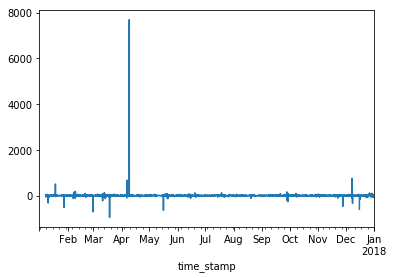

In [22]:
df_data.uni_pred.plot()

In [23]:
df_data.shape

(8760, 11)

In [24]:
df_uni_arima = df_data.dropna()

In [25]:
df_uni_arima.shape

(8140, 11)

In [26]:
df_uni_arima.to_csv('uni_arima_result.csv', index = False)

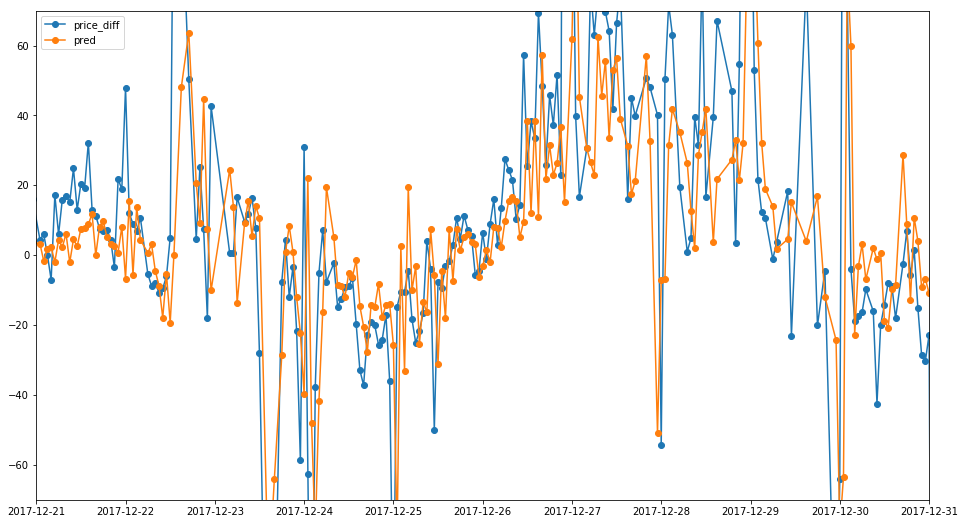

In [59]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_uni_arima.price_diff, 'o-', label = 'price_diff')
ax.plot(df_uni_arima.uni_pred, 'o-', label = 'pred')
ax.legend()
ax.set_xlim(pd.datetime(2017,12,21), pd.datetime(2017,12,31))
ax.set_ylim(-70, 70)
plt.show()

In [42]:
np.sqrt(metrics.mean_squared_error(df_uni_arima.price_diff.values, df_uni_arima.uni_pred.values))

93.148654553210122

In [48]:
metrics.mean_absolute_error(df_uni_arima.price_diff.values, df_uni_arima.uni_pred.values)

13.847854707366064

In [61]:
df_uni_arima.columns

Index(['time_stamp_local', 'price', 'price_24hr_ago', 'price_diff', 'load',
       'load_24hr_ago', 'load_diff', 'temp', 'temp_24hr_ago', 'temp_diff',
       'uni_pred'],
      dtype='object')

## SMAPE

In [ ]:
(X_valid, forecast)

## Add Load

In [ ]:
df_load.head()

In [ ]:
X_load = daily_diff(df_load, 'load')

In [ ]:
plot_acf(df_load, X_load, 'load')
# # Graph data
# fig, axes = plt.subplots(2, 2, figsize=(16,9))

# fig = sm.graphics.tsa.plot_acf(df_load.load, lags=90, ax=axes[0, 0])
# fig = sm.graphics.tsa.plot_pacf(df_load.load, lags=90, ax=axes[0, 1])

# fig = sm.graphics.tsa.plot_acf(X_load.load_deseason, lags=30, ax=axes[1, 0])
# fig = sm.graphics.tsa.plot_pacf(X_load.load_deseason, lags=30, ax=axes[1, 1])

In [ ]:
#stationarity test
load_adf = adfuller(X_load.load.values, autolag='AIC')
load_deseason_adf = adfuller(X_load.load_deseason.values, autolag='AIC')
adf_output(load_adf)
adf_output(load_deseason_adf)

In [ ]:
#causality test
granger = pd.DataFrame({'price':X_price.price.values, 'load':X_load.load.values})
granger = granger.dropna()
granger_test = grangercausalitytests(granger, maxlag=5)

## Load & Price

In [ ]:
model3=ARIMA(endog=X_price.price_deseason.values[:-1],
             exog=X_load.load_deseason.values[:-1],
             order=[3,0,3])
results3=model3.fit()
print(results3.summary())

In [ ]:
results3.forecast(exog = [X_load.load_deseason.values[-1]], steps=1)[0]

In [ ]:
X_valid

## Add Temperature

In [ ]:
df_temp.head()

In [ ]:
df_temp['temp_24hr_ago'] = df_temp.temp.shift(periods = 24)
df_temp['temp_deseason'] = df_temp.temp - df_temp.temp_24hr_ago
X_temp = df_temp.dropna()

In [ ]:
plot_acf(df_temp, X_temp, 'temp')

In [ ]:
X_price.shape, X_temp.shape

In [ ]:
plt.hist(df_temp.temp_deseason, range = (-40, 40), bins = 200, log = True);

In [ ]:
# stationarity test
temp_adf = adfuller(X_temp.temp.values, autolag='AIC')
temp_deseason_adf = adfuller(X_temp.temp_deseason.values, autolag='AIC')
adf_output(temp_adf)
adf_output(temp_deseason_adf)

In [ ]:
scaler = StandardScaler()
X_price.loc[:,'norm'] = scaler.fit_transform(X_price.price_deseason.values.reshape(-1, 1))

scaler = StandardScaler()
X_temp.loc[:,'norm'] = scaler.fit_transform(X_temp.temp_deseason.values.reshape(-1, 1))

In [ ]:
# price is caused by temp, but price_deseason is not caused by temp_deseason or temp
# price_deseason is not caused by temp_deseason after normalization

# create a 2d dataframe to test if price is caused by temperature
# granger = pd.DataFrame({'price':X_price.price.values, 'temp':X_temp.temp.values})
# granger = granger.dropna()

# create a 2d dataframe to test if price is caused by temperature
granger = pd.DataFrame({'price':X_price.price_deseason.values, 'temp':X_temp.temp_deseason.values})
granger = granger.dropna()
# granger = pd.DataFrame({'price':X_price.norm, 'temp':X_temp.norm})
# granger = granger.dropna()

granger_test = grangercausalitytests(granger, maxlag=5)

In [ ]:
# fig, ax = plt.subplots(figsize = (24, 9))
# ax.plot(df_price.iloc[:, 0], 
#         df_price.iloc[:, 1], color = 'black', label = 'Test');
# # ax.plot(df_price.iloc[:int(df_price.shape[0] * percentage), 0], 
# #         df_price.iloc[:int(df_price.shape[0] * percentage), 1], '.', color = 'black', label = 'Train');
# ax.plot(forecast.ds, 
#         forecast.yhat, linewidth = 4,
#         color = 'red', label = 'Prediction');
# #ax.fill_between(forecast.index, forecast.yhat_lower, forecast.yhat_upper)
# ax.tick_params(axis='both',which='both',labelsize=20,\
#         length=5,width=2,direction='out');
# ax.legend(fontsize = 32);
# #ax.set_ylim(-20, 2100)
# ax.set_ylim(0, 200)
# ax.set_xlim(pd.datetime(2017,1,1), pd.datetime(2018,2,5))
# #plt.savefig('prophet_2017.pdf', format = 'pdf')

In [ ]:
X_price.columns

In [ ]:
model3=ARIMA(endog=X_price.price_deseason.values[:-1],
             exog=X_temp.temp_deseason.values[:-1],
             order=[3,0,3])
results3=model3.fit()
print(results3.summary())

In [ ]:
results3.forecast(exog = [X_temp.temp_deseason.values[-1]], steps=1)[0]

In [ ]:
X_valid

In [65]:
X_price.columns

Index(['time_stamp', 'price', 'time_stamp_local', 'price_24hr_ago',
       'price_deseason'],
      dtype='object')

In [67]:
start_date = pd.datetime(2017, 10, 27)
end_date = start_date + timedelta(days = 1)
may1st_index_price = (df_price.time_stamp_local >= start_date) & \
                     (df_price.time_stamp_local < end_date)
may1st_index_temp = (df_temp.time_stamp_local >= start_date) & \
                     (df_temp.time_stamp_local < end_date)

may1st_index_load = (df_load.time_stamp_local >= start_date) & \
                    (df_load.time_stamp_local < end_date)

plot_price = df_price.loc[may1st_index_price, :].reset_index(drop = True)
plot_temp = df_temp.loc[may1st_index_temp, :].reset_index(drop = True)
plot_load = df_load.loc[may1st_index_load, :].reset_index(drop = True)

plot_price.shape, plot_temp.shape, plot_load.shape

((24, 5), (24, 5), (24, 5))

In [73]:
df_uni_arima.index

DatetimeIndex(['2017-01-08 04:00:00', '2017-01-08 05:00:00',
               '2017-01-08 06:00:00', '2017-01-08 07:00:00',
               '2017-01-08 08:00:00', '2017-01-08 09:00:00',
               '2017-01-08 10:00:00', '2017-01-08 11:00:00',
               '2017-01-08 12:00:00', '2017-01-08 13:00:00',
               ...
               '2017-12-31 19:00:00', '2017-12-31 20:00:00',
               '2017-12-31 21:00:00', '2017-12-31 22:00:00',
               '2017-12-31 23:00:00', '2018-01-01 00:00:00',
               '2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00'],
              dtype='datetime64[ns]', name='time_stamp', length=8140, freq=None)

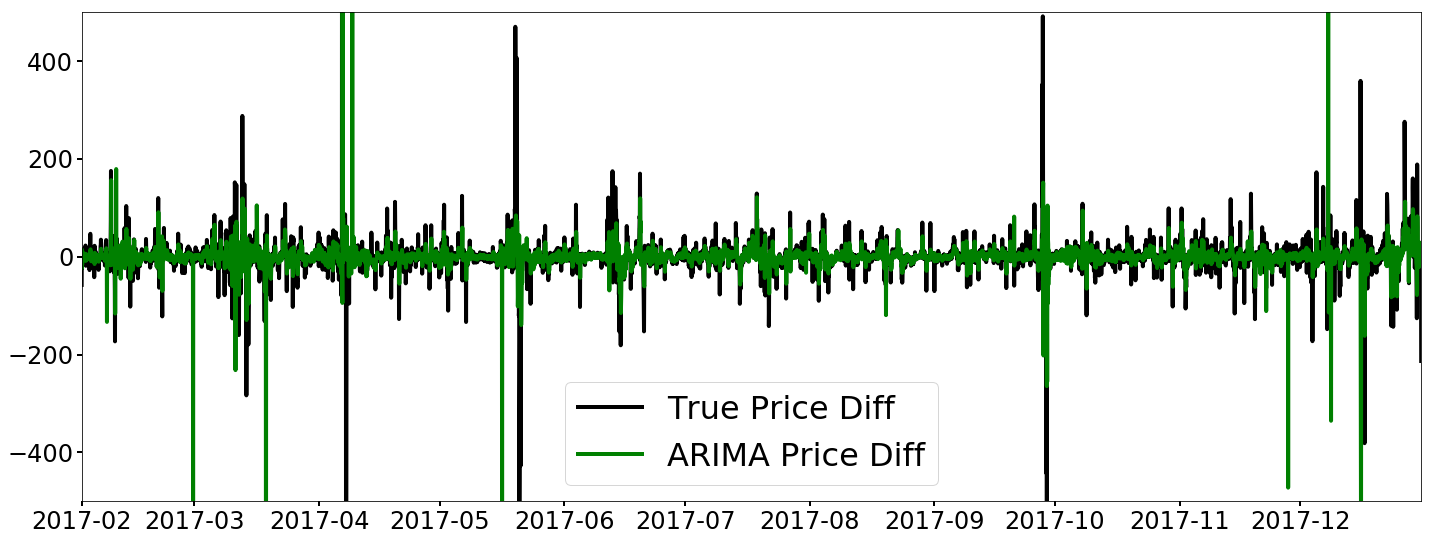

In [84]:
fig, ax = plt.subplots(figsize = (24, 9))
df_uni_arima.price_diff.values, df_uni_arima.uni_pred.values
ax.plot(df_uni_arima.index, df_uni_arima.price_diff.values, linewidth = 4
        , color = 'black', label = 'True Price Diff')
ax.plot(df_uni_arima.index, df_uni_arima.uni_pred.values, linewidth = 4
        , color = 'green', label = 'ARIMA Price Diff')
ax.legend(fontsize = 32)
#ax.set_ylabel('Standardized Value', fontsize = 32)
ax.set_xlim(pd.datetime(2017, 2, 1), pd.datetime(2017, 12, 31))
ax.set_ylim(-500,500)
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
plt.savefig('arima_pred.pdf', format = 'pdf')